# Libraries

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from itertools import combinations, product, cycle
from collections import defaultdict
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, weight='bold') # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE, titlesize=BIGGER_SIZE, labelweight='bold', titleweight='bold')  
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, markerscale=2)
plt.rc('figure', titlesize=BIGGER_SIZE)
plt.rcParams['axes.spines.top'] = 'False'
plt.rcParams['axes.spines.right'] = 'False'
plt.rcParams['axes.spines.left'] = 'False'
plt.rcParams['axes.spines.bottom'] = 'False'
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\\usepackage{sfmath} \\boldmath']

/var/folders/nb/fsgt9jgs34x6qd_dvlnbdw680000gn/T/ipykernel_78221/323863601.py:17: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\\usepackage{sfmath} \\boldmath']


In [4]:
palette = sns.color_palette(['#2E4052', '#EF767A', '#BDD9BF', 
                             '#8C6057', '#FFC857', '#2CEAA3',
                             '#AC3931', '#01BAEF', '#121113', '#8332AC'])

In [5]:
sns.set_style('whitegrid')

# Methods

In [6]:
# load hypergraph
def load_graph(f):
    C = set()
    with open(f) as in_f:
        for line in in_f.readlines():
            lst = line.strip().split(' ')
            edge = tuple(sorted([int(e) for e in lst]))
            C.add(edge)
    return C

In [7]:
# load list of hyperedges
def load_edges(f):
    C = list()
    with open(f) as in_f:
        for line in in_f.readlines():
            lst = line.strip().split(' ')
            edge = tuple(sorted([int(e) for e in lst]))
            C.append(edge)
    return C

In [8]:
# computes number of vertices, number of hyperedges,
# dimension, and number of hyperedges with size >= k
# for k in [1, 10]
def compute_stats(graph, C):
    vertices = set()
    vmap = defaultdict(int)
    edges_per_size = np.zeros(10, dtype=np.int32)
    max_dim = 0
    dims = []
    for s in C:
        if len(s) >= 10:
            idx=10
        else:
            idx = len(s) % 10
        for i in range(idx):
            edges_per_size[i] += 1
        for e in s:
            vertices.add(e)
            vmap[e] += 1
        max_dim = max([max_dim, len(s)])
        dims.append(len(s))
    dims_df = pd.DataFrame(dims, columns=[graph], dtype=np.int32)
    avg = 1.0 * sum(vmap.values()) / len(vmap)
    return len(vertices), len(C), max_dim, avg, edges_per_size

In [9]:
# rename landmark assignment strategy
def rename_la(s):
    if s == 'prob':
        return 'Sampling'
    return 'RankAgg'

In [10]:
# rename landmark selection strategy
def rename_ls(s):
    s = s.split("_")[0]
    return f'{s[0].upper()}{s[1:]}'

In [11]:
# rename algorithm
def rename_method(s):
    if s == 'bas1':
        return 'Baseline'
    if s == 'bas2':
        return 'HypED-IS'
    if s == 'meth':
        return 'HypED'
    return s

In [12]:
def rounded_str(s, digits=2):
    return "{:.2f}".format(round(s, digits))

In [13]:
def get_precision_top_k(df, s, ls, q, k):
    '''
    s: min overlap size
    ls: selection startegy
    q: num landmarks
    k: number of elements in the ranking to consider
    '''
    data = df[(df['s']==s) & (df['LS']==ls) & (df['Q']==q)]
    out = []
    for src in data['src'].unique():
        src_data = data[(data['src']==src) & 
                        (data['SrcLabel']==data['DstLabel'])]
        # real top k
        idx = 0
        d_vec = sorted(list(src_data['d'].unique()))
        if len(d_vec) == 0: continue
        while idx < len(d_vec) and len(src_data[src_data['d']<=d_vec[idx]]) < k:
            idx += 1
        idx = min([idx, len(d_vec)-1])
        top = src_data[src_data['d']<=d_vec[idx]].sort_values(by=['d', 'dst']) 
        real = set(top['dst'].values[:k])
        # approx top k
        feas = src_data[src_data['d_hat']!=-1]
        idx = 0
        d_vec = sorted(list(feas['d_hat'].unique()))
        if len(d_vec) > 0:
            while idx < len(d_vec) and len(feas[feas['d_hat']<=d_vec[idx]]) < k:
                idx += 1
            idx = min([idx, len(d_vec)-1])
            top_a = feas[feas['d_hat']<=d_vec[idx]].sort_values(by=['d_hat', 'dst']) 
            approx = set(top_a['dst'].values[:k])
            # find common elements
            common = approx.intersection(real)
            # find precision
            prec = 1. * len(common) / len(approx)
        else:
            prec = 0
        if len(real) == 0:
            prec = -1
        out.append([src, s, ls, q, k, prec])
    return out

# Folders and Files

In [15]:
fig_path = '../../paper/figures/'
outfile_path = '/Users/giulia/Desktop/output/'
graph_path = '../data/'

In [16]:
graphs = ['etfs.hg', 'zebra.hg', 'dblp.hg', 'enron.hg', 
          'primary-school.hg', 'high-school.hg',
          'NDC-classes.hg', 'NDC-substances.hg']
graphs_prelims = ['etfs.hg', 'zebra.hg', 'primary-school.hg', 
                  'high-school.hg', 'NDC-classes.hg', 'NDC-substances.hg']
graphs_all = list(graphs)
graphs_all.extend(['epinions.hg', 'IMDB.hg', 
                   'FS_NYC.hg', 'FS_TKY.hg',
                   'threads-stack-overflow-2.hg'])
graph_names = {'etfs.hg':'ETFs', 
               'zebra.hg':'Zebra', 
               'dblp.hg':'DBLP', 
               'enron.hg':'Enron',
               'IMDB.hg':'IMDB', 
               'primary-school.hg':'Primary', 
               'high-school.hg':'High',
               'NDC-classes.hg':'NDC-C', 
               'NDC-substances.hg':'NDC-S', 
               'epinions.hg':'Epinions',
               'threads-stack-overflow-2.hg':'Threads-SO'}

In [17]:
# removes extension from file name
def rename_graph(s):
    if '.hg' in s:
        return graph_names[s]
    return graph_names[f'{s}.hg']

In [20]:
graph_sizes = {}
num_v_per_s = {}

# Graphs Stats

In [21]:
for graph in graphs_all:
    C = load_graph(graph_path+graph)
    vertices, edges, max_dim, avg, eps = compute_stats(graph[:-3], C)
    graph_sizes[graph_names.get(graph, graph[:-3])] = edges
    num_v_per_s[graph_names.get(graph, graph[:-3])] = eps
    print(graph, vertices, edges, max_dim, avg, eps[1], eps[2])

etfs.hg 2340 2157 19 2.4085470085470084 1597 985
zebra.hg 10112 9716 62 4.975178006329114 4956 3743
dblp.hg 1918581 2465299 17 4.011407910325391 2168170 1474806
enron.hg 50224 106442 64 7.163109270468302 104578 67830
primary-school.hg 242 12704 5 126.97933884297521 12704 4956
high-school.hg 327 7818 5 55.63302752293578 7818 2320
NDC-classes.hg 1161 1088 24 5.549526270456503 1047 750
NDC-substances.hg 5311 9906 25 10.078704575409528 6264 5134
epinions.hg 755760 107363 162169 17.997255742563777 73533 59622
IMDB.hg 1003931 267314 10 1.9938292571899863 257098 244629
FS_NYC.hg 1083 14429 274 61.3601108033241 13347 7990
FS_TKY.hg 2293 26992 1274 76.818578281727 24752 14470
threads-stack-overflow-2.hg 2662650 6964551 22 5.243521679529792 5211485 1328043


## Line Graph and Augmented Line Graph

In [19]:
aug_stats = pd.read_csv(outfile_path+'lg/line_graph_sizes.txt', sep=' ')

In [20]:
aug_stats['EdgeIncr-L'] = aug_stats['E_L'] / aug_stats['E']
aug_stats['EdgeIncr-La'] = aug_stats['E_La'] / aug_stats['E']

In [21]:
aug_stats[['EdgeIncr-L', 'EdgeIncr-La']].mean()

EdgeIncr-L     235.338210
EdgeIncr-La    249.918813
dtype: float64

In [22]:
aug_stats

HyperGraph        V        E        E_L     V_La       E_La   EdgeIncr-L  \
0       NDC-C     1161     1088      35738     2249      42181    32.847426   
1        ETFs     2340     2157      47203     4497      52839    21.883635   
2        High      327     7818     593188     8145     611380    75.874648   
3       Zebra    10112     9716     104047    19828     154356    10.708831   
4       NDC-S     5311     9906    2402924    15217    2456452   242.572582   
5     Primary      242    12704    2238167    12946    2268896   176.178133   
6       Enron    50224   106442  152766470   156666  153126230  1435.208564   
7    Epinions   755760   120492   32482828   863123   46151148   269.584935   
8        DBLP  1918581  2465299  124931414  4383880  132627625    50.675968   
9  Threads-SO  2662650  6964551  263590007  9627201  277551670    37.847380   

   EdgeIncr-La  
0    38.769301  
1    24.496523  
2    78.201586  
3    15.886785  
4   247.976176  
5   178.596977  
6  1438.588433  
7   383.022508  
8    53.797785  
9    39.852055

# Connected Components

## Size Statistics

In [22]:
ccs = pd.read_csv(outfile_path+'ccs/components', sep='\t', header=None)
ccs.columns = ['Hypergraph', 's', 'Num CCs']
ccs['Size'] = 0
ccs['HyperGraph'] = ccs['Hypergraph'].apply(rename_graph)
for graph in ccs['HyperGraph'].unique():
    maxS = ccs[ccs['HyperGraph']==graph]['s'].max()
    ccs.loc[ccs['HyperGraph']==graph, 'Size'] = num_v_per_s[graph][:maxS]

In [23]:
ccs['Ratio'] = ccs['Num CCs'] / ccs['Size']

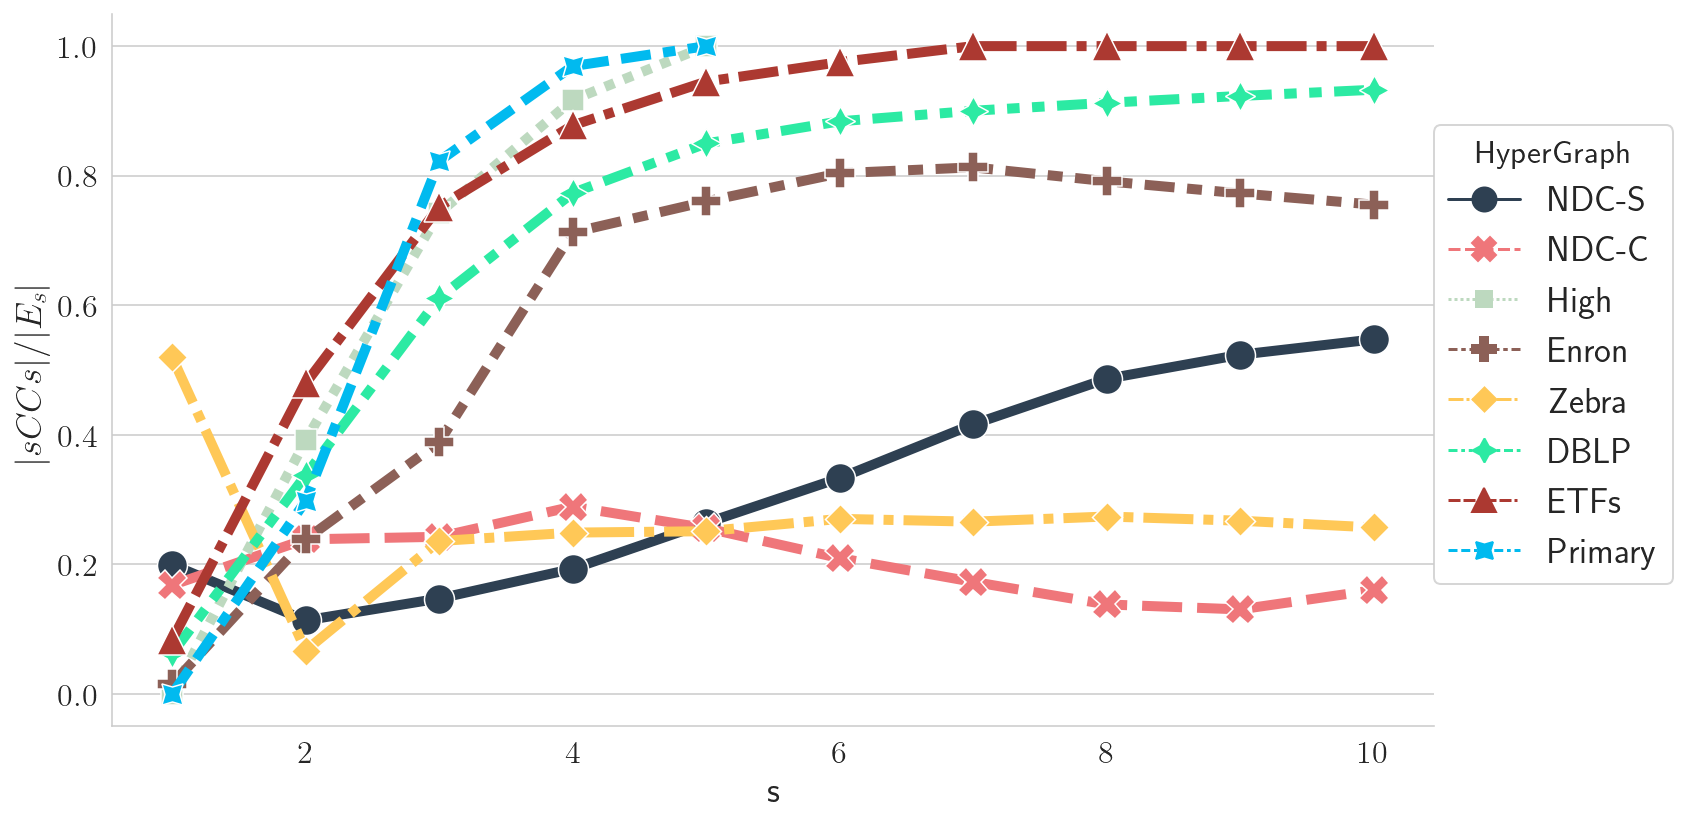

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=ccs, x='s', y='Ratio', hue='HyperGraph', palette=palette[:8],
            markers=True, style='HyperGraph', linewidth = 5, markersize=15)

ax.set_ylabel(r'$|sCCs|/|E_s|$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.legend(title='HyperGraph', loc=[1,0.2])
plt.tight_layout()
plt.savefig(fig_path+'ccs.pdf')
plt.show()

## Time Statistics

In [22]:
rows = []
with open(outfile_path+'ccs/stats') as stats_file:
    for line in stats_file.readlines():
        lst = line.strip().split('\t')
        rows.append([rename_graph(lst[0]), 'LG', float(lst[2])])
        rows.append([rename_graph(lst[0]), 'CCS-IS', float(lst[3])])
        rows.append([rename_graph(lst[0]), 'CCS-SW', float(lst[4])])

In [23]:
ccs_stats = pd.DataFrame(data=rows, columns=['HyperGraph', 'Method', 'Time'])

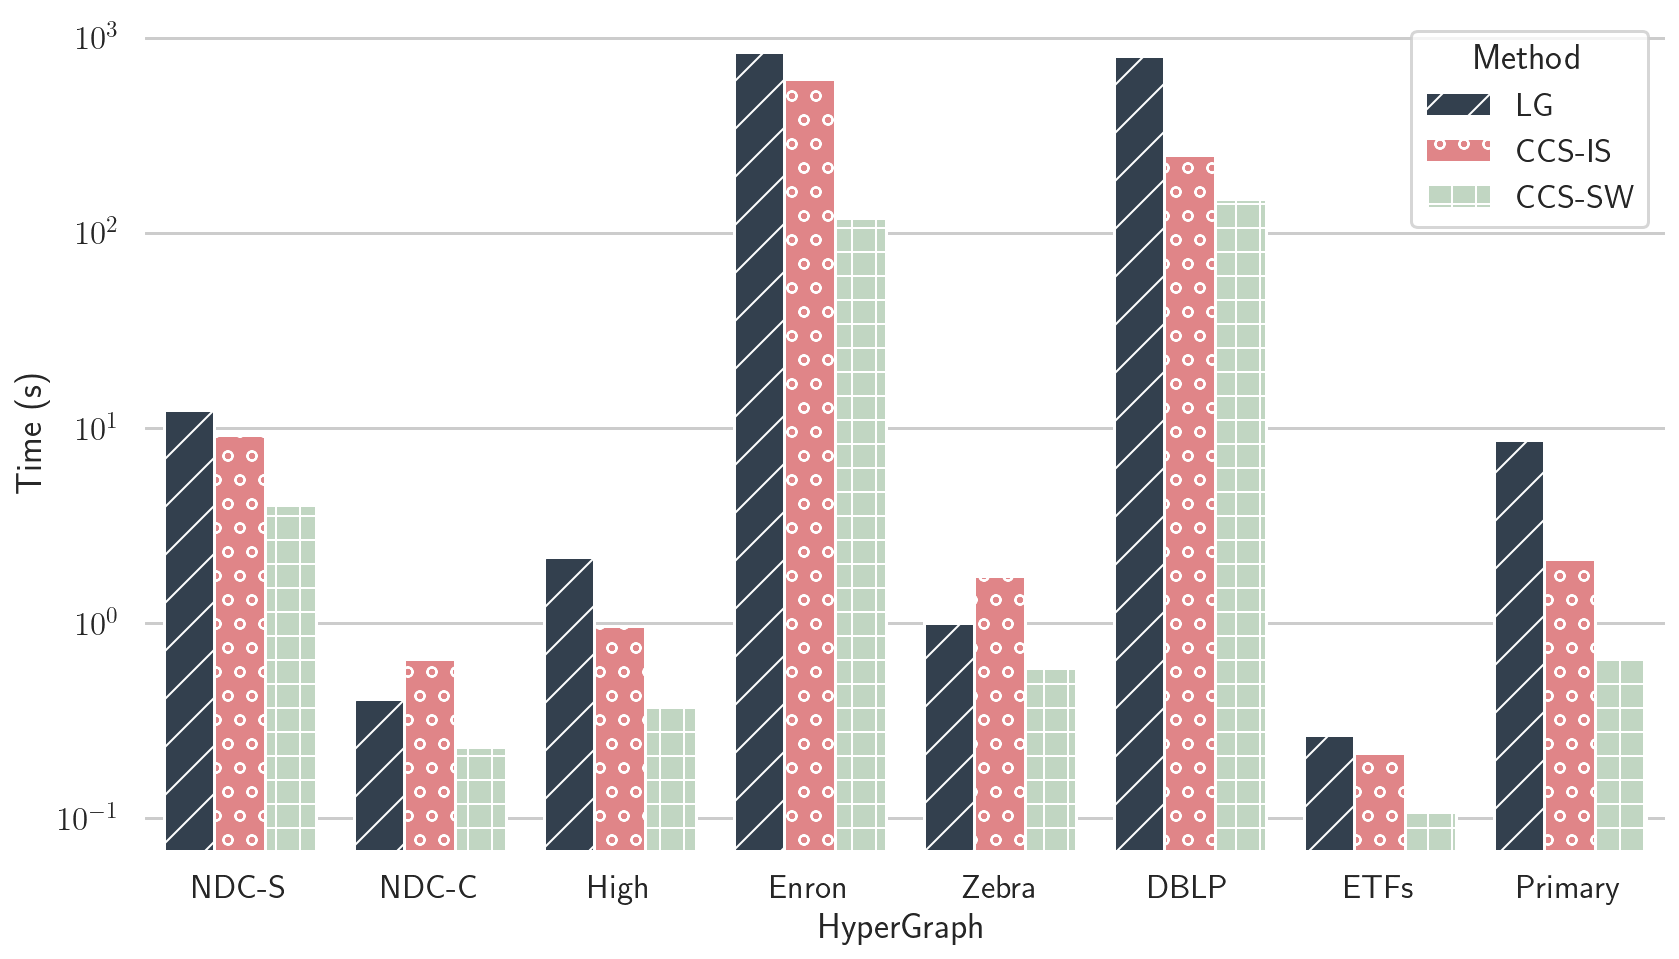

In [54]:
fig, ax = plt.subplots(figsize=(12,7))

sns.set_style('whitegrid')
sns.barplot(data=ccs_stats, x='HyperGraph', y='Time', hue='Method', palette=palette)

size = len(ccs_stats['HyperGraph'].unique())
hatches = cycle(['/', 'o', '+', '*', 'x', '\\', '-', '//', 'O', '.'])
for i, bar in enumerate(ax.patches):
    if i % size == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)

ax.set_yscale('log')
ax.set_ylabel('Time (s)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.legend(title='Method')
plt.tight_layout()
plt.savefig(fig_path+'ccs_time.pdf')
plt.show()

# Comparison between Methods

Settings

In [360]:
lb=4
maxS=10
# sample size
queryS=100
# query sample size
sampleS=0.4
landNum=30
landmarkSel=['bestcover', 'degree', 'farthest']
# how to assign landmarks to s-ccs
landmarkAss='prob'
# importance of s-cc size
alpha=0.2
# importance of s
beta=0.6
# number of random tests
tests=10

Output

In [361]:
acc_la = pd.DataFrame()

In [362]:
path = outfile_path + 'baselines'
for run in product(graphs_prelims,
                   list(range(5)),
                   landmarkSel,
                   ['bas1', 'bas2', 'meth'],
                   list(range(1,tests+1))):
    graph = run[0]
    i = run[1]
    ls = run[2]
    meth = run[3]
    t = run[4]
    path2 = f'{path}/{t}'
    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    try:
        fileName = f'{graph}_S{maxS}_L30_LB{lb}_Q{queryS}_M{strategy}_LAprob_A{alpha}_B{beta}_ID{meth}_sample{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['Algorithm'] = rename_method(meth)
        tmp['QuerySample'] = i
        tmp['Q'] = 30
        tmp['LA'] = 'prob'
        acc_la = acc_la.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

Statistics

In [363]:
stats = pd.DataFrame()
for t in range(1,tests+1):
    stats = stats.append(pd.read_csv(outfile_path+f'baselines/{t}/statistics.csv', header=None, sep='\t'))

In [364]:
stats.columns = ['HyperGraph', 'Timestamp', 'Offline', 
                 'Online', 'maxS', 'lb', 'Q', 'NumLands', 'OracleSize',
                 'NumQueries', 'LS', 'LA', 'Alpha', 'Beta']

In [365]:
stats['QuerySample'] = int(len(stats) / 5) * list(range(5))
stats['Algorithm'] = ['Baseline', 'HypED-IS', 'HypED'] * int(len(stats) / 3)
stats['HyperGraph'] = stats['HyperGraph'].apply(rename_graph)
stats['LS'] = stats['LS'].apply(rename_ls)

In [366]:
num_queries = acc_la.groupby(by=['HyperGraph',
                                 'Q', 'LS', 'LA',
                                 'Algorithm',
                                 'QuerySample']).agg({'d_hat':'count'}).reset_index()

In [367]:
stats = stats.merge(num_queries)
stats['TimeXQ'] = stats['Online'] / stats['d_hat']

In [368]:
agg_stats = stats.groupby(by=['HyperGraph', 
                              'Q', 
                              'LS',
                              'Algorithm']).agg({'TimeXQ':'mean',
                                                 'Offline':'mean',
                                                 'NumLands': ['min', 'max', 'mean'],
                                                 'OracleSize': ['min', 'max', 'mean']})

In [369]:
agg_stats = agg_stats.reset_index()
agg_stats.columns = agg_stats.columns.droplevel(0)
agg_stats.columns = ['HyperGraph', 'Q', 'LS', 'Algorithm',  'TimeXQ', 'Offline', 
                     'minL', 'maxL', 'meanL', 'minO', 'maxO', 'meanO']

In [373]:
agg_stats['TimeXQ (ms)'] = agg_stats['TimeXQ'] * 1000
agg_stats.loc[agg_stats['LS']=='Degree', ['HyperGraph', 'Offline', 'TimeXQ (ms)']]

HyperGraph  Offline  TimeXQ (ms)
3        ETFs   2.4064     0.000882
4        ETFs   1.5461     0.000769
5        ETFs   0.4399     0.000387
12       High  10.1148     0.000947
13       High   8.2114     0.000745
14       High   3.0960     0.000691
21      NDC-C   1.1090     0.000482
22      NDC-C   0.8031     0.000408
23      NDC-C   1.0896     0.000422
30      NDC-S  54.2579     0.000436
31      NDC-S  25.7270     0.000328
32      NDC-S  33.8278     0.000425
39    Primary  35.2953     0.000887
40    Primary  26.0442     0.000685
41    Primary  10.2065     0.000677
48      Zebra   6.5455     0.000439
49      Zebra   4.2102     0.000374
50      Zebra   4.7281     0.000501

## Comparison Creation Time

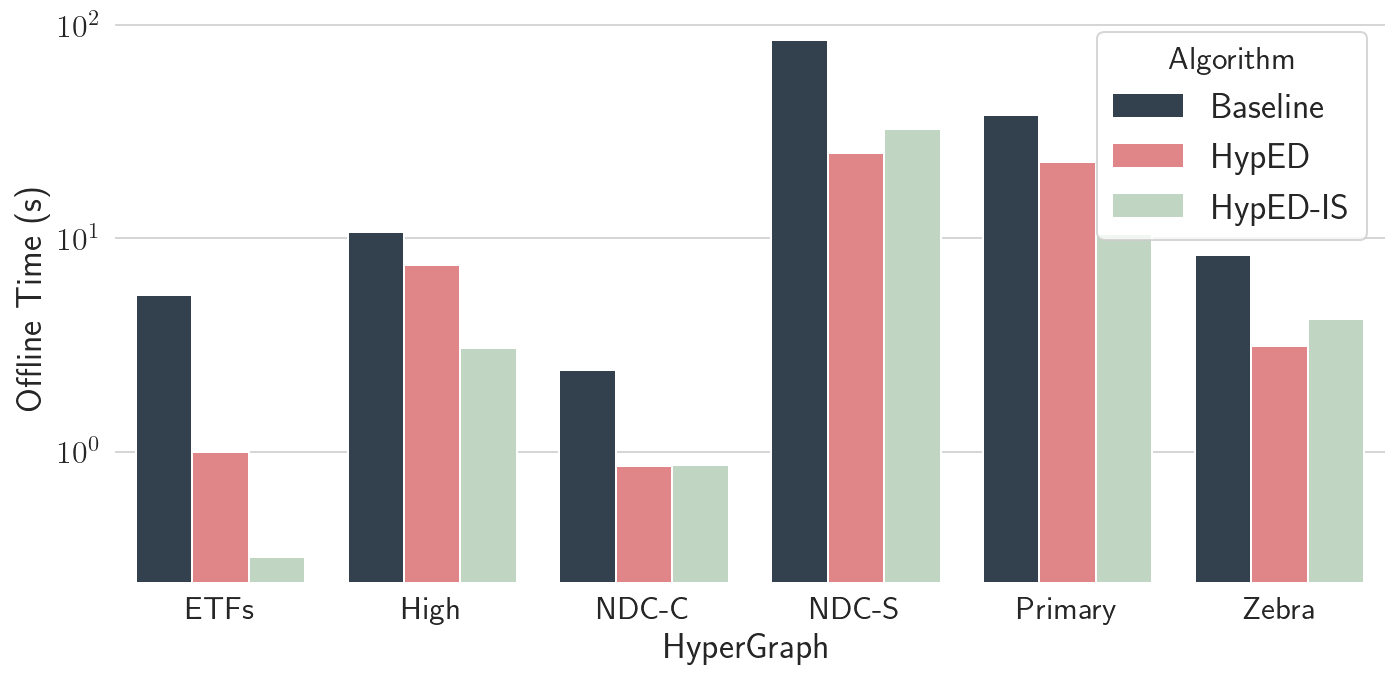

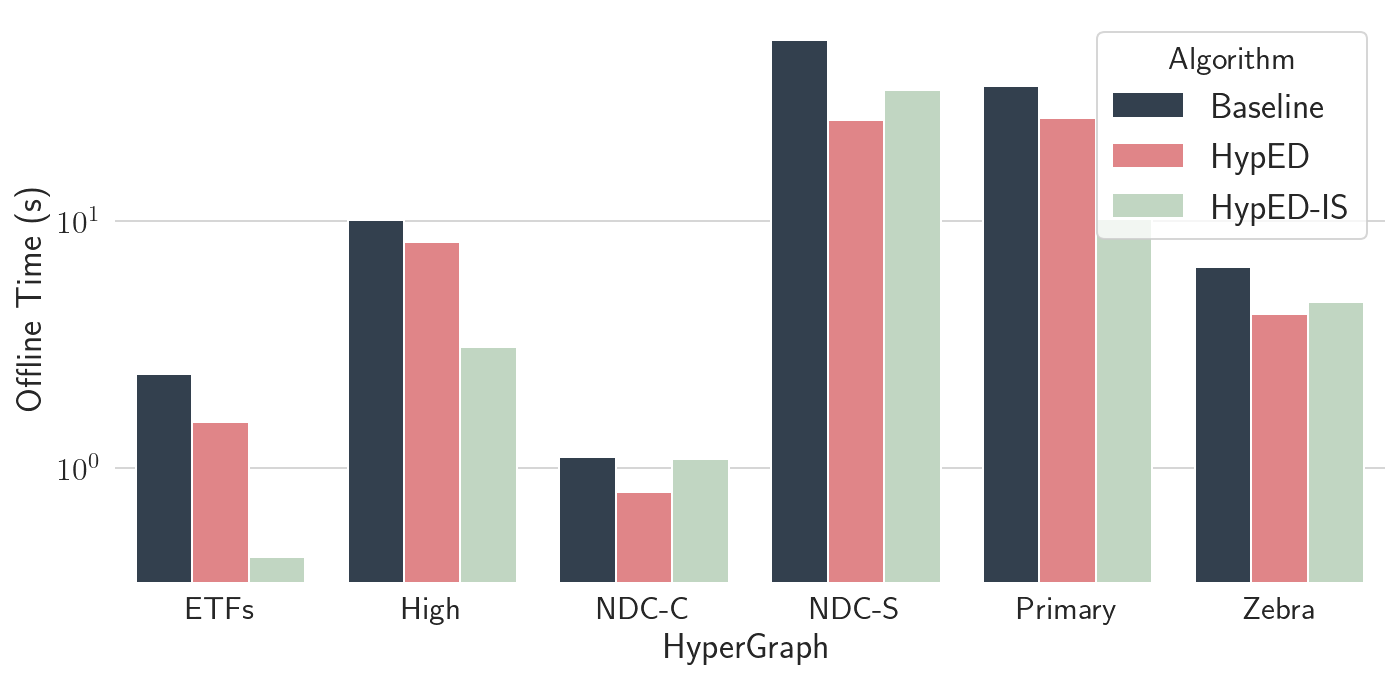

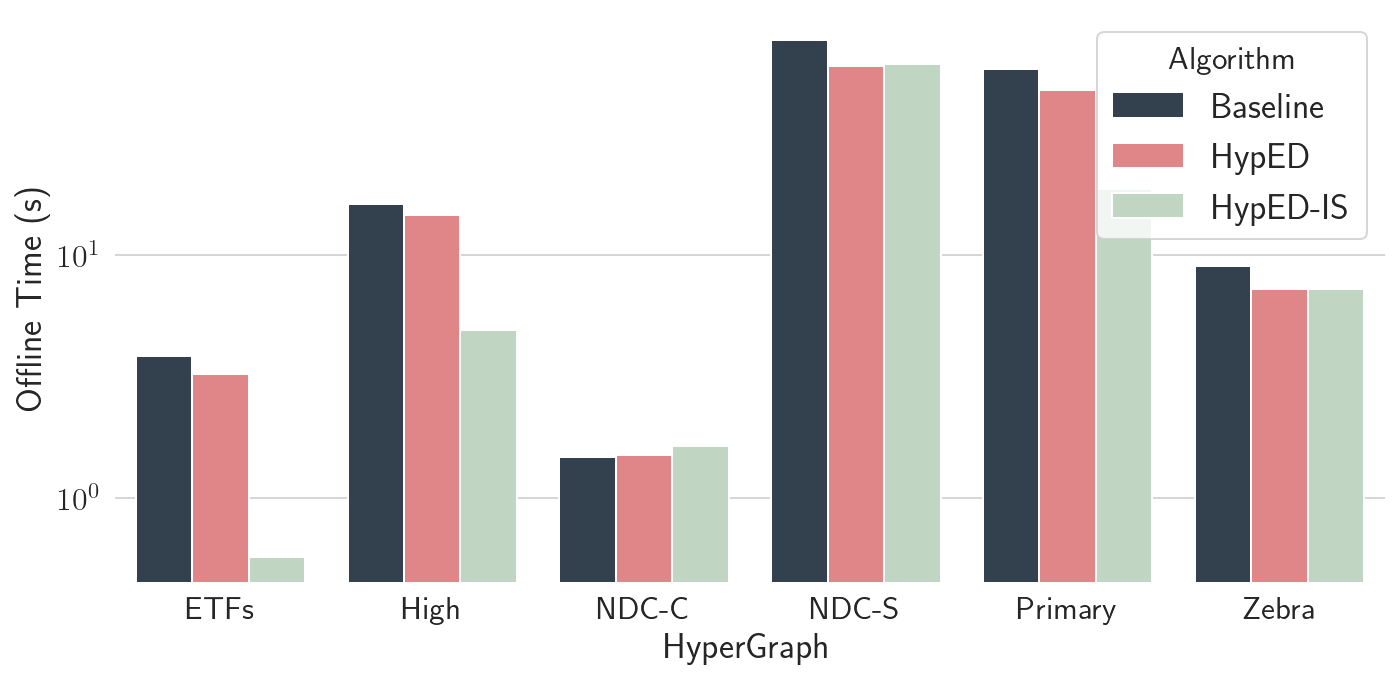

In [199]:
for strategy in agg_stats['LS'].unique():
    fig, ax = plt.subplots(figsize=(10,5))

    data = agg_stats[(agg_stats['LS']==strategy) & 
                     (agg_stats['Q']==30) &
                     (agg_stats['HyperGraph'] != 'enron.hg')].copy()
    sns.barplot(data=data, x='HyperGraph', y='Offline', hue='Algorithm', 
                palette=palette, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yscale('log')
    ax.set_ylabel('Offline Time (s)')
    ax.set_xlabel('HyperGraph')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_methods_time_{rename_ls(strategy)}.pdf')
    plt.show()

## Comparison Query Time

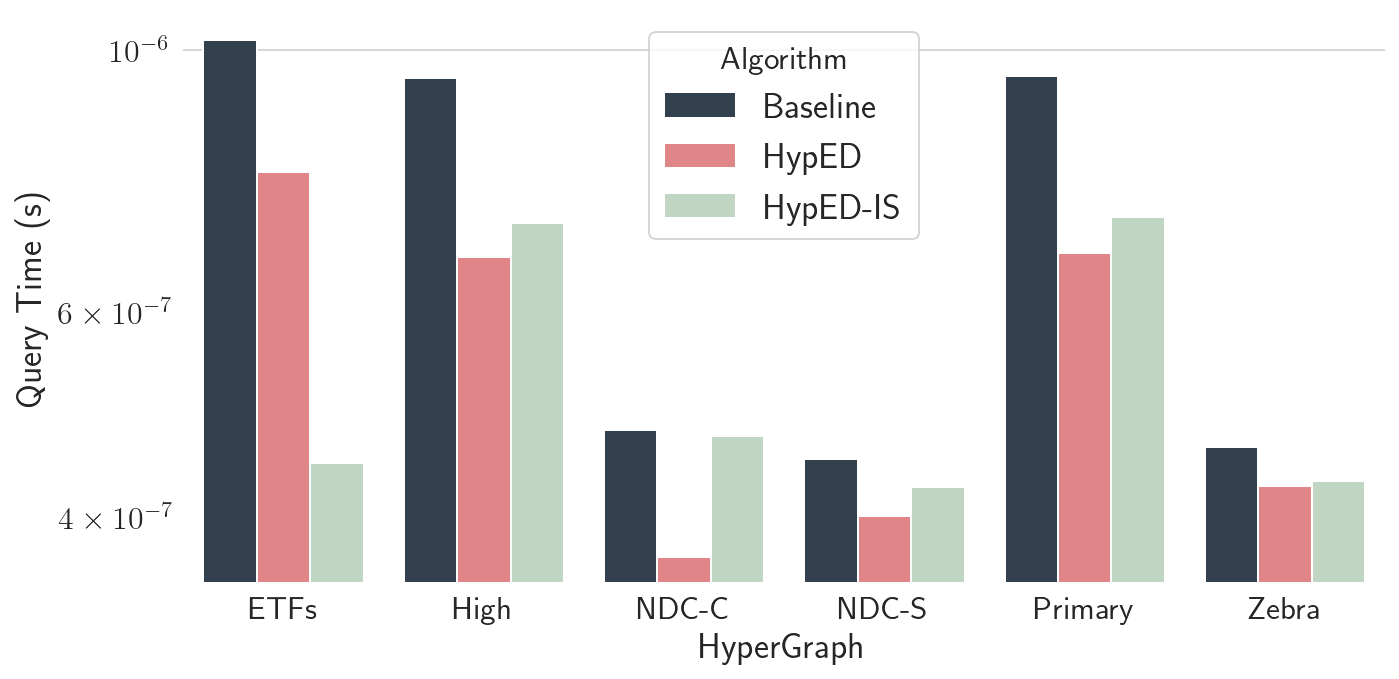

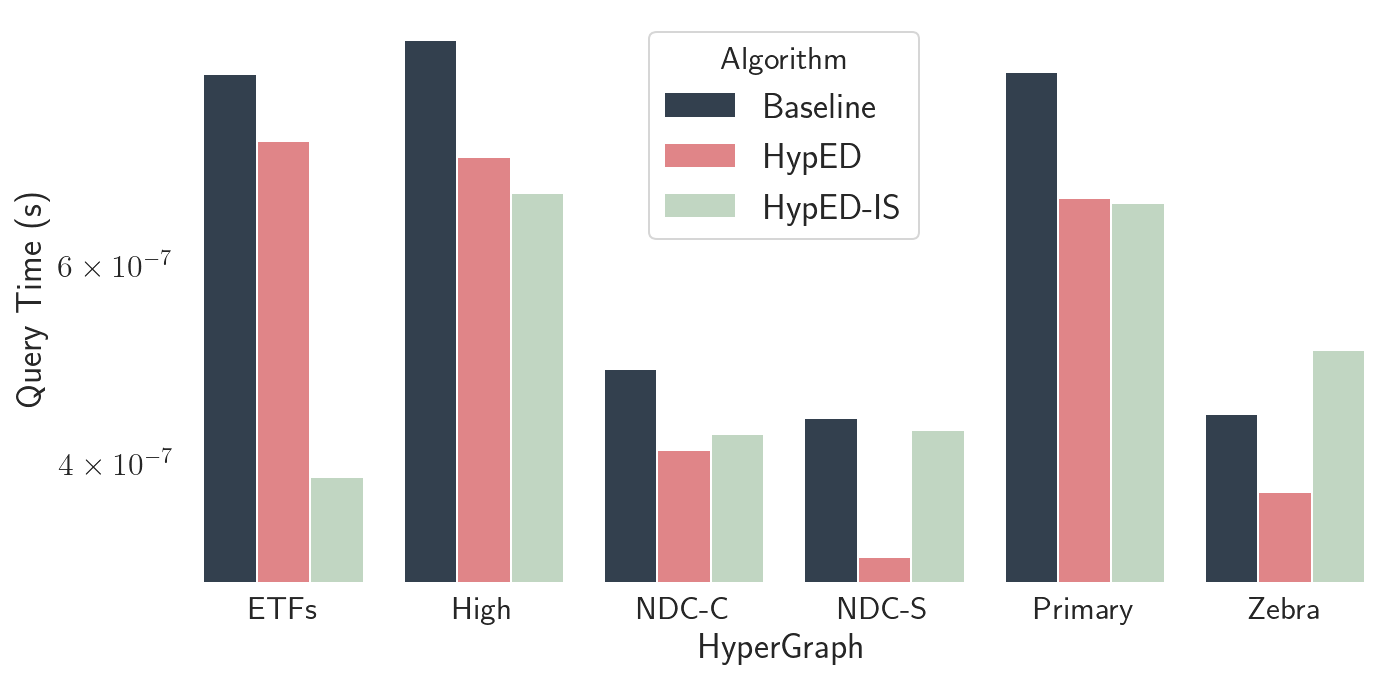

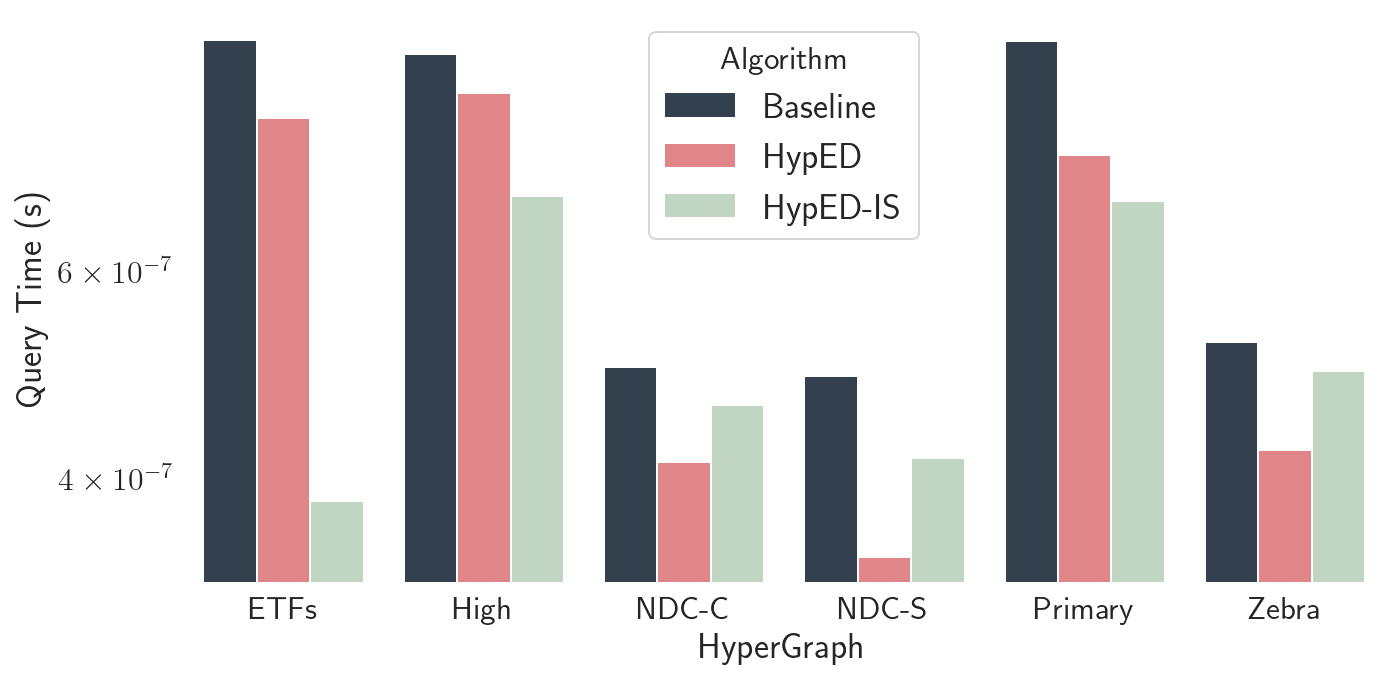

In [200]:
for strategy in agg_stats['LS'].unique():
    fig, ax = plt.subplots(figsize=(10,5))

    data = agg_stats[(agg_stats['LS']==strategy) & 
                     (agg_stats['Q']==30) &
                     (agg_stats['HyperGraph'] != 'enron.hg')].copy()
    sns.barplot(data=data, x='HyperGraph', y='TimeXQ', hue='Algorithm', 
                palette=palette, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yscale('log')
    ax.set_ylabel('Query Time (s)')
    ax.set_xlabel('HyperGraph')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_methods_query_{rename_ls(strategy)}.pdf')
    plt.show()

## Comparison Oracle Size

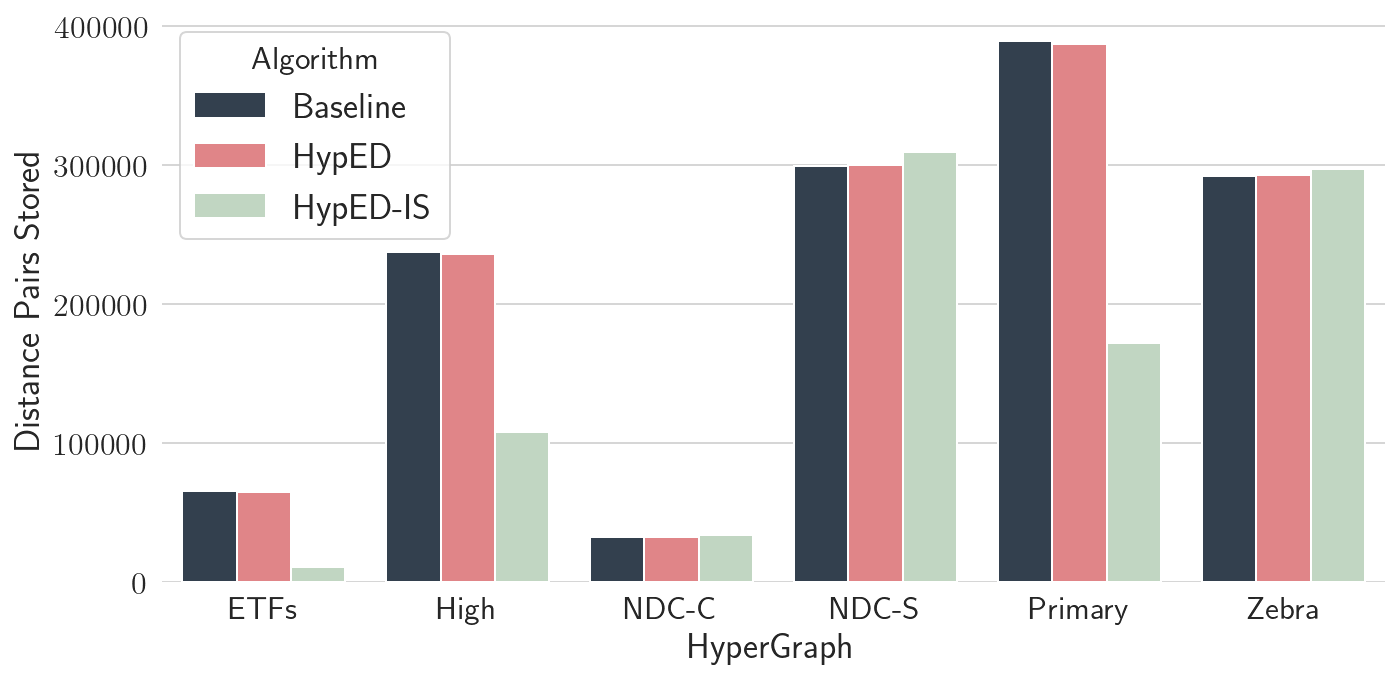

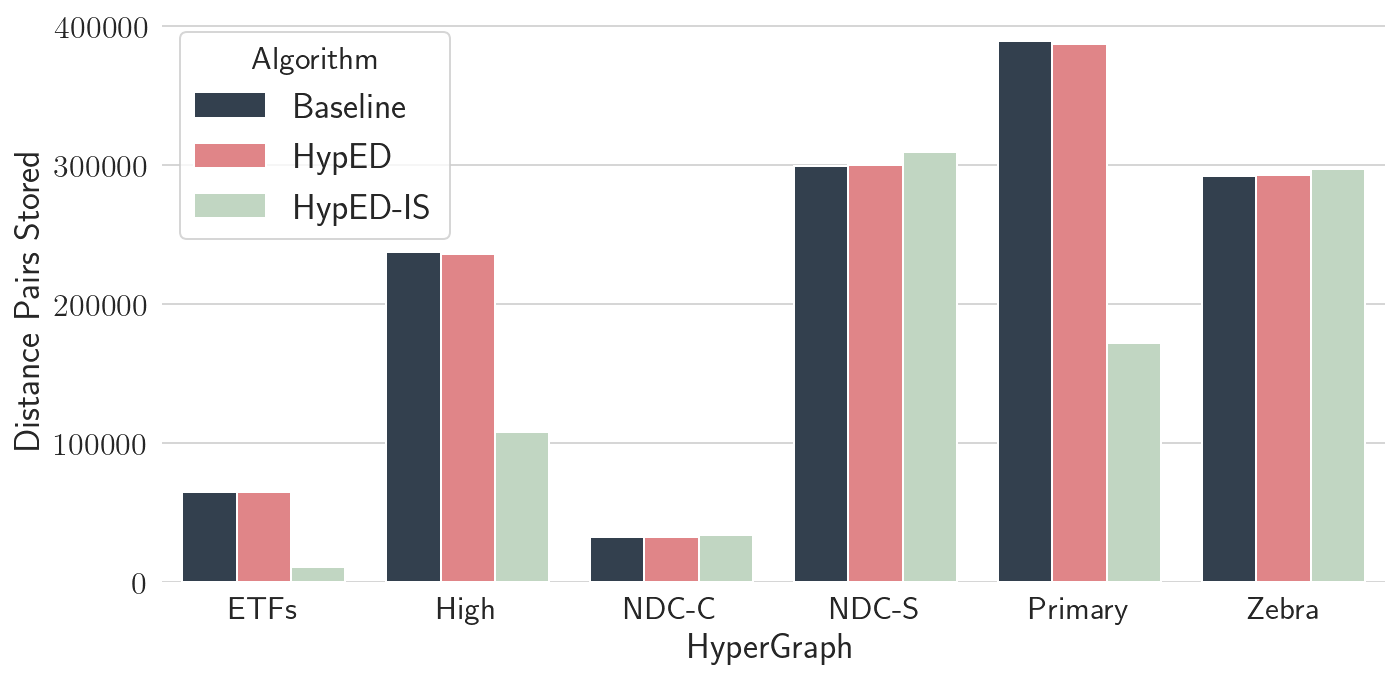

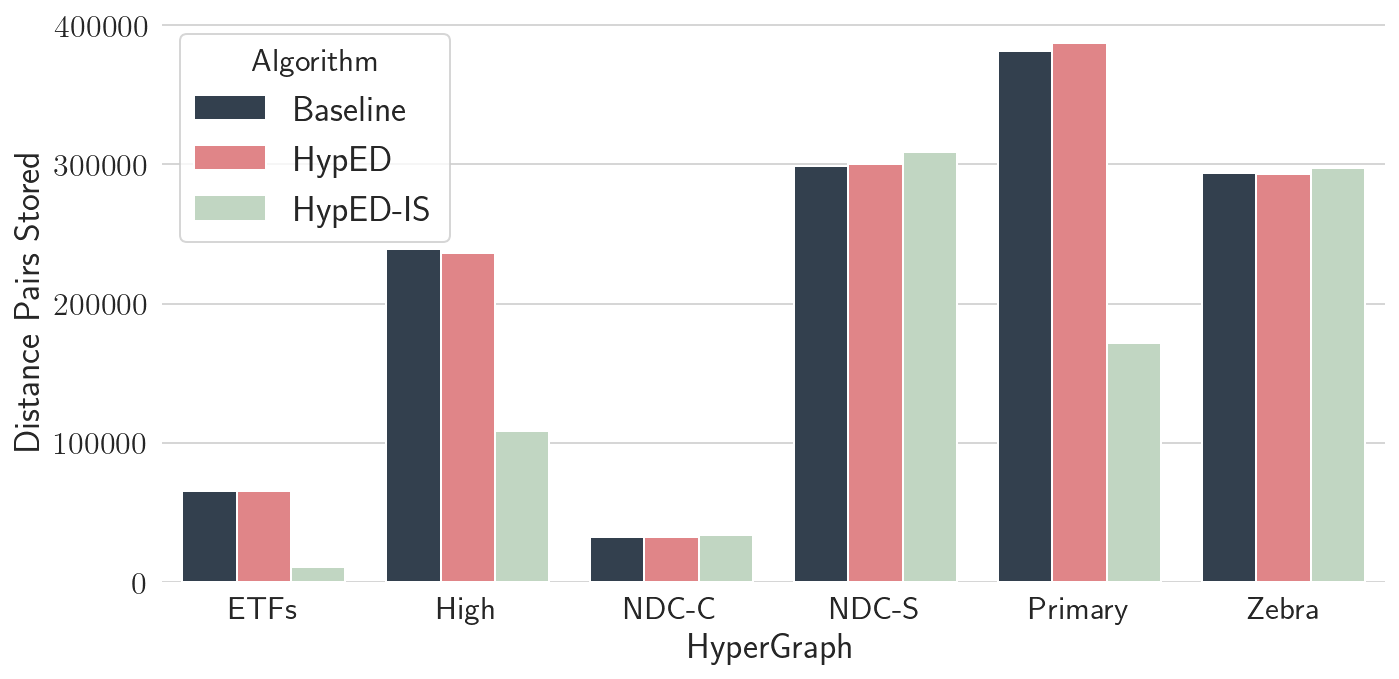

In [201]:
for strategy in agg_stats['LS'].unique():
    fig, ax = plt.subplots(figsize=(10,5))
    data = agg_stats[(agg_stats['LS']==strategy) & 
                     (agg_stats['Q']==30) &
                     (agg_stats['HyperGraph']!='Enron')].copy()
    sns.barplot(data=data, x='HyperGraph', y='meanO', 
                hue='Algorithm', palette=palette, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Distance Pairs Stored')
    ax.set_xlabel('HyperGraph')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_methods_size_{rename_ls(strategy)}.pdf')
    plt.show()

## Comparison Landmarks Num

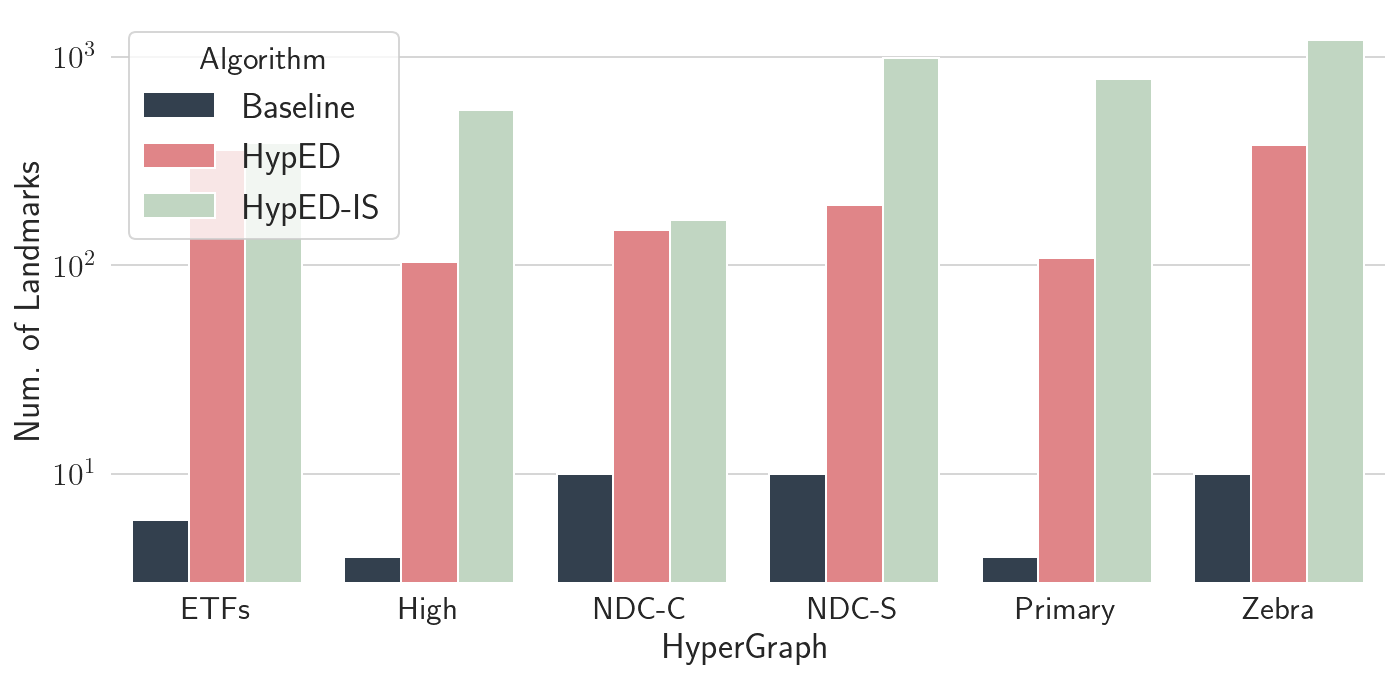

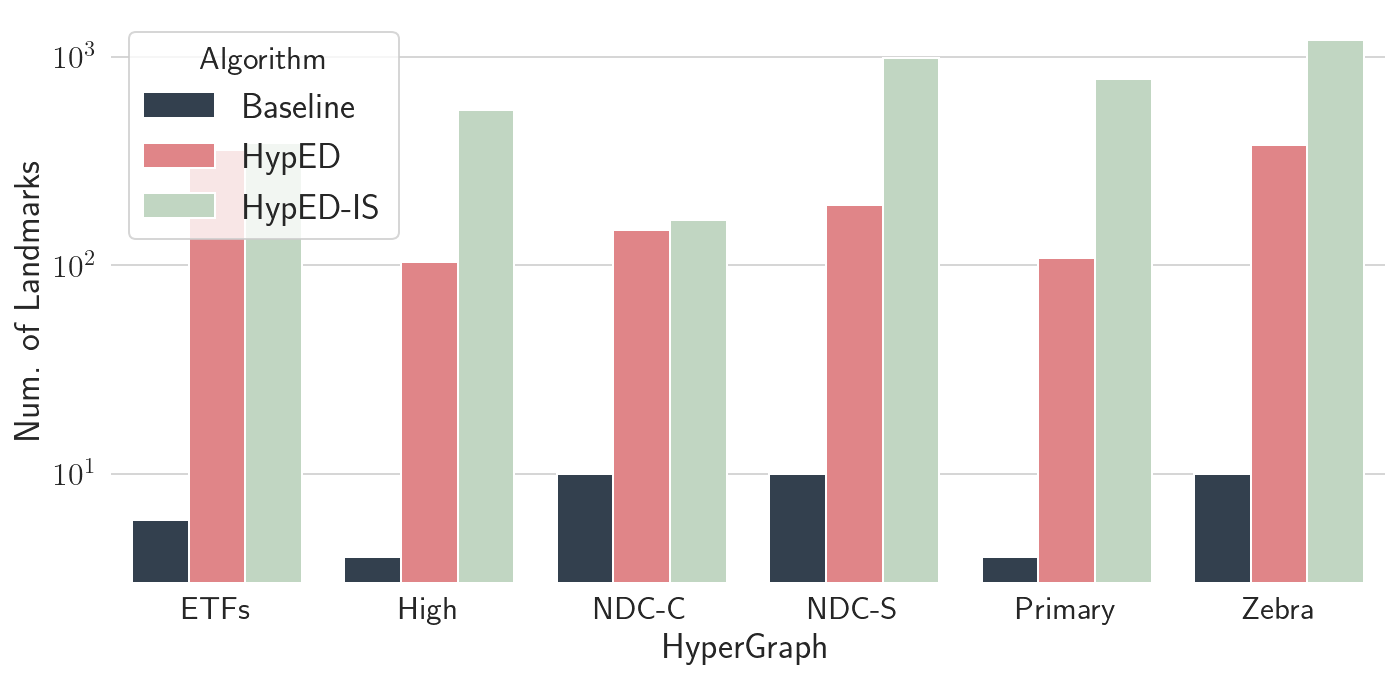

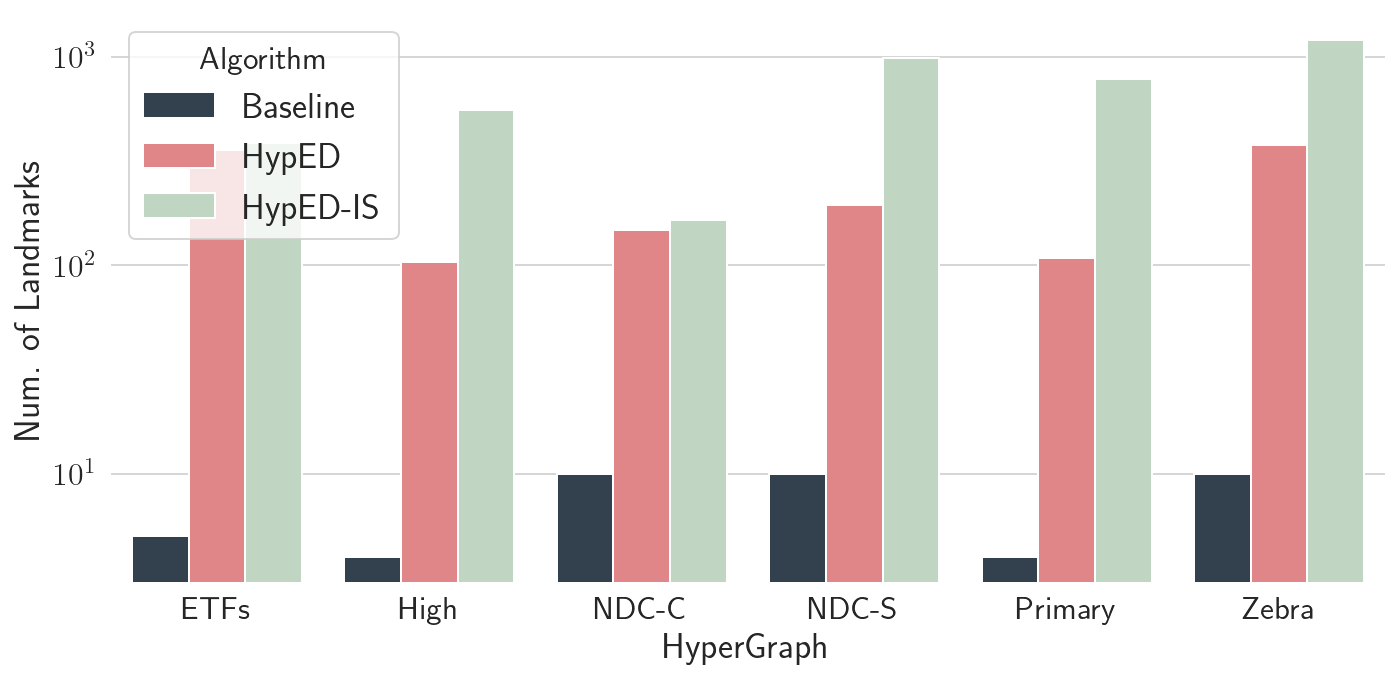

In [202]:
for strategy in agg_stats['LS'].unique():
    fig, ax = plt.subplots(figsize=(10,5))

    data = agg_stats[(agg_stats['LS']==strategy) & 
                     (agg_stats['Q']==30)].copy()
    sns.barplot(data=data, x='HyperGraph', y='meanL', 
                hue='Algorithm', palette=palette, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Num. of Landmarks')
    ax.set_xlabel('HyperGraph')
    ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_methods_num_lands_{rename_ls(strategy)}.pdf')
    plt.show()

## Comparison Landmarks

In [203]:
landmarks = pd.DataFrame()

In [204]:
path = outfile_path + 'baselines'
for run in product(graphs_prelims,
                   landmarkSel,
                   ['bas1', 'bas2', 'meth'],
                   list(range(1,tests+1))):
    graph = run[0]
    ls = run[1]
    meth = run[2]
    t = run[3]
    path2 = f'{path}/{t}'
    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    try:
        fileName = f'{graph}_LANDS_S10_L30_LB4_M{strategy}_LAprob_A{alpha}_B{beta}_ID{meth}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['Landmark', 's', 'CID', 'Size']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['Method'] = meth
        tmp['Test'] = t
        landmarks = landmarks.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

In [205]:
landmarks['Method'] = landmarks['Method'].apply(rename_method)

Percentage of landmarks for each s

In [206]:
landsXs = landmarks.groupby(by=['HyperGraph', 'LS', 'Method', 's', 'Test'])[['Landmark']].count().reset_index()

In [207]:
tmp = landsXs.groupby(by=['HyperGraph', 'LS', 'Method', 's'])[['Landmark']].mean().reset_index()
tmp2 = tmp.groupby(by=['HyperGraph', 'LS', 'Method'])[['Landmark']].sum().reset_index()
tmp2.columns = ['HyperGraph', 'LS', 'Method', 'Total']
meanLandsXs = tmp.merge(tmp2, how='left', on=['HyperGraph', 'LS', 'Method'])

In [208]:
meanLandsXs['Ratio'] = (meanLandsXs['Landmark'] / meanLandsXs['Total']) * 100

In [209]:
R = []
for g in meanLandsXs['HyperGraph'].unique():
    for ls in meanLandsXs['LS'].unique():
        for meth in meanLandsXs['Method']:
            lands = meanLandsXs.loc[(meanLandsXs['HyperGraph']==g) &
                                (meanLandsXs['LS']==ls) &
                                (meanLandsXs['Method']==meth), 'Total'].values[0]
            R.append([g, ls, meth, 'Total', lands, lands, 100])

In [210]:
tmp = pd.DataFrame(R, columns=meanLandsXs.columns)
meanLandsXs = pd.concat([meanLandsXs, tmp])

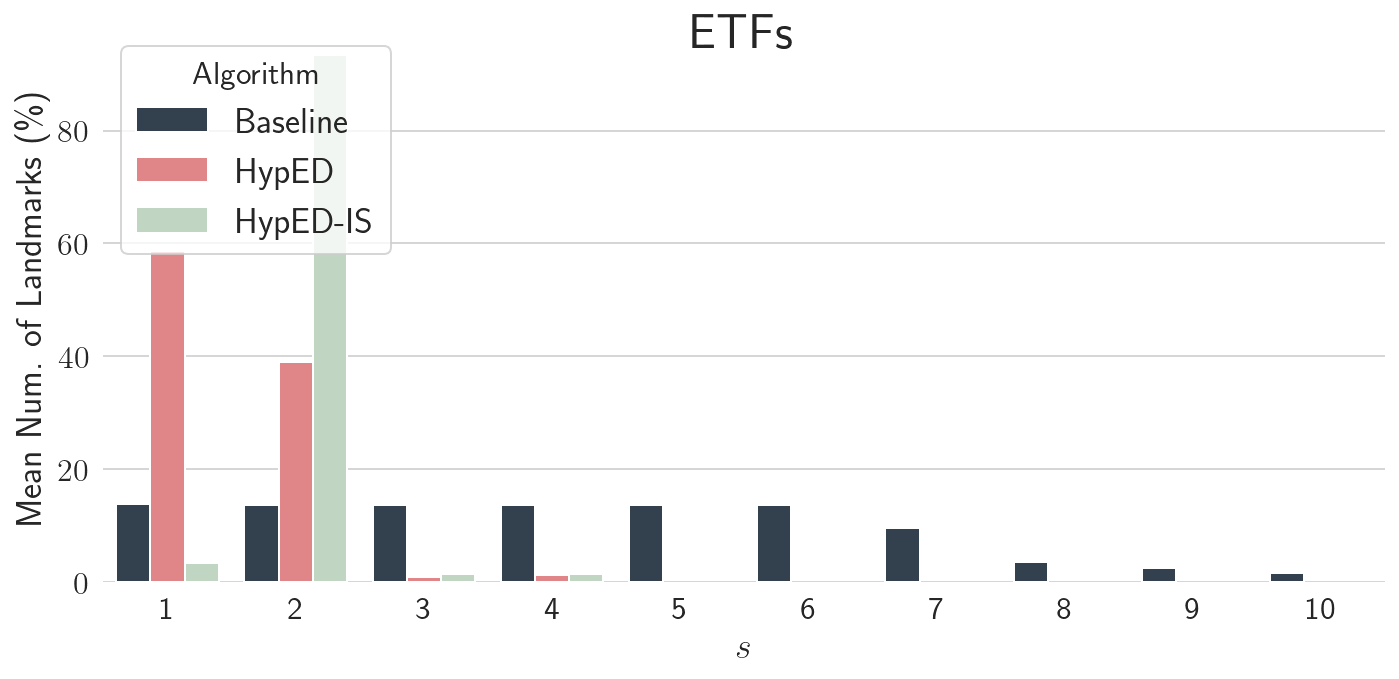

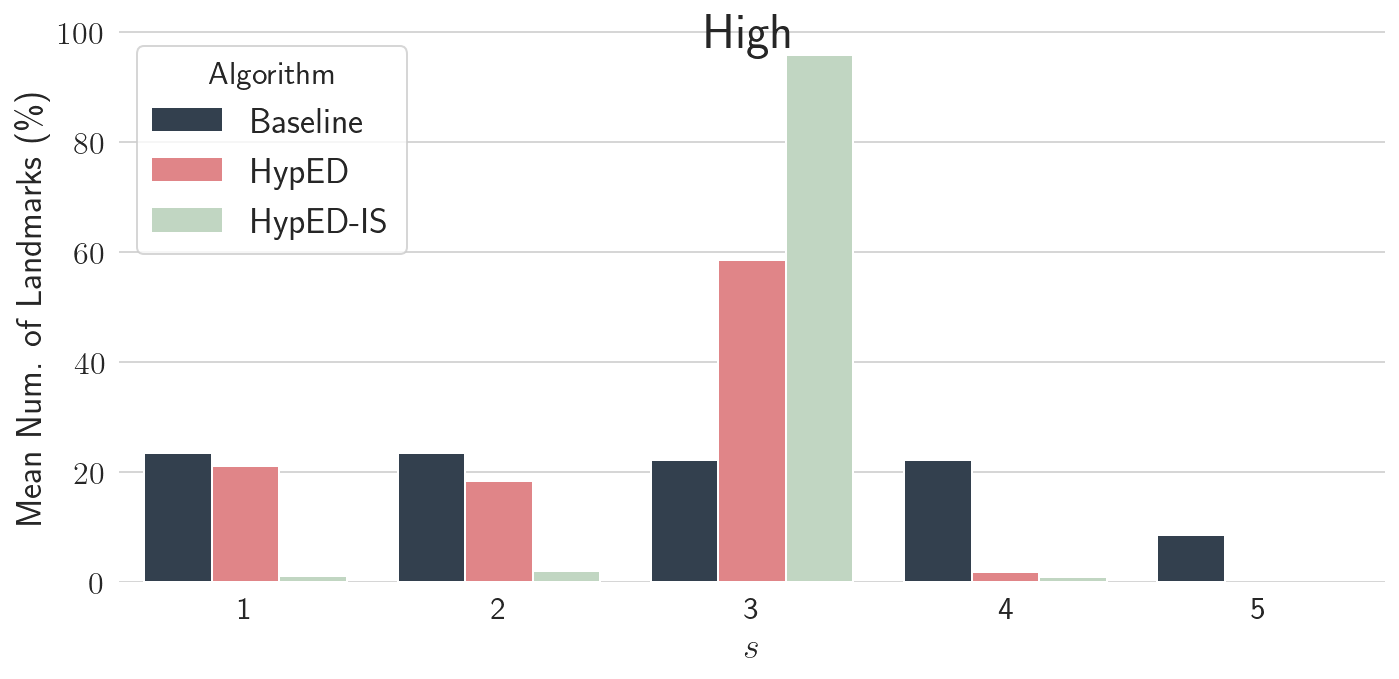

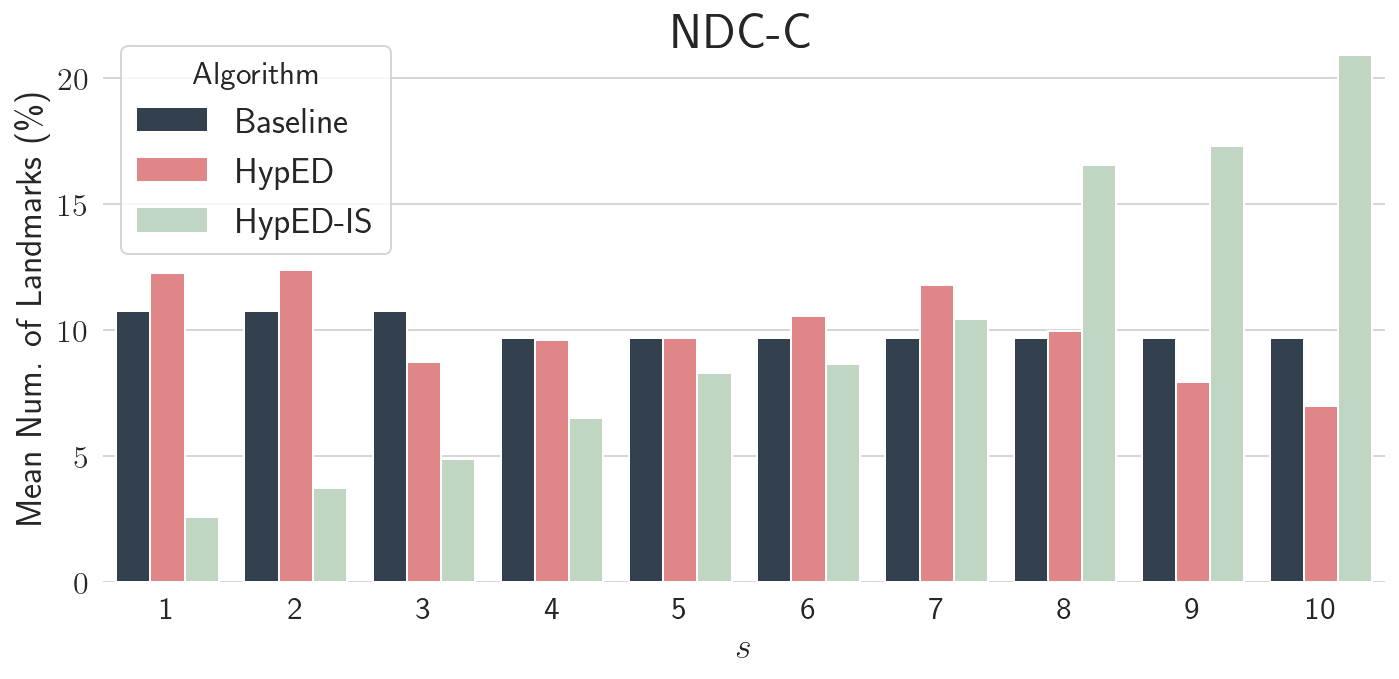

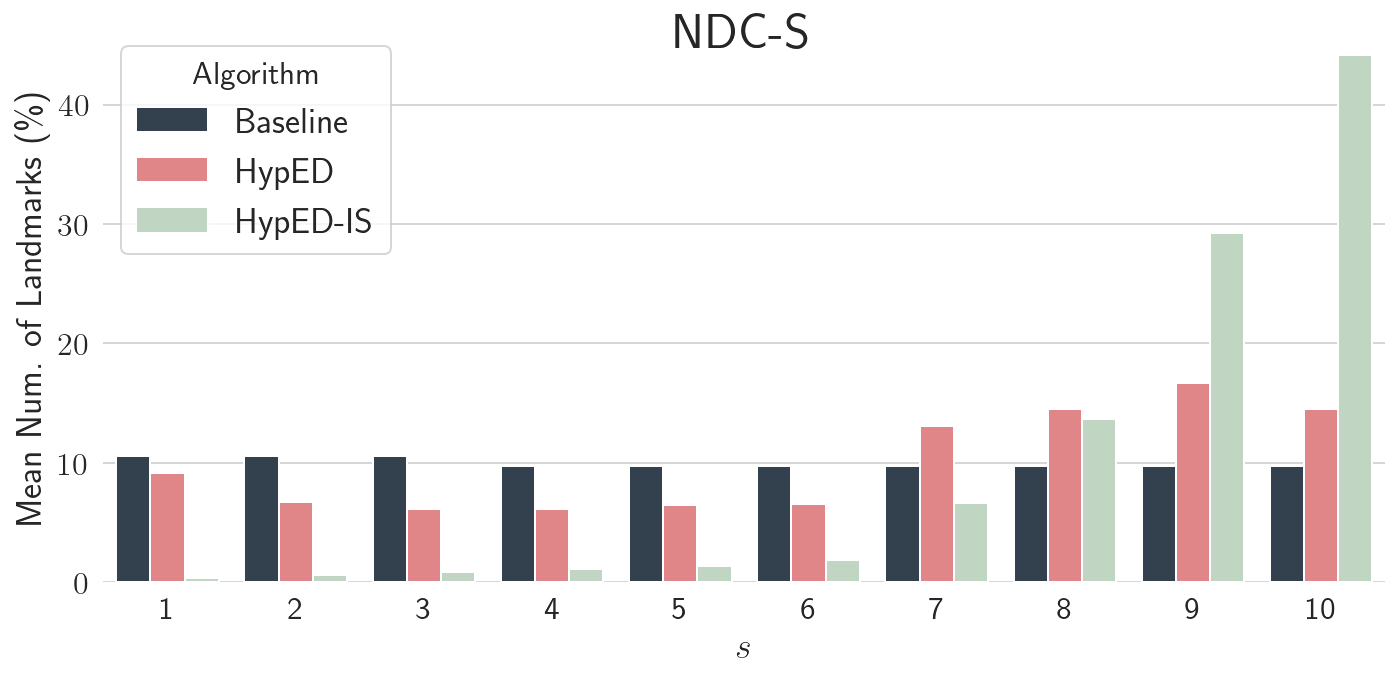

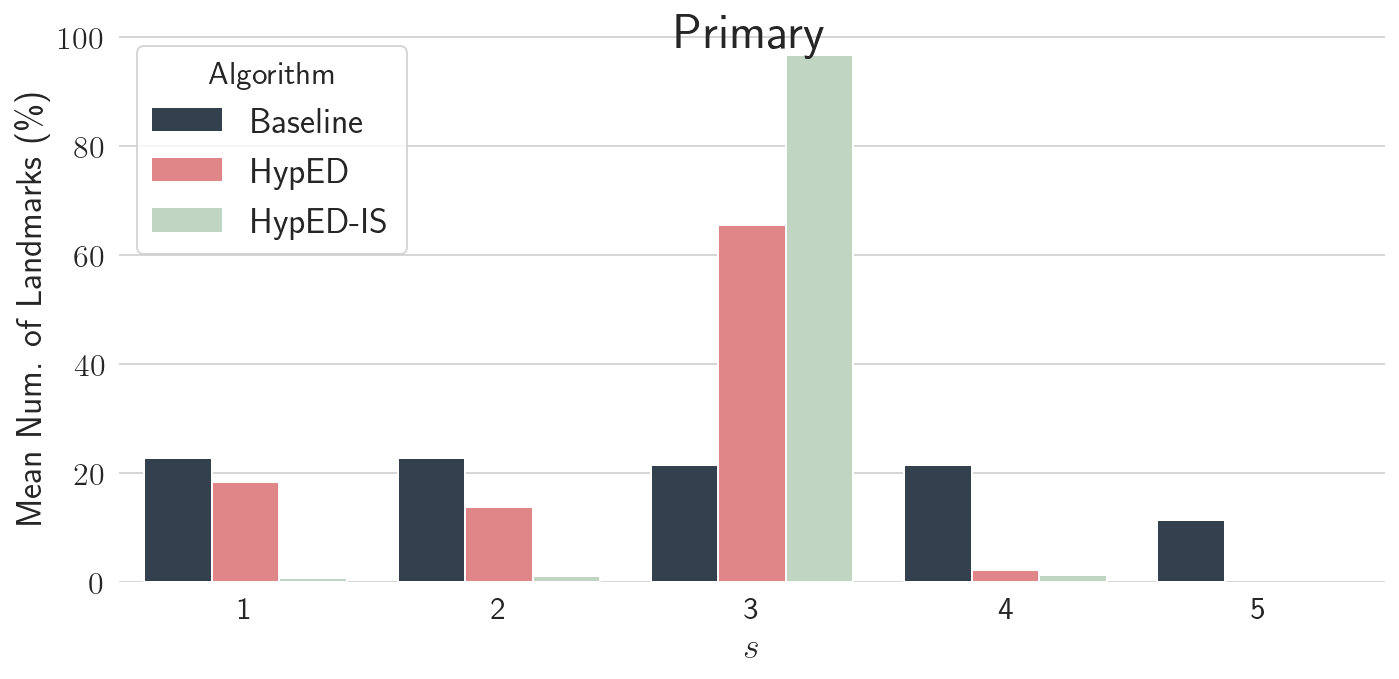

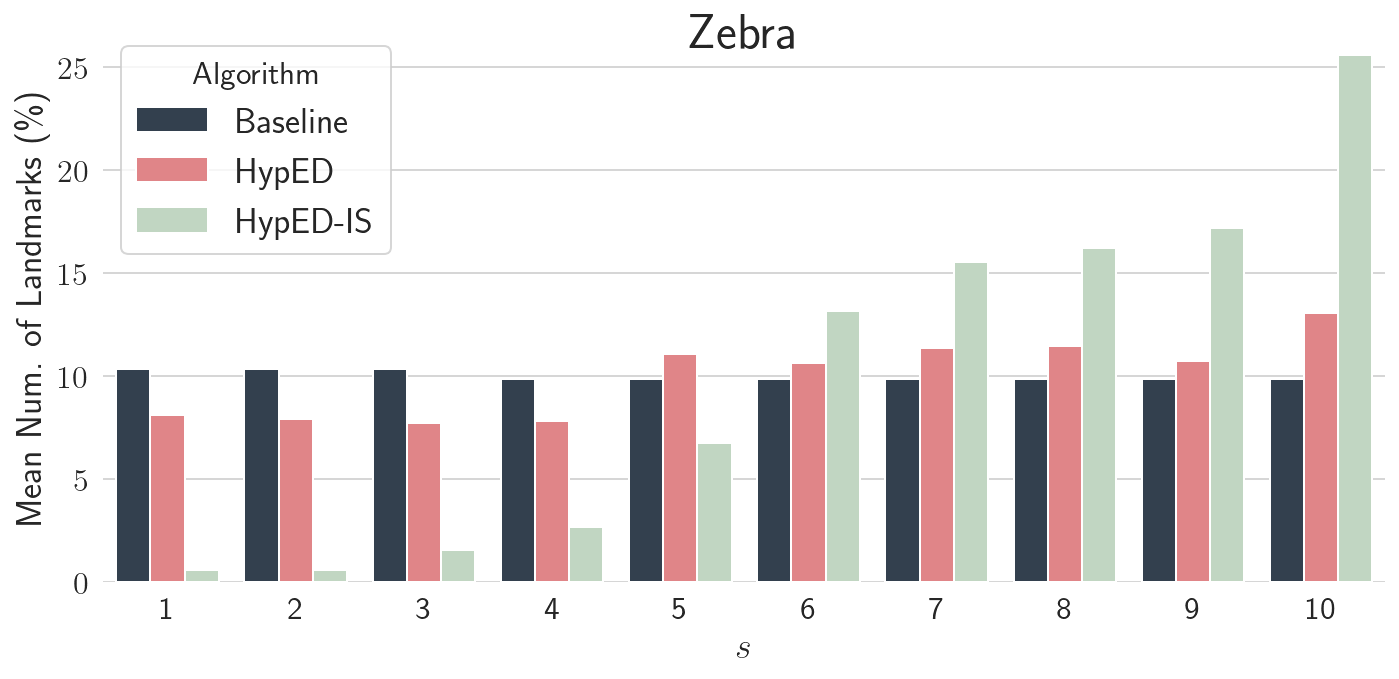

In [211]:
for graph in meanLandsXs['HyperGraph'].unique():
    fig, ax = plt.subplots(figsize=(10,5))

    data = meanLandsXs[(meanLandsXs['HyperGraph']==graph) &
                       (meanLandsXs['LS']=='Degree') &
                       (meanLandsXs['s']!='Total')].copy()
    sns.barplot(data=data, x='s', y='Ratio', hue='Method', 
                palette=palette, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Mean Num. of Landmarks (\%)')
    ax.set_xlabel(r'$s$')
    ax.legend(title='Algorithm')
    ax.set_title(graph, pad=-10, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_landmarks_{graph}.pdf')
    plt.show()

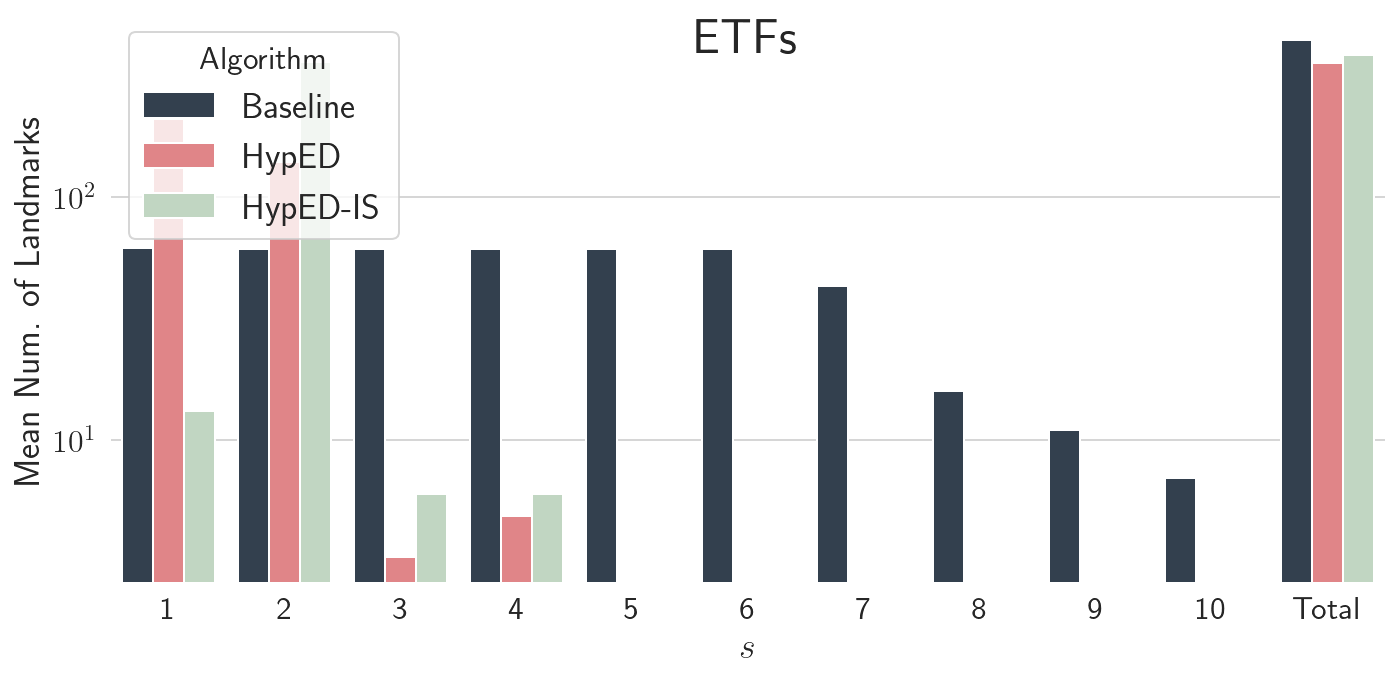

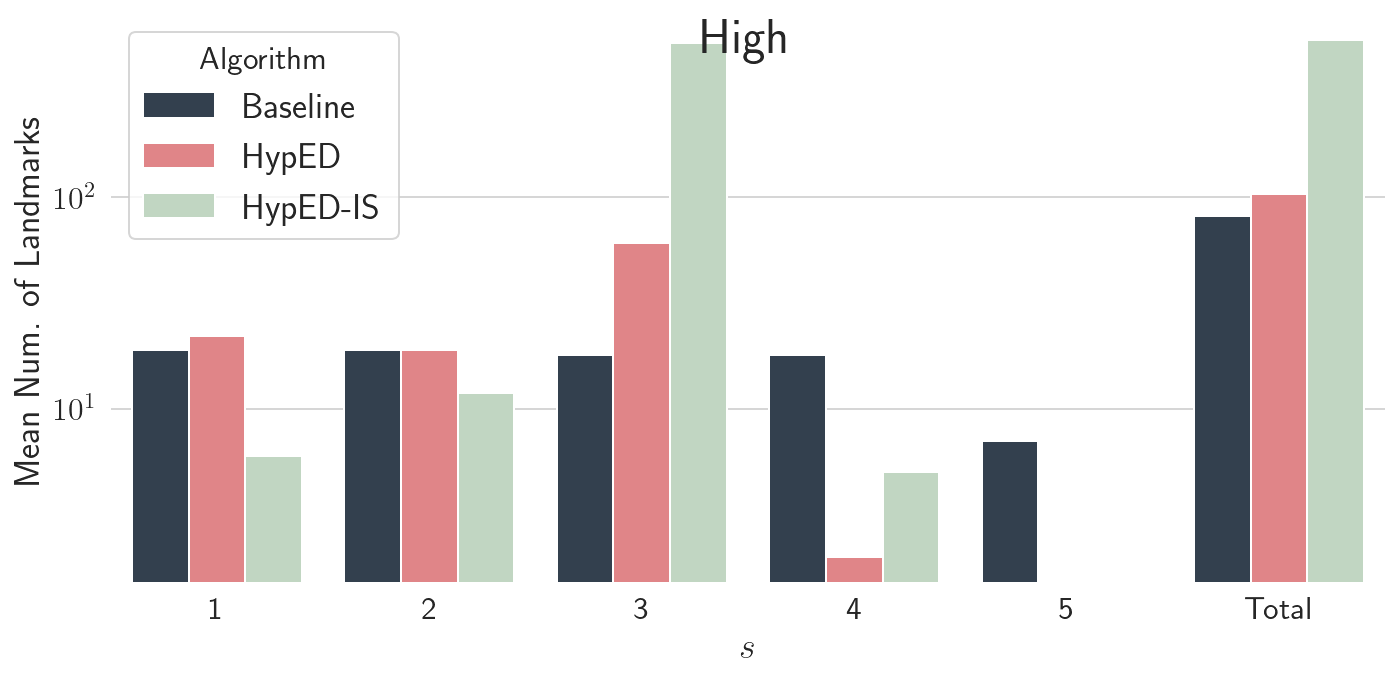

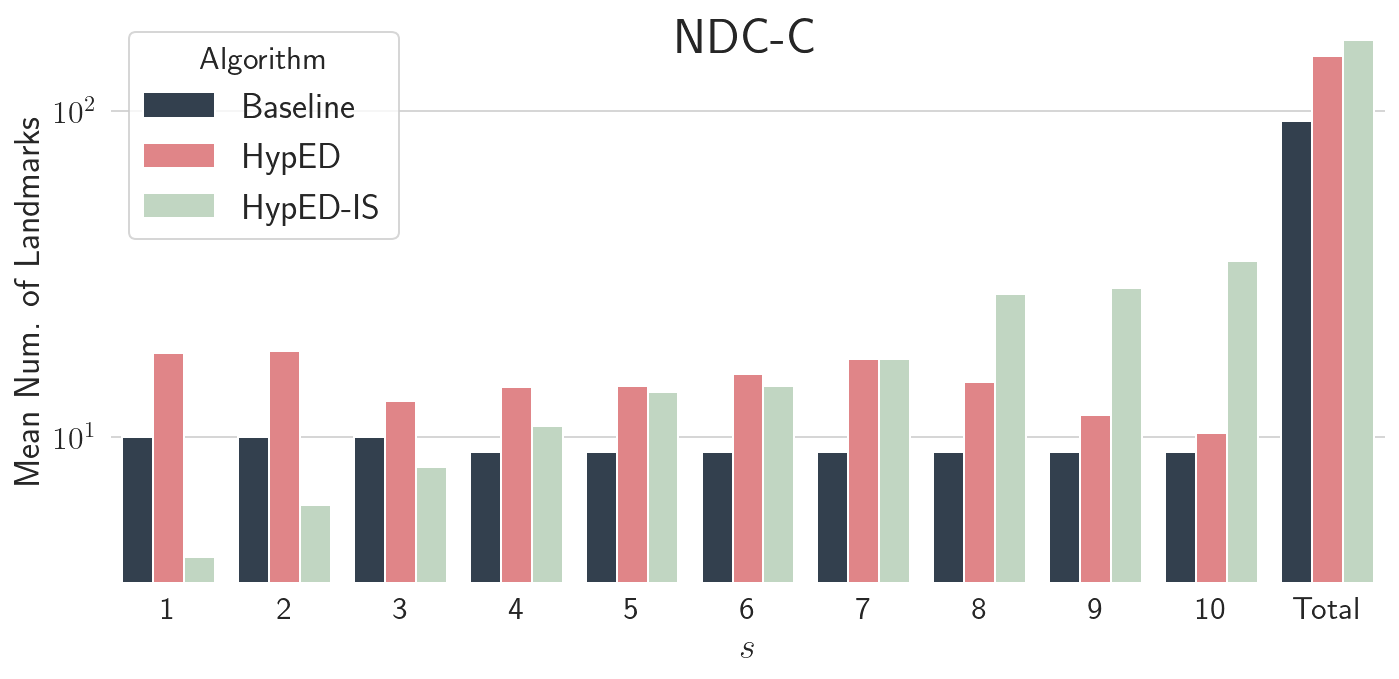

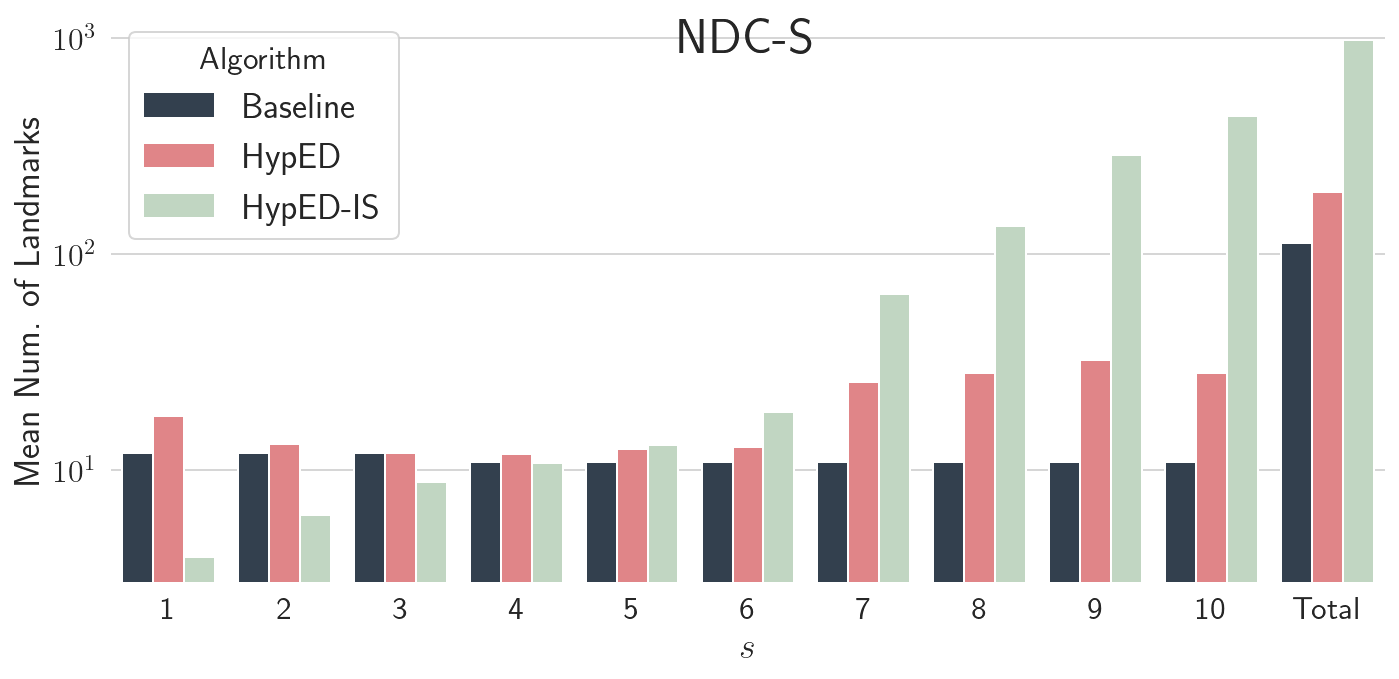

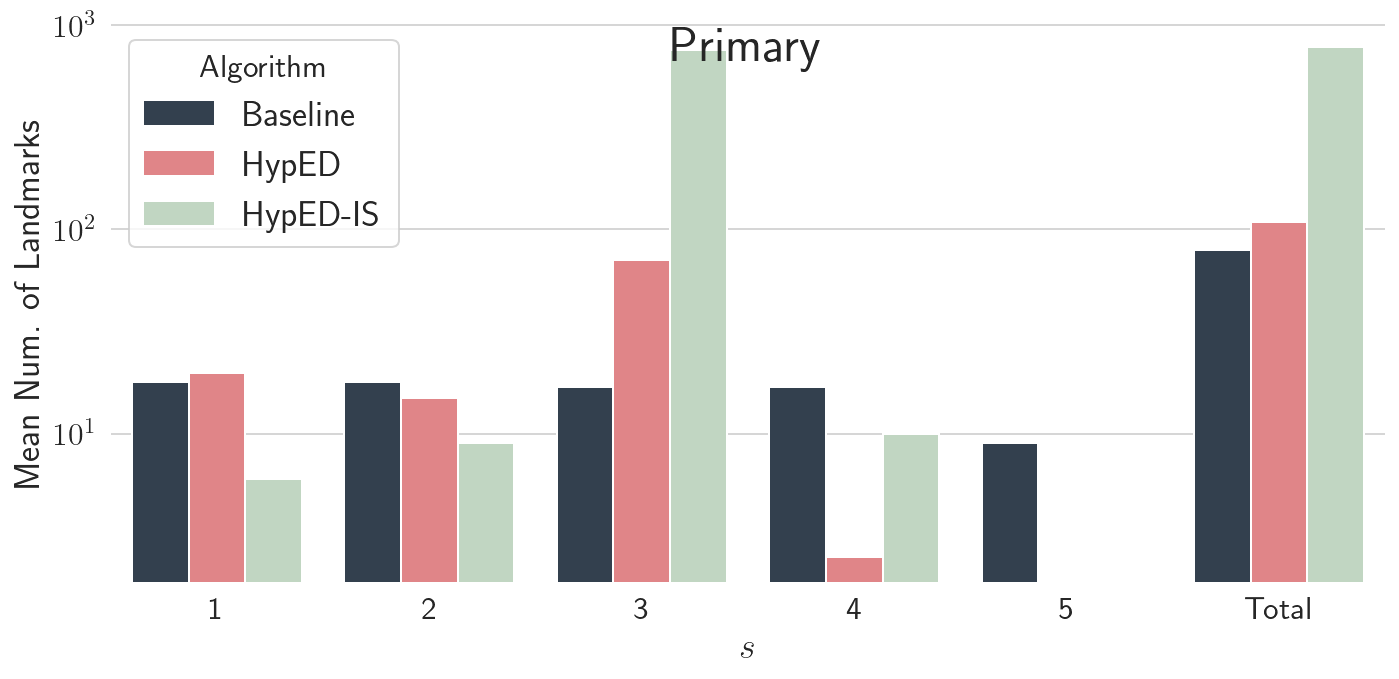

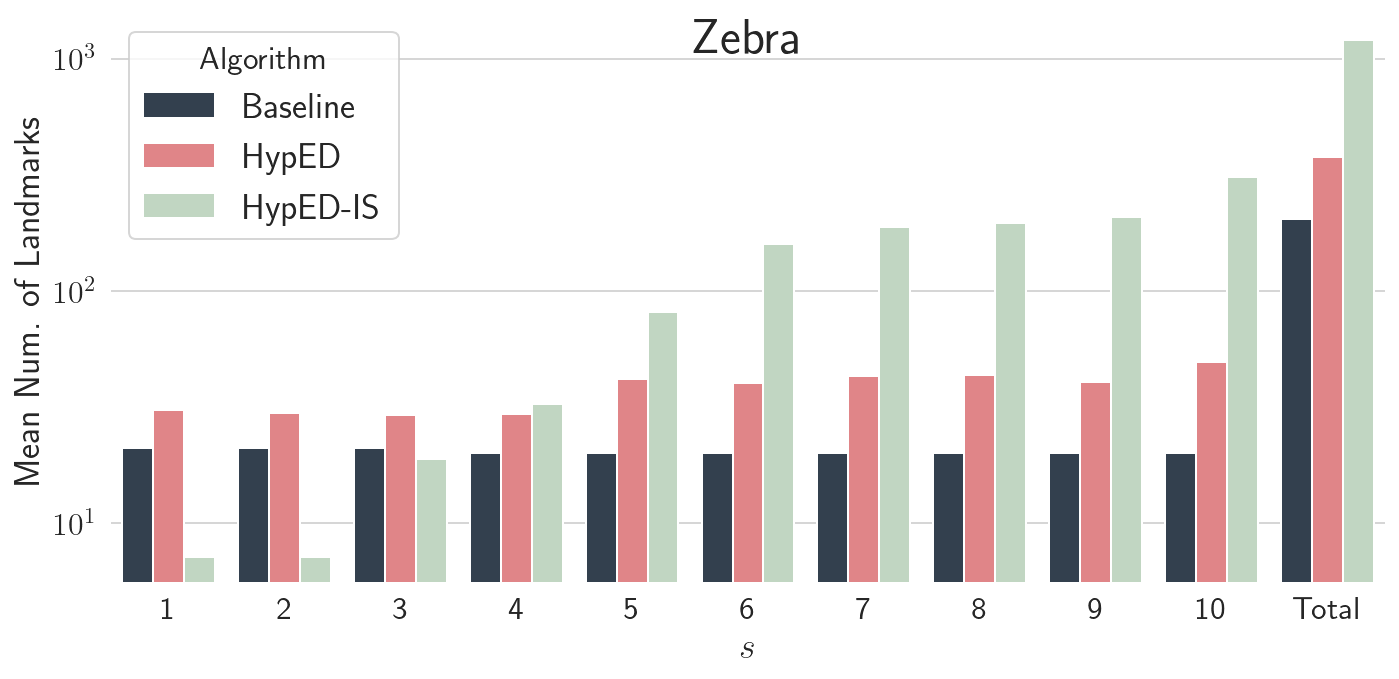

In [212]:
for graph in meanLandsXs['HyperGraph'].unique():
    fig, ax = plt.subplots(figsize=(10,5))

    data = meanLandsXs[(meanLandsXs['HyperGraph']==graph) &
                       (meanLandsXs['LS']=='Degree')].copy()
    sns.barplot(data=data, x='s', y='Landmark', hue='Method', 
                palette=palette, ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Mean Num. of Landmarks')
    ax.set_xlabel(r'$s$')
    ax.set_yscale('log')
    ax.legend(title='Algorithm')
    ax.set_title(graph, pad=-20, fontsize=25, fontweight='bold')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_num_landmarks_{graph}.pdf')
    plt.show()

Percentage of landmarks within same connected component

In [213]:
tmp = landmarks.groupby(by=['HyperGraph', 'LS', 'Method', 's', 'CID', 'Test'])[['Landmark']].count().reset_index()
tmp2 = tmp.groupby(by=['HyperGraph', 'LS', 'Method', 's', 'CID'])[['Landmark']].mean().reset_index()
tmp3 = tmp2.groupby(by=['HyperGraph', 'LS', 'Method'])[['Landmark']].sum().reset_index()
tmp3.columns = ['HyperGraph', 'LS', 'Method', 'Total']
meanLandsXCC = tmp2.merge(tmp3, how='left', on=['HyperGraph', 'LS', 'Method'])
meanLandsXCC['CC'] = meanLandsXCC['s'].apply(str) + "-" + meanLandsXCC['CID'].apply(str)

In [214]:
meanLandsXCC['Ratio'] = (meanLandsXCC['Landmark'] / meanLandsXCC['Total']) * 100

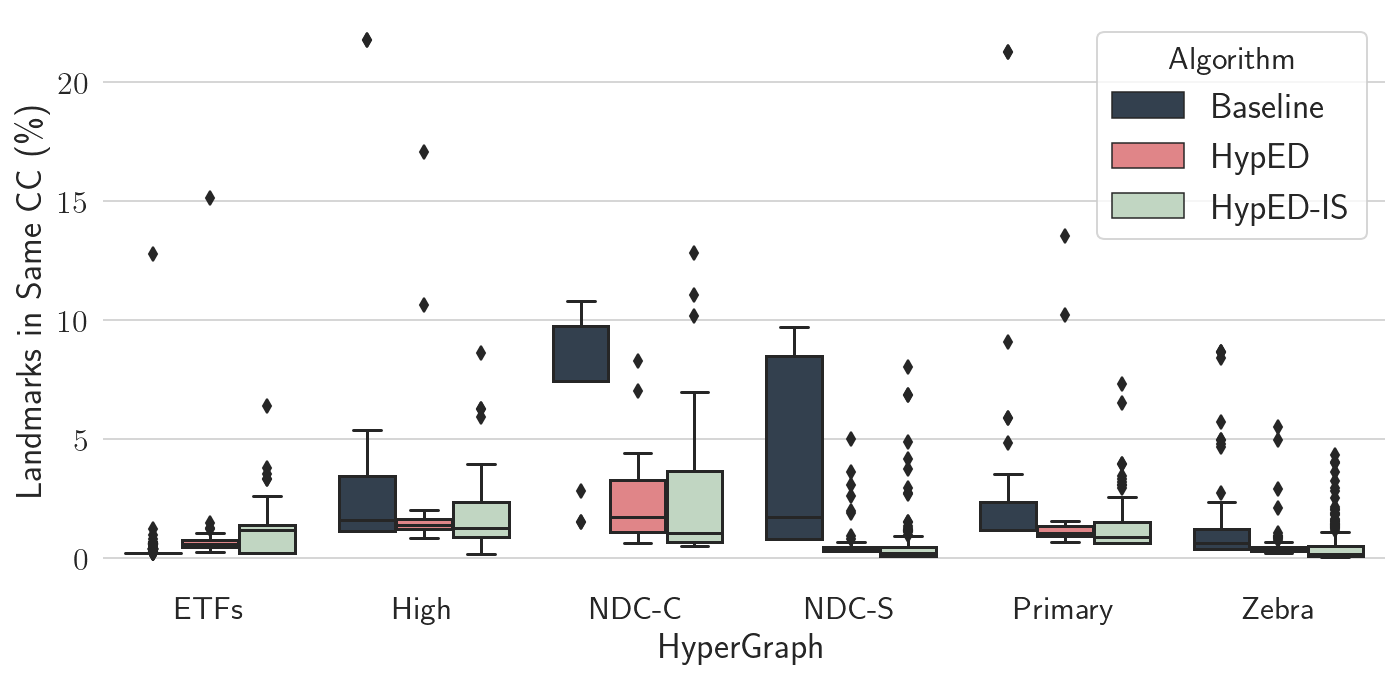

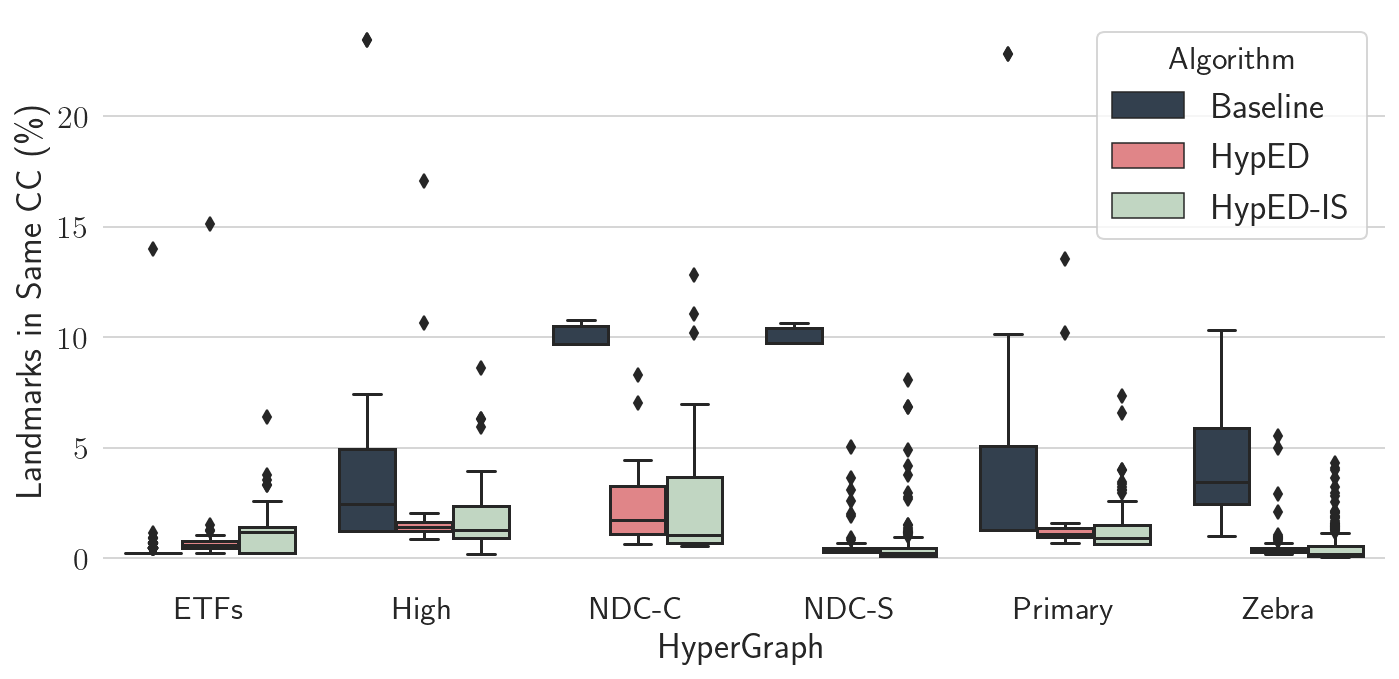

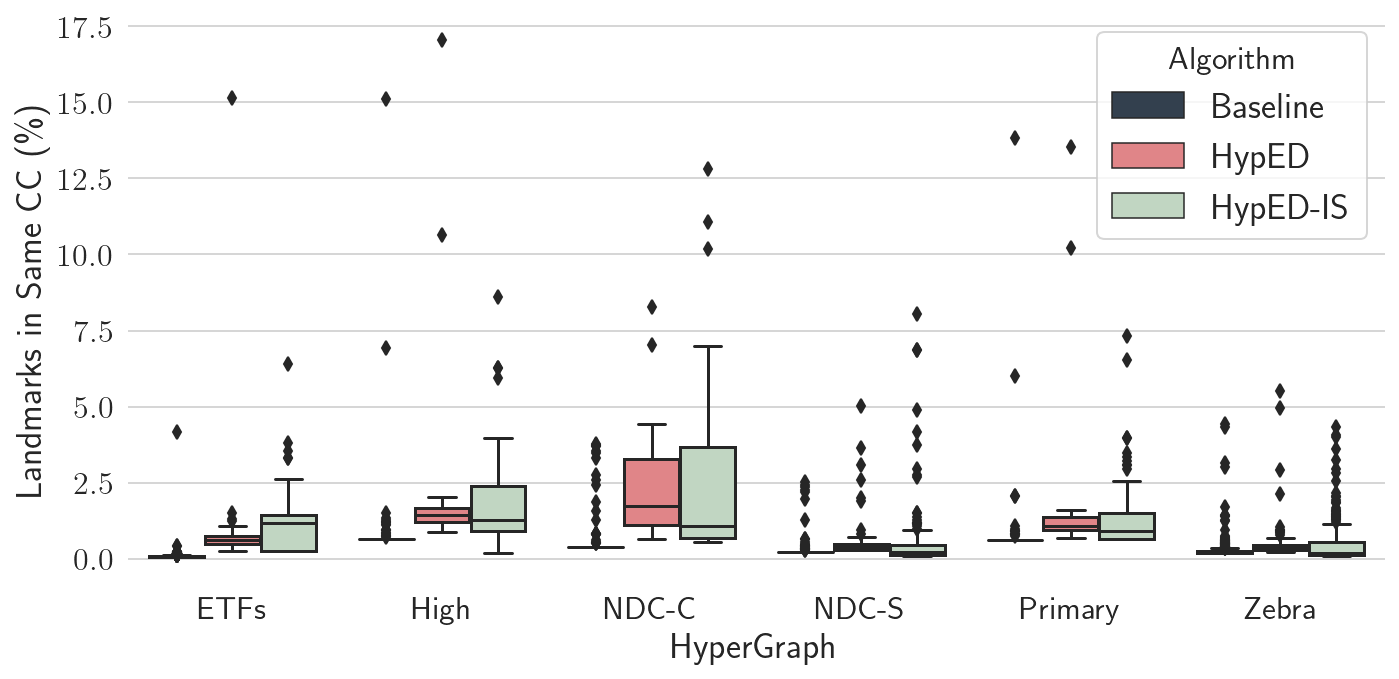

In [215]:
for strategy in meanLandsXCC['LS'].unique():
    fig, ax = plt.subplots(figsize=(10,5))

    data = meanLandsXCC[meanLandsXCC['LS']==strategy].copy()
    num_methods = len(data['Method'].unique())
    sns.boxplot(data=data, x='HyperGraph', y='Ratio', hue='Method', 
                palette=palette[:num_methods], ax=ax)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(title='Algorithm')
    ax.set_ylabel('Landmarks in Same CC (\%)')
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_landmarksInCC_{strategy}.pdf')
    plt.show()

## Comparison Accuracy

### Stats Real Distances

In [216]:
sampled_pairs = acc_la.groupby(by=['HyperGraph', 
                                   'src', 
                                   'dst', 
                                   's', 
                                   'd',
                                   'QuerySample']).count().reset_index()

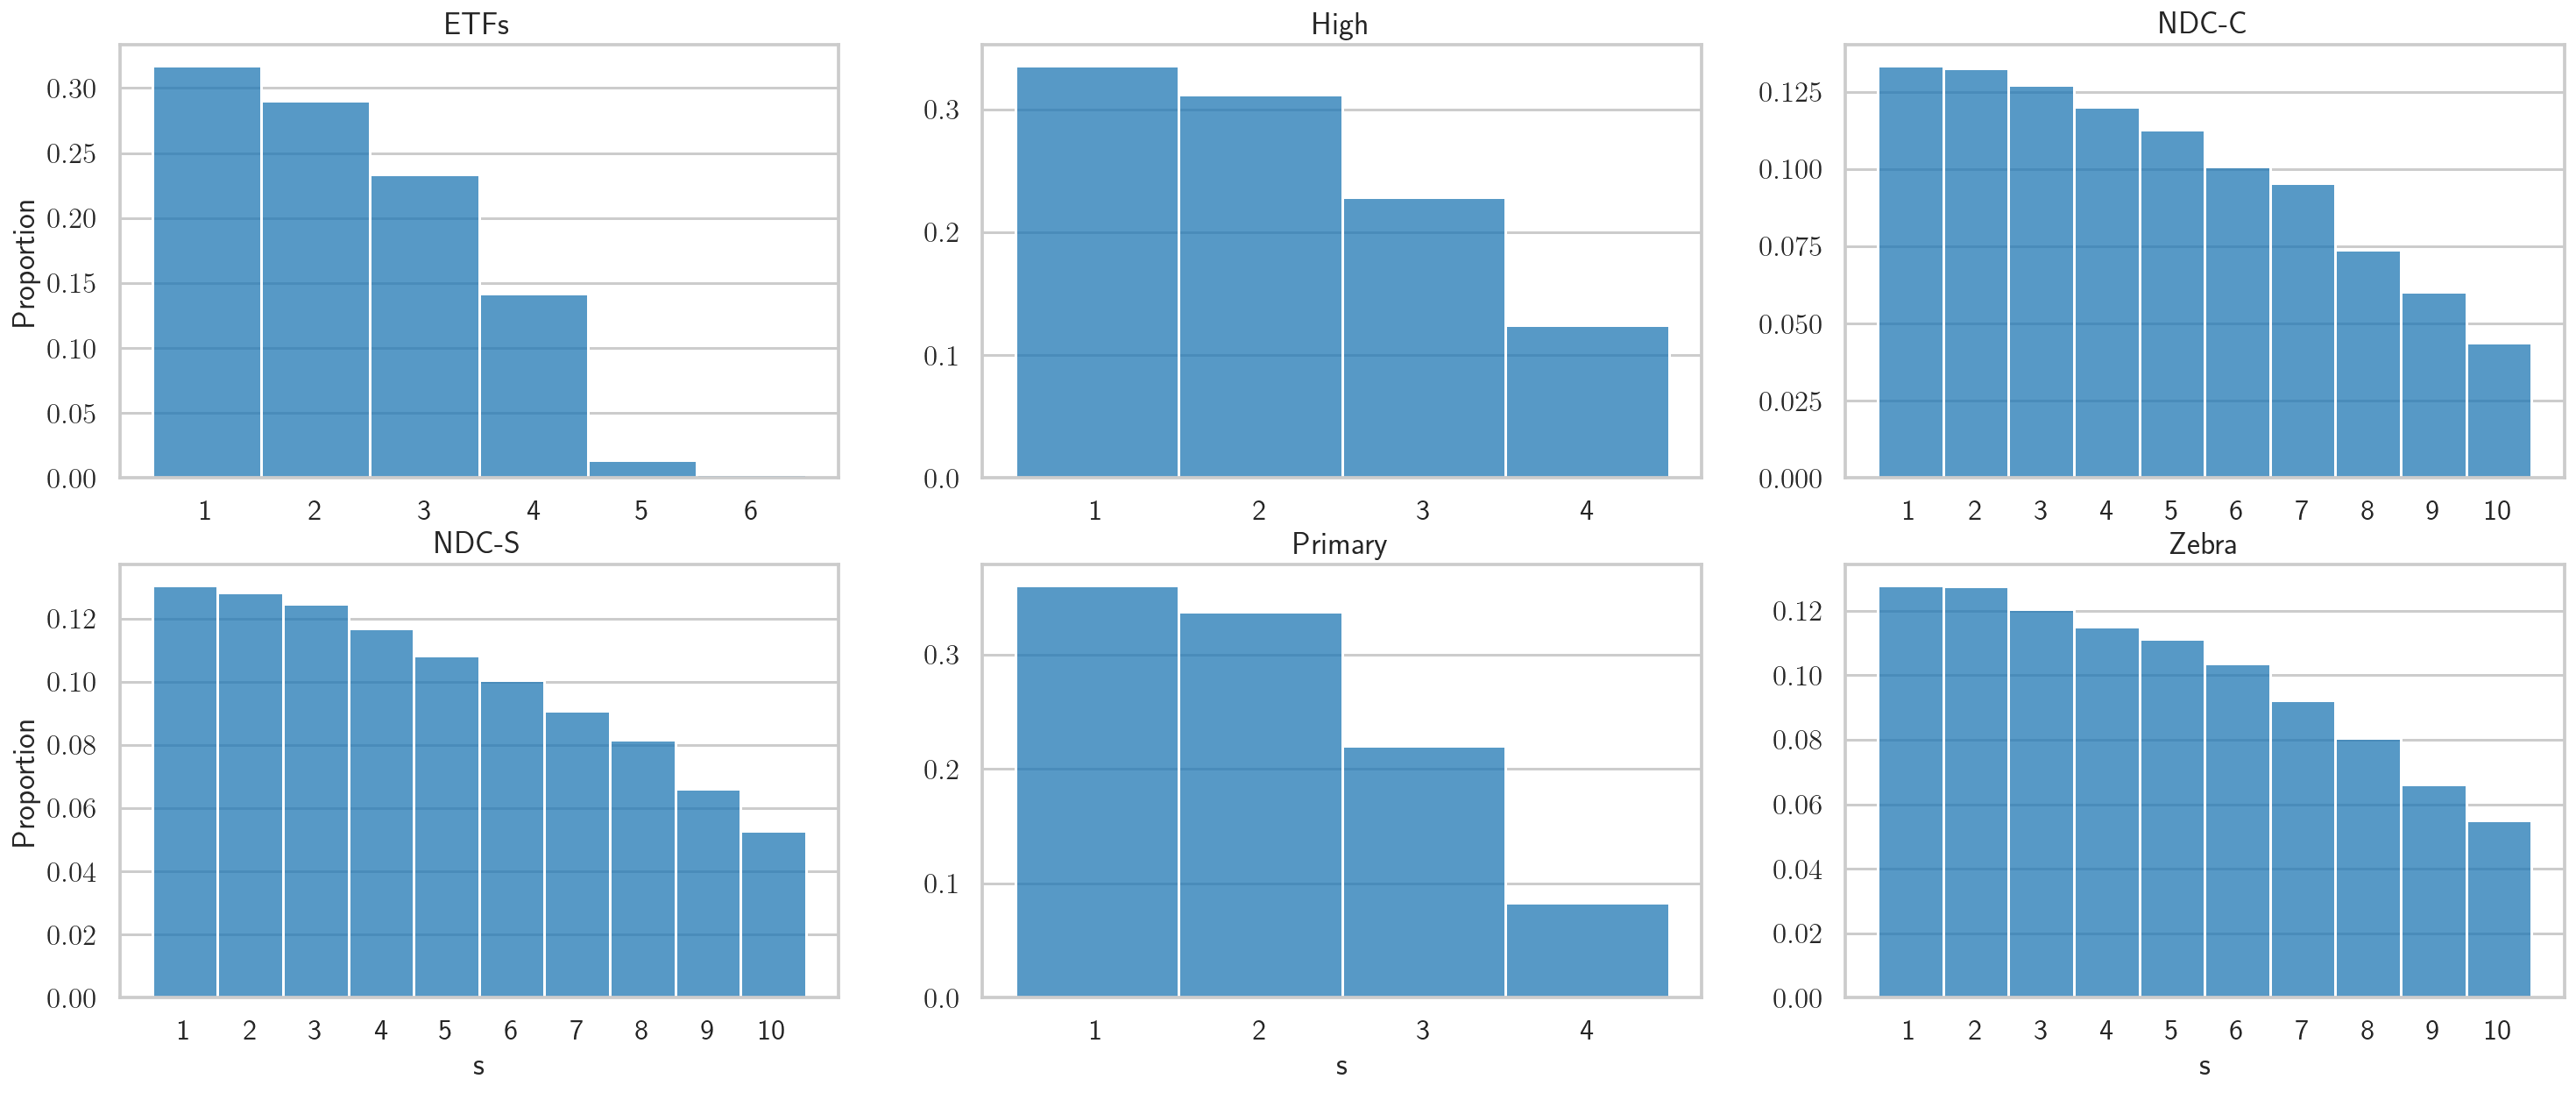

In [73]:
fig, ax = plt.subplots(2,3,figsize=(25,10))
for idx,graph in enumerate(sampled_pairs['HyperGraph'].unique()):
    data = sampled_pairs[sampled_pairs['HyperGraph']==graph]
    labels = sorted([int(x) for x in data['s'].unique()])
    p_x = idx // 3 
    p_y = idx % 3
    
    sns.histplot(data=data, x='s', palette=palette, ax=ax[p_x][p_y],
                 stat='probability', discrete=True)
    ax[p_x][p_y].set_xticks(labels)
    ax[p_x][p_y].set_xticklabels(labels)
    if p_y == 0:
        ax[p_x][p_y].set_ylabel('Proportion')
    else:
        ax[p_x][p_y].set_ylabel('')
    if p_x == 0:
        ax[p_x][p_y].set_xlabel('')
    ax[p_x][p_y].set_title(graph)
plt.show()

### Infinite Estimates

In [218]:
inf_est = acc_la.copy()
inf_est['Inf'] = inf_est['d_hat'] == -1
inf_est = inf_est.groupby(by=['HyperGraph', 
                              'LS', 
                              'Algorithm']).agg({'Inf' : ['count', 'sum']}).reset_index()

In [219]:
inf_est.columns = inf_est.columns.droplevel(0)
inf_est.columns = ['HyperGraph', 'LS', 'Algorithm', 'Total', 'Inf']
inf_est['Inf (%)'] = (inf_est['Inf'] / inf_est['Total']) * 100

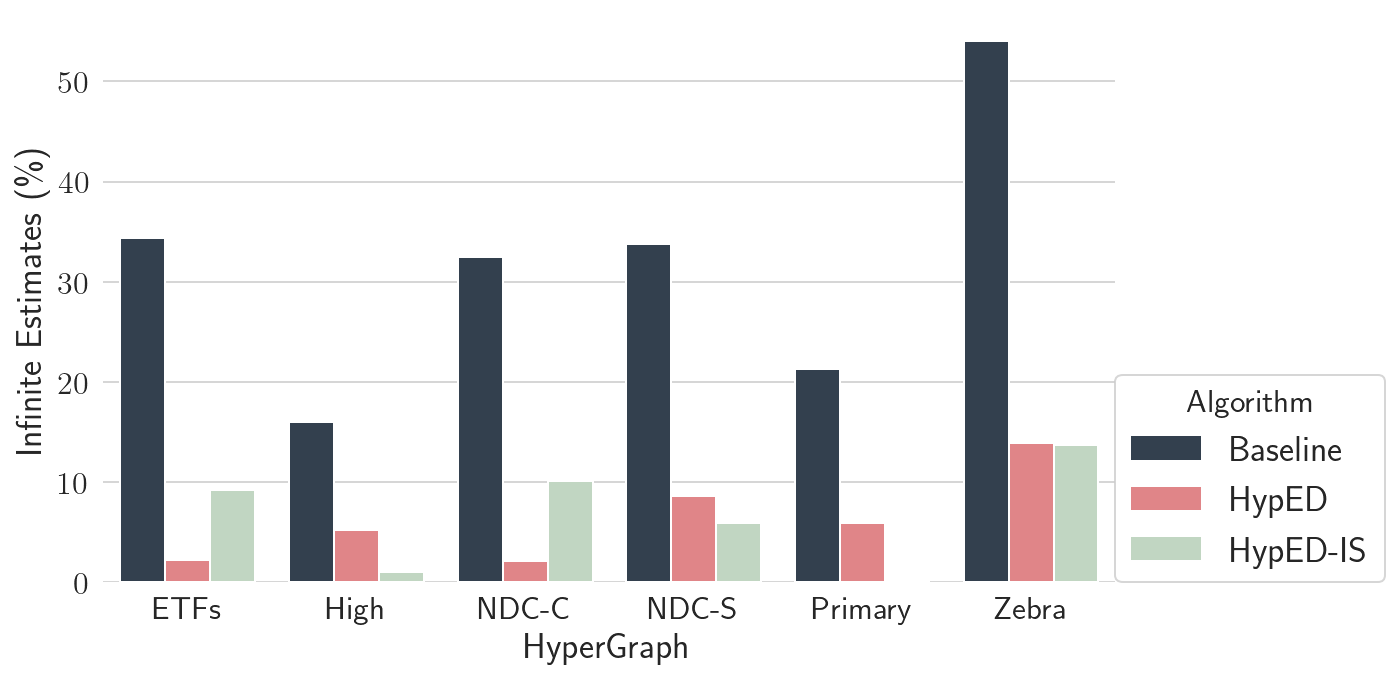

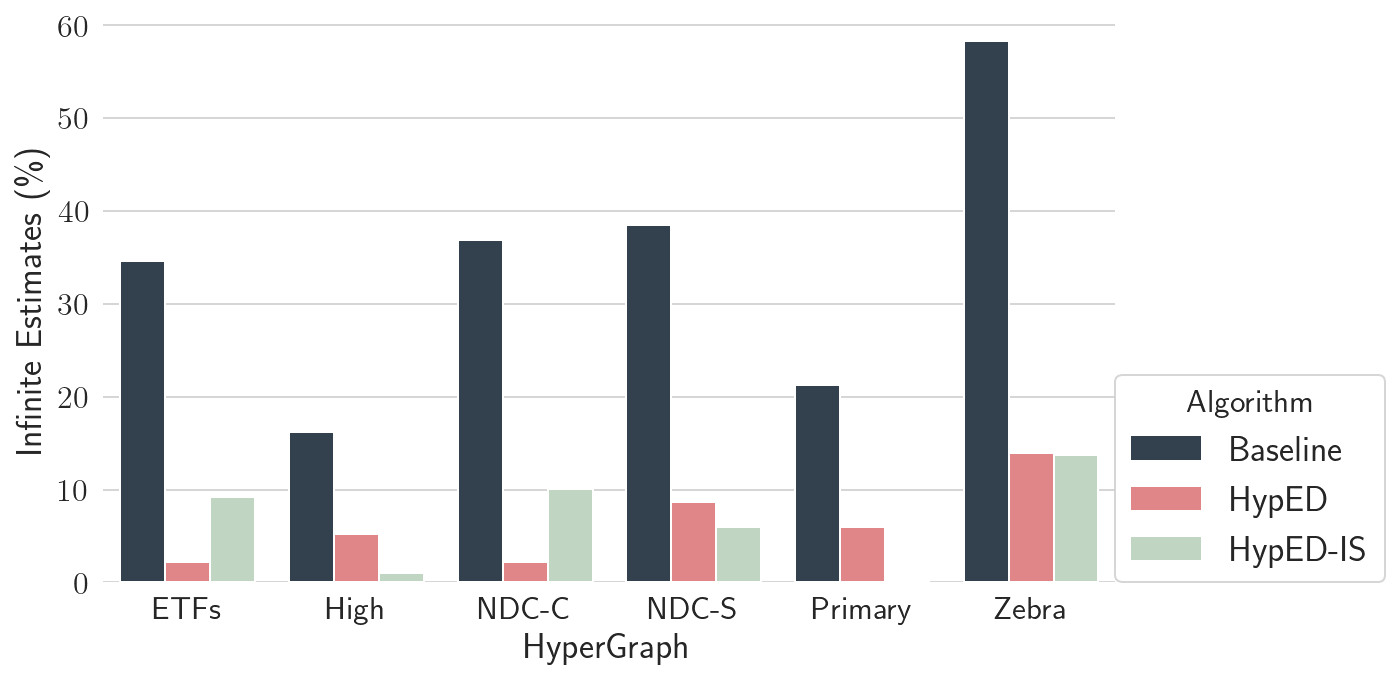

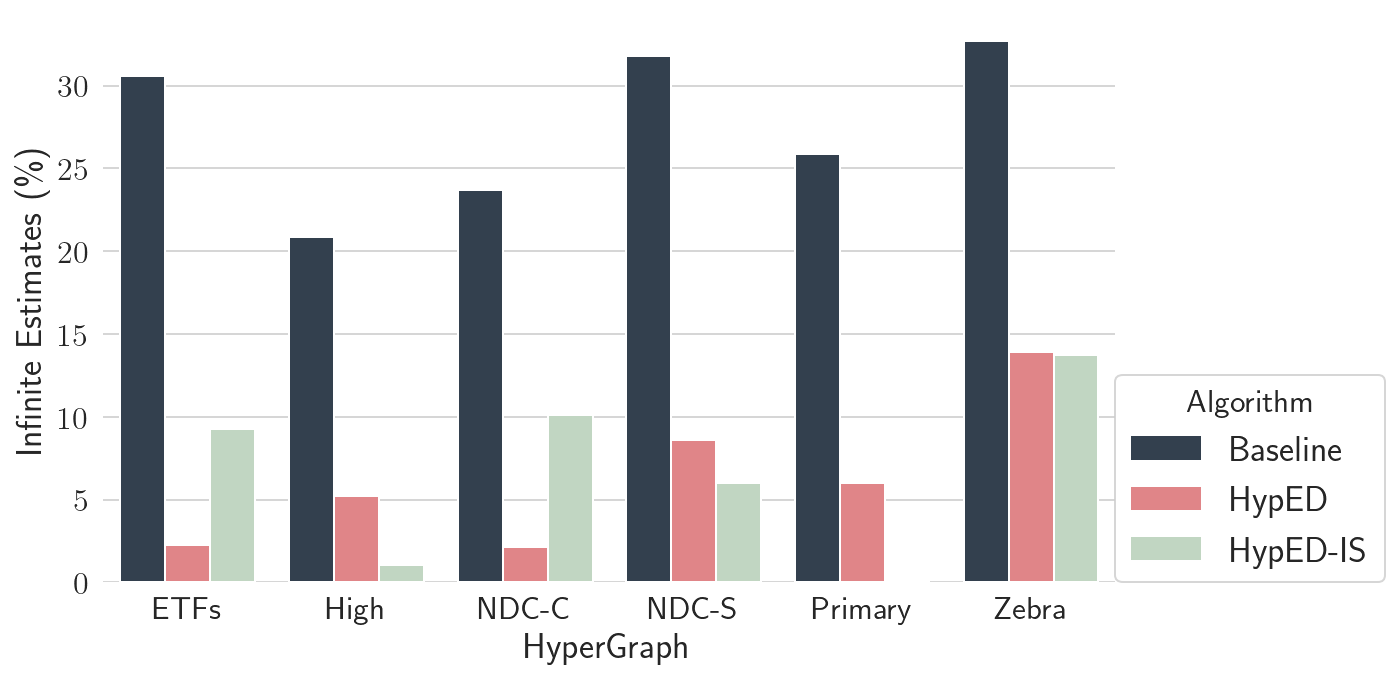

In [220]:
for strat in inf_est['LS'].unique():
    data = inf_est[inf_est['LS']==strat]

    fig, ax = plt.subplots(figsize=(10,5))
    sns.barplot(data=data, x='HyperGraph', y='Inf (%)', hue='Algorithm', palette=palette)
    ax.set_ylabel('Infinite Estimates (\%)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(title='Algorithm', loc=(1,0))
    plt.tight_layout()
    plt.show()

### L1-norm for all estimates

In [221]:
all_est = acc_la.copy()
all_est['norm1'] = all_est['d_hat'] - all_est['d']
all_est['norm1'] = all_est['norm1'].apply(abs)
max_norm = all_est['norm1'].max()
all_est.loc[all_est['d_hat']==-1, 'norm1'] = max_norm * 1.5

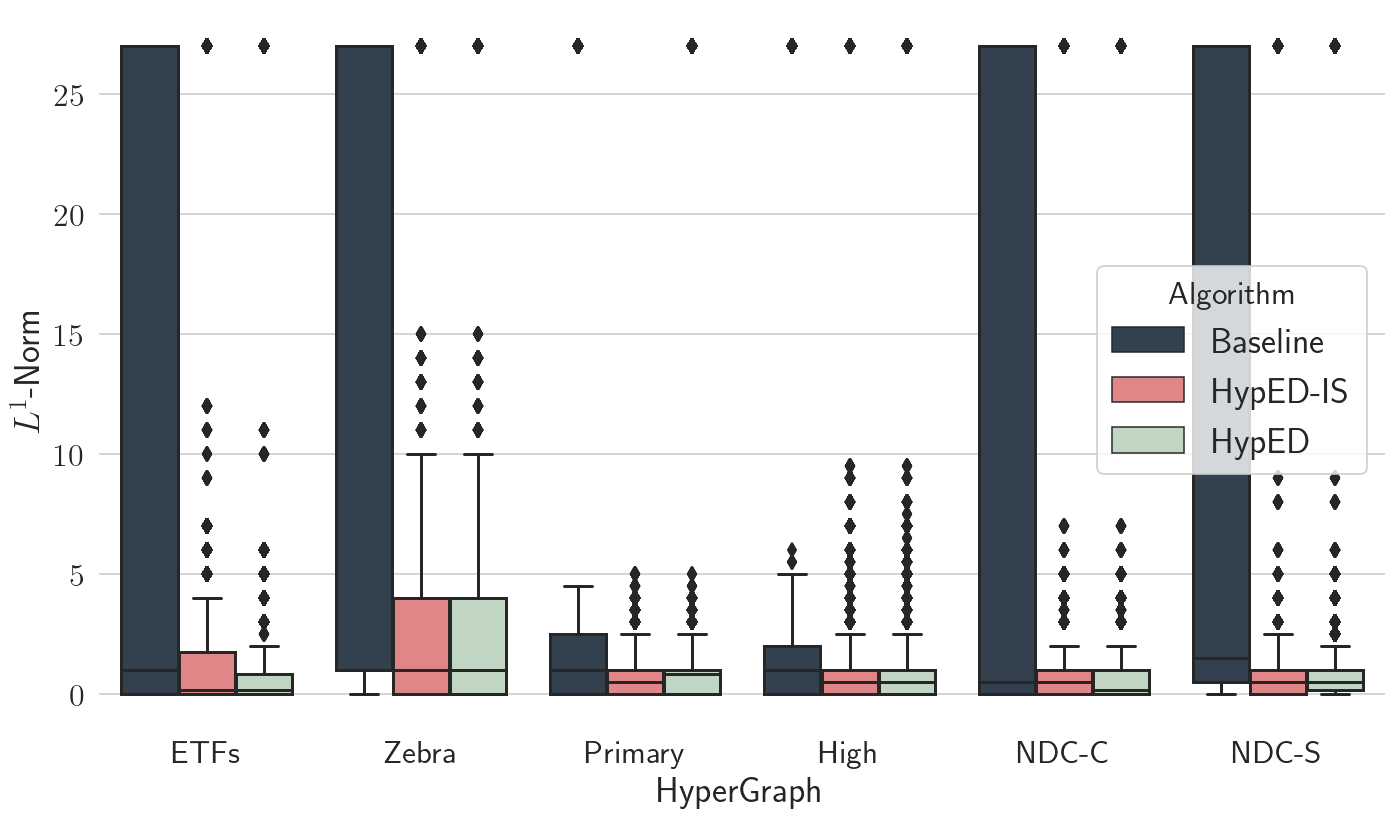

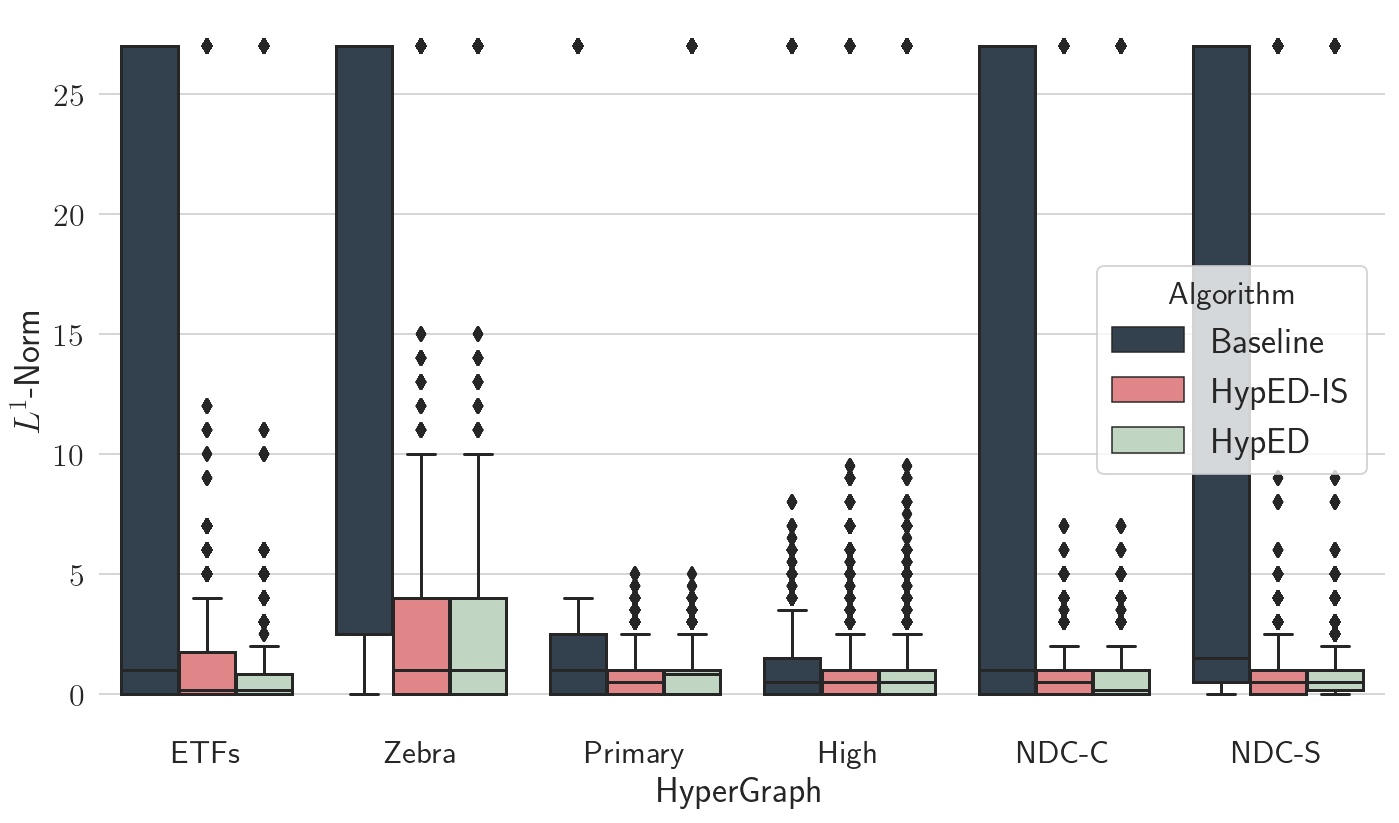

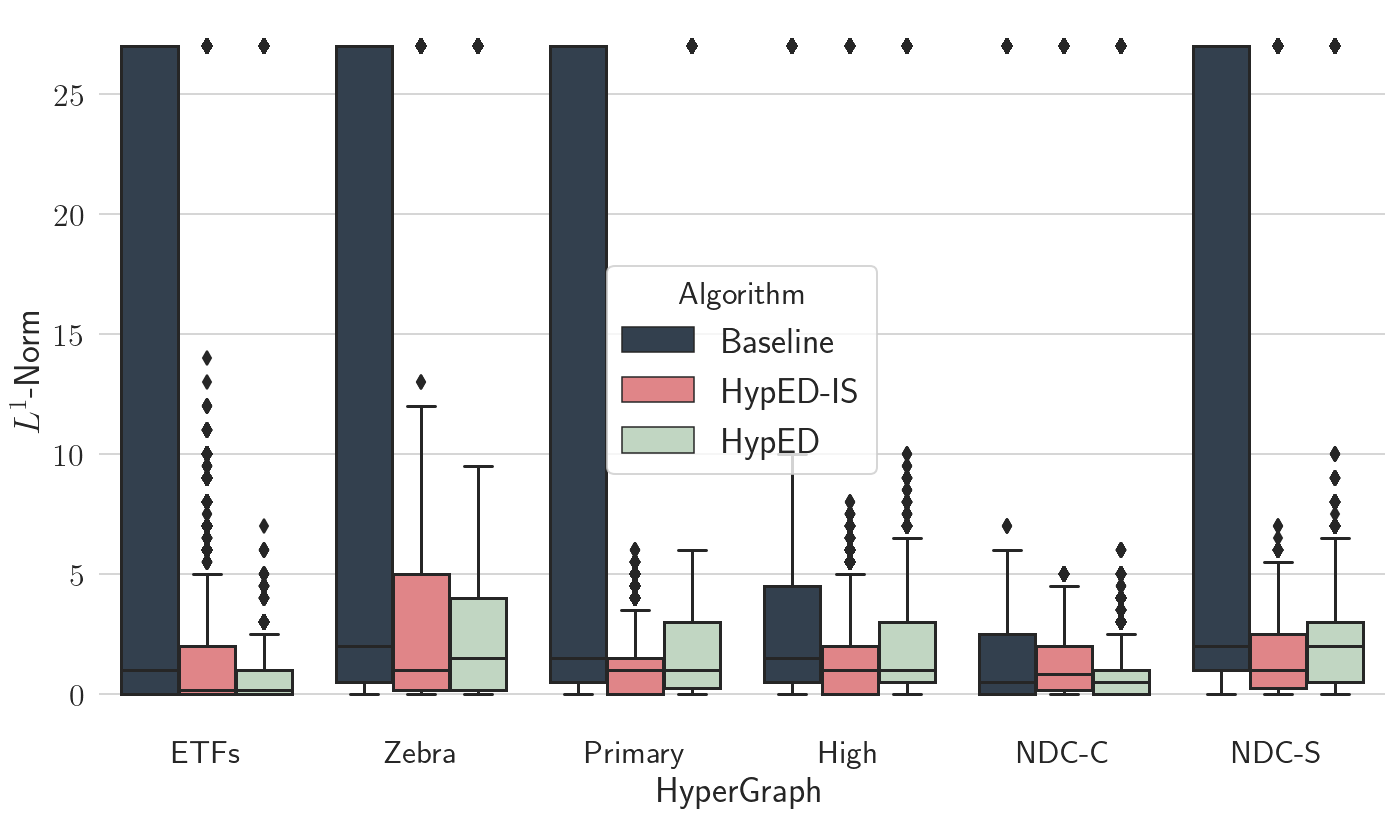

In [222]:
for strat in all_est['LS'].unique():
    data = all_est[all_est['LS']==strat].copy()
    fig, ax = plt.subplots(figsize=(10,6))
    sns.boxplot(data=data, x='HyperGraph', y='norm1', 
                hue='Algorithm', dodge=True, palette=palette, ax=ax)
    ax.set_ylabel(r'$L^1$-Norm')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(fig_path+f'comparison_methods_norm_{strat}.pdf')
    plt.show()

### MAE

In [223]:
all_est = acc_la.groupby(by=['HyperGraph', 
                             'src', 
                             'dst', 
                             's', 
                             'd',
                             'LS',
                             'Algorithm']).agg({'d_hat':'mean'}).reset_index()

In [224]:
accuracies = []
for ls in all_est['LS'].unique():
    for m in all_est['Algorithm'].unique():
        df = all_est[(all_est['LS']==ls) &
                     (all_est['Algorithm']==m)]
        for g in df['HyperGraph'].unique():
            df2 = df[df['HyperGraph']==g]
            y_true = df2['d'].values
            y_pred = df2['d_hat'].values
            mae = mean_absolute_error(y_true, y_pred)
            rmse = mean_squared_error(y_true, y_pred, squared=False)
            accuracies.append([g, ls, m, mae, rmse])

In [225]:
acc_df = pd.DataFrame(accuracies, columns=['HyperGraph', 'LS Strategy', 'Algorithm', 'MAE', 'RMSE'])

In [226]:
acc_df[acc_df['LS Strategy']=='Degree'].sort_values(by=['HyperGraph', 'Algorithm'])

HyperGraph LS Strategy Algorithm       MAE      RMSE
18       ETFs      Degree  Baseline  1.663517  2.331923
24       ETFs      Degree     HypED  0.743699  1.618466
30       ETFs      Degree  HypED-IS  1.089339  2.102629
19       High      Degree  Baseline  1.560197  2.099198
25       High      Degree     HypED  1.216705  1.869133
31       High      Degree  HypED-IS  1.182245  1.980577
20      NDC-C      Degree  Baseline  1.109464  1.698818
26      NDC-C      Degree     HypED  0.515047  0.897248
32      NDC-C      Degree  HypED-IS  0.592369  0.993687
21      NDC-S      Degree  Baseline  1.386447  1.720904
27      NDC-S      Degree     HypED  0.873218  1.231177
33      NDC-S      Degree  HypED-IS  0.816227  1.219389
22    Primary      Degree  Baseline  1.361575  1.749020
28    Primary      Degree     HypED  0.997270  1.311820
34    Primary      Degree  HypED-IS  0.898523  1.351014
23      Zebra      Degree  Baseline  2.409129  2.739194
29      Zebra      Degree     HypED  1.642756  2.395909
35      Zebra      Degree  HypED-IS  1.668731  2.532152

### Refined Distance Profiles

In [81]:
lb=4
maxS=10
# sample size
queryS=100
# query sample size
sampleS=0.4
landNum=30
landmarkSel='degree'
# how to assign landmarks to s-ccs
landmarkAss='prob'
# importance of s-cc size
alpha=0.2
# importance of s
beta=0.6
# number of random tests
tests=10

In [88]:
refined = pd.DataFrame()

In [89]:
path = outfile_path + 'baselines'
for run in product(graphs_prelims,
                   list(range(5)),
                   list(range(1,tests+1))):
    graph = run[0]
    i = run[1]
    ls = landmarkSel
    meth = 'meth'
    t = run[2]
    path2 = f'{path}/{t}'
    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    try:
        fileName = f'{graph}_S{maxS}_L30_LB{lb}_Q{queryS}_M{strategy}'
        fileName += f'_LAprob_A{alpha}_B{beta}_ID{meth}_sample{i}_refined.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['Method'] = rename_method(meth)
        tmp['QuerySample'] = i
        tmp['Refined'] = 1
        refined = refined.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

In [90]:
path = outfile_path + 'baselines'
for run in product(graphs_prelims,
                   list(range(5)),
                   list(range(1,tests+1))):
    graph = run[0]
    i = run[1]
    ls = landmarkSel
    meth = 'meth'
    t = run[2]
    path2 = f'{path}/{t}'
    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    try:
        fileName = f'{graph}_S{maxS}_L30_LB{lb}_Q{queryS}_M{strategy}'
        fileName += f'_LAprob_A{alpha}_B{beta}_ID{meth}_sample{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['Method'] = rename_method(meth)
        tmp['QuerySample'] = i
        tmp['Refined'] = 0
        refined = refined.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

L1-norm for all estimates

In [91]:
all_est = refined.copy()
all_est['norm1'] = all_est['d_hat'] - all_est['d']
all_est['norm1'] = all_est['norm1'].apply(abs)
max_norm = all_est['norm1'].max()
all_est.loc[all_est['d_hat']==-1, 'norm1'] = max_norm * 1.5

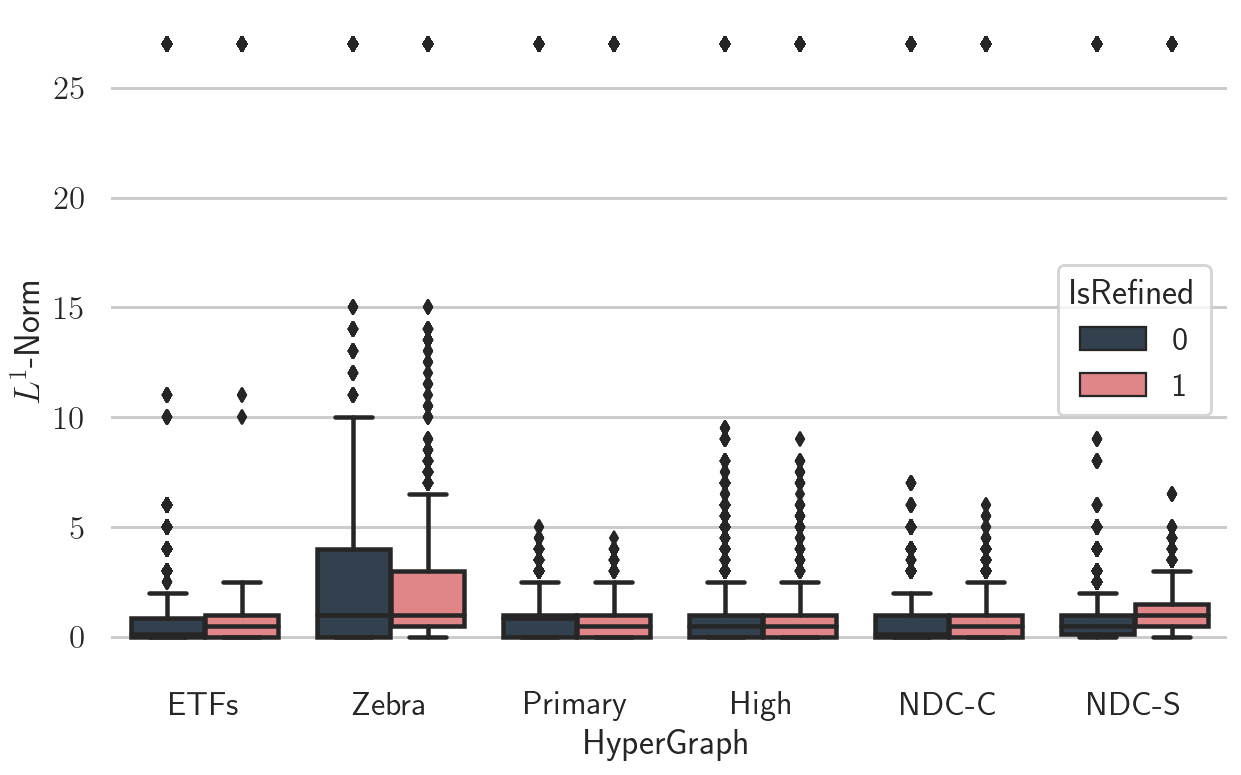

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(data=all_est, x='HyperGraph', y='norm1', hue='Refined', dodge=True, 
            palette=palette, ax=ax)
ax.set_ylabel(r'$L^1$-Norm')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(title='IsRefined')
plt.show()

# SA: Comparison between Alphas

Settings

In [93]:
lb=4
maxS=10
queryS=100
sampleS=0.4
landNum=30
landmarkSel=["bestcover", "farthest", "degree"]
# how to assign landmarks to s-ccs
landmarkAss='prob'

## Comparison Accuracy

In [94]:
acc_la = pd.DataFrame()

In [95]:
path = outfile_path + 'importance'
for run in product(graphs_prelims,
                   list(range(5)),
                   landmarkSel,
                   [0.2, 0.33, 0.4],
                   list(range(1,tests+1))):
    graph = run[0]
    i = run[1]
    ls = run[2]
    a = run[3]
    b = 1 - 2 * a
    t = run[4]
    path2 = f'{path}/{t}'

    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    try:
        fileName = f'{graph}_S{maxS}_L30_LB{lb}_Q{queryS}'
        fileName += f'_M{strategy}_LAprob_A{a}_B{b}_IDsample{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['Alpha'] = a
        tmp['Beta'] = b
        tmp['QuerySample'] = i
        acc_la = acc_la.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

In [96]:
acc_la['Combo'] = acc_la['Alpha'].apply(str) + ", " + acc_la['Beta'].apply(rounded_str)

### Infinite Estimates

In [97]:
inf_est = acc_la.copy()
inf_est['Inf'] = inf_est['d_hat'] == -1
inf_est = inf_est.groupby(by=['HyperGraph', 
                              'LS', 
                              'Combo']).agg({'Inf' : ['count', 'sum']}).reset_index()

In [98]:
inf_est.columns = inf_est.columns.droplevel(0)
inf_est.columns = ['HyperGraph', 'LS', 'Combo', 'Total', 'Inf']
inf_est['Inf (%)'] = (inf_est['Inf'] / inf_est['Total']) * 100 

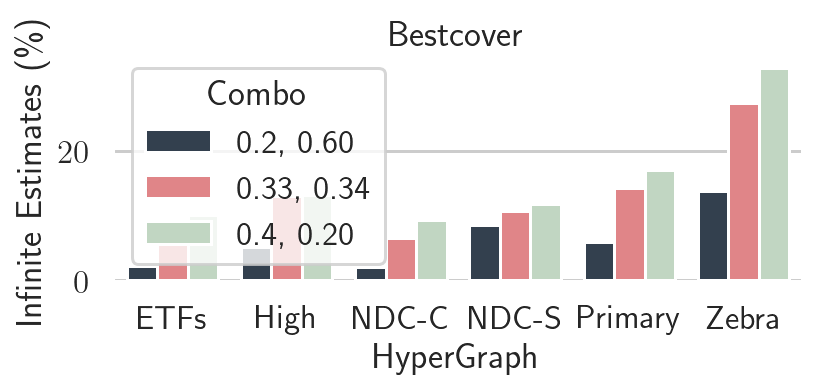

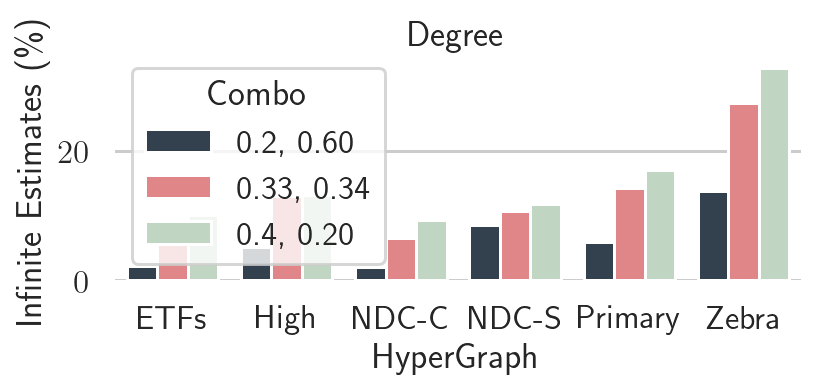

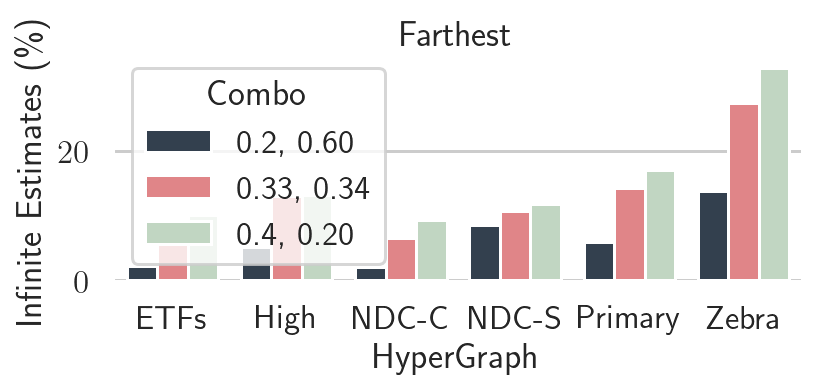

In [103]:
for strat in inf_est['LS'].unique():
    
    fig, ax = plt.subplots(figsize=(6,3))
    data = inf_est[inf_est['LS']==strat]
    sns.barplot(data=data, x='HyperGraph', y='Inf (%)', hue='Combo', 
                  palette=palette, ax=ax)
    ax.set_ylabel('Infinite Estimates (\%)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # legend
    ax.set_title(strat)
    plt.tight_layout()
    plt.show()

### L1-norm for all estimates

In [104]:
all_est = acc_la.copy()
all_est['norm1'] = all_est['d_hat'] - all_est['d']
all_est['norm1'] = all_est['norm1'].apply(abs)
max_norm = all_est['norm1'].max()
all_est.loc[all_est['d_hat']==-1, 'norm1'] = max_norm * 1.5

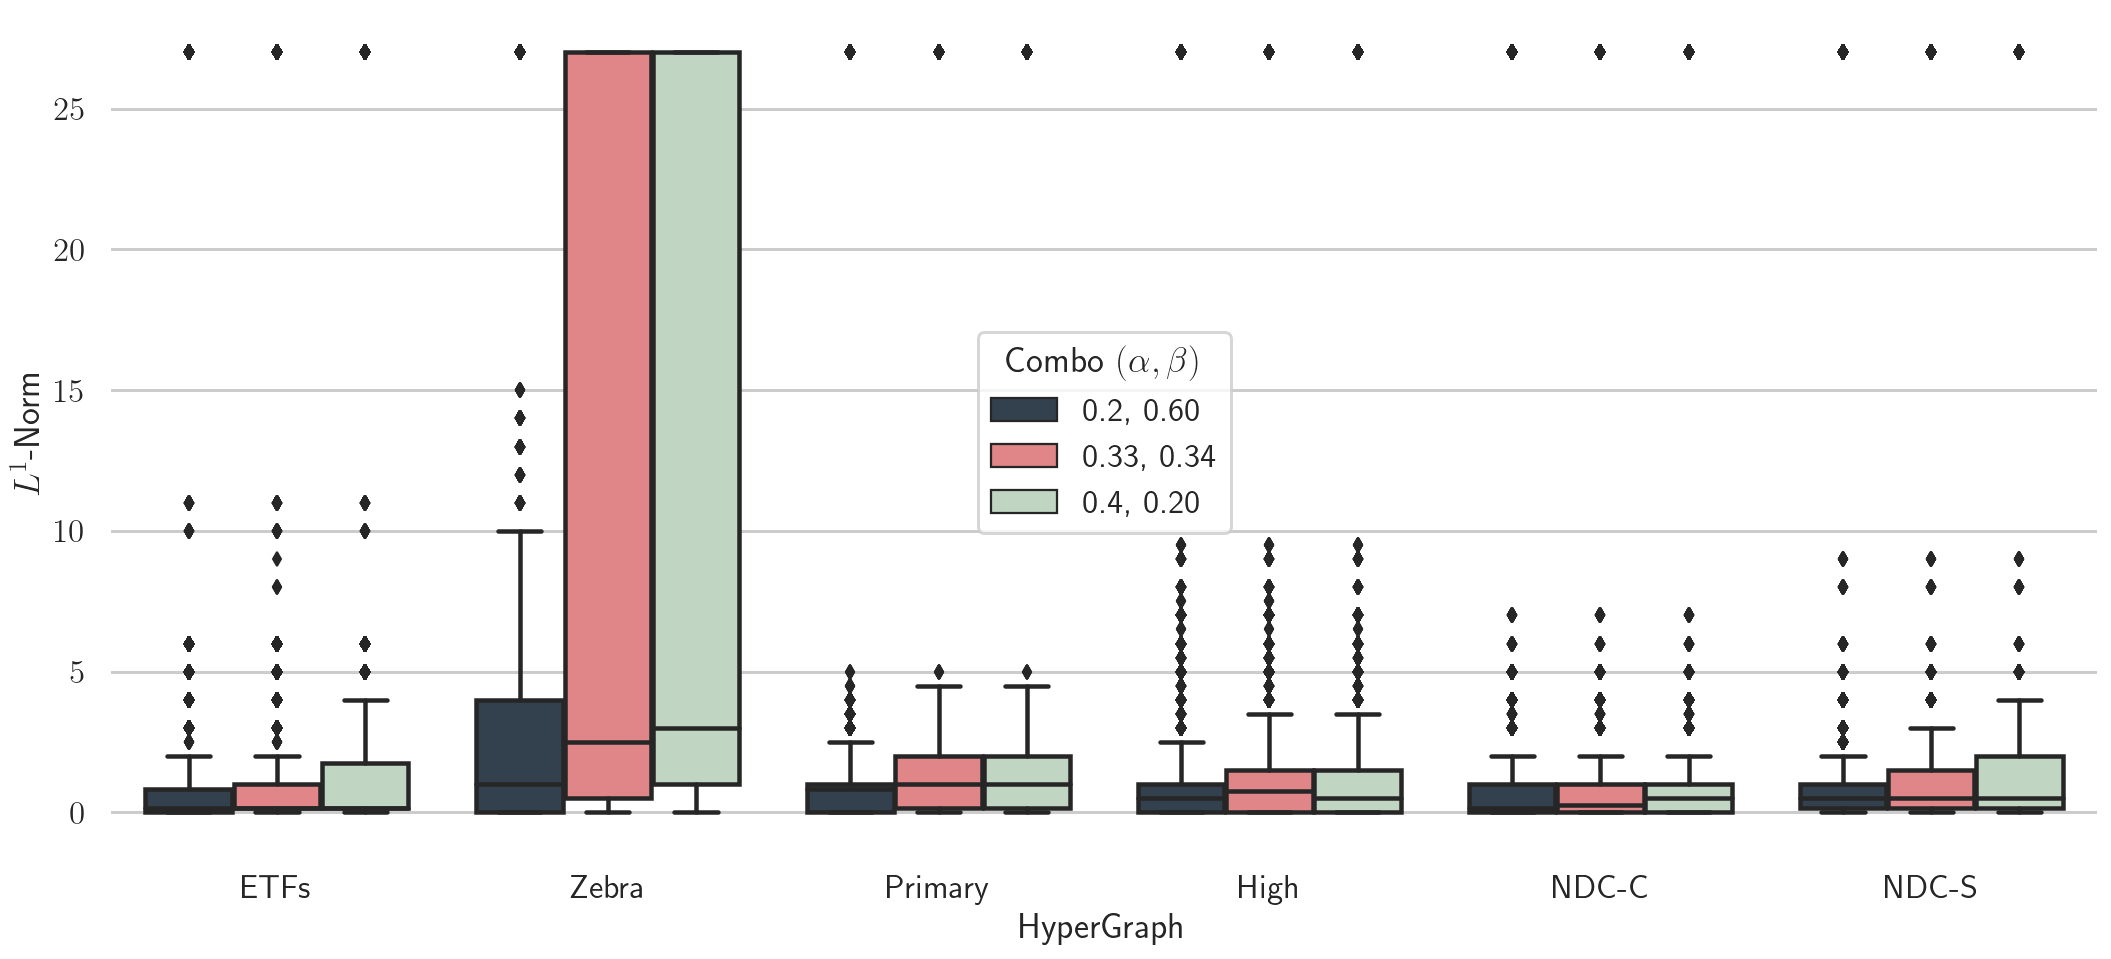

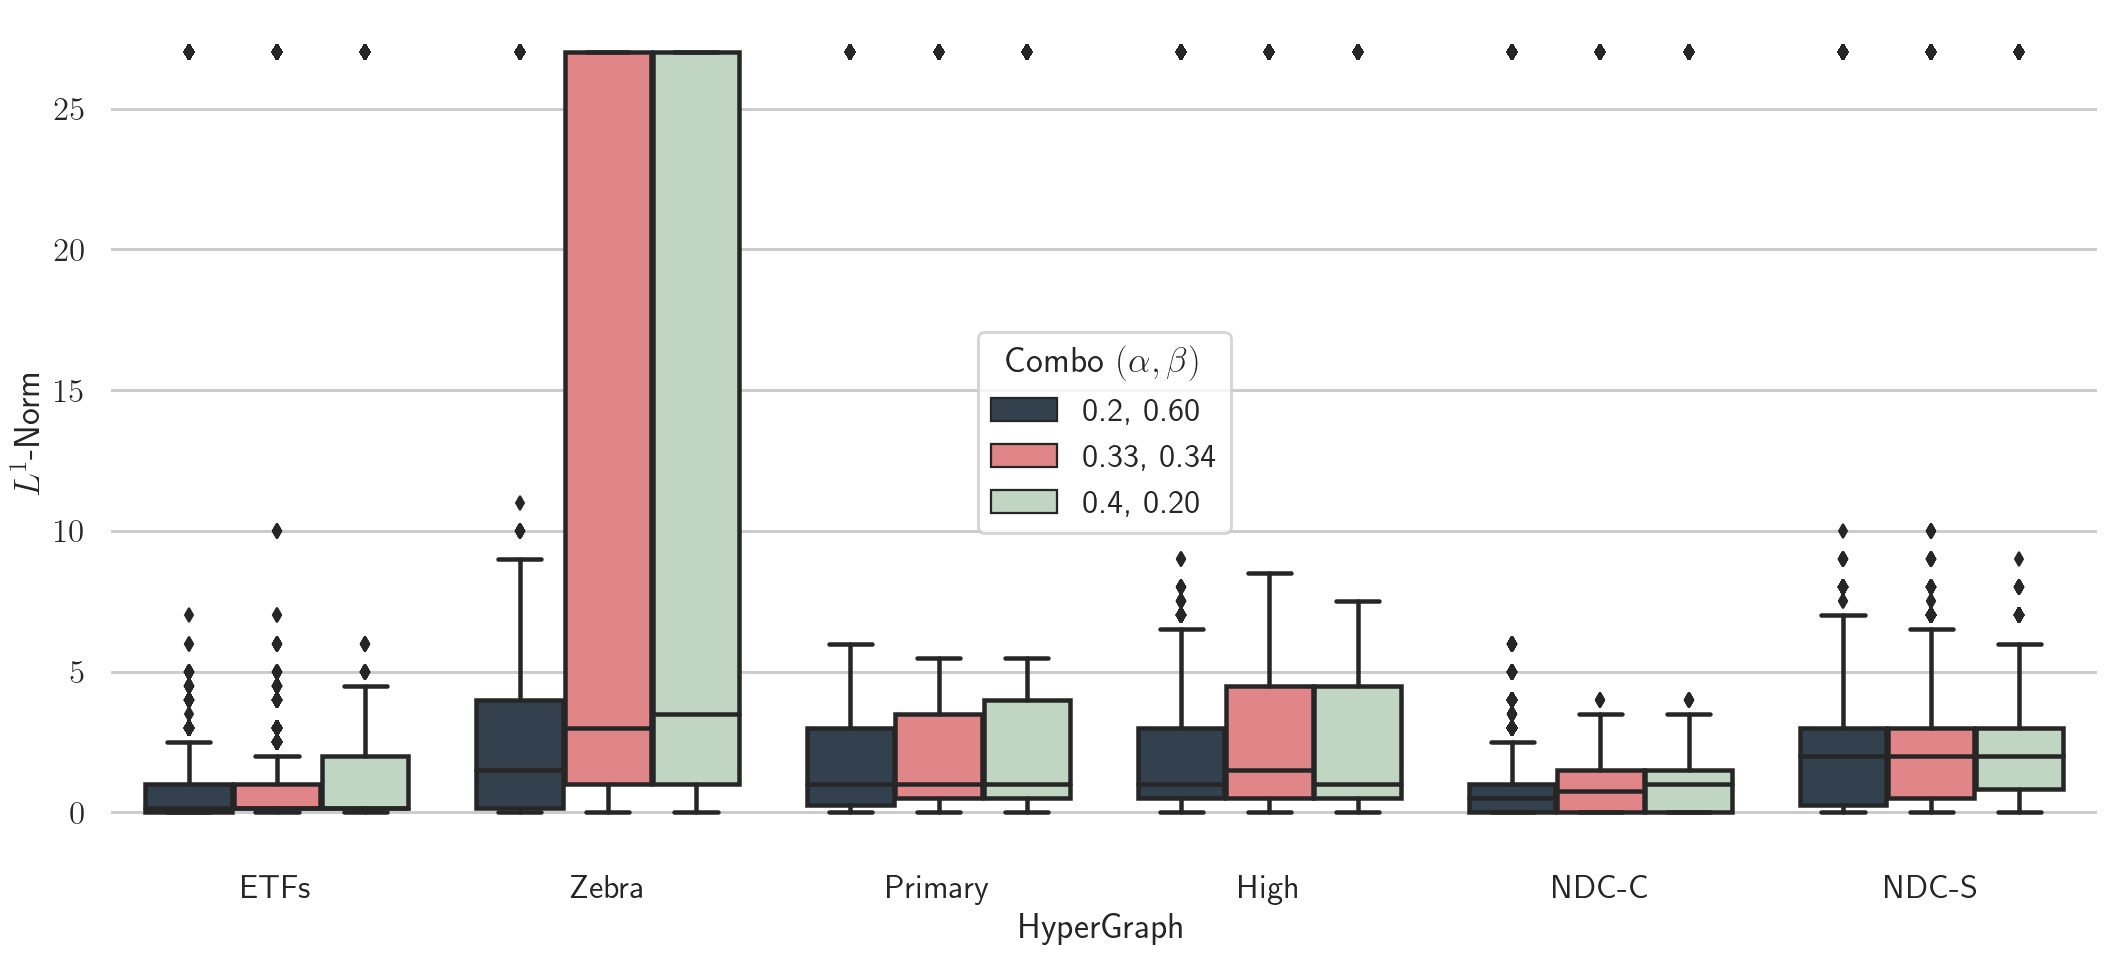

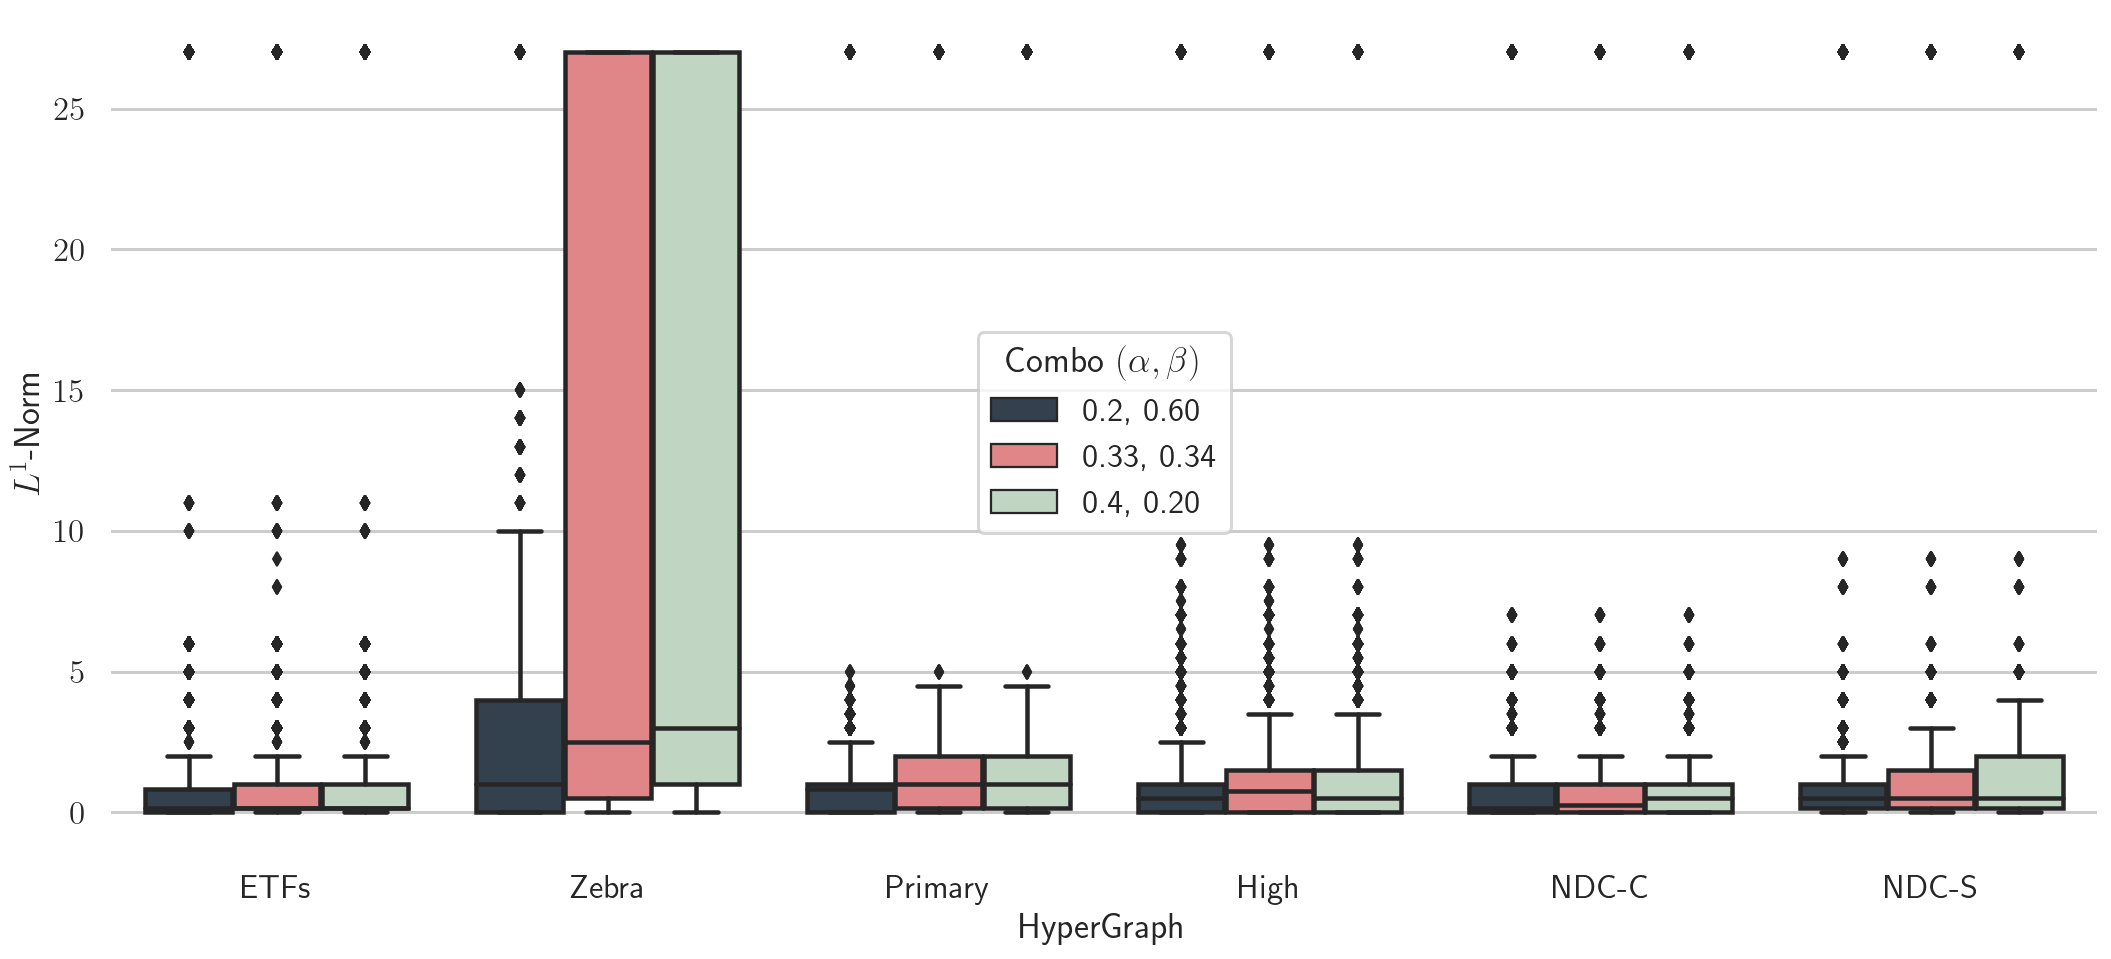

In [105]:
for strat in all_est['LS'].unique():

    fig, ax = plt.subplots(figsize=(15,7))
    data = all_est[all_est['LS']==strat]
    sns.boxplot(data=data, x='HyperGraph', y='norm1', 
                hue='Combo', palette=palette, ax=ax)
    ax.set_ylabel(r'$L^1$-Norm')
    ax.legend(title=r'Combo $(\alpha, \beta)$')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.savefig(fig_path+f'sa_importance_{strat}.pdf')
    plt.show()

# RA: Comparison between Alphas 

Settings

In [106]:
lb=4
maxS=10
# sample size
queryS=100
# query sample size
sampleS=0.4
landNum=30
landmarkSel=['degree', 'farthest', 'bestcover']
# how to assign landmarks to s-ccs
landmarkAss='ranking'
# importance of s-cc size
alpha=[0.5, 0.8, 1.0]
# importance of s
beta=[0.5, 0.8, 1.0]

## Comparison Accuracy

In [107]:
acc_la = pd.DataFrame()

In [109]:
path = outfile_path + 'importance'
for run in product(graphs_prelims,
                   list(range(5)),
                   landmarkSel,
                   alpha,
                   beta):
    graph = run[0]
    i = run[1]
    ls = run[2]
    a = run[3]
    b = run[4]

    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    try:
        fileName = f'{graph}_S{maxS}_L30_LB{lb}_Q{queryS}_M{strategy}_LAranking_A{a}_B{b}_IDsample{i}.txt'
        tmp = pd.read_csv(f'{path}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['Alpha'] = a
        tmp['Beta'] = b
        tmp['QuerySample'] = i
        acc_la = acc_la.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

### Infinite Estimates

In [110]:
inf_est = acc_la.copy()
inf_est['Inf'] = inf_est['d_hat'] == -1
inf_est = inf_est.groupby(by=['HyperGraph', 
                              'LS', 
                              'Alpha', 
                              'Beta']).agg({'Inf' : ['count', 'sum']}).reset_index()

In [111]:
inf_est.columns = inf_est.columns.droplevel(0)
inf_est.columns = ['HyperGraph', 'LS', 'Alpha', 'Beta', 'Total', 'Inf']
inf_est['Inf (%)'] = (inf_est['Inf'] / inf_est['Total']) * 100 

In [112]:
inf_est['Combo'] = inf_est['Alpha'].apply(str) + ", " + inf_est['Beta'].apply(str)

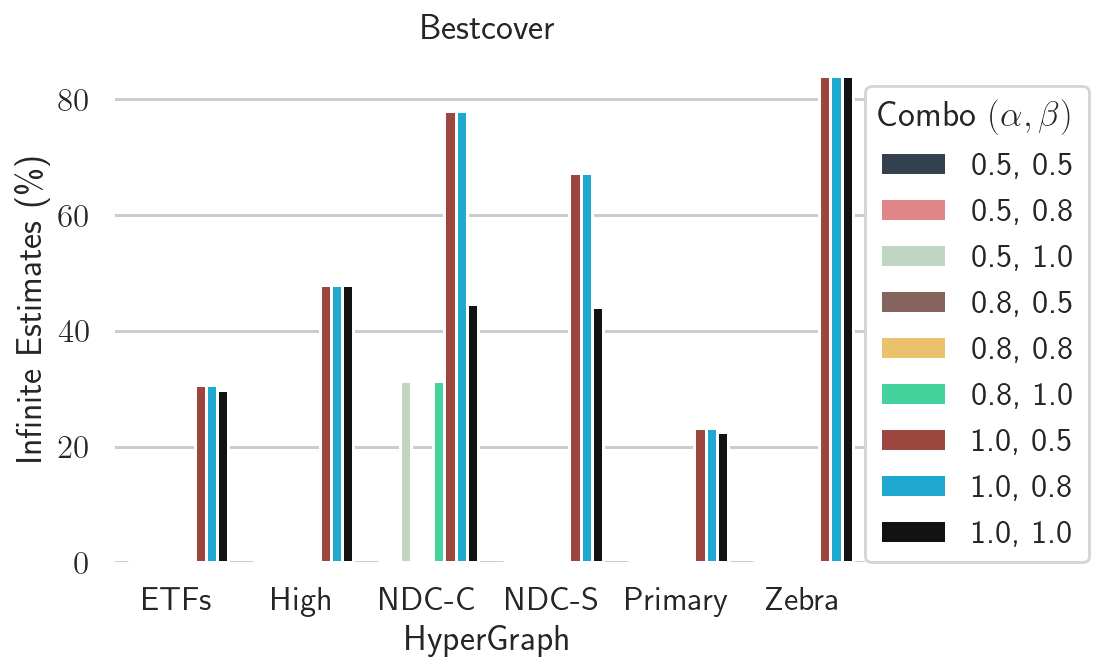

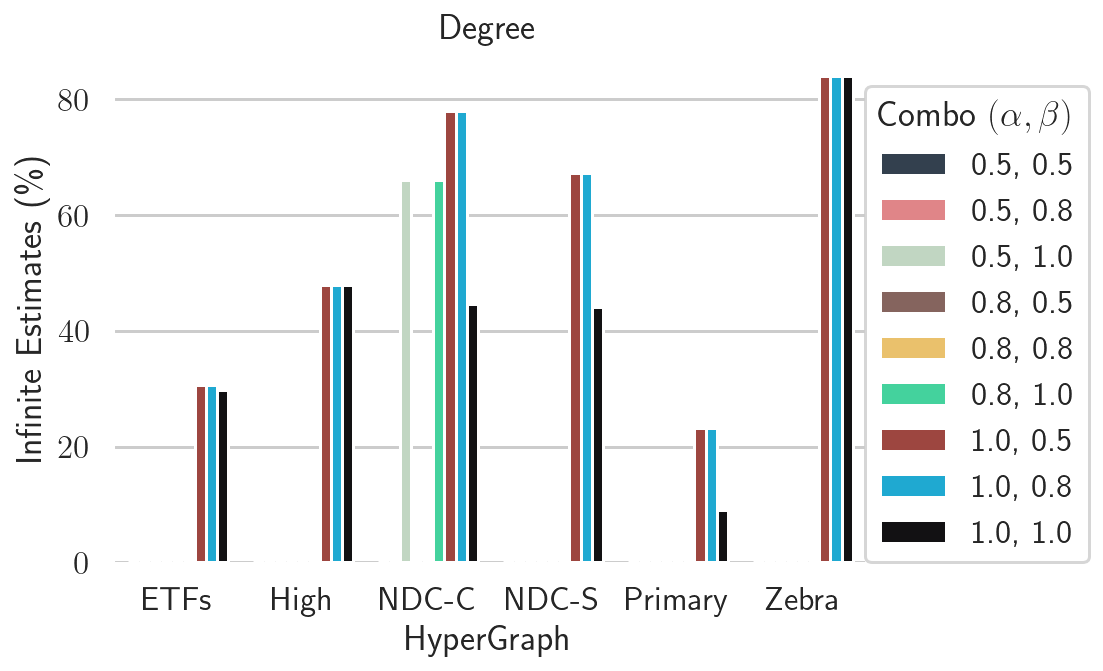

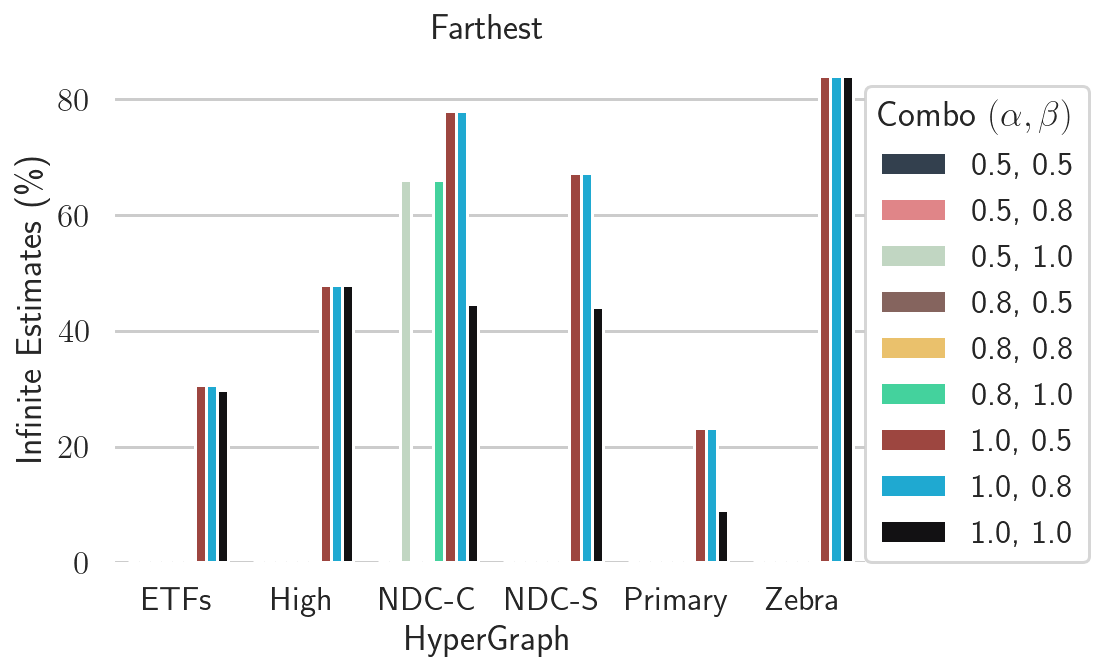

In [115]:
for strategy in inf_est['LS'].unique():
    fig, ax = plt.subplots(figsize=(8,5))
    data = inf_est[inf_est['LS']==strategy]
    sns.barplot(data=data, x='HyperGraph', y='Inf (%)', hue='Combo', palette=palette, ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylabel('Infinite Estimates (\%)')
    ax.set_title(strategy)
    # legend
    ax.legend(title=r'Combo $(\alpha, \beta)$', loc=(1,0))
    plt.tight_layout()
    plt.show()

### L1-norm for all estimates

In [116]:
all_est = acc_la.copy()
all_est['norm1'] = all_est['d_hat'] - all_est['d']
all_est['norm1'] = all_est['norm1'].apply(abs)
max_norm = all_est['norm1'].max()
all_est.loc[all_est['d_hat']==-1, 'norm1'] = max_norm * 1.5 

In [117]:
all_est['Combo'] = all_est['Alpha'].apply(str) + "," + all_est['Beta'].apply(str)

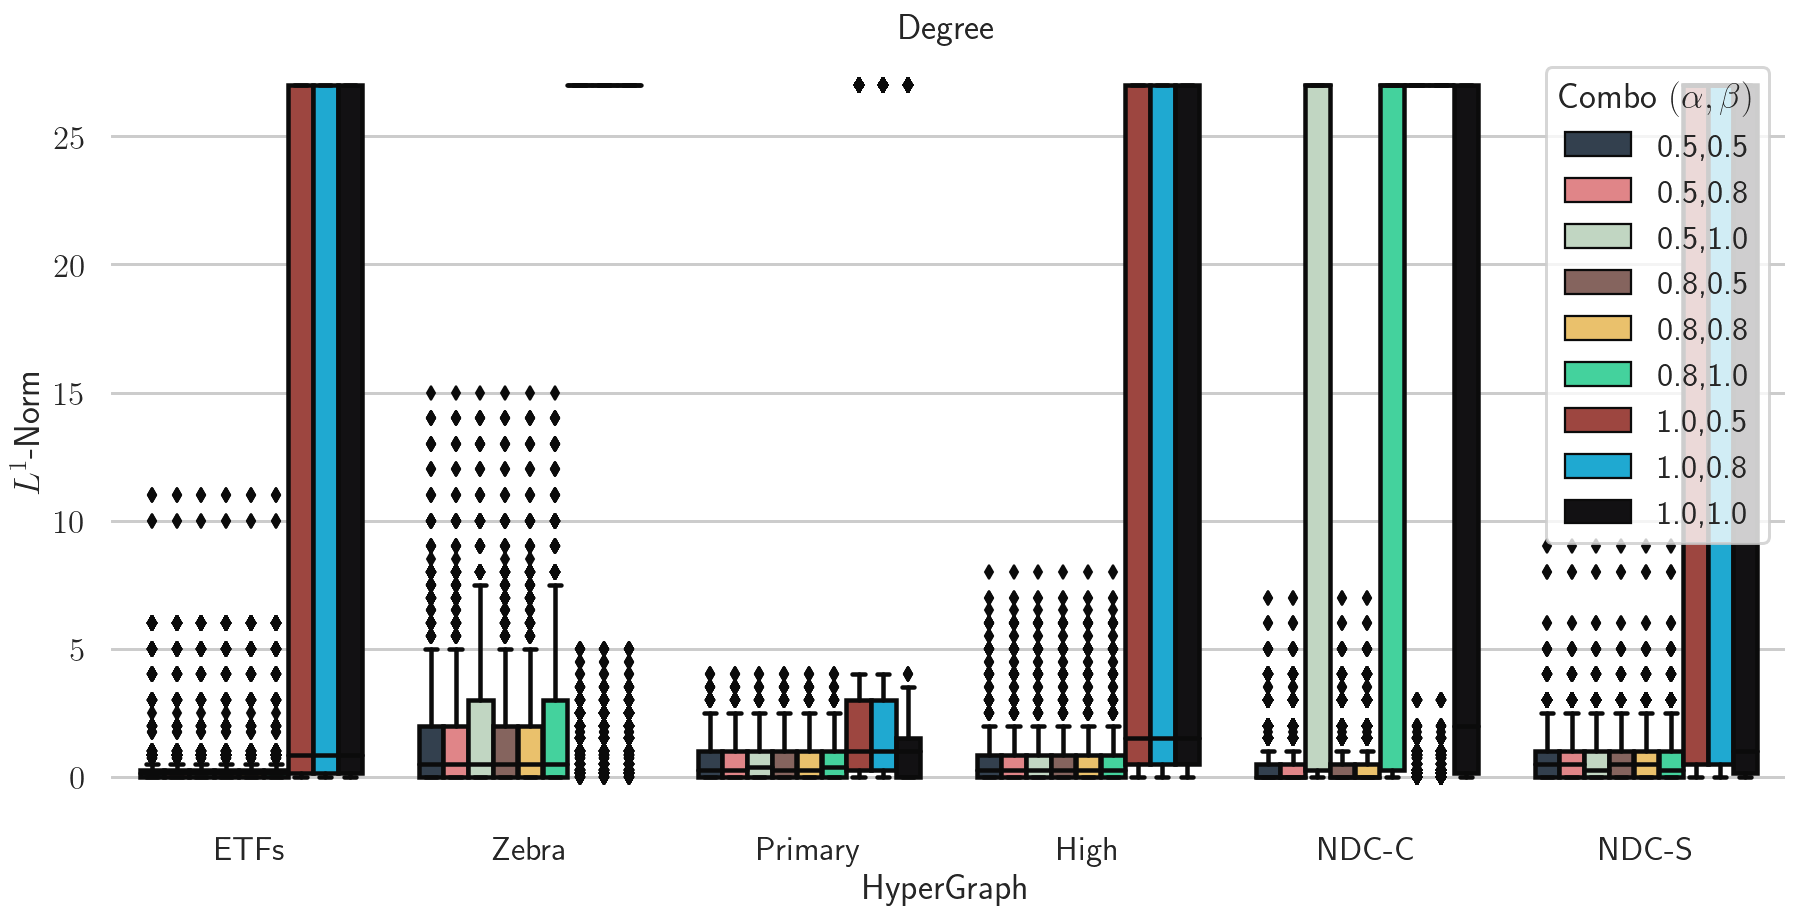

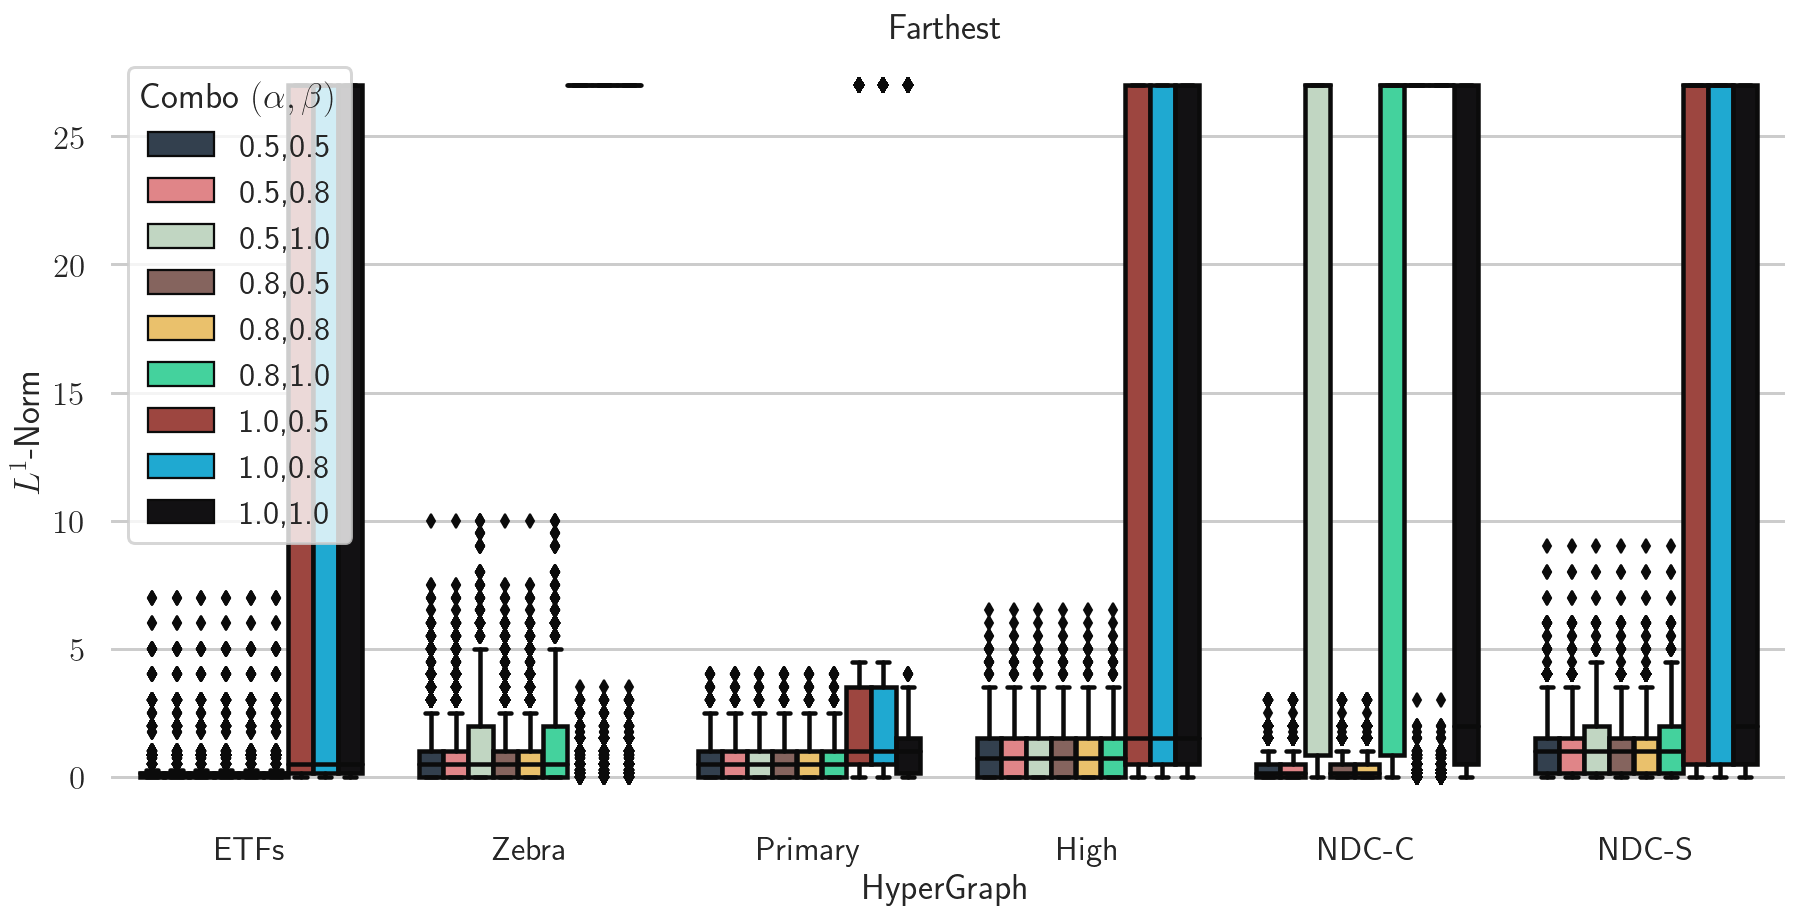

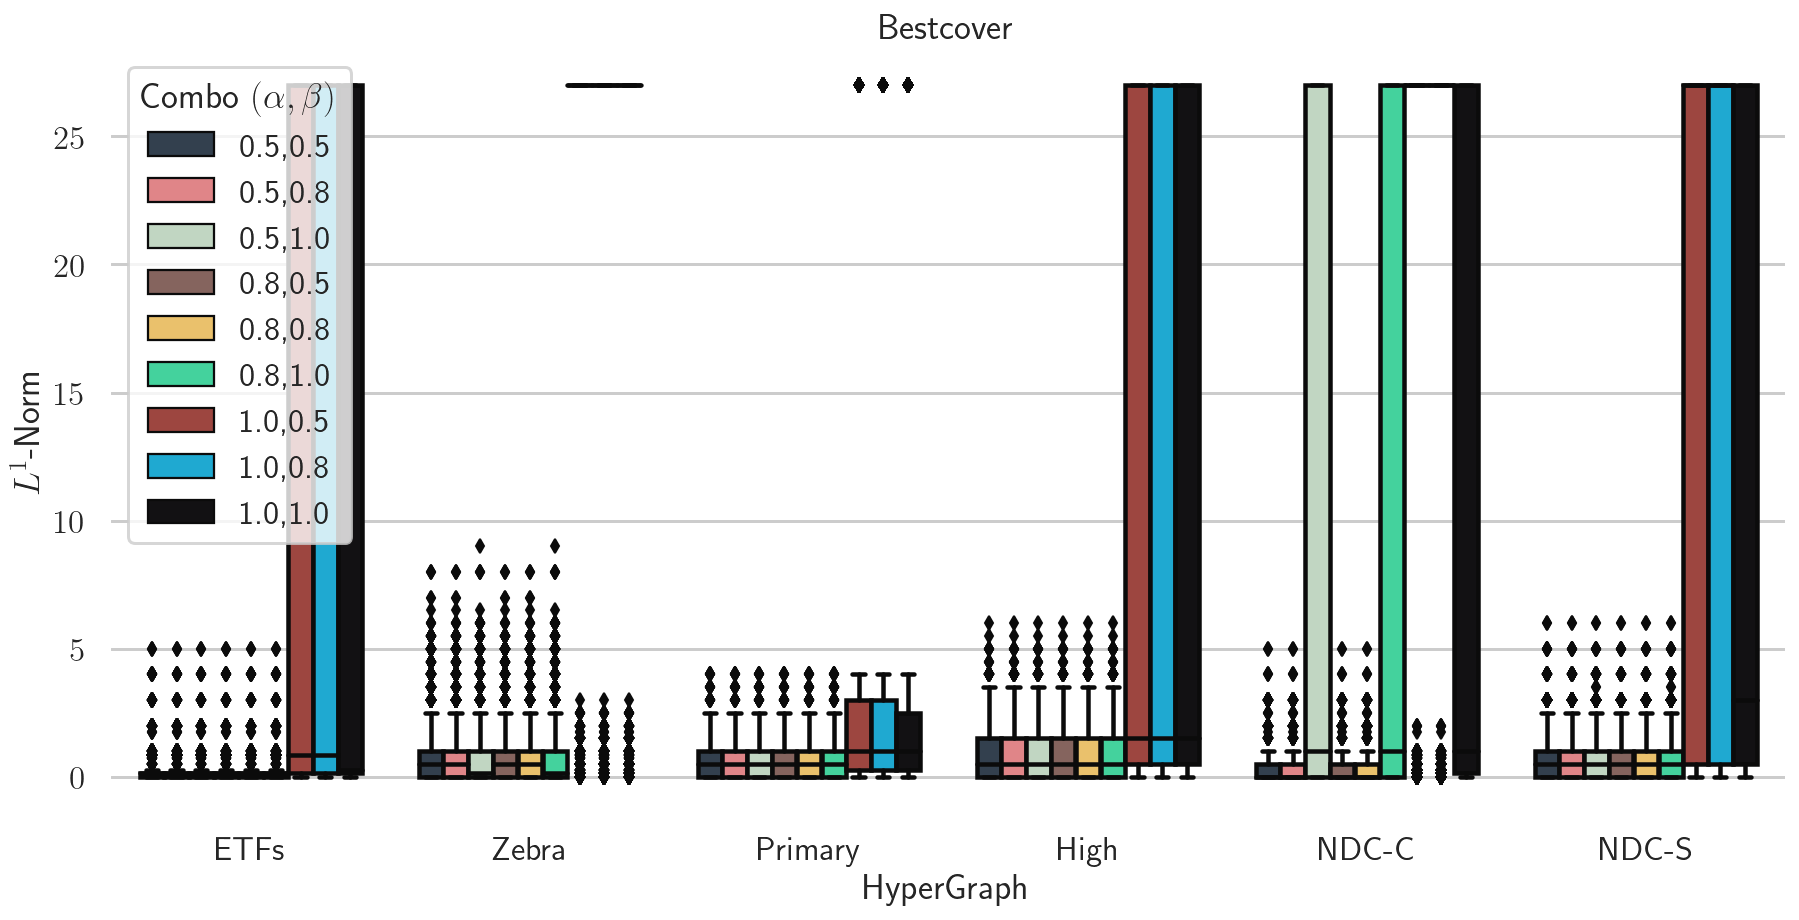

In [118]:
for strategy in all_est['LS'].unique():
    fig, ax = plt.subplots(figsize=(15,7))

    data = all_est[all_est['LS']==strategy]
    sns.boxplot(data=data, x='HyperGraph', y='norm1', hue='Combo', dodge=True, 
                palette=palette, ax=ax)

    ax.legend(title=r'Combo $(\alpha, \beta)$')
    ax.set_ylabel(r'$L^1$-Norm')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(strategy)
    plt.show()

Close up

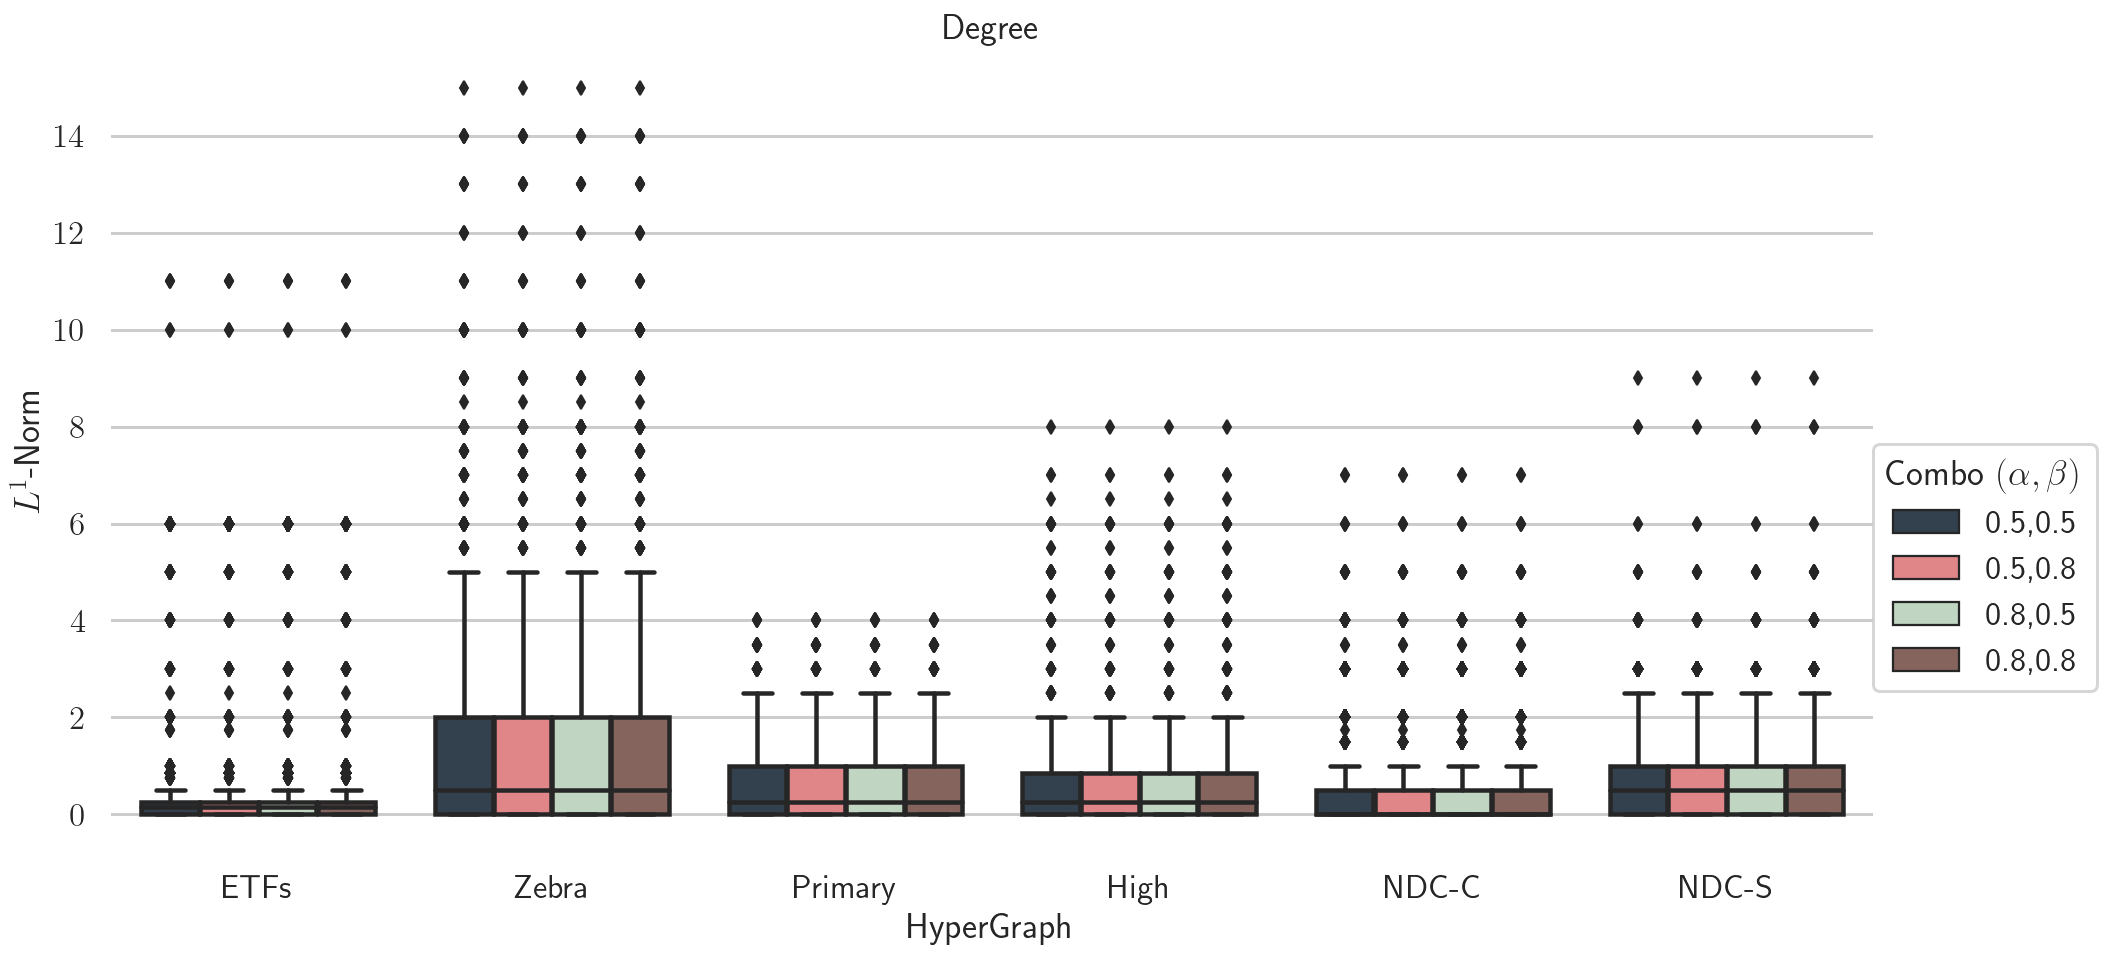

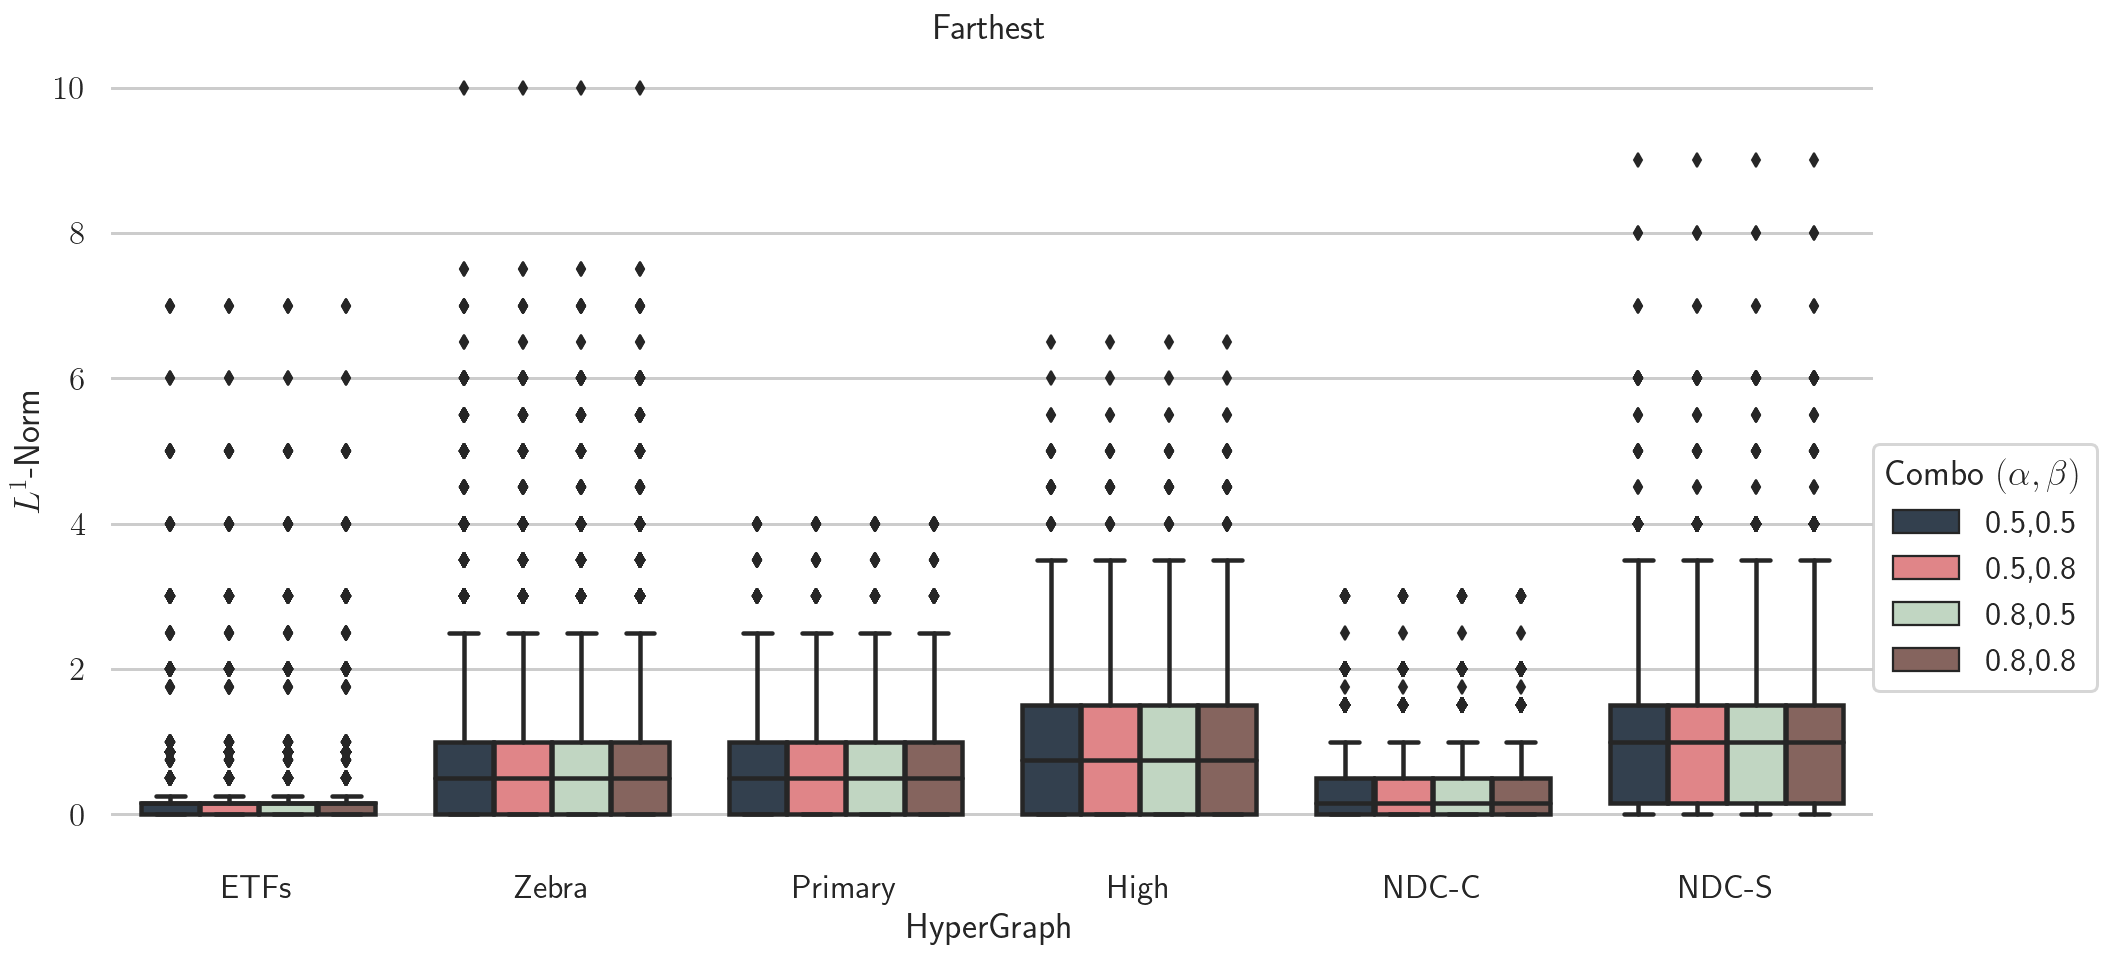

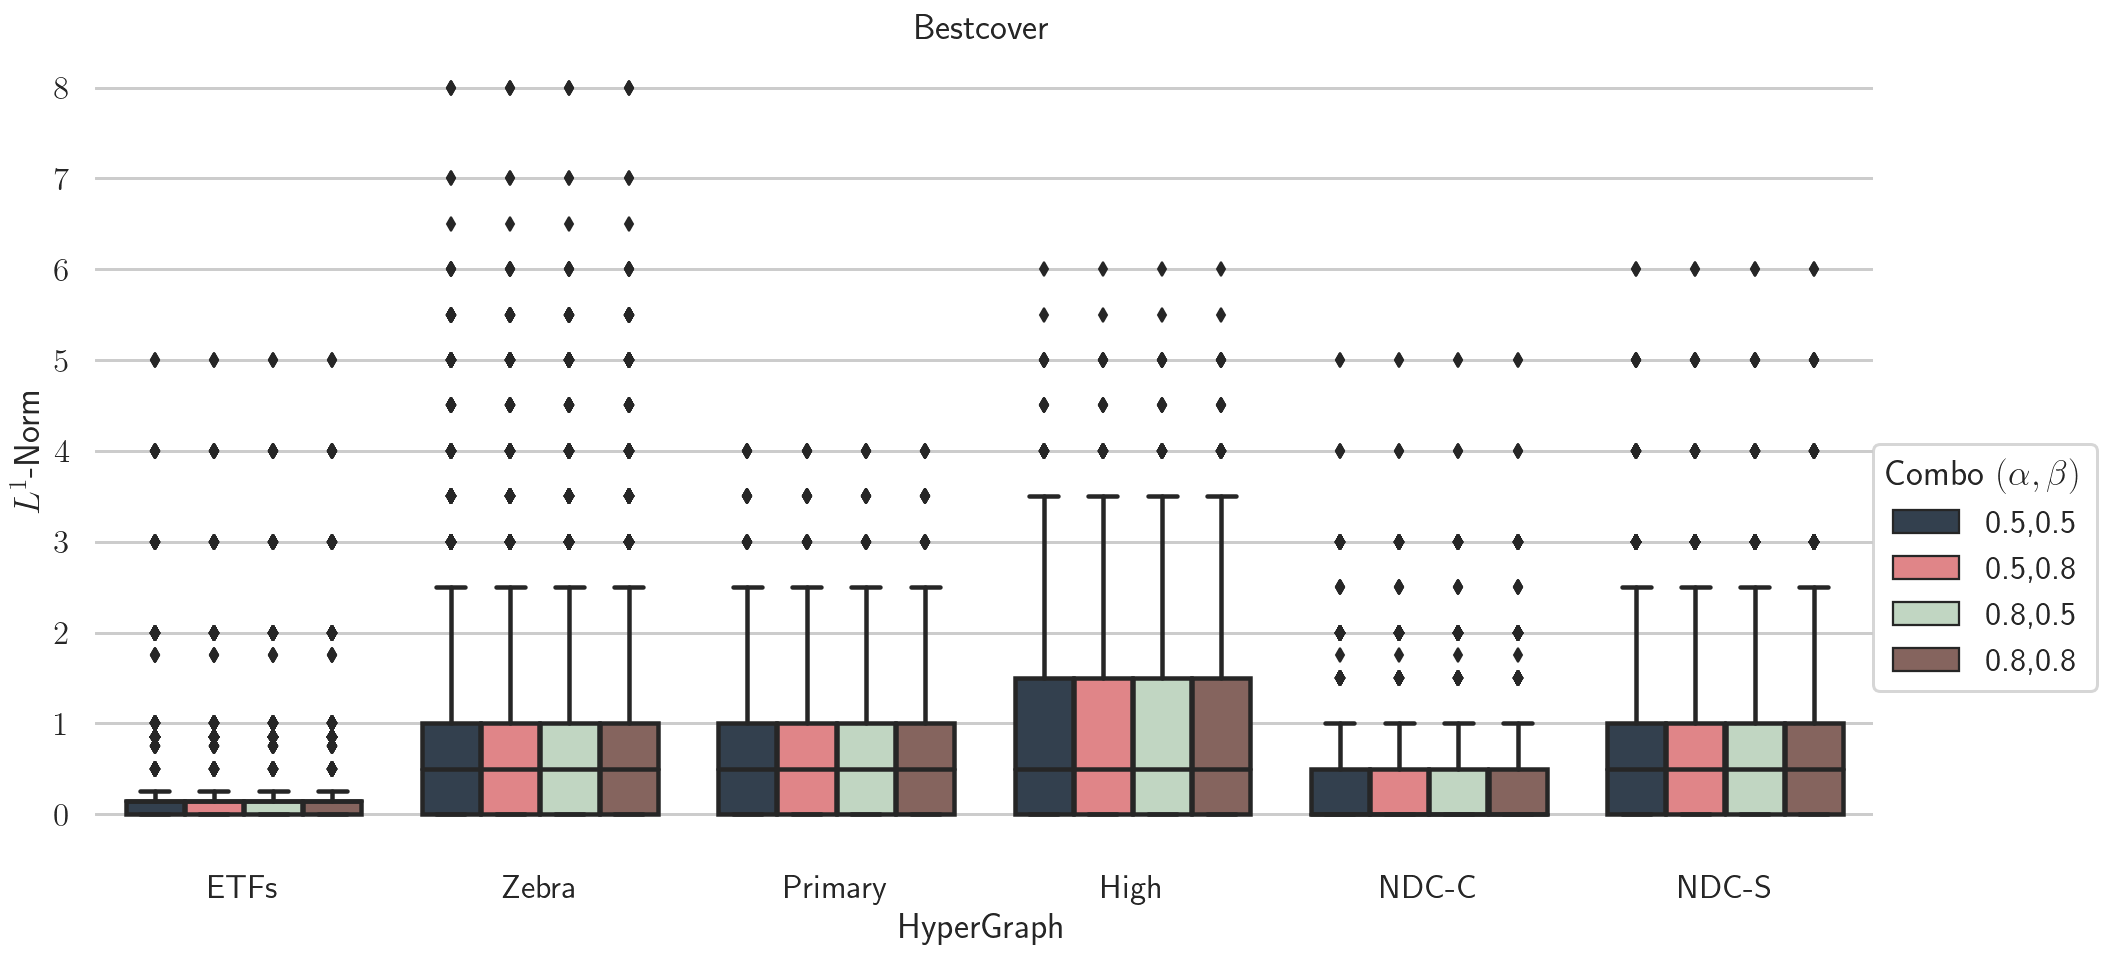

In [121]:
for strategy in all_est['LS'].unique():
    fig, ax = plt.subplots(figsize=(15,7))

    data = all_est[(all_est['LS']==strategy) &
                   (all_est['Alpha'] < 1.0) & 
                   (all_est['Beta'] < 1.0)]

    sns.boxplot(data=data, x='HyperGraph', y='norm1', hue='Combo',
                dodge=True, palette=palette, ax=ax)
    ax.set_ylabel(r'$L^1$-Norm')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(strategy)
    ax.legend(title=r'Combo $(\alpha, \beta)$', loc=(1,0.2))
    plt.tight_layout()
    plt.show()

# Comparison between LA strategies

Settings

In [175]:
lb=4
maxS=10
queryS=100
sampleS=0.4
landNum=30
landmarkSel=["degree"]
# how to assign landmarks to s-ccs
landmarkAss=['ranking', 'prob']
# importance of s-cc size
alpha=[0.5, 0.2]
# importance of s
beta=[0.5, 0.6]
# number of random tests
tests=10

Statistics

In [457]:
stats = pd.DataFrame()
for t in range(1,11):
    stats = stats.append(pd.read_csv(outfile_path+f'importance/{t}/statistics.csv', header=None, sep='\t'))
stats['QuerySample'] = int(len(stats) / 5) * list(range(5))
tmp = pd.read_csv(outfile_path+f'importance/statistics.csv', header=None, sep='\t')
tmp['QuerySample'] = 1
stats = stats.append(tmp)

In [458]:
stats.columns = ['HyperGraph', 'Timestamp', 'Offline', 
                 'Online', 'maxS', 'lb', 'Q', 'NumLands', 'OracleSize',
                 'NumQueries', 'LS', 'LA', 'Alpha', 'Beta', 'QuerySample']
stats.drop(columns=['Timestamp', 'lb', 'maxS'], inplace=True)

In [460]:
agg_stats = stats.groupby(by=['HyperGraph', 
                              'Q', 
                              'LS',
                              'LA',
                              'Alpha',
                              'Beta']).agg({'Offline':'mean',
                                            'NumLands': ['min', 'max', 'mean'],
                                            'OracleSize': ['min', 'max', 'mean']})

In [461]:
agg_stats = agg_stats.reset_index()
agg_stats.columns = agg_stats.columns.droplevel(0)
agg_stats.columns = ['HyperGraph', 'Q', 'LS', 'LA', 'Alpha', 'Beta',
                     'Offline', 'minL', 'maxL', 'meanL', 
                     'minO', 'maxO', 'meanO']

In [462]:
agg_stats = agg_stats[(agg_stats['LS'].isin(landmarkSel)) &
                      (agg_stats['Alpha'].isin(alpha)) &
                      (agg_stats['Beta'].isin(beta))]

In [463]:
agg_stats['LA'] = agg_stats['LA'].apply(rename_la)
agg_stats['HyperGraph'] = agg_stats['HyperGraph'].apply(rename_graph)

## Comparison Landmarks Num

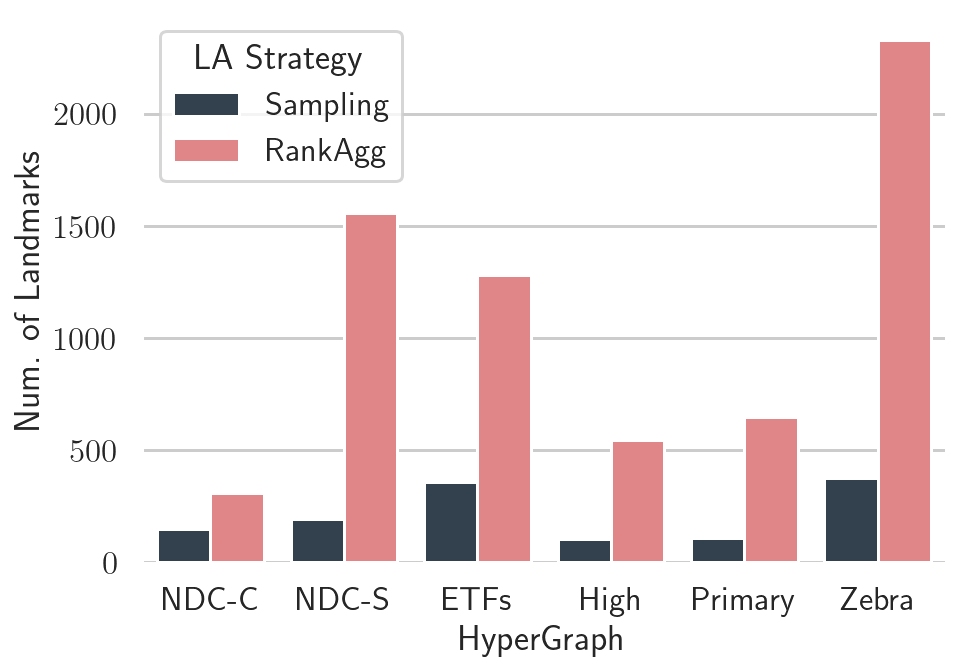

In [133]:
fig, ax = plt.subplots(figsize=(7,5))

data = agg_stats[agg_stats['Q']==30].copy()
sns.barplot(data=data, x='HyperGraph', y='meanL', 
            hue='LA', palette=palette, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(title='LA Strategy')
ax.set_ylabel('Num. of Landmarks')
plt.tight_layout()
plt.savefig(fig_path+f'comp_LNUM_vary_LA.pdf')
plt.show()

## Comparison Creation Time

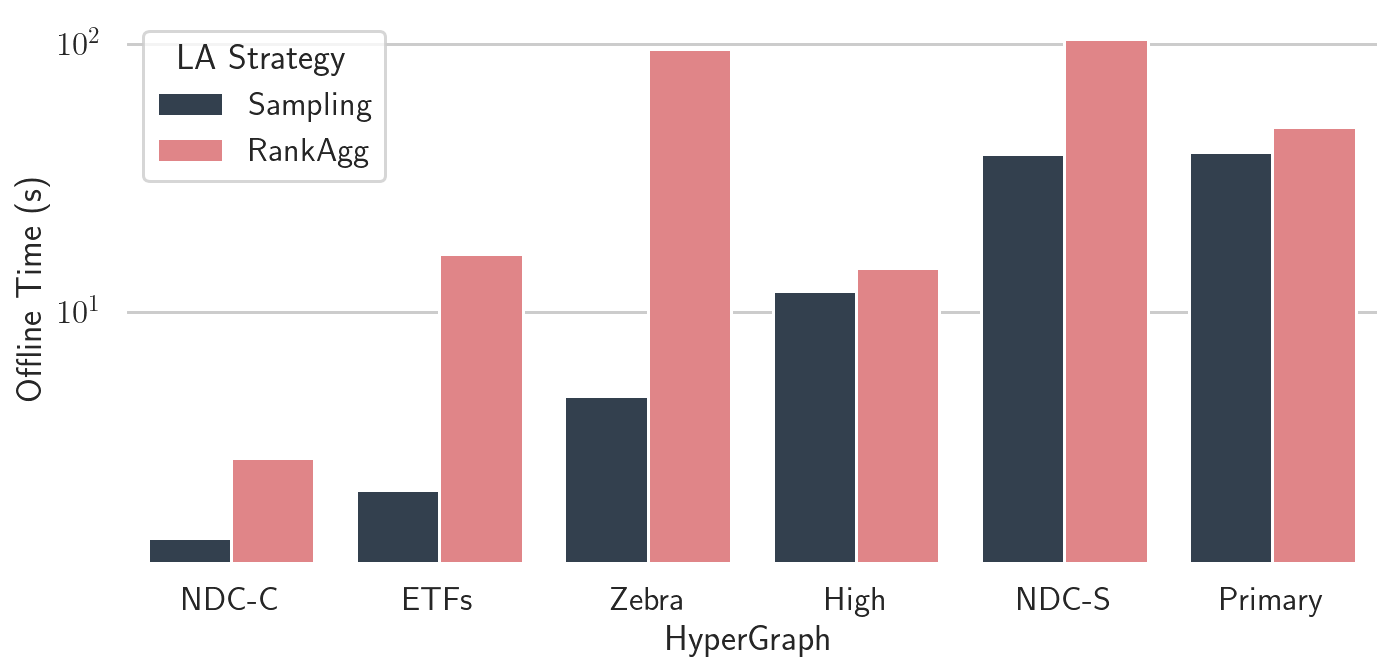

In [465]:
fig, ax = plt.subplots(figsize=(10,5))

data = agg_stats[agg_stats['Q']==30].copy()
data.sort_values(by='Offline', inplace=True)

sns.barplot(data=data, x='HyperGraph', y='Offline', 
            hue='LA', palette=palette, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(title='LA Strategy')
ax.set_yscale('log')
ax.set_ylabel('Offline Time (s)')
plt.tight_layout()
plt.savefig(fig_path+f'comp_CT_vary_LA.pdf')
plt.show()

## Comparison Accuracy

In [440]:
acc_la = pd.DataFrame()

In [441]:
path = outfile_path + 'importance'

for run in product(graphs_prelims,
                   list(range(5)),
                   landmarkSel):
    graph = run[0]
    i = run[1]
    ls = run[2]
    
    if ls == 'between' or ls == 'bestcover':
        strategy = f'{ls}_{sampleS}'
    else:
        strategy = ls
    
    for t in range(1,11):
        path2 = f'{path}/{t}'
        try:
            fileName = f'{graph}_S{maxS}_L{landNum}_LB{lb}_Q{queryS}'
            fileName += f'_M{strategy}_LAprob_A{alpha[1]}_B{1 - 2*alpha[1]}_IDsample{i}.txt'
            tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
            tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
            tmp['HyperGraph'] = graph_names[graph]
            tmp['LS'] = rename_ls(strategy)
            tmp['LA'] = rename_la('prob')
            tmp['QuerySample'] = i
            acc_la = acc_la.append(tmp, ignore_index=True)
        except Exception as e:
            print(e)
            pass

    try:
        fileName = f'{graph}_S{maxS}_L{landNum}_LB{lb}_Q{queryS}'
        fileName += f'_M{strategy}_LAranking_A{alpha[0]}_B{beta[0]}_IDsample{i}.txt'
        tmp = pd.read_csv(f'{path}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(strategy)
        tmp['LA'] = rename_la('ranking')
        tmp['QuerySample'] = 1
        acc_la = acc_la.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

### Infinite Estimates

In [442]:
inf_est = acc_la.copy()
inf_est['Inf'] = inf_est['d_hat'] == -1
inf_est = inf_est.groupby(by=['HyperGraph', 
                              'LS', 
                              'LA']).agg({'Inf' : ['count', 'sum']}).reset_index()

In [443]:
inf_est.columns = inf_est.columns.droplevel(0)
inf_est.columns = ['HyperGraph', 'LS', 'LA', 'Total', 'Inf']
inf_est['Inf (%)'] = (inf_est['Inf'] / inf_est['Total']) * 100

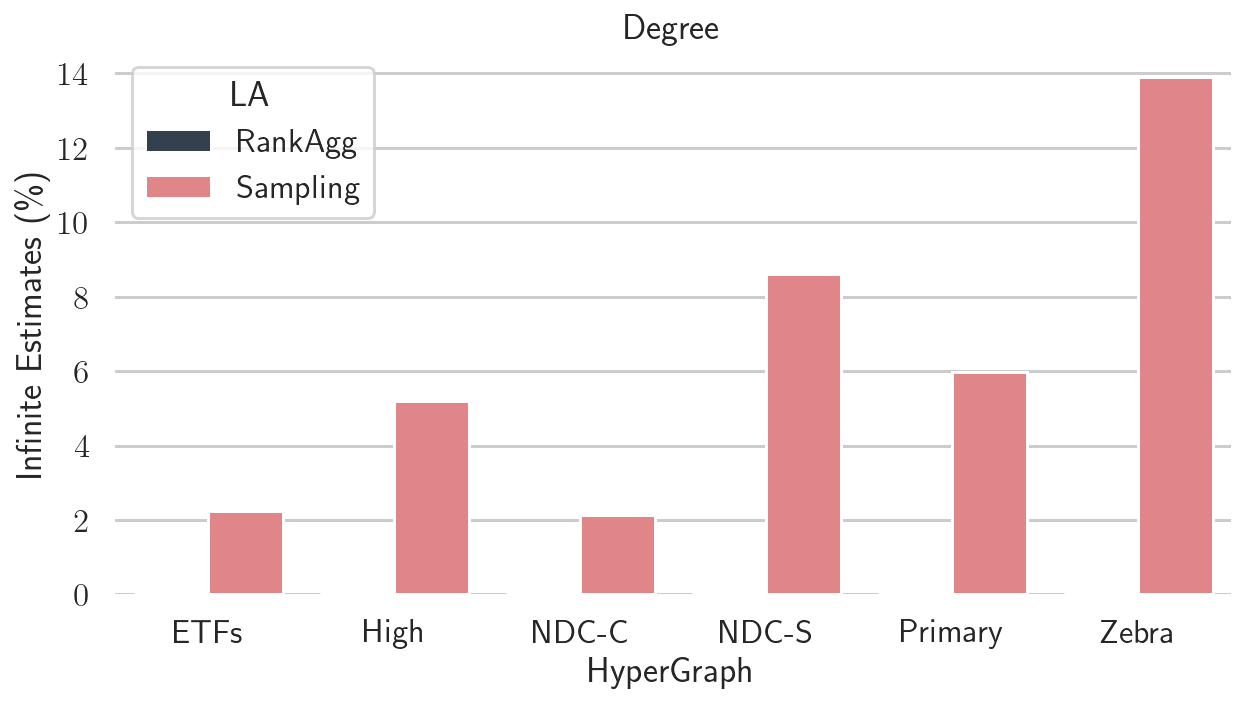

In [140]:
for strategy in inf_est['LS'].unique():

    fig, ax = plt.subplots(figsize=(10,5))
    data = inf_est[inf_est['LS']==strategy]
    sns.barplot(data=data, x='HyperGraph', y='Inf (%)', hue='LA', 
                palette=palette[:2], ax=ax)
    ax.set_ylabel('Infinite Estimates (\%)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(strategy)
    plt.show()

### L1-norm for all estimates

In [141]:
all_est = acc_la.copy()
all_est['norm1'] = all_est['d_hat'] - all_est['d']
all_est['norm1'] = all_est['norm1'].apply(abs)
max_norm = all_est['norm1'].max()
all_est.loc[all_est['d_hat']==-1, 'norm1'] = max_norm * 1.5

Degree


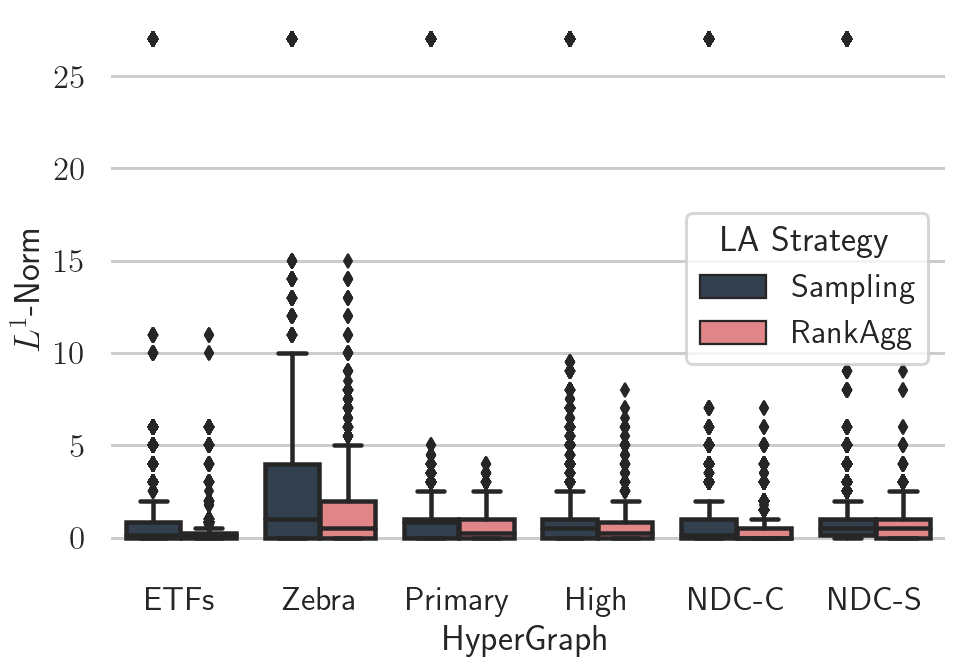

In [144]:
for strategy in all_est['LS'].unique():

    fig, ax = plt.subplots(figsize=(7,5))
    data = all_est[all_est['LS']==strategy]
    sns.boxplot(data=data, x='HyperGraph', y='norm1', dodge=True,
                   hue='LA', palette=palette, ax=ax)

    ax.set_ylabel(r'$L^1$-Norm')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    print(strategy)
    ax.legend(title='LA Strategy')
    plt.tight_layout()
    plt.savefig(fig_path+'comparison_la_norm.pdf')
    plt.show()

AVG L1-norm   

Degree


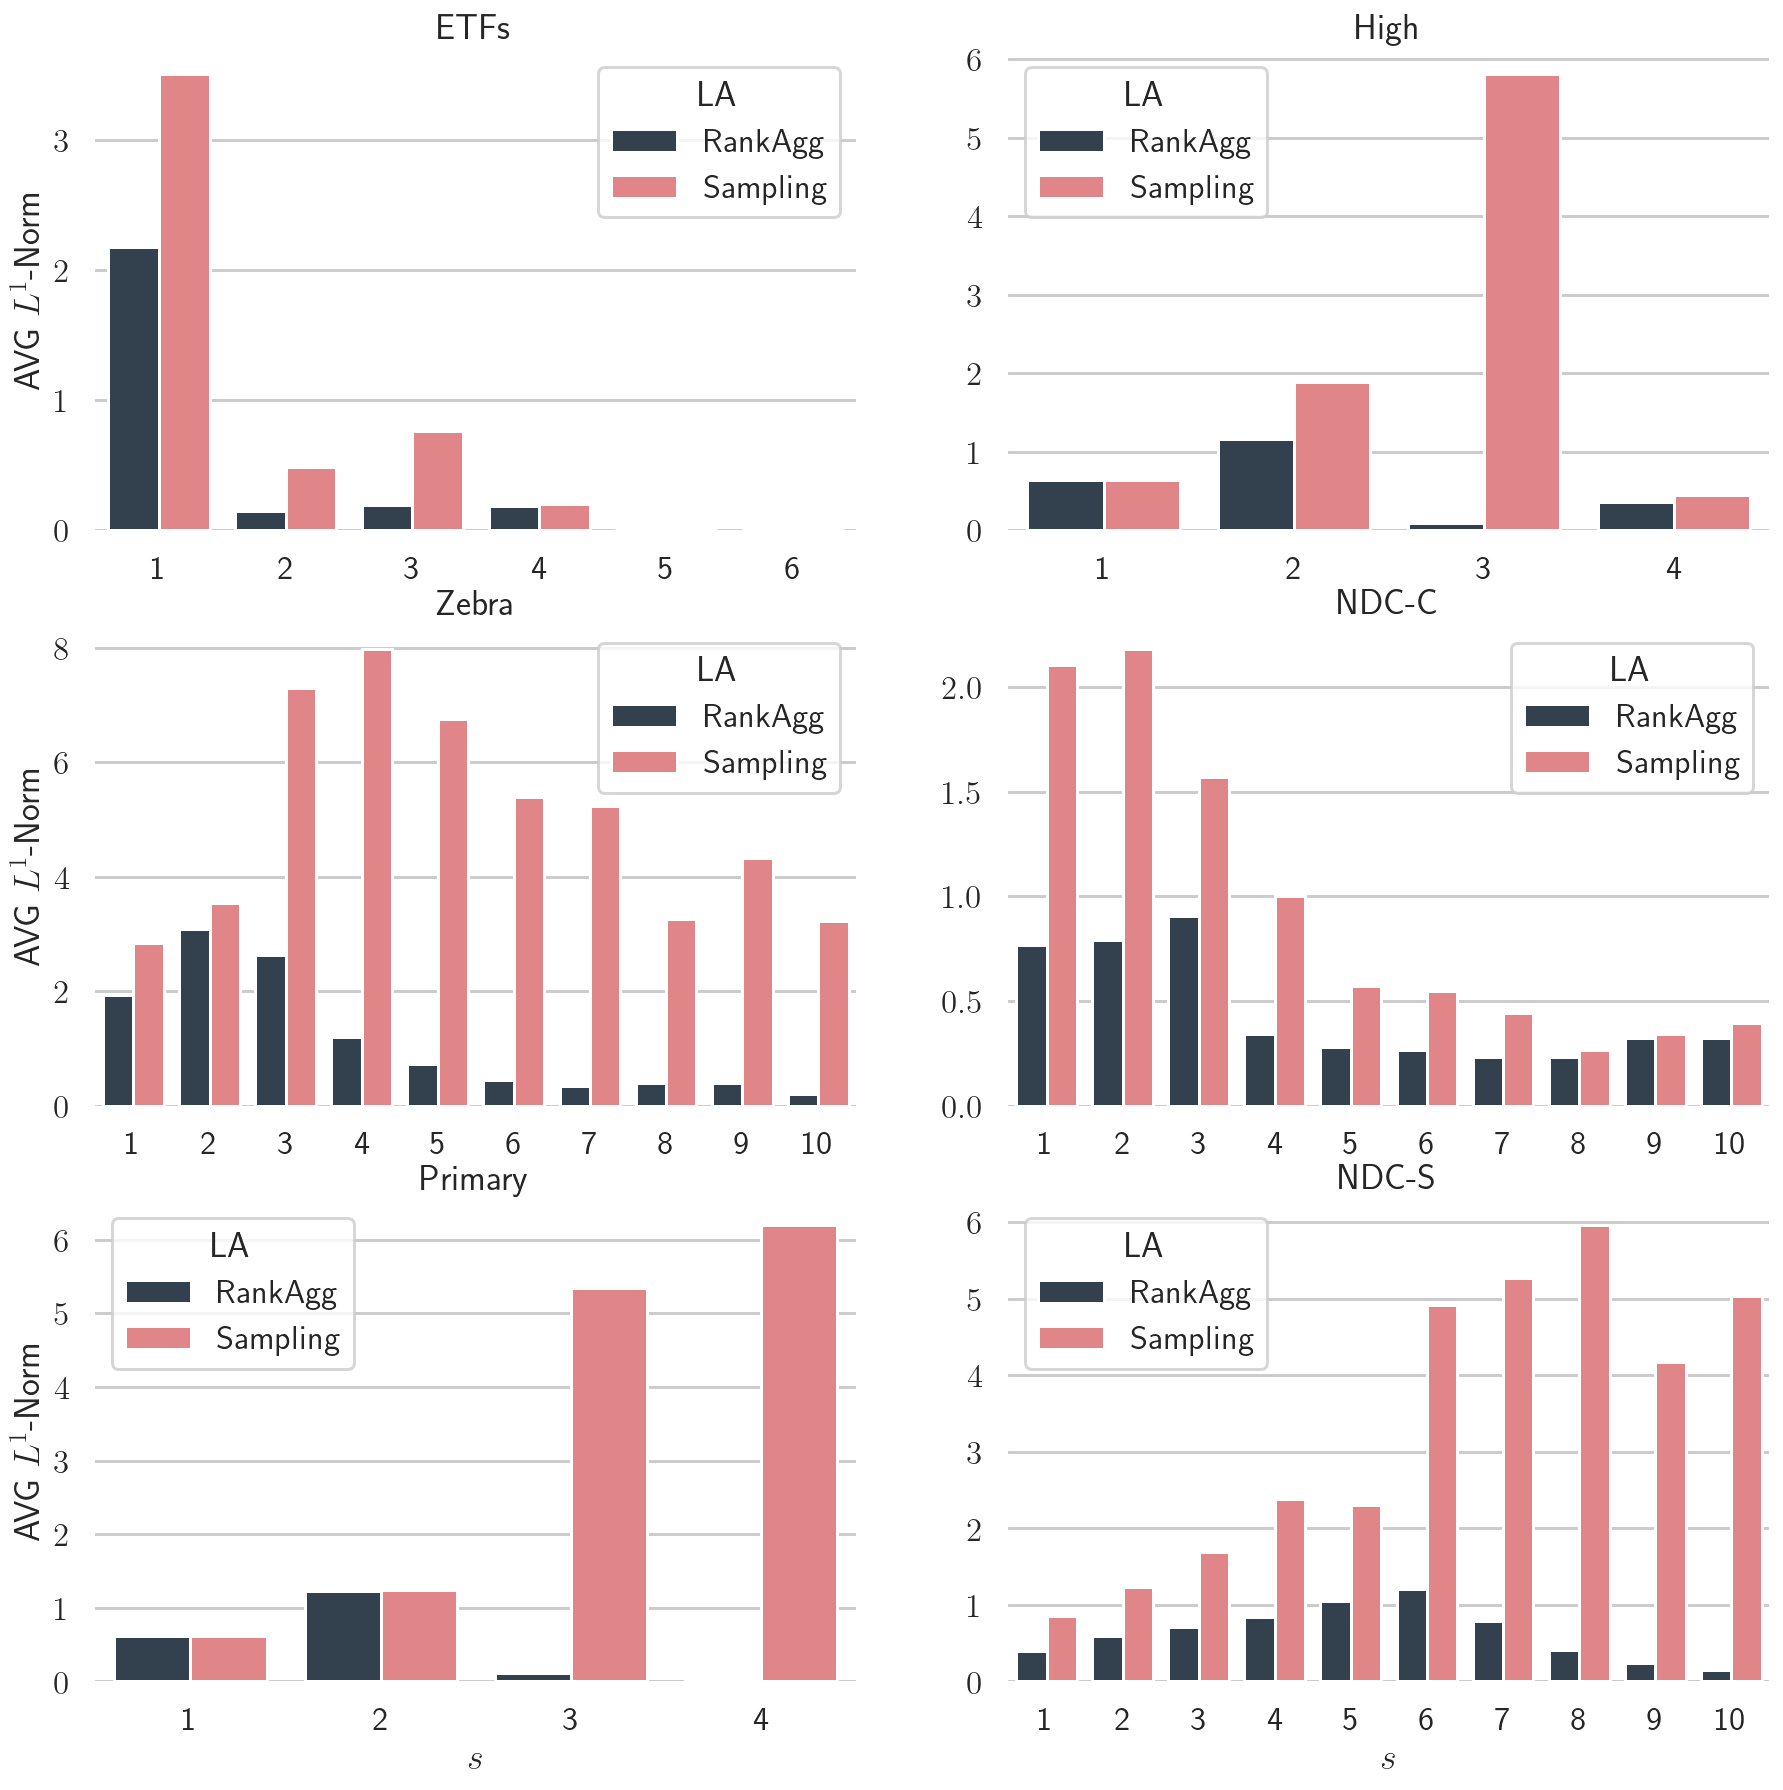

In [145]:
for strategy in all_est['LS'].unique():
    data = all_est[all_est['LS']==strategy].copy()
    data = data.groupby(by=['HyperGraph', 'LA', 's'])[['norm1']].mean().reset_index()

    fig, ax = plt.subplots(3,2,figsize=(15,15))
    print(strategy)
    for idx,graph in enumerate(all_est['HyperGraph'].unique()):
        data1 = data[data['HyperGraph']==graph]
        p_x = idx % 3  
        p_y = idx // 3
    
        sns.barplot(data=data1, x='s', y='norm1', hue='LA', palette=palette, 
                    ax=ax[p_x][p_y])
        ax[p_x][p_y].set_xlabel(r'$s$')
        ax[p_x][p_y].set_ylabel(r'AVG $L^1$-Norm')
        ax[p_x][p_y].spines['right'].set_visible(False)
        ax[p_x][p_y].spines['top'].set_visible(False)
        ax[p_x][p_y].spines['left'].set_visible(False)
        ax[p_x][p_y].spines['bottom'].set_visible(False)

        if p_y != 0:
            ax[p_x][p_y].set_ylabel('')
        if p_x != 2:
            ax[p_x][p_y].set_xlabel('')
        ax[p_x][p_y].set_title(graph)

    plt.show()

In [449]:
all_est = acc_la.groupby(by=['HyperGraph', 
                             'src', 
                             'dst', 
                             's', 
                             'd',
                             'LS', 
                             'LA']).agg({'d_hat':'mean'}).reset_index()

In [452]:
accuracies = []
for la in all_est['LA'].unique():
    df = all_est[all_est['LA']==la]
    for g in df['HyperGraph'].unique():
        df2 = df[df['HyperGraph']==g]
        y_true = df2['d'].values
        y_pred = df2['d_hat'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        accuracies.append([g, la, mae, rmse])

In [453]:
acc_df = pd.DataFrame(accuracies, columns=['HyperGraph', 'LA Strategy', 'MAE', 'RMSE'])

In [455]:
acc_df.sort_values(by='HyperGraph')

HyperGraph LA Strategy       MAE      RMSE
0        ETFs     RankAgg  0.598038  1.548989
6        ETFs    Sampling  0.748910  1.620075
1        High     RankAgg  0.941090  1.570276
7        High    Sampling  1.216705  1.869133
2       NDC-C     RankAgg  0.444172  0.856376
8       NDC-C    Sampling  0.515047  0.897248
3       NDC-S     RankAgg  0.701906  1.128627
9       NDC-S    Sampling  0.873218  1.231177
4     Primary     RankAgg  0.788141  1.183266
10    Primary    Sampling  0.997270  1.311820
5       Zebra     RankAgg  1.328808  2.416193
11      Zebra    Sampling  1.644465  2.396266

### Exact Estimates

In [146]:
exact_est = acc_la.copy()
exact_est['Exact'] = exact_est['d_hat']==exact_est['d']
exact_est = exact_est.groupby(by=['HyperGraph', 's', 'LS', 'LA']).agg({'Exact' : ['count', 'sum']}).reset_index()

In [147]:
exact_est.columns = exact_est.columns.droplevel(0)
exact_est.columns = ['HyperGraph', 's', 'LS', 'LA', 'Total', 'Exact']
exact_est['Exact (%)'] = (exact_est['Exact'] / exact_est['Total'])

In [148]:
highest_perc = exact_est.groupby(by=['HyperGraph', 'LS', 'LA'])[['Total', 'Exact']].sum().reset_index()
highest_perc['Perc'] = highest_perc['Exact'] / highest_perc['Total']
highest_perc = highest_perc.sort_values(by='Perc', ascending=False)
first_method = highest_perc['LA'].values[0]
methods = list(highest_perc['LA'].unique())
methods.remove(first_method)
second_method = methods[0]

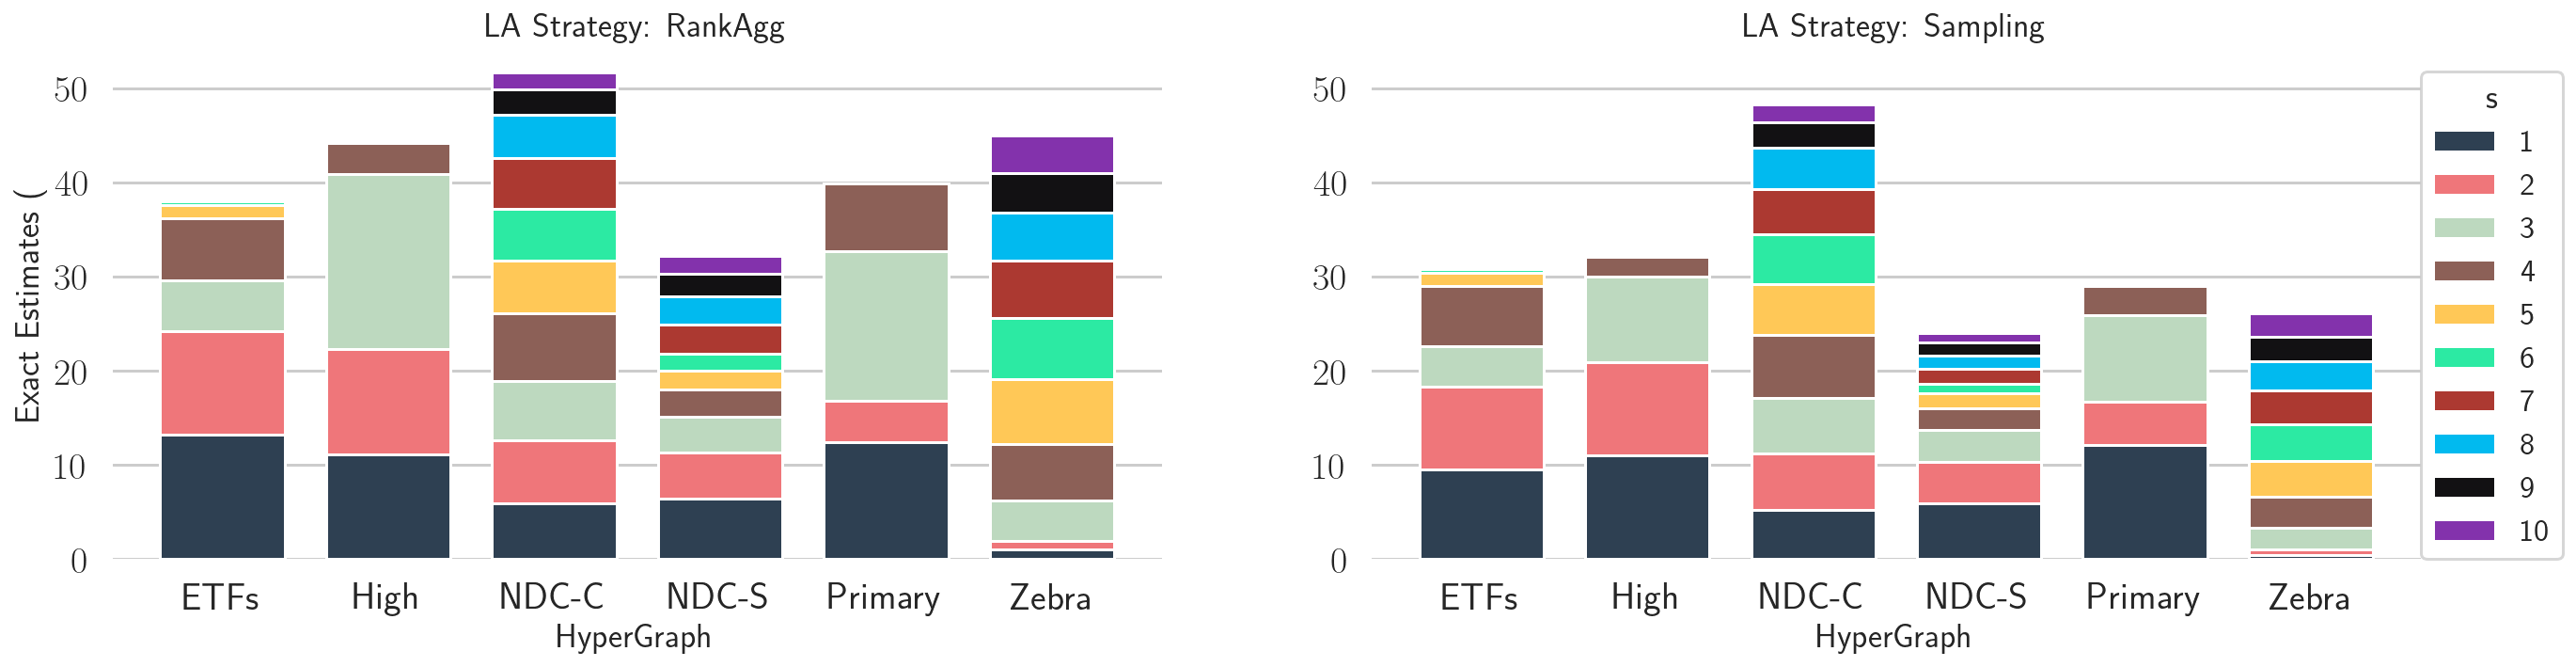

In [149]:
ss = sorted(list(exact_est['s'].unique()))
data = exact_est[exact_est['LS']=='Degree']
labels = list(data['HyperGraph'].unique())
ind = np.arange(len(labels)) * 40

fig = plt.figure(figsize=(22,5))
axes = []

for idx,method in enumerate([first_method, second_method]):
    
    data2=data[data['LA']==method]
    
    bars = defaultdict(list)
    for label in labels:
        for s in ss:
            label_df = data2[data2['HyperGraph']==label]
            total_q = label_df['Total'].sum() * 1.
            exacts = label_df[label_df['s'] == s]['Exact'].values
            if len(exacts) > 0:
                bars[s].append((exacts[0]/total_q) * 100)
            else:
                bars[s].append(0)

    if len(axes) > 0:
        ax = plt.subplot(1,2,idx+1, sharey=axes[0])
    else:
        ax = plt.subplot(1,2,idx+1)
    ax.grid(axis='y', zorder=0)
    ax.bar(ind, bars[ss[0]], label=f'{ss[0]}', color=palette[0], width=30, zorder=3)
    tmp = np.array(bars[ss[0]])
    for idx in range(1,len(ss)):
        ax.bar(ind, bars[ss[idx]], bottom=tmp, color=palette[idx], 
               label=f'{ss[idx]}', width=30, zorder=3)
        tmp = np.add(tmp, bars[ss[idx]])
        
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel('HyperGraph')
    ax.set_ylabel('Exact Estimates (%)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend(title='s', loc=(1,0))
    ax.set_title(f'LA Strategy: {method}')
    axes.append(ax)

axes[0].legend().remove()
axes[1].set_ylabel('')
plt.show()

# Comparison between LS strategies

Settings

In [470]:
lb=4
maxS=10
# sample size
queryS=100
# query sample size
sampleS=0.4
landNum=30
landmarkSel=['random', 'degree', 'farthest', 'bestcover', 'between']
# how to assign landmarks to s-ccs
landmarkAss='prob'
# importance of s-cc size
alpha=0.2
# importance of s
beta=0.6

Statistics

In [471]:
stats = pd.DataFrame()
for t in range(1,tests+1):
    stats = stats.append(pd.read_csv(outfile_path+f'selection/{t}/statistics.csv', header=None, sep='\t'))

In [472]:
stats.columns = ['HyperGraph', 'Timestamp', 'Offline', 
                 'Online', 'maxS', 'lb', 'Q', 'NumLands', 'OracleSize',
                 'NumQueries', 'LS', 'LA', 'Alpha', 'Beta']
stats.drop(columns=['Timestamp', 'lb', 'maxS'], inplace=True)

In [473]:
stats['QuerySample'] = int(len(stats) / 5) * list(range(5))

In [474]:
agg_stats = stats.groupby(by=['HyperGraph', 
                              'Q', 'LS']).agg({'Offline':'mean',
                                               'NumLands': ['min', 'max', 'mean'],
                                               'OracleSize': ['min', 'max', 'mean']})

In [475]:
agg_stats = agg_stats.reset_index()
agg_stats.columns = agg_stats.columns.droplevel(0)
agg_stats.columns = ['HyperGraph', 'Q', 'LS', 'Offline', 
                     'minL', 'maxL', 'meanL', 
                     'minO', 'maxO', 'meanO']

## Comparison Creation Time

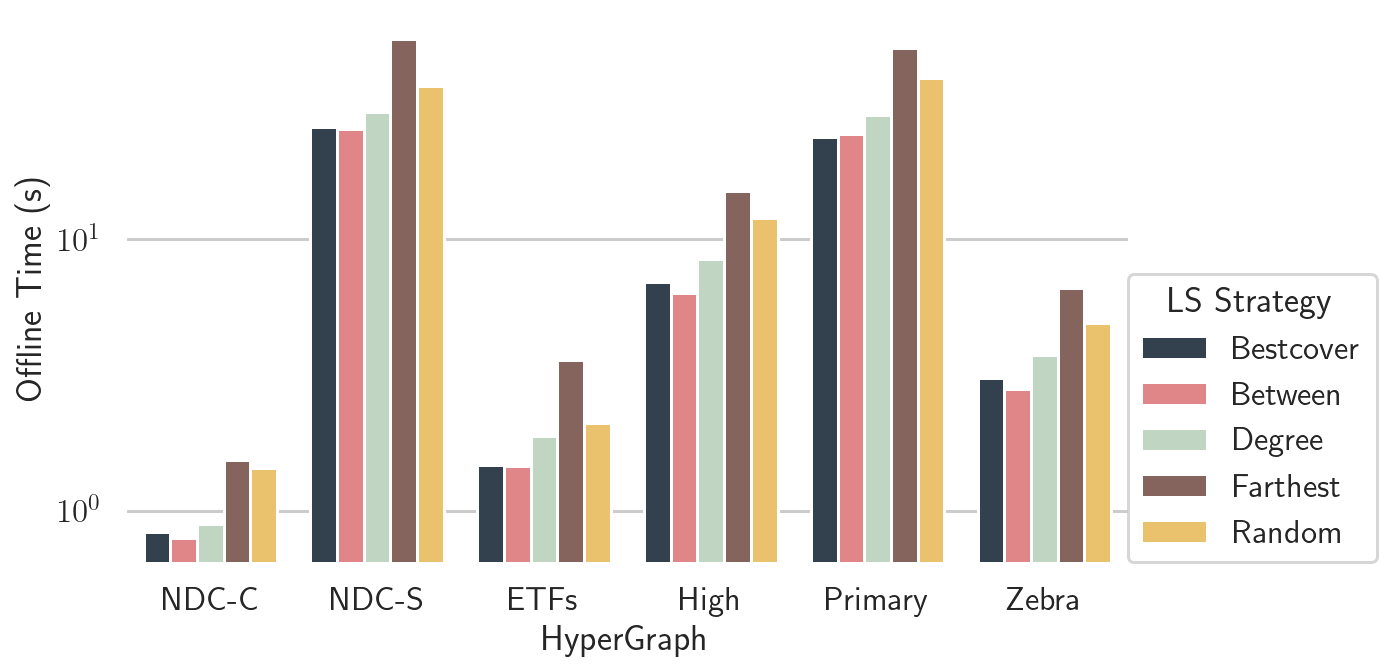

In [157]:
fig, ax = plt.subplots(figsize=(10,5))
data=agg_stats[agg_stats['Q']==30].copy()
data['HyperGraph'] = data['HyperGraph'].apply(rename_graph)
data['LS'] = data['LS'].apply(rename_ls)

sns.barplot(data=data, x='HyperGraph', y='Offline', hue='LS', palette=palette, ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(title='LS Strategy', loc=(1,0))
ax.set_yscale('log')
ax.set_ylabel('Offline Time (s)')
plt.tight_layout()
plt.savefig(fig_path+'comparison_ls_creation.pdf')
plt.show()

## Comparison Accuracy

In [482]:
acc_la = pd.DataFrame()

In [483]:
path = outfile_path + 'selection'
for run in product(graphs_prelims,
                  range(5),
                  landmarkSel,
                  range(1, 11)):
    graph = run[0]
    i = run[1]
    ls = run[2]
    t = run[3]
    path2 = f'{path}/{t}'
    try:
        if ls == 'between' or ls == 'bestcover':
            strategy = f'{ls}_{sampleS}'
        else:
            strategy = ls
        fileName = f'{graph}_S{maxS}_L{landNum}_LB{lb}_Q{queryS}_M{strategy}'
        fileName += f'_LA{landmarkAss}_A{alpha}_B{beta}_IDsample{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp.loc[(tmp['lb']==1.0) & (tmp['ub']==3.0), 'd_hat'] = 1.15
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = rename_ls(ls)
        tmp['QuerySample'] = i
        acc_la = acc_la.append(tmp, ignore_index=True)
    except Exception as e:
        print(e)
        pass

### Infinite Estimates

In [484]:
inf_est = acc_la.copy()
inf_est['Inf'] = inf_est['d_hat'] == -1
inf_est = inf_est.groupby(by=['HyperGraph', 's', 'LS']).agg({'Inf' : ['count', 'sum']}).reset_index()

In [485]:
inf_est.columns = inf_est.columns.droplevel(0)
inf_est.columns = ['HyperGraph', 's', 'LS', 'Total', 'Inf']
inf_est['Inf (%)'] = (inf_est['Inf'] / inf_est['Total']) * 100

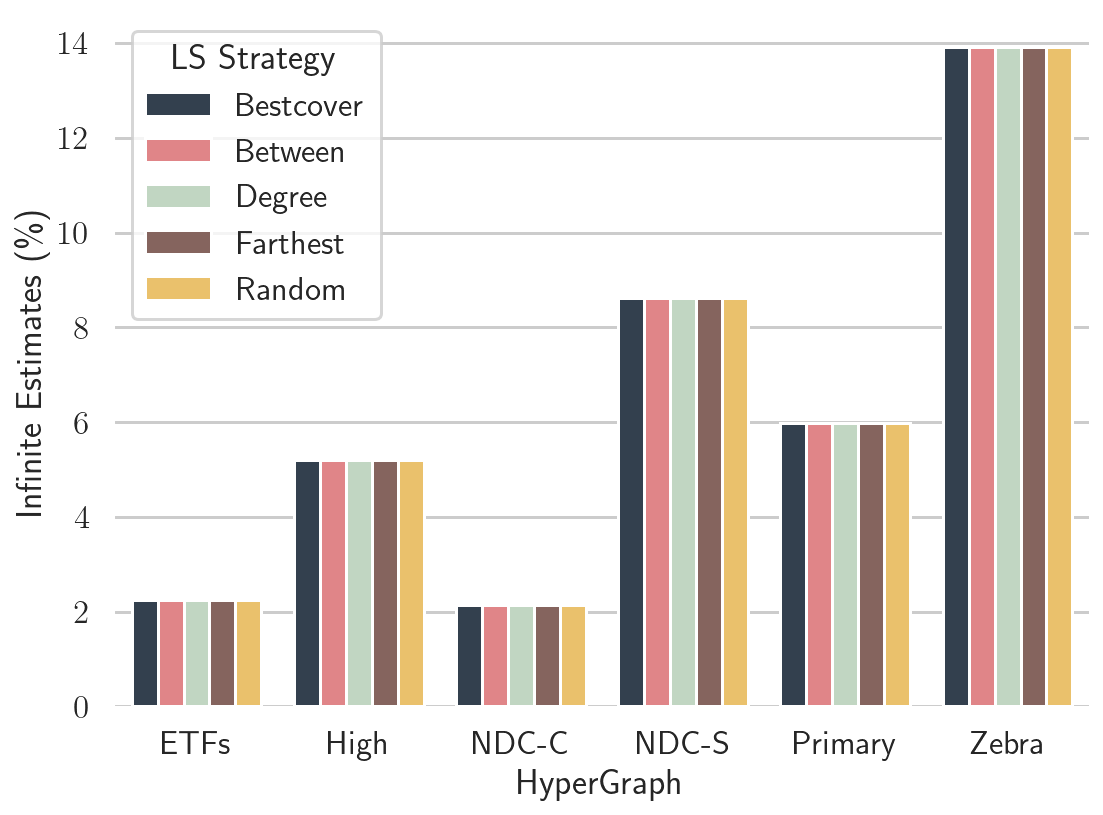

In [486]:
data = inf_est.copy()
data1 = data.groupby(by=['HyperGraph', 'LS'])[['Total', 'Inf']].sum().reset_index()
data1['Inf (%)'] = (data1['Inf'] / data1['Total']) * 100

if len(data1[data1['Inf']>0]) > 0:
    fig, ax = plt.subplots(figsize=(8,6))
    sns.barplot(data=data1, x='HyperGraph', y='Inf (%)', hue='LS', palette=palette, ax=ax)
    ax.set_ylabel('Infinite Estimates (\%)')
    ax.legend(title='LS Strategy')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

### L1-norm for all estimates

In [487]:
all_est = acc_la.copy()
all_est['norm1'] = all_est['d_hat'] - all_est['d']
all_est['norm1'] = all_est['norm1'].apply(abs)
max_norm = all_est['norm1'].max()
all_est.loc[all_est['d_hat']==-1, 'norm1'] = max_norm * 1.5

In [488]:
all_est.sort_values(by='LS', inplace=True)

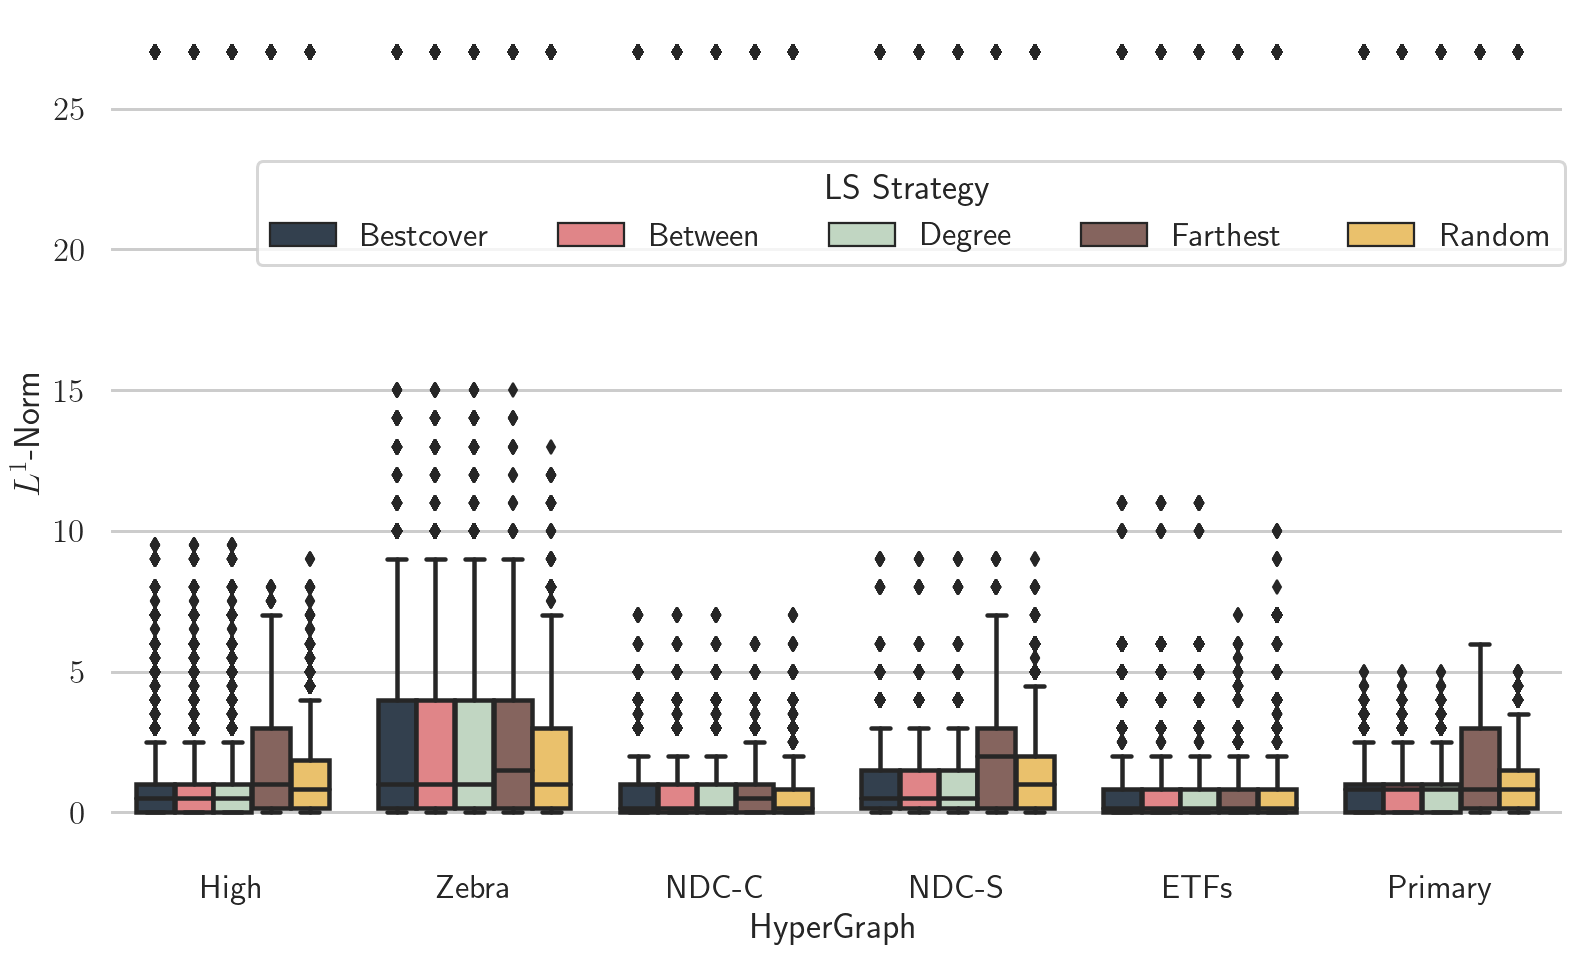

In [492]:
fig, ax = plt.subplots(figsize=(12,7))
sns.boxplot(data=all_est, x='HyperGraph', y='norm1',
               hue='LS', palette=palette, ax=ax)

ax.set_ylabel(r'$L^1$-Norm')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend(title='LS Strategy', ncol=5, loc=(0.1,0.7))
plt.tight_layout()
plt.savefig(fig_path+'comparison_ls_norm.pdf')
plt.show()

### MAE

In [493]:
all_est = acc_la.groupby(by=['HyperGraph', 
                             'src', 
                             'dst', 
                             's', 
                             'd',
                             'LS']).agg({'d_hat':'mean'}).reset_index()

In [495]:
accuracies = []
for ls in all_est['LS'].unique():
    df = all_est[all_est['LS']==ls]
    for g in df['HyperGraph'].unique():
        df2 = df[df['HyperGraph']==g]
        y_true = df2['d'].values
        y_pred = df2['d_hat'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        accuracies.append([g, ls, mae, rmse])

In [496]:
acc_df = pd.DataFrame(accuracies, columns=['HyperGraph', 'LS Strategy', 'MAE', 'RMSE'])

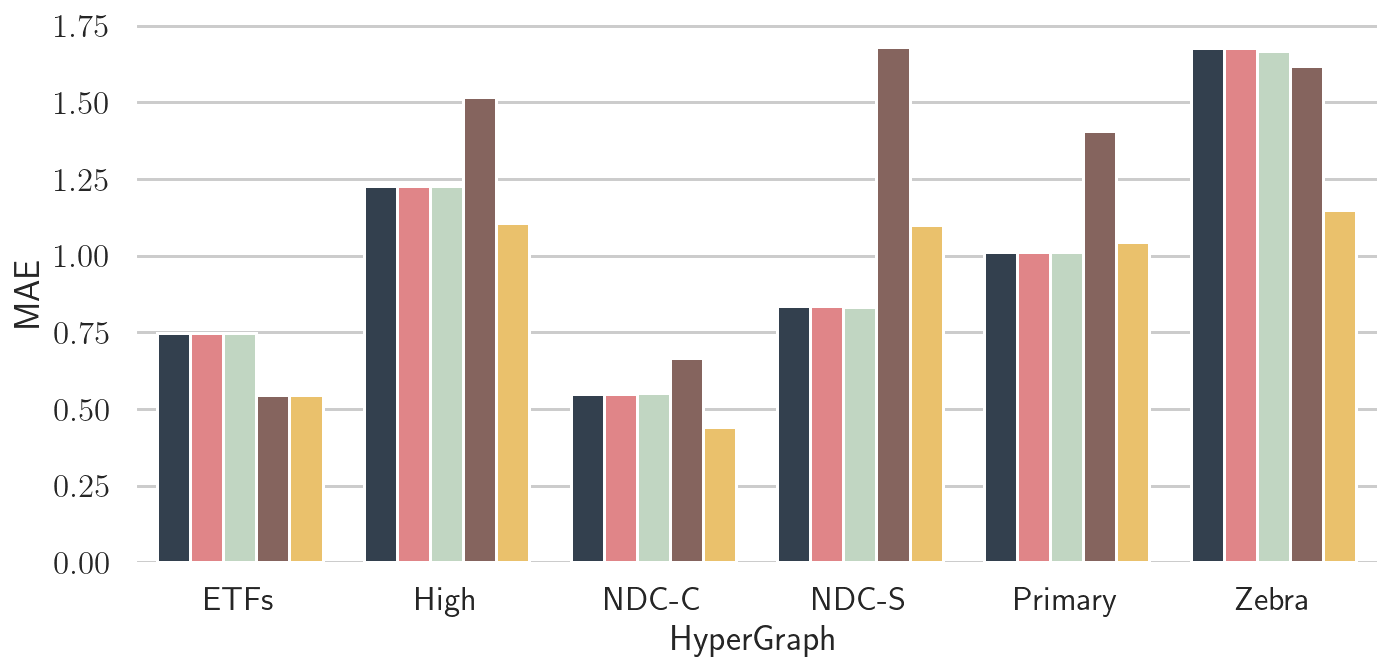

In [503]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=acc_df, x='HyperGraph', y='MAE',
            hue='LS Strategy', palette=palette, ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.legend().remove()
plt.tight_layout()
plt.savefig(fig_path+'comparison_ls_mae.pdf')
plt.show()

# Scalability

Output

In [227]:
path = outfile_path + 'scalability'
dfs = []

for run in product(graphs_all,
                   list(range(1, 6)),
                   [10, 20, 100, 200]):
    graph = run[0]
    i = run[1]
    l = run[2]
    path2 = f'{path}/{i}'
    try:
        fileName = f'{graph}_S10_L{l}_LB4_Q100_Mdegree'
        fileName += f'_LAprob_A0.2_B0.6_IDedge{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = 'Degree'
        tmp['QuerySample'] = i
        tmp['Q'] = l
        tmp['LA'] = 'prob'
        dfs.append(tmp)
    except Exception as e:
        print(e)
        pass
queries = pd.concat(dfs)

[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/5/dblp.hg_S10_L200_LB4_Q100_Mdegree_LAprob_A0.2_B0.6_IDedge5.txt'
[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/4/enron.hg_S10_L200_LB4_Q100_Mdegree_LAprob_A0.2_B0.6_IDedge4.txt'
[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/5/enron.hg_S10_L200_LB4_Q100_Mdegree_LAprob_A0.2_B0.6_IDedge5.txt'
[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/1/FS_NYC.hg_S10_L10_LB4_Q100_Mdegree_LAprob_A0.2_B0.6_IDedge1.txt'
[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/1/FS_NYC.hg_S10_L20_LB4_Q100_Mdegree_LAprob_A0.2_B0.6_IDedge1.txt'
[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/1/FS_NYC.hg_S10_L100_LB4_Q100_Mdegree_LAprob_A0.2_B0.6_IDedge1.txt'
[Errno 2] No such file or directory: '/Users/giulia/Desktop/output/scalability/1/FS_NYC.hg_S10_L200_LB4_Q100_Mdegree_LAprob_

In [228]:
num_queries = queries.groupby(by=['HyperGraph',
                                  'Q', 'LS', 'LA',
                                  'QuerySample']).agg({'d_hat':'count'}).reset_index()

Statistics

In [240]:
dfs = []
for t in range(1,6):
    dfs.append(pd.read_csv(outfile_path+f'scalability/{t}/statistics.csv', header=None, sep='\t'))
stats = pd.concat(dfs)    
stats.columns = ['HyperGraph', 'Timestamp', 'Offline', 
                 'Online', 'maxS', 'lb', 'Q', 'NumLands', 'OracleSize',
                 'NumQueries', 'LS', 'LA', 'Alpha', 'Beta']

In [241]:
stats['LS'] = stats['LS'].apply(rename_ls)
stats['HyperGraph'] = stats['HyperGraph'].apply(rename_graph)

In [242]:
stats = stats.merge(num_queries)
stats['TimeXQ'] = stats['Online'] / stats['d_hat']

In [243]:
agg_stats = stats.groupby(by=['HyperGraph', 
                              'Q', 'LS']).agg({'TimeXQ':'mean', 
                                                'Offline':'mean',
                                                'NumLands': ['min', 'max', 'mean'],
                                                'OracleSize': ['min', 'max', 'mean']})

In [244]:
agg_stats = agg_stats.reset_index()
agg_stats.columns = agg_stats.columns.droplevel(0)
agg_stats.columns = ['HyperGraph', 'Q', 'LS', 'TimeXQ', 'Offline', 
                     'minL', 'maxL', 'meanL', 'minO', 'maxO', 'meanO']

In [245]:
agg_stats = agg_stats[(agg_stats['HyperGraph']!= 'dblp_v9.hg') &
                      (agg_stats['LS']=='Degree')]

## Creation Time

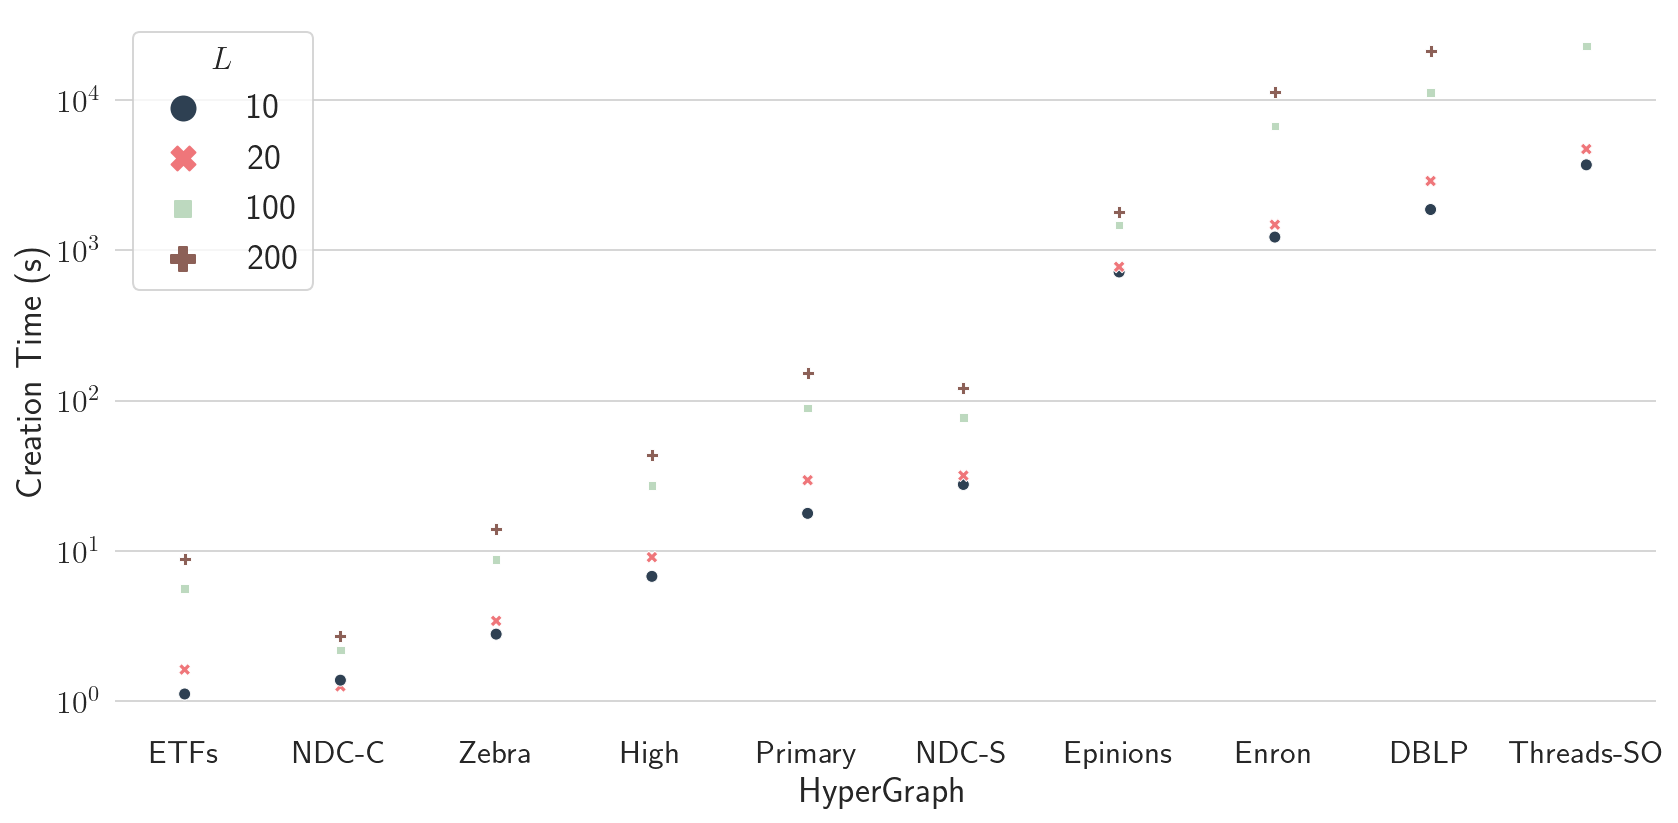

In [246]:
fig, ax = plt.subplots(figsize=(12,6))

data = agg_stats[agg_stats['Q'].isin([10,20,100,200])].copy()
data.sort_values(by='Offline', inplace=True)
sns.scatterplot(data=data, x='HyperGraph', y='Offline', hue='Q', 
                style='Q', palette=palette[:4], ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yscale('log')
ax.set_ylabel('Creation Time (s)')
ax.legend(title=r'$L$')
#     ax.set_title(fr'{strat}: $|Q|=L*|E|$')
plt.tight_layout()
plt.savefig(fig_path+f'scalability_creation_Degree.pdf')
plt.show()

## Query Time

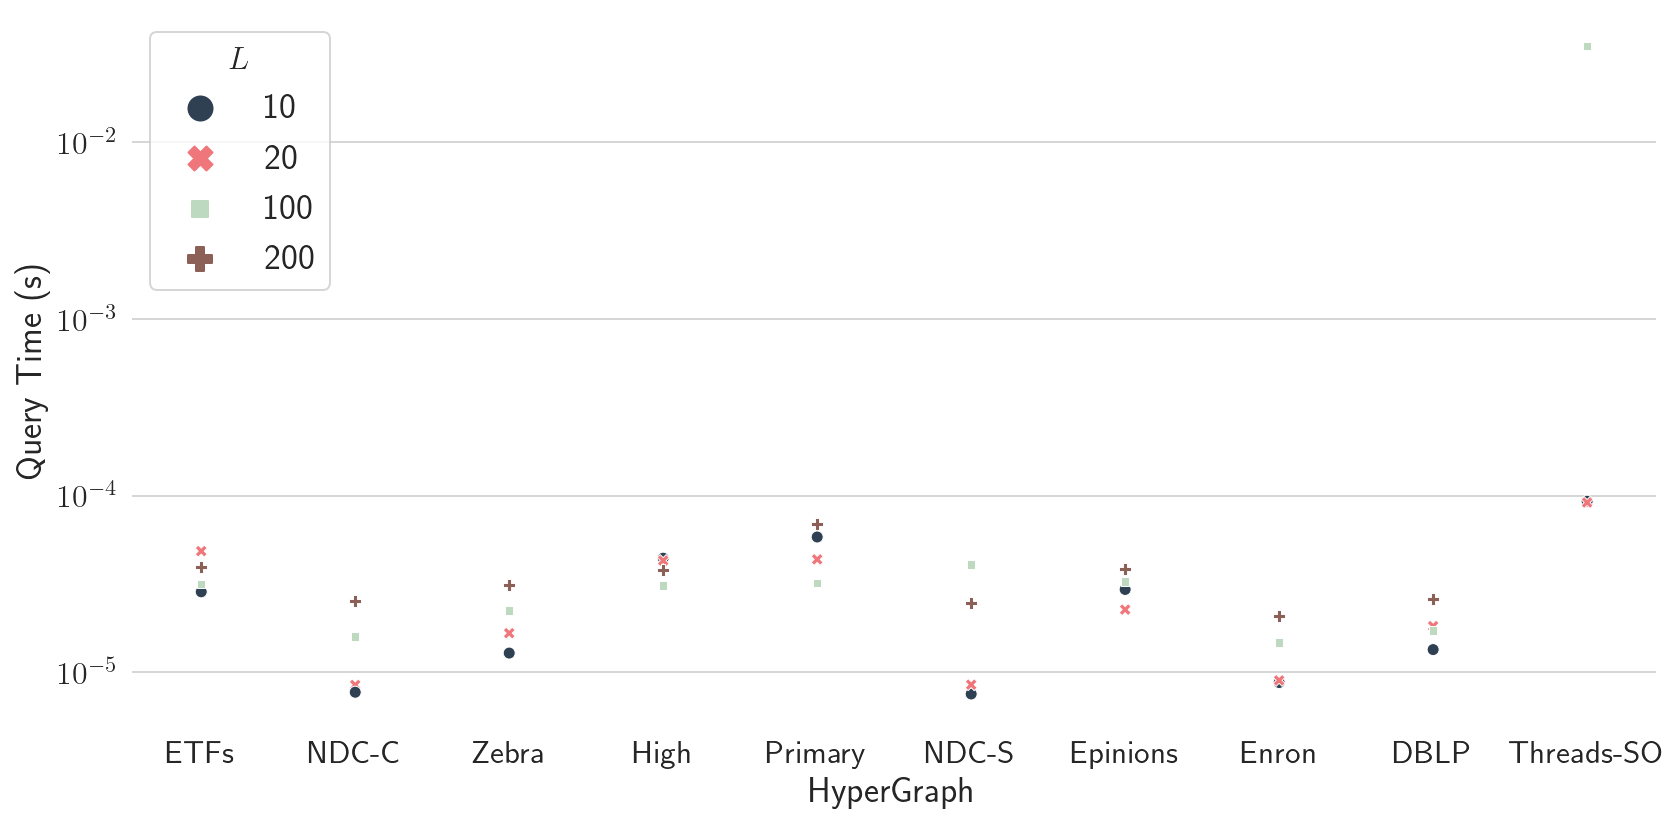

In [247]:
fig, ax = plt.subplots(figsize=(12,6))

data = agg_stats[agg_stats['Q'].isin([10,20,100,200])].copy()
data.sort_values(by='Offline', inplace=True)
sns.scatterplot(data=data, x='HyperGraph', y='TimeXQ', hue='Q', 
                style='Q', palette=palette[:4], ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Query Time (s)')
ax.set_yscale('log')
ax.legend(title=r'$L$')
#     ax.set_title(fr'{strat}: $|Q|=L*|E|$')
plt.tight_layout()
plt.savefig(fig_path+f'scalability_query_Degree.pdf')
plt.show()

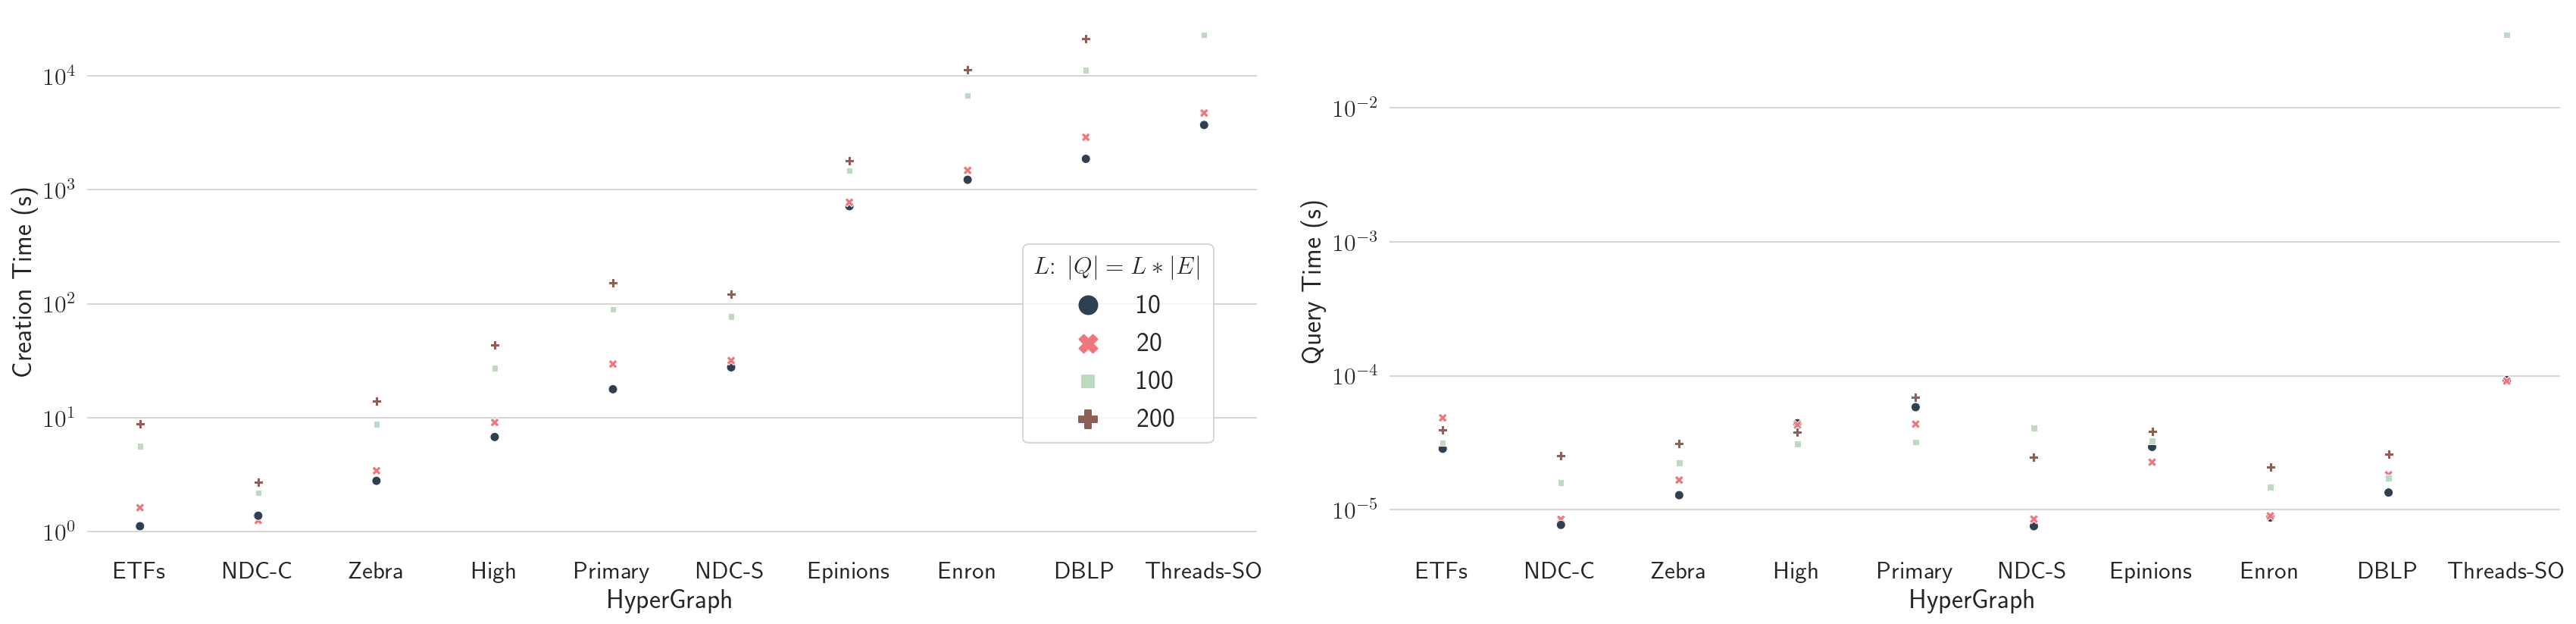

In [248]:
fig, ax = plt.subplots(1,2, figsize=(24,6))

data = agg_stats[agg_stats['Q'].isin([10,20,100,200])].copy()
data.sort_values(by='Offline', inplace=True)

sns.scatterplot(data=data, x='HyperGraph', y='Offline', hue='Q', 
                style='Q', palette=palette[:4], ax=ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_yscale('log')
ax[0].set_ylabel('Creation Time (s)')
ax[0].legend(title=r'$L$: $|Q|=L*|E|$', loc=(0.8,0.2))

sns.scatterplot(data=data, x='HyperGraph', y='TimeXQ', hue='Q', 
                style='Q', palette=palette[:4], ax=ax[1])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_ylabel('Query Time (s)')
ax[1].set_yscale('log')
ax[1].legend().remove()
plt.tight_layout()
plt.savefig(fig_path+f'scalability_all_times.pdf')
plt.show()

# Search By Tag

## FourSquare

Load Labels

In [300]:
nyc_labels_f = graph_path + 'FS_NYC_labels'
nyc_labels = dict()

with open(nyc_labels_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0])
        name = lst[1]
        nyc_labels[idx] = name

In [301]:
tky_labels_f = graph_path + 'FS_TKY_labels'
tky_labels = dict()

with open(tky_labels_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0])
        name = lst[1]
        tky_labels[idx] = name

In [307]:
def get_label_fs(graph, s):
    if graph == 'NYC':
        return nyc_labels[s]
    return tky_labels[s]

Load Output

In [311]:
path = outfile_path + 'search'
dfs = []
for run in product([30], 
                   ['degree', 'bestcover', 'farthest'], 
                   ['NYC', 'TKY']):
    l = run[0]
    ls = run[1]
    graph = run[2]
    try:
        if ls == 'between' or ls == 'bestcover':
            strategy = f'{ls}_0.4'
        else:
            strategy = ls
        fileName = f'FS_{graph}.hg_S10_L{l}_LB4_Q100_M{strategy}'
        fileName += f'_LAprob_A0.2_B0.6_IDreachWTag10.txt'
        tmp = pd.read_csv(f'{path}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph
        tmp['LS'] = rename_ls(ls)
        tmp['Q'] = l
        tmp['SrcLabel'] = tmp['src'].apply(lambda x : get_label_fs(graph, x))
        tmp['DstLabel'] = tmp['dst'].apply(lambda x : get_label_fs(graph, x))
        dfs.append(tmp)
    except Exception as e:
        print(e)
        pass

fs_df = pd.concat(dfs)

In [312]:
fs_df = fs_df[fs_df['src']!=fs_df['dst']]

In [315]:
fs_nyc_pre = list()
for run in product(fs_df['s'].unique(), 
                   fs_df['LS'].unique(),
                   fs_df['Q'].unique(),
                   [3,5,7]):
    s = run[0]
    ls = run[1]
    q = run[2]
    k = run[3]
    data = fs_df[fs_df['HyperGraph']=='NYC']
    fs_nyc_pre.extend(get_precision_top_k(data, s, ls, q, k))

In [318]:
fs_tky_pre = list()
for run in product(fs_df['s'].unique(), 
                   fs_df['LS'].unique(),
                   fs_df['Q'].unique(),
                   [3,5,7]):
    s = run[0]
    ls = run[1]
    q = run[2]
    k = run[3]
    data = fs_df[fs_df['HyperGraph']=='TKY']
    fs_tky_pre.extend(get_precision_top_k(data, s, ls, q, k))

In [319]:
fs_pre_df = pd.DataFrame(fs_nyc_pre)
fs_pre_df.columns = ['Source', 's', 'LS', 'Q', 'k', 'Pre@k']
fs_pre_df['HyperGraph'] = 'NYC'

tmp = pd.DataFrame(fs_tky_pre)
tmp.columns = ['Source', 's', 'LS', 'Q', 'k', 'Pre@k']
tmp['HyperGraph'] = 'TKY'
fs_pre_df = pd.concat([fs_pre_df, tmp])

In [320]:
summary_df = fs_pre_df.groupby(by=['HyperGraph', 's', 'LS', 'Q', 'k']).agg({'Pre@k' : ['min', 'mean', 'max']})

In [321]:
summary_df = summary_df.reset_index()
summary_df.columns = summary_df.columns.droplevel(0)

In [322]:
summary_df.columns = ['HyperGraph', 's', 'LS', 'Q', 'k', 'mPre@k', 'aPre@k', 'MPre@k']

In [323]:
summary_df[(summary_df['k']==7)]

HyperGraph   s         LS   Q  k    mPre@k    aPre@k  MPre@k
2          NYC   1  Bestcover  30  7  0.142857  0.756494     1.0
5          NYC   1     Degree  30  7  0.142857  0.756494     1.0
8          NYC   1   Farthest  30  7  0.000000  0.470779     1.0
11         NYC   2  Bestcover  30  7  0.000000  0.655844     1.0
14         NYC   2     Degree  30  7  0.000000  0.655844     1.0
17         NYC   2   Farthest  30  7  0.000000  0.610390     1.0
20         NYC   3  Bestcover  30  7  0.000000  0.818182     1.0
23         NYC   3     Degree  30  7  0.000000  0.818182     1.0
26         NYC   3   Farthest  30  7  0.000000  0.564935     1.0
29         NYC   4  Bestcover  30  7  0.000000  0.782468     1.0
32         NYC   4     Degree  30  7  0.000000  0.782468     1.0
35         NYC   4   Farthest  30  7  0.000000  0.620130     1.0
38         NYC   5  Bestcover  30  7  0.000000  0.775000     1.0
41         NYC   5     Degree  30  7  0.000000  0.775000     1.0
44         NYC   5   Farthest  30  7  0.000000  0.642857     1.0
47         NYC   6  Bestcover  30  7  0.000000  0.787879     1.0
50         NYC   6     Degree  30  7  0.000000  0.787879     1.0
53         NYC   6   Farthest  30  7  0.000000  0.675325     1.0
56         NYC   7  Bestcover  30  7  0.000000  0.757764     1.0
59         NYC   7     Degree  30  7  0.000000  0.757764     1.0
62         NYC   7   Farthest  30  7  0.285714  0.788820     1.0
65         NYC   8  Bestcover  30  7  0.142857  0.857143     1.0
68         NYC   8     Degree  30  7  0.142857  0.857143     1.0
71         NYC   8   Farthest  30  7  0.142857  0.785714     1.0
74         NYC   9  Bestcover  30  7  0.714286  0.948980     1.0
77         NYC   9     Degree  30  7  0.714286  0.948980     1.0
80         NYC   9   Farthest  30  7  0.714286  0.938776     1.0
83         NYC  10  Bestcover  30  7  1.000000  1.000000     1.0
86         NYC  10     Degree  30  7  1.000000  1.000000     1.0
89         NYC  10   Farthest  30  7  0.571429  0.957143     1.0
92         TKY   1  Bestcover  30  7  0.142857  0.543956     1.0
95         TKY   1     Degree  30  7  0.142857  0.543956     1.0
98         TKY   1   Farthest  30  7  0.142857  0.554945     1.0
101        TKY   2  Bestcover  30  7  0.142857  0.725275     1.0
104        TKY   2     Degree  30  7  0.142857  0.725275     1.0
107        TKY   2   Farthest  30  7  0.285714  0.780220     1.0
110        TKY   3  Bestcover  30  7  0.571429  0.873626     1.0
113        TKY   3     Degree  30  7  0.571429  0.873626     1.0
116        TKY   3   Farthest  30  7  0.142857  0.631868     1.0
119        TKY   4  Bestcover  30  7  0.285714  0.807692     1.0
122        TKY   4     Degree  30  7  0.285714  0.807692     1.0
125        TKY   4   Farthest  30  7  0.000000  0.549451     1.0
128        TKY   5  Bestcover  30  7  0.285714  0.879121     1.0
131        TKY   5     Degree  30  7  0.285714  0.879121     1.0
134        TKY   5   Farthest  30  7  0.142857  0.648352     1.0
137        TKY   6  Bestcover  30  7  0.714286  0.983516     1.0
140        TKY   6     Degree  30  7  0.714286  0.983516     1.0
143        TKY   6   Farthest  30  7  0.571429  0.906593     1.0
146        TKY   7  Bestcover  30  7  0.428571  0.940476     1.0
149        TKY   7     Degree  30  7  0.428571  0.940476     1.0
152        TKY   7   Farthest  30  7  0.142857  0.690476     1.0
155        TKY   8  Bestcover  30  7  0.285714  0.877551     1.0
158        TKY   8     Degree  30  7  0.285714  0.877551     1.0
161        TKY   8   Farthest  30  7  0.428571  0.700680     1.0
164        TKY   9  Bestcover  30  7  0.714286  0.957983     1.0
167        TKY   9     Degree  30  7  0.714286  0.957983     1.0
170        TKY   9   Farthest  30  7  0.714286  0.907563     1.0
173        TKY  10  Bestcover  30  7  0.571429  0.937500     1.0
176        TKY  10     Degree  30  7  0.571429  0.937500     1.0
179        TKY  10   Farthest  30  7  0.285714  0.883929     1.0

## IMDB

Load Labels

In [324]:
imdb_labels_f = graph_path + 'IMDB_labels'
imdb_labels = dict()

with open(imdb_labels_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0].split('-')[1])
        name = lst[1]
        imdb_labels[idx] = name

In [325]:
def get_label(s):
    return imdb_labels[s]

In [326]:
imdb_names_f = graph_path + 'IMDB_actor_names'
imdb_names = dict()

with open(imdb_names_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0])
        name = lst[1]
        imdb_names[idx] = name

In [327]:
def get_name(s):
    if s in imdb_names:
        return imdb_names[s]
    return 'None'

In [328]:
imdb_titles_f = graph_path + 'IMDB_titles'
imdb_titles = dict()

with open(imdb_titles_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0])
        name = lst[1]
        imdb_titles[idx] = name

Load Output

In [329]:
path = outfile_path + 'search'
dfs = []
# for run in product([10, 20, 30], 
#                    ['degree', 'bestcover', 'farthest']):
for run in product([30], 
                   ['farthest', 'degree']):
    l = run[0]
    ls = run[1]
    try:
        if ls == 'between' or ls == 'bestcover':
            strategy = f'{ls}_0.2'
        else:
            strategy = ls
        fileName = f'IMDB.hg_S10_L{l}_LB4_Q70_M{strategy}'
        fileName += f'_LAprob_A0.2_B0.6_IDreachWTag10.txt'
        tmp = pd.read_csv(f'{path}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = 'IMDB'
        tmp['LS'] = rename_ls(ls)
        tmp['Q'] = l
        dfs.append(tmp)
    except Exception as e:
        print(e)
        pass
imdb_df = pd.concat(dfs)

In [330]:
imdb_df['SrcLabel'] = imdb_df['src'].apply(get_label)
imdb_df['DstLabel'] = imdb_df['dst'].apply(get_label)
imdb_df['SrcName'] = imdb_df['src'].apply(get_name)
imdb_df['DstName'] = imdb_df['dst'].apply(get_name)

In [331]:
imdb_pre = list()
for run in product(imdb_df['s'].unique(), 
                   imdb_df['LS'].unique(),
                   imdb_df['Q'].unique(),
                   [3,5,7]):
    s = run[0]
    ls = run[1]
    q = run[2]
    k = run[3]
    imdb_pre.extend(get_precision_top_k(imdb_df, s, ls, q, k))

In [332]:
imdb_pre_df = pd.DataFrame(imdb_pre)
imdb_pre_df.columns = ['Source', 's', 'LS', 'Q', 'k', 'Pre@k']

In [333]:
summary_df = imdb_pre_df.groupby(by=['s', 'LS', 'Q', 'k']).agg({'Pre@k' : ['min', 'mean', 'max']})

In [334]:
summary_df = summary_df.reset_index()
summary_df.columns = summary_df.columns.droplevel(0)

In [335]:
summary_df.columns = ['s', 'LS', 'Q', 'k', 'mPre@k', 'aPre@k', 'MPre@k']

In [353]:
print(summary_df[(summary_df['k']==3)].to_latex(index=False, 
                                                float_format='%.3f', 
                                                columns=['s', 'LS', 'aPre@k'],
                                                column_format='rcrrrrr'))

\begin{tabular}{rcrrrrr}
\toprule
 s &       LS &  aPre@k \\
\midrule
 1 &   Degree &   0.326 \\
 1 & Farthest &   0.341 \\
 2 &   Degree &   0.690 \\
 2 & Farthest &   0.714 \\
 3 &   Degree &   0.887 \\
 3 & Farthest &   0.887 \\
 4 &   Degree &   0.967 \\
 4 & Farthest &   0.967 \\
 5 &   Degree &   0.988 \\
 5 & Farthest &   0.988 \\
 6 &   Degree &   0.993 \\
 6 & Farthest &   0.993 \\
 7 &   Degree &   0.997 \\
 7 & Farthest &   0.997 \\
 8 &   Degree &   1.000 \\
 8 & Farthest &   1.000 \\
 9 &   Degree &   1.000 \\
 9 & Farthest &   1.000 \\
10 &   Degree &   1.000 \\
10 & Farthest &   1.000 \\
\bottomrule
\end{tabular}



### Suggestions

Create vertex-hyperedge membership map

In [247]:
imdb_he = load_edges(graph_path+'IMDB.hg')

In [248]:
he_inv = defaultdict(set)
for idx,he in enumerate(imdb_he):
    for v in he:
        he_inv[v].add(idx)

Take nearest actors

In [249]:
sorted_queries = imdb_df[(imdb_df['d_hat']!=-1) & 
                         (imdb_df['src'] != imdb_df['dst']) &
                         (imdb_df['SrcLabel'] == imdb_df['DstLabel']) &
                         (imdb_df['s']>1) & 
                         (imdb_df['LS']=='Degree') &
                         (imdb_df['Q']==30)].sort_values(by='d_hat', ascending=True)

Suggest movies based on nearest actors

In [271]:
suggestions = set()
row_id = 0
while row_id < len(sorted_queries):
    row = sorted_queries.iloc[row_id]
    row_id += 1
    if row['d_hat'] < 1: continue
    src = row['src']
    dst = row['dst']
    if src < dst:
        suggestions.add((src, dst))
    else:
        suggestions.add((dst, src))    

In [272]:
for s,d in suggestions:
    try:
        print(s, imdb_names[s], ' ---> ', d, imdb_names[d])
        print('#### Suggestions ####')
        movies = he_inv[d]
        for movie in movies:
            print(imdb_titles[movie])
        print('\n')
    except:
        continue

454495 Josiah Bennetone  --->  497756 Colin Conners
#### Suggestions ####
Sol Invictus
The Hit
Sex and Drugs


5930 Joseph Vilsmaier  --->  31175 Nikolai Müllerschön
#### Suggestions ####
Show de Bola
Harms
Hostile Takeover
Inversion
Frauen
The Red Baron


4441 Moussa Maaskri  --->  757686 Eduardo Gomes
#### Suggestions ####
Necropolis Symphony
El Mate


164028 Helle Faber  --->  354051 Kevin Proctor
#### Suggestions ####
Funny Cow
In Search of Darkness: Part II
Cordelia
Cult of VHS


12613 Noboru Iguchi  --->  931975 Yûki Kumagai
#### Suggestions ####
Tokyo Living Dead Idol
Ramen kuitee
Rokuroku: The Promise of the Witch


57977 Alex Gibney  --->  867845 Heinz Zak
#### Suggestions ####
The Core
Pit of Swallows: A Grasp for Life


4412 David Proval  --->  109837 James Denton
#### Suggestions ####
Beautiful Dreamer
Karaoke Man
Wake.
Ovation
Grace Unplugged
Revelation Road: The Black Rider
Selfie Dad
Hunger in America


559622 Jaesang Lee  --->  738740 Syd Lim
#### Suggestions ####
The B



556050 Ulrich Elling  --->  861223 Manfred Seitz
#### Suggestions ####
The Green Lie


156818 Mel Raido  --->  388282 Alistair Findlay
#### Suggestions ####
Dead Unicorns
Save Rosemary: The Trinity


8301 Pierre Besson  --->  122099 Hannu Kiviaho
#### Suggestions ####
Finnish Blood Swedish Heart
Komplett galen
Lögner att älska
Babas bilar


15986 Gad Elmaleh  --->  33463 Ray Wise
#### Suggestions ####
Landspeed
Brother's Keeper
FDR: American Badass!
Away from Here
The Flock
No God, No Master
Dead Still
Cyxork 7
Suburban Gothic
The Butterfly Room
Out West
One Missed Call
Sharkskin 6
Star Trek: Captain Pike
Digging Up the Marrow
The Rain Makers
Pandemic
Batman: The Killing Joke
The Aggression Scale
Tone-Deaf
Dead End
Chain of Death
Chillerama
Jurassic City
Land of Leopold
To Your Last Death
Shattered
Jeepers Creepers 2


178293 Julien Deris  --->  194176 Guy Jacoel
#### Suggestions ####
Beautiful Valley
We Are Not Alone
Beyond the Mountains and Hills
Indoors
Mountain
It All Begins at S

#### Suggestions ####
Quarantine Relationship
Christmas Proposal


4441 Moussa Maaskri  --->  7949 Jérémie Renier
#### Suggestions ####
Lorna's Silence
The Child
The War in Paris
White Elephant
Fair Play
Saint Laurent
Summer Hours
Ladygrey
En territoire indien
Les aventures de Philibert, capitaine puceau
Possessions
Coupable
A Heavenly Vintage
Double Lover
Brotherhood of Tears
The Unknown Girl
The Wakhan Front
Carnivores
My Way
Pièce montée
Work Hard, Play Hard
Breath of Life
Albatros
Brotherhood of the Wolf
The Kid with a Bike
The Pornographer
L'ami
Pretend I'm Not Here
Private Property
The Man in the Basement
Waste Land
The Great Man
Slalom
The Enemy
Tomorrow at Dawn
Eternity
Dikkenek
Président


58140 Jorge de Juan  --->  126437 Koldo Serra
#### Suggestions ####
Underground
The Backwoods
Guernica
70 Big Ones


15986 Gad Elmaleh  --->  747875 Asher Avrahami
#### Suggestions ####
Baba Joon


643073 Justin Brown  --->  830432 Jeff Wahlberg
#### Suggestions ####
Don't Come Back from the



717815 Simron Jit Singh  --->  861223 Manfred Seitz
#### Suggestions ####
The Green Lie


1269 Brian Grazer  --->  6739 Paul Trijbits
#### Suggestions ####
Jane Eyre
Tamara Drewe
Chatroom
Paranoid


316210 Alloual  --->  319690 Françoise Brodski
#### Suggestions ####
Homme portant


670714 Kyle Jones  --->  980559 Ben Bunnag
#### Suggestions ####
Fall Girls


5300 Lee Majors  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


304164 Carol Anne Watts  --->  704757 Jeff Maynard
#### Suggestions ####
Bats of the Round Table
Chasing Flash: The Journey of Kevin Smith
Masterpiece: Frank Miller's the Dark Knight Returns


441636 Toni Polster  --->  861223 Manfred Seitz
#### Suggestions ####
The Green Lie


118456 Neeral Mulchandani  --->  122099 Hannu Kiviaho
#### Suggestions ####
Finnish Blood Swedish Heart
Komplett galen
Lögner att älska
Babas bilar


500014 James Youngs  --->  500016 James Brown
#### Suggestions ####
Still Alice
Age of Heroes
Before You 


109767 Yodchai Meksuwan  --->  149695 Khaosai Galaxy
#### Suggestions ####
Duk dum dui


324606 Michael Davis Arnold  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


229969 Richard Claut  --->  651090 Shawn Ray
#### Suggestions ####
Evolution of Bodybuilding


259497 Mehernaz Lentin  --->  336839 Daniel Bekerman
#### Suggestions ####
22 Chaser
You Are Here
The Husband
Slash/Back
The Witch
Rememory
Youth Unstoppable
Bang Bang Baby
Ivy
Backstabbing for Beginners
Falling
The People Garden
Tomato Red: Blood Money
Percy Vs Goliath
Kayak to Klemtu
Brother Frank
Come to Daddy
The Pin


412809 Mar'Ques Woolford  --->  454495 Josiah Bennetone
#### Suggestions ####
Quarantine Relationship
Christmas Proposal


142993 Lisa Yeiser  --->  305415 Jeanelle Marie
#### Suggestions ####
Girls Against Boys
Bill W.
Insidious


47770 Rob Goodman  --->  599204 Tom Conigliaro
#### Suggestions ####
Tapestry
Lovemakers


241227 Jadon Cal  --->  454495 Josiah Bennetone
#### 

Tango libre
And with a Smile, the Revolution!
Toreros
To Paint or Make Love
The Prey
Josep
Perfumes
The Next Skin
Rosa's Wedding
La maison
Sólo mía
The Boat Race
Map of the Sounds of Tokyo
Some Kind of Blue
Pierre & Jeanne


62214 Alejandro Parreño  --->  319690 Françoise Brodski
#### Suggestions ####
Homme portant


42182 Sammy Aranzamendez  --->  66797 Juan Lorenzo M. Matic
#### Suggestions ####
Shame


15986 Gad Elmaleh  --->  26435 Stomy Bugsy
#### Suggestions ####
Jeu de Dames
Payoff
All About Love
Pretty Things
Gomez & Tavarès, la suite
Aliker
Le fleuve
Nèg maron
Shooting Stars


22651 Stephan Henschel  --->  36740 Pater Augustinus
#### Suggestions ####
Black Box BRD


13757 Martin Gschlacht  --->  194176 Guy Jacoel
#### Suggestions ####
Beautiful Valley
We Are Not Alone
Beyond the Mountains and Hills
Indoors
Mountain
It All Begins at Sea
7 Days
The Worst Company in the World
Funeral at Noon
The Exchange
Diplomat
Naomi
The Lost Love Diaries
Zero Motivation
The Band's Visit


1566

#### Suggestions ####
Le combat des chefs


11575 Barry Mendel  --->  836436 Elizabeth A. Bell
#### Suggestions ####
Shock and Awe
Wind River


240490 Pejman Jamshidi  --->  766637 Abdollah Abdolkarim
#### Suggestions ####
Mahboubeh


4412 David Proval  --->  330694 John D'Alonzo
#### Suggestions ####
Goombah
Visitor in the Dark
No Boundaries


23286 Tapas Pal  --->  563299 Jeet Dutta
#### Suggestions ####
Potadar Kirtee


190107 Nguyen The Phong  --->  582605 Mikel Lejarza
#### Suggestions ####
Palm Trees in the Snow
Thi Mai, rumbo a Vietnam
Some Time Later
The Queen of Spain
The Invisible Guest
Eye for an Eye
The Japon
Party Town
The Bar
Family United
Purgatorio
Mirage
In Family I Trust
Cómo sobrevivir a una despedida
The Legacy of the Bones
Offering to the Storm
Marshland
Abracadabra
The Tribe
Lord, Give Me Patience
The Body
Kamikaze
A Stroke of Luck
Mist & the Maiden
El mundo es suyo
May God Save Us
Gun City
Gold
Twin Murders: The Silence of the White City
Three Many Weddings
Heroe

9125 Arnold Vosloo  --->  454495 Josiah Bennetone
#### Suggestions ####
Quarantine Relationship
Christmas Proposal


31175 Nikolai Müllerschön  --->  39985 Sven Unterwaldt Jr.
#### Suggestions ####
Antonio, ihm schmeckt's nicht!
Catweazle
Wie die Karnickel
U-900
The Seventh Dwarf
Siegfried
It's Your Turn, Honey!
Otto Fiction
Four Enchanted Sisters
Help, I Shrunk My Teacher
Ice Princess Lily
Seven Dwarves
7 Dwarves: The Forest Is Not Enough


384419 Utpal Das  --->  393979 Indra Bania
#### Suggestions ####
Anjana
Rangili
Aai Kot Nai (Maa)
Sesh Upahar


15986 Gad Elmaleh  --->  18224 Thierry Lhermitte
#### Suggestions ####
The American
Do You Do You Saint-Tropez
Thelma, Louise et Chantal
What If...?
The Prince of the Pacific
The Closet
Alors on danse
Le roman de Lulu
Our Women
Ripoux 3
Men on the Verge of a Nervous Breakdown
French Fried Vacation 3: Friends Forever
All Inclusive
L'ex-femme de ma vie
And Now Ladies & Gentlemen
Benedict Ironbreaker: The Red Taxis
Mean Spirit
Strange Garden

183433 Sushil Bhosale  --->  672079 Sagar Talashikar
#### Suggestions ####
Arre... Devaa!


44906 Osvaldo Santoro  --->  59397 Carlos Santamaría
#### Suggestions ####
Common Ground
Haroldo Conti, homo viator


329264 Roy Hin Yeung Chow  --->  504925 Mo Dai
#### Suggestions ####
Fireflies in the Sun


4022 Eric Roberts  --->  15986 Gad Elmaleh
#### Suggestions ####
The Roundup
Happiness Never Comes Alone
A Monster in Paris
Capital
People in Swimsuits Aren't (Necessarily) Shallow
The Valet
Father's Footsteps
Priceless
Chouchou
Flashback
Coco
The Dream Team
The Midnight Orchestra
A+ Pollux
Mood Indigo
Olé!
On fait comme on a dit
Purplemind


615147 David Paulsen  --->  937206 Ken Wamsley
#### Suggestions ####
The Devil We Know


46706 Tomás Cimadevilla  --->  58140 Jorge de Juan
#### Suggestions ####
Imaginario
Aquitania
Ricardo Muñoz Suay, memoria del otro
Lost Bullet


388282 Alistair Findlay  --->  626995 Sheriff Tajudeen
#### Suggestions ####
Woolwich Boys


15986 Gad Elmaleh  --->  3



78483 Gyton Grantley  --->  136716 Craig Hall
#### Suggestions ####
Show of Hands
Underbelly
Eagle vs Shark
The Devil's Rock
Nerve


577845 Keyhan Malaki  --->  766637 Abdollah Abdolkarim
#### Suggestions ####
Mahboubeh


14985 Mathieu Amalric  --->  15986 Gad Elmaleh
#### Suggestions ####
The Roundup
Happiness Never Comes Alone
A Monster in Paris
Capital
People in Swimsuits Aren't (Necessarily) Shallow
The Valet
Father's Footsteps
Priceless
Chouchou
Flashback
Coco
The Dream Team
The Midnight Orchestra
A+ Pollux
Mood Indigo
Olé!
On fait comme on a dit
Purplemind


4847 Forest Whitaker  --->  11575 Barry Mendel
#### Suggestions ####
Trainwreck
The Royal Tenenbaums
Munich
Peacock
The King of Staten Island
Unbreakable
Shanghai
Serenity
This Is 40
The Happening
God Help the Girl
Whip It
The Life Aquatic with Steve Zissou
The Big Sick
Bridesmaids
Funny People


594135 Alexander Ganahl  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


265912 Gunda  ---> 

403462 Parthasarathi Deb  --->  563299 Jeet Dutta
#### Suggestions ####
Potadar Kirtee


394260 Prabir Mitra  --->  563299 Jeet Dutta
#### Suggestions ####
Potadar Kirtee


15986 Gad Elmaleh  --->  813794 Mohamed Seghir Bendaoud
#### Suggestions ####
Phony Cinema
Enquête au Paradis
Opération Maillot


4412 David Proval  --->  327212 Enrico Natale
#### Suggestions ####
American Justice
Brutality
The Fish
Silver Skies
The Taker
Anything Is Possible
B-Roll
Bullet Ride
WTF: World Thumbwrestling Federation
Perfect Sunday
Amelia 2.0
The Killing of Kenneth Chamberlain
Dracano
Silent No More
Ditching Party


4412 David Proval  --->  45746 Paul S. Decker
#### Suggestions ####
Dreams of Gold


3703 Ben Stiller  --->  791653 Will Rimmer
#### Suggestions ####
Here We Are


445287 Aaron Pearl  --->  454495 Josiah Bennetone
#### Suggestions ####
Quarantine Relationship
Christmas Proposal


11575 Barry Mendel  --->  139268 John Landgraf
#### Suggestions ####
Reno 911! Miami


299027 Rhys David Thomas

10400 Bruno Solo  --->  15986 Gad Elmaleh
#### Suggestions ####
The Roundup
Happiness Never Comes Alone
A Monster in Paris
Capital
People in Swimsuits Aren't (Necessarily) Shallow
The Valet
Father's Footsteps
Priceless
Chouchou
Flashback
Coco
The Dream Team
The Midnight Orchestra
A+ Pollux
Mood Indigo
Olé!
On fait comme on a dit
Purplemind


456678 Lorenzo Cromwell  --->  980559 Ben Bunnag
#### Suggestions ####
Fall Girls


241216 Joel O'Keeffe  --->  569499 Annie Nelson
#### Suggestions ####
The King of Luck


319690 Françoise Brodski  --->  711882 Norbert Labrousse
#### Suggestions ####
Le Prince Miiaou


15986 Gad Elmaleh  --->  752185 Shlomi Ohayon
#### Suggestions ####
Valley


541763 Fran Mérida  --->  896844 Germán Gallego
#### Suggestions ####
Dos crímenes por semana. El caso de EL CASO


58140 Jorge de Juan  --->  798311 Jordi Frades
#### Suggestions ####
The Broken Crown


133145 Sam Englebardt  --->  704757 Jeff Maynard
#### Suggestions ####
Bats of the Round Table
Chasing F

Ashi Hi Bhaubij
Ata Lagnala Chala
Chandrabhaga
Chinchlichi Mayakka Devi
Tighi
Hirva Kunkoo
Pathlaag - The Chase
Lapun Chapun
Maher Majhe He Pandharpur


11575 Barry Mendel  --->  702741 Yueting Jia
#### Suggestions ####
Coming Home


19242 Daniel Giménez Cacho  --->  569499 Annie Nelson
#### Suggestions ####
The King of Luck


41776 Caio Blat  --->  216660 Thelmo Fernandes
#### Suggestions ####
Divórcio
Conceição: Autor Bom é Autor Morto
Get the Grift
The Division


116328 Mahinder Shera  --->  183433 Sushil Bhosale
#### Suggestions ####
Umformung: The Transformation
Paradiso
Notes to a lover from Jenny Adam and her beautiful family
Marathon Zindagi


69455 Biju V. Nair  --->  130781 Devidasan
#### Suggestions ####
Maharaja Talkies
Priyam Priyamkaram


6195 Mark Knopfler  --->  61830 David Grieco
#### Suggestions ####
Notarangelo ladro di anime
Evilenko
Perché sono un genio! Lorenza Mazzetti
Clown in Kabul
The Ploy


316181 Frédéric Cousin  --->  319690 Françoise Brodski
#### Suggestio

384419 Utpal Das  --->  384648 Guna Mahanta
#### Suggestions ####
Maghot Mamonir Biya
Ujanir Dujani Gabharu
Anjana
Mon
Sesh Upahar
Manat Birinar Jui
Adhinayak
Jonbai 4


31175 Nikolai Müllerschön  --->  265582 Thomas Sieben
#### Suggestions ####
Kidnapping Stella
Staudamm
Distanz
Verrückt nach Fixi
Prey


78483 Gyton Grantley  --->  271853 Greg Durkin
#### Suggestions ####
The Art Star and the Sudanese Twins


392759 Branimir Rusev  --->  392762 Martin Marinov
#### Suggestions ####
The Zone: Rise of Stalker


194176 Guy Jacoel  --->  700716 Sylvie Brenet
#### Suggestions ####
Bagdad, chronique d'une ville emmurée
Babaric Land
It's Getting Dark


109767 Yodchai Meksuwan  --->  998216 Suthep Sisai
#### Suggestions ####
How Taew Tak 5


13937 Timothy Linh Bui  --->  190107 Nguyen The Phong
#### Suggestions ####
Super X
Autumn Promise
Live Again


454495 Josiah Bennetone  --->  931354 Wyatt Wood
#### Suggestions ####
It Kills


392762 Martin Marinov  --->  392767 Plamen Radev
#### Suggesti

4412 David Proval  --->  619585 Kevin Derkash
#### Suggestions ####
College Pranks


4412 David Proval  --->  484630 Alex Trumble
#### Suggestions ####
Dangerous Snow Day
Memory/Loss


355404 Anil Nagabhar  --->  476024 Anil Kumar
#### Suggestions ####
The White Elephant


212353 Robert Pattinson  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


4052 John Rhys-Davies  --->  78483 Gyton Grantley
#### Suggestions ####
Beneath Hill 60
North By Northwest: The Darwin Dili Yacht Rally
A Man's Gotta Do
The Reef


927627 James Wilks  --->  937206 Ken Wamsley
#### Suggestions ####
The Devil We Know


3103 Vincent Pastore  --->  4412 David Proval
#### Suggestions ####
Lost Angelas
Flinch
The Brooklyn Banker
The Circle
Nobody Wants Your Film
The Unknown Trilogy
Papa
Silent But Deadly
Hollywood Dreams
Angels with Angles
Queen of the Lot
Sharkskin
High & Outside: A Baseball Noir


228992 Nimu Bhowmick  --->  563299 Jeet Dutta
#### Suggestions ####
Potadar Kirtee


8000 Miles 2: Girl Rappers


4441 Moussa Maaskri  --->  63167 Valentin Rossier
#### Suggestions ####
Un homme sans histoire
SwissLove


6739 Paul Trijbits  --->  24738 Michael De Luca
#### Suggestions ####
Priest
Ghost Rider
21
Drive Angry
Moneyball
Fifty Shades Freed
Under the Silver Lake
Butter
Reminiscence
Zathura: A Space Adventure
Fifty Shades Darker
The Love Guru
Dracula Untold
The Sitter
The Sisters Brothers
Fifty Shades of Grey
The Kitchen
Brothers
Captain Phillips
Fright Night
The Social Network


87176 Julie Bob Lombardi  --->  893314 Stash Wislocki
#### Suggestions ####
No Man's Land


123654 Jason Marsden  --->  480475 Joe Lynch
#### Suggestions ####
Mayhem
Point Blank
Chillerama
Knights of Badassdom
Everly


83211 Leandro Hassum  --->  216660 Thelmo Fernandes
#### Suggestions ####
Divórcio
Conceição: Autor Bom é Autor Morto
Get the Grift
The Division


36835 Hank Levine  --->  652161 Henry Ansbacher
#### Suggestions ####
Iron Ladies of Liberia


123654 Jason Marsden  ---> 

The TV Set
Ideal Home
The Map of Tiny Perfect Things
The Amateurs
Hamlet 2
The Prestige
Misanthrope
Premature
The Founder


3716 Chris Rock  --->  78483 Gyton Grantley
#### Suggestions ####
Beneath Hill 60
North By Northwest: The Darwin Dili Yacht Rally
A Man's Gotta Do
The Reef


219743 Coral Aiken  --->  336839 Daniel Bekerman
#### Suggestions ####
22 Chaser
You Are Here
The Husband
Slash/Back
The Witch
Rememory
Youth Unstoppable
Bang Bang Baby
Ivy
Backstabbing for Beginners
Falling
The People Garden
Tomato Red: Blood Money
Percy Vs Goliath
Kayak to Klemtu
Brother Frank
Come to Daddy
The Pin


670651 Patrice Evra  --->  861223 Manfred Seitz
#### Suggestions ####
The Green Lie


1688 Bruce McGill  --->  4412 David Proval
#### Suggestions ####
Lost Angelas
Flinch
The Brooklyn Banker
The Circle
Nobody Wants Your Film
The Unknown Trilogy
Papa
Silent But Deadly
Hollywood Dreams
Angels with Angles
Queen of the Lot
Sharkskin
High & Outside: A Baseball Noir


41693 Deepak S. Shivdasani  --->

The Poisoning Angel
Le plus beau jour de ma vie
Je suis venu pour elle
Private Lessons
Cerise
Simon Konianski
Belle fille
The Man in the Basement
They Came Back
Remi, Nobody's Boy
Les yeux bandés
Cornouaille
Paper Souls
Si tu meurs, je te tue
Sous le figuier
Room of Death
With Love... from the Age of Reason


616817 Ty Hickson  --->  643933 Benjamin Riley
#### Suggestions ####
Ape


58140 Jorge de Juan  --->  85966 Federico Moccia
#### Suggestions ####
Three Steps Over Heaven
Mamma qui comando io
Ho voglia di te
East End
I Want You
Three Steps Above Heaven
Love 14
Sorry If I Want to Marry You
Perdona Si Te Llamo Amor
Sorry, If I Love You
Universitari - Molto più che amici
Non c'è campo


454495 Josiah Bennetone  --->  507034 Lee Armstrong
#### Suggestions ####
Nocturne
Single in the ATL
Dead End Job
Wilding


262515 Nik Bower  --->  336839 Daniel Bekerman
#### Suggestions ####
22 Chaser
You Are Here
The Husband
Slash/Back
The Witch
Rememory
Youth Unstoppable
Bang Bang Baby
Ivy
Backstab

Murder Mystery
The Losers
The Rundown
Darkness Falls
Scream
Truth
The Amazing Spider-Man
Bed Rest
The Amazing Spider-Man 2
White House Down
Independence Day: Resurgence
Zodiac
The House with a Clock in Its Walls


8505 Hengameh Panahi  --->  194176 Guy Jacoel
#### Suggestions ####
Beautiful Valley
We Are Not Alone
Beyond the Mountains and Hills
Indoors
Mountain
It All Begins at Sea
7 Days
The Worst Company in the World
Funeral at Noon
The Exchange
Diplomat
Naomi
The Lost Love Diaries
Zero Motivation
The Band's Visit


250 Nana Patekar  --->  183433 Sushil Bhosale
#### Suggestions ####
Umformung: The Transformation
Paradiso
Notes to a lover from Jenny Adam and her beautiful family
Marathon Zindagi


183433 Sushil Bhosale  --->  329999 Dinkar Inamdar
#### Suggestions ####
Dekhni Baiko Namyachi
Bangdya Bhara
Kalubaichya Naavan Changbhala
Ranragini
Owalini
Satyamev Jayate
Maratha Battalion
Balu Mamachya Navane
Suvashinichi Hi Satwapariksha


122099 Hannu Kiviaho  --->  143779 Claes Månsson

The Neon Demon
Heartstrings
Couleurs de l'incendie
Papi Sitter
We Were Young
The Parisian Bitch: Princess of hearts
Virgil
Odd Job
Last Night
Only God Forgives
Twelve
Up for Love
Overdose
The Chameleon


232716 Arthur Maningas  --->  979698 Michael Enteria
#### Suggestions ####
1957


97187 Raj N. Sippy  --->  517698 Akshay Shere
#### Suggestions ####
The Film Emotional Atyachar


3194 Clifton Powell  --->  980559 Ben Bunnag
#### Suggestions ####
Fall Girls


15647 Maurice Tinchant  --->  194176 Guy Jacoel
#### Suggestions ####
Beautiful Valley
We Are Not Alone
Beyond the Mountains and Hills
Indoors
Mountain
It All Begins at Sea
7 Days
The Worst Company in the World
Funeral at Noon
The Exchange
Diplomat
Naomi
The Lost Love Diaries
Zero Motivation
The Band's Visit


221727 Massimiliano Cerchi  --->  698381 Jason Pagnoni
#### Suggestions ####
Days of Power


28048 Quentin Tarantino  --->  123654 Jason Marsden
#### Suggestions ####
Locker 13
High Hopes


867845 Heinz Zak  --->  973139 Che

She, The Stranger
Espejismo
Feo de día, lindo de noche
No es lo que parece
Más que el Agua
Todas las mujeres son iguales
Miente
Broken Island


11575 Barry Mendel  --->  19392 Matthew George
#### Suggestions ####
A Private War
Let's Get Skase
Shock and Awe
Four Jacks
LBJ
Wind River


59628 Amarin Nitipon  --->  109767 Yodchai Meksuwan
#### Suggestions ####
Orahan Summer
Death Happen
Muay thai - Nai khanom tom


49011 Miguel Bardem  --->  58140 Jorge de Juan
#### Suggestions ####
Imaginario
Aquitania
Ricardo Muñoz Suay, memoria del otro
Lost Bullet


460002 Michael Helms  --->  653653 Ms. Honey
#### Suggestions ####
Sex Around the World


62693 Mark Boyd  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


454495 Josiah Bennetone  --->  484099 Wendell Lewis
#### Suggestions ####
Preaching to the Pastor


81103 Akira Morishige  --->  121808 Shiho Sato
#### Suggestions ####
Hana


447770 Eric Lutz  --->  454495 Josiah Bennetone
#### Suggestions ####
Quaran



517698 Akshay Shere  --->  919467 Vijay Saatghare
#### Suggestions ####
Kalshekar Aahet Ka?
Nasheebachi Aishi Taishi


316399 Jacques Déniel  --->  319690 Françoise Brodski
#### Suggestions ####
Homme portant


6019 Peter Stebbings  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


5041 Sergi López  --->  15986 Gad Elmaleh
#### Suggestions ####
The Roundup
Happiness Never Comes Alone
A Monster in Paris
Capital
People in Swimsuits Aren't (Necessarily) Shallow
The Valet
Father's Footsteps
Priceless
Chouchou
Flashback
Coco
The Dream Team
The Midnight Orchestra
A+ Pollux
Mood Indigo
Olé!
On fait comme on a dit
Purplemind


20412 Pedro Telechea  --->  58140 Jorge de Juan
#### Suggestions ####
Imaginario
Aquitania
Ricardo Muñoz Suay, memoria del otro
Lost Bullet


832022 Peter Rawley  --->  930015 Joe Ramos
#### Suggestions ####
Broche de Oro: Comienzos


232716 Arthur Maningas  --->  388260 Kristine Kintana
#### Suggestions ####
Son of God
Alipato: The V

Kung Fu Hero
The Founding of a Republic
Jump
High Sky Summer
Memories of My Tough Family
Run
Life Show
A Tibetan Love Song
I'm Liu Yuejin
My Own Swordsman
Track Aduowan
Dancing Girls
Caught in Time
The Game Sports
The Sino-Japanese War at Sea 1894
Better and Better
Go Lala Go!
Crossed Lines
Crazy Stone
Stand Up
The Warrior and the Wolf
The Golden Era
The End of Year
A Wedding Invitation
Di Yi Da Zong Tong
Baba
Falling Flowers
Jasmine Flower
The Music Box
The Founding of an Army
The Coldest Day
Back to 1942
An Unusual Love
I Love Beijing
Bounty Hunter
Escort
Hua-Hua: A Flying Rooster
The Promise
Forever Enthralled
Beginning of the Great Revival
A Singing Fairy


518478 Kyle Peterson  --->  537415 'Jungle Jim' Shaughnessy
#### Suggestions ####
Lord, All Men Can't Be Dogs


127890 Lene Børglum  --->  354051 Kevin Proctor
#### Suggestions ####
Funny Cow
In Search of Darkness: Part II
Cordelia
Cult of VHS


852559 Sebastian Rotella  --->  875105 David Ferrucci
#### Suggestions ####
Do You T

4412 David Proval  --->  133528 Tony Darrow
#### Suggestions ####
Desert Dick
The Finish Line
Lynch Mob
Mafia Heaven
Offstage Elements


216660 Thelmo Fernandes  --->  575619 João Camargo
#### Suggestions ####
Metade Sexo Metade Mussarela
I'm Rich


118510 Parambrata Chattopadhyay  --->  563299 Jeet Dutta
#### Suggestions ####
Potadar Kirtee


59397 Carlos Santamaría  --->  68106 José Luis Gómez
#### Suggestions ####
La vida en rojo
The End of a Mystery
Official Competition
Todo lo que tú quieras
Broken Embraces
La isla del viento
The Good Voice
Hormigas en la boca


236448 Robert Bess  --->  354051 Kevin Proctor
#### Suggestions ####
Funny Cow
In Search of Darkness: Part II
Cordelia
Cult of VHS


31175 Nikolai Müllerschön  --->  75906 Katharina Schöde
#### Suggestions ####
The Curve
Losing Balance
Emerald Green
Ruby Red
Sapphire Blue


13718 James Richardson  --->  500014 James Youngs
#### Suggestions ####
Age of Heroes


15986 Gad Elmaleh  --->  240778 Alex Lutz
#### Suggestions ####

336839 Daniel Bekerman  --->  348473 Laure Vaysse
#### Suggestions ####
Lioness: The Nicola Adams Story
The Corrupted
Billie


369730 Thiti Mahayotaruk  --->  572884 Thawat Pornrattanaprasert
#### Suggestions ####
Gang Preed Ja Read Jai Thoe
SuckSeed
3 A.M. 3D: Part 2
App Love
ATM: Er Rak Error


109767 Yodchai Meksuwan  --->  647439 Chothiwat Phonratsamee
#### Suggestions ####
Panya Raenu 2
To Sir with Love
Panya Raenu


113008 John Shaw  --->  454495 Josiah Bennetone
#### Suggestions ####
Quarantine Relationship
Christmas Proposal


466611 Shadi Sadr  --->  708893 James Roundell
#### Suggestions ####
Beltracchi: The Art of Forgery


170639 G.J. Echternkamp  --->  198952 Jamie Jay Johnson
#### Suggestions ####
Sounds Like Teen Spirit


867845 Heinz Zak  --->  983054 Apakorn Youkongkaew
#### Suggestions ####
The Rescue


15986 Gad Elmaleh  --->  54013 Jean-Marie Galey
#### Suggestions ####
A+ Pollux
The Woman Who Brushed Off Her Tears
4.48


16935 Dennis Dugan  --->  123654 Jason Marsd

20949 Rohit Roy  --->  563299 Jeet Dutta
#### Suggestions ####
Potadar Kirtee


86649 Tihomir Stanic  --->  122099 Hannu Kiviaho
#### Suggestions ####
Finnish Blood Swedish Heart
Komplett galen
Lögner att älska
Babas bilar


114599 Carol Burnett  --->  852559 Sebastian Rotella
#### Suggestions ####
Finding Oscar


78966 Sean Covel  --->  336839 Daniel Bekerman
#### Suggestions ####
22 Chaser
You Are Here
The Husband
Slash/Back
The Witch
Rememory
Youth Unstoppable
Bang Bang Baby
Ivy
Backstabbing for Beginners
Falling
The People Garden
Tomato Red: Blood Money
Percy Vs Goliath
Kayak to Klemtu
Brother Frank
Come to Daddy
The Pin


521402 Daniel Chour  --->  829312 Susan Gohsmann
#### Suggestions ####
Schwester Weiß


643073 Justin Brown  --->  761773 Don Brooks
#### Suggestions ####
One Church


496887 G. Ravikumar Reddy  --->  607525 Yalamanchi Ravichand
#### Suggestions ####
Mayagadu


4075 Norman Reedus  --->  15986 Gad Elmaleh
#### Suggestions ####
The Roundup
Happiness Never Comes Alo

15986 Gad Elmaleh  --->  171789 Miglen Mirtchev
#### Suggestions ####
The Maiden and the Wolves


183433 Sushil Bhosale  --->  196253 Supriyo Dutta
#### Suggestions ####
Dracula Sir
Kellafate
A Better Life
Kanta Tarer Bera
Deewana
Majnu
Chaamp
Khiladi
Ekta Golpo
Prem Ki Bujhini
Bawal
Tui Amar Rani
Love Story
Power
Pratighat
Tomar Jonyo
Bolo Na Tumi Amar
Bikram Singha: The Lion Is Back
Sathiya
Hangover
Haripada Bandwala
Niyoti


319690 Françoise Brodski  --->  832527 Séverine Dujols
#### Suggestions ####
Voyage en Groccitanie: Journal du Fifigrot 2015


11575 Barry Mendel  --->  501233 Nicolas Gonda
#### Suggestions ####
Age Out
To the Wonder
Inheritance
Song to Song
Voyage of Time: An IMAX Documentary
Voyage of Time: Life's Journey
The Better Angels
A Country Called Home
Knight of Cups


58140 Jorge de Juan  --->  74787 Santiago Mitre
#### Suggestions ####
The Student
Lion's Den
Argentina, 1985
Paulina
15 Ways to Kill Your Neighbour
Los posibles
Love (Part One)
Carancho
The Summit
Whit

Sound of Heimat - Deutschland singt
Sisyphus K.


92502 Ron Guinto  --->  615533 Giancarlo Barbadoro
#### Suggestions ####
Shan: The Ancient Heart of Natural People


13319 Lyse Lafontaine  --->  194176 Guy Jacoel
#### Suggestions ####
Beautiful Valley
We Are Not Alone
Beyond the Mountains and Hills
Indoors
Mountain
It All Begins at Sea
7 Days
The Worst Company in the World
Funeral at Noon
The Exchange
Diplomat
Naomi
The Lost Love Diaries
Zero Motivation
The Band's Visit


3465 Vibeke Windeløv  --->  354051 Kevin Proctor
#### Suggestions ####
Funny Cow
In Search of Darkness: Part II
Cordelia
Cult of VHS


78483 Gyton Grantley  --->  288803 Luke Hemsworth
#### Suggestions ####
Bosch & Rockit
Bad Hombres
Death of Me
Hickok
Infini
Encounter
The Reckoning
Crypto
River Runs Red
Kill Me Three Times


384419 Utpal Das  --->  384565 Ratul Goswami
#### Suggestions ####
Beular Biya


122099 Hannu Kiviaho  --->  647129 Mats Rudal
#### Suggestions ####
Mörkt vatten


59397 Carlos Santamaría  ---> 

224701 Ervin Bertelsen Løvli  --->  629407 Haakon Vedum
#### Suggestions ####
Bravehearts


831772 Pam Bosley  --->  937206 Ken Wamsley
#### Suggestions ####
The Devil We Know


168717 Gerardo Davila  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


15615 Nikolai Kinski  --->  15986 Gad Elmaleh
#### Suggestions ####
The Roundup
Happiness Never Comes Alone
A Monster in Paris
Capital
People in Swimsuits Aren't (Necessarily) Shallow
The Valet
Father's Footsteps
Priceless
Chouchou
Flashback
Coco
The Dream Team
The Midnight Orchestra
A+ Pollux
Mood Indigo
Olé!
On fait comme on a dit
Purplemind


115 Menahem Golan  --->  937206 Ken Wamsley
#### Suggestions ####
The Devil We Know


635174 Glenn Alverson  --->  643073 Justin Brown
#### Suggestions ####
The Zombinator
Pearl: the Assassin


861223 Manfred Seitz  --->  999744 Steven Kuzar
#### Suggestions ####
Earth


941084 Keti Dolidze  --->  941088 Temuri Chkheidze
#### Suggestions ####
Gift


15986 Gad Elma

22651 Stephan Henschel  --->  648963 Heino Jaeger
#### Suggestions ####
Heino Jaeger - Look Before You Kuck


15986 Gad Elmaleh  --->  82142 Gilles Lellouche
#### Suggestions ####
Rock'n Roll
Trader Games
The Clearstream Affair
Les gorilles
The Players
C'est la vie!
The Extraordinary Adventures of Adèle Blanc-Sec
The Ultimate Accessory
Mea culpa
Adieu Monsieur Haffmann
Zéro un
New Biz in the Hood
Sky
Little White Lies 2
Fumer fait tousser
Diving
Ma vie en l'air
The Secret Adventures of Gustave Klopp
Sink or Swim
In Safe Hands
The Connection
Cheating Love
Kompromat
Thérèse
Mesrine: Killer Instinct
It Had to be You
My Piece of the Pie
Point Blank
Gibraltar
Goliath
The Players
The Stronghold
The Easy Way
Paris Pigalle
Anthony Zimmer
The Last Gang
Families
Room of Death
A Spot of Bother
Sous le même toit


55641 Phil Mannle  --->  454495 Josiah Bennetone
#### Suggestions ####
Quarantine Relationship
Christmas Proposal


4412 David Proval  --->  10705 Don Calfa
#### Suggestions ####
Sharksk

Rire et châtiment: le making of
No Filter
Utopía
Laughter and Punishment
His Majesty Minor
Fonzy
En face
The 7th Day
The Dream Team
Tout schuss
Ghislain Lambert's Bicycle
The Black Box


105829 Pinchas Perry  --->  123654 Jason Marsden
#### Suggestions ####
Locker 13
High Hopes


58140 Jorge de Juan  --->  82982 José María de Orbe
#### Suggestions ####
Father
La línea recta
Un instante en la vida ajena


58140 Jorge de Juan  --->  84968 Alexandre de La Patellière
#### Suggestions ####
Der Nachname
Renaissance
Divorce French Style
An Italian Name
Il était une fois, une fois
Mom or Dad?
Fly Me Away
RTT
What's in a Name?
Les parrains
The Best Is Yet to Come
The Three Musketeers: D'Artagnan
The Three Musketeers: Milady
It's Your Turn, Honey!
Bis
How About Adolf?
Daddy or Mommy
The Prodigies
Nobody from Nowhere
22 Bullets
The Jungle


490721 Russell Baer  --->  867845 Heinz Zak
#### Suggestions ####
The Core
Pit of Swallows: A Grasp for Life


162103 Michael Adam Hamilton  --->  643073 Just

665354 Henriette  --->  852543 Nawwara
#### Suggestions ####
The War Show


405790 Kiyoshi Hashimoto  --->  405791 Ai Nakagawa
#### Suggestions ####
Chûshô kazoku


55502 Mani C. Kappan  --->  384419 Utpal Das
#### Suggestions ####
Pardeshi Babu
Janmoni
Jaanmoni Film
Jaanmoni Vol - 1
Jaanmoni Vol - 2
Jaanmoni vol 3
Borolar Ghor
Jonaki Mon
Anjana
The Underworld
Doordarshan Eti Jantra
Ringa Ringa Mon
Raamdhenu
Faguni
Uroniya Mon
Rowd
Durjon
Priya Milon
Abhimani Mon


101224 Timo Joh. Mayer  --->  158210 Ekrem Engizek
#### Suggestions ####
Kopf oder Zahl
Koxa
The Big Dream
Red Sea 4K
Becoming the G.O.A.T.: The Tom Brady Story
Haie - Monster der Medien
Our Nature
Great Barrier Reef 4K
Evolution 4K


33980 Sven Nordin  --->  122099 Hannu Kiviaho
#### Suggestions ####
Finnish Blood Swedish Heart
Komplett galen
Lögner att älska
Babas bilar


593931 Little Freddie King  --->  705898 Joseph Antwi-Gyeyu
#### Suggestions ####
Chameleon


11957 Antoine de Clermont-Tonnerre  --->  194176 Guy Jacoel

4458 Michael Caine  --->  6195 Mark Knopfler
#### Suggestions ####
A Shot at Glory
Great North: A Run. A River. A Region.
Sunday for Sammy
Under the Volcano


681595 Egon Krenz  --->  681596 Jutta Müller
#### Suggestions ####
The Diplomat


4441 Moussa Maaskri  --->  323709 Manu Payet
#### Suggestions ####
L'amour, c'est mieux à deux
Sous le même toit
Les aventures de Philibert, capitaine puceau
RTT
Nous York
Les gorilles
Coco
It's Complicated
Un début prometteur
Dad in Training
Radiostars
Budapest


318463 Nacer Bouhanni  --->  319690 Françoise Brodski
#### Suggestions ####
Homme portant


2945 Danny Boyle  --->  58140 Jorge de Juan
#### Suggestions ####
Imaginario
Aquitania
Ricardo Muñoz Suay, memoria del otro
Lost Bullet


58140 Jorge de Juan  --->  236087 Aitzol Aramaio
#### Suggestions ####
A Tram in SP


6195 Mark Knopfler  --->  47744 J.T. Petty
#### Suggestions ####
Gone
Hellbenders
King of the B Movies
The Burrowers
Soft for Digging
S&man


15986 Gad Elmaleh  --->  529750 Ahme

109767 Yodchai Meksuwan  --->  219960 Arak Amornsupasiri
#### Suggestions ####
Young Bao the Movie
Cat a Wabb
Bangkok Sweety
Rak/Saam/Sao
Sudkate Salateped
Best of Times
Body
Bangkok Assassins
Until Now
By the Time It Gets Dark
4 Kings
Slice
Krabi, 2562
Valentine Sweety
Van Khom Bitter Sweet Boyfpod the Short
30+ (Single On Sale)
Single Lady
My Name Is Love


190107 Nguyen The Phong  --->  228219 Trinh Hoan Nguyen
#### Suggestions ####
Hello Vietnam
Super X
Rom
Giai Cuu Than Chet
The White Silk Dress
Homostratus
Long Legged Girls
Here... Or There?
Kiss of the Death
The Lady Assassin
Go-Go Sisters
Love Puzzle


26818 Gracindo Júnior  --->  216660 Thelmo Fernandes
#### Suggestions ####
Divórcio
Conceição: Autor Bom é Autor Morto
Get the Grift
The Division


4441 Moussa Maaskri  --->  121534 François Damiens
#### Suggestions ####
Tip Top
A Friendly Tale
Daddy Cool
Gare du Nord
News from Planet Mars
Delicacy
The Lost Prince
Protéger & servir
Adieu Paris
Torpedo
Playing Dead
Of Love and Lie

6739 Paul Trijbits  --->  15201 Alison Owen
#### Suggestions ####
Me Before You
Brick Lane
Saving Mr. Banks
Happy Now
Tulip Fever
Sylvia
The Other Boleyn Girl
Jane Eyre
Proof
Chatroom
Suffragette
Love and Other Disasters
How to Build a Girl
Rat
Tamara Drewe


15986 Gad Elmaleh  --->  988362 Yann Sundberg
#### Suggestions ####
Mama Weed


7038 Ilkka Vanne  --->  170639 G.J. Echternkamp
#### Suggestions ####
Frank and Cindy
Eat Me
Never Make It Home
The Car: Road to Revenge
Those for Whom It's Always Complicated
A Necessary Death
Frank and Cindy
Virtually Heroes
Colombian Interviews


10259 Anupam Kher  --->  108278 Rajiv Singh
#### Suggestions ####
Khamoshh... Khauff Ki Raat


11575 Barry Mendel  --->  233821 Jake Myers
#### Suggestions ####
Mission: Impossible - Dead Reckoning - Part One
Mission: Impossible - Fallout
Shanghai


303966 John Crockett  --->  698381 Jason Pagnoni
#### Suggestions ####
Days of Power


63052 Andreas Wilson  --->  122099 Hannu Kiviaho
#### Suggestions ####
Fi

Mulatto


4412 David Proval  --->  925866 Christos Shaw
#### Suggestions ####
Runaway Christmas Bride


69623 Nobuyuki Tohya  --->  456919 Tatsuro Hatanaka
#### Suggestions ####
Killer Bride's Perfect Crime
Journey to the Shore
8000 Miles 2: Girl Rappers


6195 Mark Knopfler  --->  711729 Chris Claremont
#### Suggestions ####
Legacy X: Wolverine and the X-men
Chris Claremont's X-Men
Rise of the Superheroes


4412 David Proval  --->  167441 David Chokachi
#### Suggestions ####
Collision Course
Murder.com
Last Call in the Dog House
Army of the Damned
Cyber Case
The Bone Box
Loves Me, Loves Me Not
Devour
The Putt Putt Syndrome
The Jersey Devil
As Long As I'm Famous
Abner, the Invisible Dog
Roseville


50958 Antón Reixa  --->  58140 Jorge de Juan
#### Suggestions ####
Imaginario
Aquitania
Ricardo Muñoz Suay, memoria del otro
Lost Bullet


593931 Little Freddie King  --->  737516 Rocío Bari Gonzalez
#### Suggestions ####
Ariel


21300 Ashok Saraf  --->  183433 Sushil Bhosale
#### Suggestion

The Exchange
Diplomat
Naomi
The Lost Love Diaries
Zero Motivation
The Band's Visit


568695 Sopo Bazgadze  --->  795051 Giorgi Karalashvili
#### Suggestions ####
All about People
Month as a Day


20234 Luke Grande  --->  59397 Carlos Santamaría
#### Suggestions ####
Common Ground
Haroldo Conti, homo viator


861223 Manfred Seitz  --->  990228 Sven Hannawald
#### Suggestions ####
The Big Jump 3D


22118 Sullivan Stapleton  --->  78483 Gyton Grantley
#### Suggestions ####
Beneath Hill 60
North By Northwest: The Darwin Dili Yacht Rally
A Man's Gotta Do
The Reef


232716 Arthur Maningas  --->  717793 Sam Esquillon
#### Suggestions ####
Mumbai Love


15986 Gad Elmaleh  --->  310251 Reda Kateb
#### Suggestions ####
A Prophet
Tied
Paris Countdown
The Beautiful Days of Aranjuez
Gare du Nord
Le monde nous appartient
Silent Voice
Tenir les murs
The White Knights
Hippocrates: Diary of a French Doctor
Django
Astragal
Insecure
Our Brothers
Far from Men
Through the Air
Stop Me Here
The Dream Kids
Pa



10972 Tony Devenyi  --->  700239 Rebecca Sjonger
#### Suggestions ####
Patterson's Wager


194176 Guy Jacoel  --->  438889 Shlomo Slutzky
#### Suggestions ####
The Impure
El tercero en camino
No Full Stop


398563 Julian Assange  --->  867845 Heinz Zak
#### Suggestions ####
The Core
Pit of Swallows: A Grasp for Life


4412 David Proval  --->  668753 Hempke Madera
#### Suggestions ####
Day of Redemption


58140 Jorge de Juan  --->  69410 Rafael Alcázar
#### Suggestions ####
Las locuras de Don Quijote
Las mujeres de Cervantes
Caleidoscopio
Besos de gato


728221 Francine Cassata  --->  852543 Nawwara
#### Suggestions ####
The War Show


15986 Gad Elmaleh  --->  100626 Geordy Couturiau
#### Suggestions ####
The Ax


218757 Ward Anderson  --->  704757 Jeff Maynard
#### Suggestions ####
Bats of the Round Table
Chasing Flash: The Journey of Kevin Smith
Masterpiece: Frank Miller's the Dark Knight Returns


390438 Brad James  --->  454495 Josiah Bennetone
#### Suggestions ####
Quarantine Rel

316631 Julie Garnier  --->  319690 Françoise Brodski
#### Suggestions ####
Homme portant


11575 Barry Mendel  --->  116834 Michael Costigan
#### Suggestions ####
Lying and Stealing
Welcome to the Rileys
Deck the Halls
Your Place or Mine
Out of the Furnace
Tell Tale
The East
Extremely Wicked, Shockingly Evil and Vile
Woodshock
Dumplin'
Cyrus
Smart People
A Bigger Splash
Being Flynn
Uncle Frank
Stoker


31175 Nikolai Müllerschön  --->  34630 Jason Tobin
#### Suggestions ####
Jasmine
Hong Kong Rebels
Better Luck Tomorrow
#1 Serial Killer
Gay Hollywood Dad


6195 Mark Knopfler  --->  11794 Anjum Rajabali
#### Suggestions ####
Raajneeti
Call
Deep Inside
The Legend of Bhagat Singh
Satyagraha
Aarakshan
Toofaan
What About Columbus
Chakravyuh
Timir
Naina


392760 Ivona Petrova  --->  392762 Martin Marinov
#### Suggestions ####
The Zone: Rise of Stalker


384419 Utpal Das  --->  384423 Mayukh Sarma
#### Suggestions ####
Deuta Raja


276868 Marquel Alexander  --->  369530 William Hahn
#### Sugge

## DBLP

Load Labels

In [337]:
dblp_labels_f = graph_path + 'dblp_v9_labels'
dblp_labels = dict()

with open(dblp_labels_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0])
        name = lst[1]
        dblp_labels[idx] = name

In [338]:
def get_label_dblp(s):
    return dblp_labels[s]

In [339]:
dblp_names_f = graph_path + 'dblp_v9_auth_labels'
dblp_names = dict()

with open(dblp_names_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[1])
        name = lst[0]
        dblp_names[idx] = name

In [340]:
def get_name_dblp(s):
    if s in dblp_names:
        return dblp_names[s]
    return 'None'

In [341]:
titles_f = graph_path + 'dblp_v9_titles'
titles = dict()

with open(titles_f) as in_f:
    for line in in_f.readlines():
        lst = line.strip().split('\t')
        idx = int(lst[0])
        name = lst[1]
        titles[idx] = name

Load Output

In [342]:
path = outfile_path + 'search'
dfs = []
for run in product([70], 
                   ['degree', 'farthest']):
    l = run[0]
    ls = run[1]
    try:
        if ls == 'between' or ls == 'bestcover':
            strategy = f'{ls}_0.4'
        else:
            strategy = ls
        fileName = f'dblp_v9.hg_S10_L{l}_LB4_Q60_M{strategy}'
        fileName += f'_LAprob_A0.2_B0.6_IDreachWTag10.txt'
        tmp = pd.read_csv(f'{path}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = 'DBLP'
        tmp['LS'] = rename_ls(ls)
        tmp['Q'] = l
        dfs.append(tmp)
    except Exception as e:
        print(e)
        pass
dblp_df = pd.concat(dfs)

In [343]:
dblp_df['SrcLabel'] = dblp_df['src'].apply(get_label_dblp)

In [344]:
dblp_df['DstLabel'] = dblp_df['dst'].apply(get_label_dblp)

In [354]:
dblp_pre = list()
for run in product(dblp_df['s'].unique(), 
                   dblp_df['LS'].unique(),
                   [70],
                   [3,5,7]):
    s = run[0]
    ls = run[1]
    q = run[2]
    k = run[3]
    dblp_pre.extend(get_precision_top_k(dblp_df, s, ls, q, k))

In [355]:
dblp_pre_df = pd.DataFrame(dblp_pre)
dblp_pre_df.columns = ['Source', 's', 'LS', 'Q', 'k', 'Pre@k']

In [356]:
dblp_summary_df = dblp_pre_df.groupby(by=['s', 'LS', 'Q', 'k']).agg({'Pre@k' : ['min', 'mean', 'max']})

In [357]:
dblp_summary_df = dblp_summary_df.reset_index()
dblp_summary_df.columns = dblp_summary_df.columns.droplevel(0)

In [358]:
dblp_summary_df.columns = ['s', 'LS', 'Q', 'k', 'mPre@k', 'aPre@k', 'MPre@k']

In [359]:
print(dblp_summary_df[(dblp_summary_df['k']==3)].to_latex(index=False, 
                                                           float_format='%.3f', 
                                                           columns=['s', 'LS', 'aPre@k'],
                                                           column_format='rcrrrrr'))

\begin{tabular}{rcrrrrr}
\toprule
 s &       LS &  aPre@k \\
\midrule
 1 &   Degree &   0.502 \\
 1 & Farthest &   0.463 \\
 2 &   Degree &   0.587 \\
 2 & Farthest &   0.605 \\
 3 &   Degree &   0.812 \\
 3 & Farthest &   0.812 \\
 4 &   Degree &   0.927 \\
 4 & Farthest &   0.927 \\
 5 &   Degree &   1.000 \\
 5 & Farthest &   1.000 \\
 6 &   Degree &   1.000 \\
 6 & Farthest &   1.000 \\
 7 &   Degree &   1.000 \\
 7 & Farthest &   1.000 \\
 8 &   Degree &   1.000 \\
 8 & Farthest &   1.000 \\
 9 &   Degree &   1.000 \\
 9 & Farthest &   1.000 \\
10 &   Degree &   1.000 \\
10 & Farthest &   1.000 \\
\bottomrule
\end{tabular}



### Suggestions

In [360]:
dblp_hg = load_edges(graph_path+'dblp_v9.hg')

In [361]:
sorted_queries = dblp_df[(dblp_df['d_hat']!=-1) & 
                         (dblp_df['src'] != dblp_df['dst']) &
                         (dblp_df['SrcLabel'] == dblp_df['DstLabel']) &
                         (dblp_df['s']>1) & 
                         (dblp_df['LS']=='Degree') &
                         (dblp_df['Q']==70)].sort_values(by='d_hat', ascending=True)

In [395]:
sorted_queries['SrcTitle'] = sorted_queries['src'].apply(lambda x : titles[x])
sorted_queries['DstTitle'] = sorted_queries['dst'].apply(lambda x : titles[x])

In [398]:
pd.options.display.max_colwidth = 100

In [362]:
suggestions = set()
row_id = 0
while row_id < len(sorted_queries):
    row = sorted_queries.iloc[row_id]
    row_id += 1
    src = row['src']
    dst = row['dst']
    if src < dst:
        suggestions.add((src, dst))
    else:
        suggestions.add((dst, src)) 

In [364]:
for s,d in suggestions:
    print(s, titles[s], '\n', d, titles[d], '\n\n')

204332 Unsupervised Feature Selection with Adaptive Structure Learning. 
 354487 A Text Clustering Algorithm Using an Online Clustering Scheme for Initialization. 


224975 Data-driven crowdsourcing: Management, mining, and applications. 
 360777 DebEAQ - debugging empty-answer queries on large data graphs. 


200021 Population Synthesis via k-Nearest Neighbor Crossover Kernel. 
 200198 KnowSim: A Document Similarity Measure on Structured Heterogeneous Information Networks. 


200173 Variable Selection for Efficient Nonnegative Tensor Factorization. 
 514372 Bi-Level Rare Temporal Pattern Detection. 


224945 Diversified top-k clique search. 
 224976 A demonstration of Shahed: A MapReduce-based system for querying and visualizing satellite data. 


225883 When do Recommender Systems Work the Best?: The Moderating Effects of Product Attributes and Consumer Reviews on Recommender Performance. 
 226162 A Weighted Correlation Index for Rankings with Ties. 


199932 Knowing an Object by the


199957 Personalized Grade Prediction: A Data Mining Approach. 
 200228 R2FP: Rich and Robust Feature Pooling for Mining Visual Data. 


282011 DunceCap: Compiling Worst-Case Optimal Query Plans. 
 282138 k-Shape: Efficient and Accurate Clustering of Time Series. 


514451 From Sets of Good Redescriptions to Good Sets of Redescriptions. 
 514494 Efficient and Scalable Detection of Overlapping Communities in Big Networks. 


514173 Adaptive Neighborhood Propagation by Joint L2, 1-Norm Regularized Sparse Coding for Representation and Classification. 
 514400 Interpretable Clustering via Discriminative Rectangle Mixture Model. 


200076 Time Series Segmentation to Discover Behavior Switching in Complex Physical Systems. 
 514453 Asymptotic Analysis of Equivalences and Core-Structures in Kronecker-Style Graph Models. 


204206 Efficient Long-Term Degradation Profiling in Time Series for Complex Physical Systems. 
 354510 Targeted Topic Modeling for Focused Analysis. 


282009 SharkDB: An I

200021 Population Synthesis via k-Nearest Neighbor Crossover Kernel. 
 514453 Asymptotic Analysis of Equivalences and Core-Structures in Kronecker-Style Graph Models. 


204319 Deep Graph Kernels. 
 354503 Squish: Near-Optimal Compression for Archival of Relational Datasets. 


360751 Indexing multi-metric data. 
 360777 DebEAQ - debugging empty-answer queries on large data graphs. 


514372 Bi-Level Rare Temporal Pattern Detection. 
 514402 Matrix Profile III: The Matrix Profile Allows Visualization of Salient Subsequences in Massive Time Series. 


514431 Incorporating Expert Feedback into Active Anomaly Discovery. 
 514451 From Sets of Good Redescriptions to Good Sets of Redescriptions. 


204168 Towards Decision Support and Goal Achievement: Identifying Action-Outcome Relationships From Social Media. 
 204332 Unsupervised Feature Selection with Adaptive Structure Learning. 


354343 A Multi-Task Learning Formulation for Survival Analysis. 
 354414 Keeping it Short and Simple: Summa

 226410 Social Networks Under Stress. 


225809 Grading the Graders: Motivating Peer Graders in a MOOC. 
 225842 Immersive Recommendation: News and Event Recommendations Using Personal Digital Traces. 


204148 Real Time Recommendations from Connoisseurs. 
 354380 Recurrent Marked Temporal Point Processes: Embedding Event History to Vector. 


381416 Micro-architectural Analysis of In-memory OLTP. 
 381482 Spheres of Influence for More Effective Viral Marketing. 


204205 Trading Interpretability for Accuracy: Oblique Treed Sparse Additive Models. 
 354542 EMBERS at 4 years: Experiences operating an Open Source Indicators Forecasting System. 


225911 Improved Theoretical and Practical Guarantees for Chromatic Correlation Clustering. 
 225975 Non-Linear Mining of Competing Local Activities. 


204169 Regularity and Conformity: Location Prediction Using Heterogeneous Mobility Data. 
 354439 FUSE: Full Spectral Clustering. 


354486 Designing Policy Recommendations to Reduce Home Abandon

360668 Practical private shortest path computation based on Oblivious Storage. 
 360794 kNNVWC: An efficient k-nearest neighbours approach based on Various-Widths Clustering. 


514470 Semi-Supervised Multi-label Dimensionality Reduction. 
 514494 Efficient and Scalable Detection of Overlapping Communities in Big Networks. 


204301 Graph-Based User Behavior Modeling: From Prediction to Fraud Detection. 
 204319 Deep Graph Kernels. 


225009 Evolving the architecture of SQL Server for modern hardware trends. 
 360856 Efficient handling of concept drift and concept evolution over Stream Data. 


225771 La Sécurité Ouverte How We Doin? So Far? 
 225842 Immersive Recommendation: News and Event Recommendations Using Personal Digital Traces. 


204206 Efficient Long-Term Degradation Profiling in Time Series for Complex Physical Systems. 
 354497 Lossless Separation of Web Pages into Layout Code and Data. 


224843 INSURE: An integrated load reduction framework for XML stream processing. 
 2

# Comparison With Competitors

In [19]:
symb = {'K': '*1e3', 'M': '*1e6', 'G': '*1e9'}
symb_kb = {'K': '*1', 'M': '*1e3', 'G': '*1e6'}

In [20]:
g_comp = ['etfs.hg', 'zebra.hg', 'NDC-classes.hg', 
          'NDC-substances.hg', 'enron.hg', 
          'epinions.hg', 'primary-school.hg',
          'high-school.hg', 'dblp.hg',
          'threads-stack-overflow-2.hg']

Line Graph

In [21]:
lg = pd.read_csv(outfile_path+f'lg/statistics.csv', header=None, sep='\t')
lg.columns = ['HyperGraph', 'Timestamp', 'LG', 's']

In [22]:
lg_time = lg.groupby(by='HyperGraph').agg({'LG':'sum'}).reset_index()
lg_time['HyperGraph'] = lg_time['HyperGraph'].apply(rename_graph)

## OUR Approach

Approximate Distances

In [83]:
path = outfile_path + 'scalability'
dfs = []

for run in product(g_comp,
                   [10, 20, 100, 200],
                   range(1,6)):
    graph = run[0]
    l = run[1]
    i = run[2]
    path2 = f'{path}/{i}'
    try:
        fileName = f'{graph}_S10_L{l}_LB4_Q100_Mdegree'
        fileName += f'_LAprob_A0.2_B0.6_IDedge{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp.loc[(tmp['lb']==1.0) & (tmp['ub']==3.0), 'd_hat'] = 1.15
        tmp.loc[(tmp['lb']==1.0) & (tmp['ub']==3.0), 'd'] = 1.15
        tmp['HyperGraph'] = graph_names[graph]
        tmp['LS'] = 'Degree'
        tmp['QuerySample'] = i
        tmp['Q'] = l
        dfs.append(tmp)
    except Exception as e:
        print(run, e)
query_ours = pd.concat(dfs)

In [84]:
num_queries = query_ours.groupby(by=['HyperGraph',
                                     'Q', 'LS',
                                     'QuerySample']).agg({'d_hat':'count'}).reset_index()

In [85]:
query_ours = query_ours[['HyperGraph', 'Q', 'src', 'dst', 's', 'd_hat']]

Real Distances

In [86]:
path = outfile_path + 'scalability/exact'
dfs = []

for run in product(g_comp,
                  range(1,6)):
    graph = run[0]
    i = run[1]
    path2 = f'{path}/{i}'
    try:
        fileName = f'{graph}_S10_L1_LB4_Q100_Mdegree'
        fileName += f'_LAprob_A0.2_B0.6_IDexact_edge{i}.txt'
        tmp = pd.read_csv(f'{path2}/{fileName}', sep=' ', header=None, engine='python')
        tmp.columns = ['src', 'dst', 's', 'd', 'lb', 'ub', 'd_hat']
        tmp['HyperGraph'] = graph_names[graph]
        dfs.append(tmp)
    except Exception as e:
        pass
exact = pd.concat(dfs)

In [87]:
exact = exact[['HyperGraph', 'src', 'dst', 's', 'd']]

Merge

In [88]:
query_ours = query_ours.merge(exact).drop_duplicates()

Query and Offline Time

In [89]:
dfs = []
for t in range(1,6):
    dfs.append(pd.read_csv(outfile_path+f'scalability/times/{t}/statistics.csv', header=None, sep='\t'))
ours = pd.concat(dfs)
ours.columns = ['HyperGraph', 'Timestamp', 'Offline', 
                 'Online', 'maxS', 'lb', 'Q', 'NumLands', 'OracleSize',
                 'NumQueries', 'LS', 'LA', 'Alpha', 'Beta']

In [90]:
ours['LS'] = ours['LS'].apply(rename_ls)
ours['HyperGraph'] = ours['HyperGraph'].apply(rename_graph)

In [91]:
ours = ours.merge(num_queries)
ours['TimeXQ'] = (ours['Online'] / ours['d_hat']) * 1000

In [92]:
agg_ours = ours.groupby(by=['HyperGraph', 
                            'Q', 
                            'LS']).agg({'TimeXQ':'mean', 
                                        'Offline':'mean'}).reset_index()
agg_ours.columns = ['HyperGraph', 'Q', 'LS', 'TimeXQ', 'Offline']

In [93]:
qt_ours = agg_ours[agg_ours['LS']=='Degree'].copy()
qt_ours.rename(columns={'TimeXQ':'HypED (QT)',
                        'Offline':'HypED (Off)'}, inplace=True)

Oracle Size

In [36]:
oracles_pro_sizes = pd.read_csv(outfile_path + 'oracles/oracle_sizes.csv', sep=' ')
oracles_pro_sizes = oracles_pro_sizes[oracles_pro_sizes['HyperGraph'].isin(g_comp)]
oracles_pro_sizes['HyperGraph'] = oracles_pro_sizes['HyperGraph'].apply(rename_graph)

In [37]:
oracles_pro_sizes['PRO (K)'] = oracles_pro_sizes['DiskSize'].replace(symb_kb, regex=True).map(pd.eval)
oracles_pro_sizes['PRO (E)'] = oracles_pro_sizes['DistPairs'] + oracles_pro_sizes['CCsMemb'] 

## CTL

In [94]:
tws = [10, 20, 100, 200]

In [95]:
ctl_dir = outfile_path + 'related/ctl/'

In [96]:
dfs = []
for t in tws:
    tmp = pd.read_csv(ctl_dir+f'stats_{t}.log', sep=' ', header=None)
    tmp['TW'] = t
    dfs.append(tmp)
ctl_stats = pd.concat(dfs)
ctl_stats.columns = ['HyperGraph', 's', 'Task', 'Time (ms)', 'TW']

In [97]:
ctl_stats = ctl_stats.groupby(by=['HyperGraph', 'Task', 'TW'])[['Time (ms)']].sum().reset_index()

### Preprocessing Time

In [98]:
prep_ctl = ctl_stats[ctl_stats['Task']!='query'].groupby(by=['HyperGraph', 
                                                             'TW'])[['Time (ms)']].sum().reset_index()
prep_ctl.columns = ['HyperGraph', 'TW', 'CTL']
prep_ctl['HyperGraph'] = prep_ctl['HyperGraph'].apply(rename_graph)

In [99]:
prep_ctl = prep_ctl.merge(lg_time.reset_index()[['HyperGraph', 'LG']])

In [100]:
prep_ctl['CTL'] = prep_ctl['CTL'] / 1000. + prep_ctl['LG']

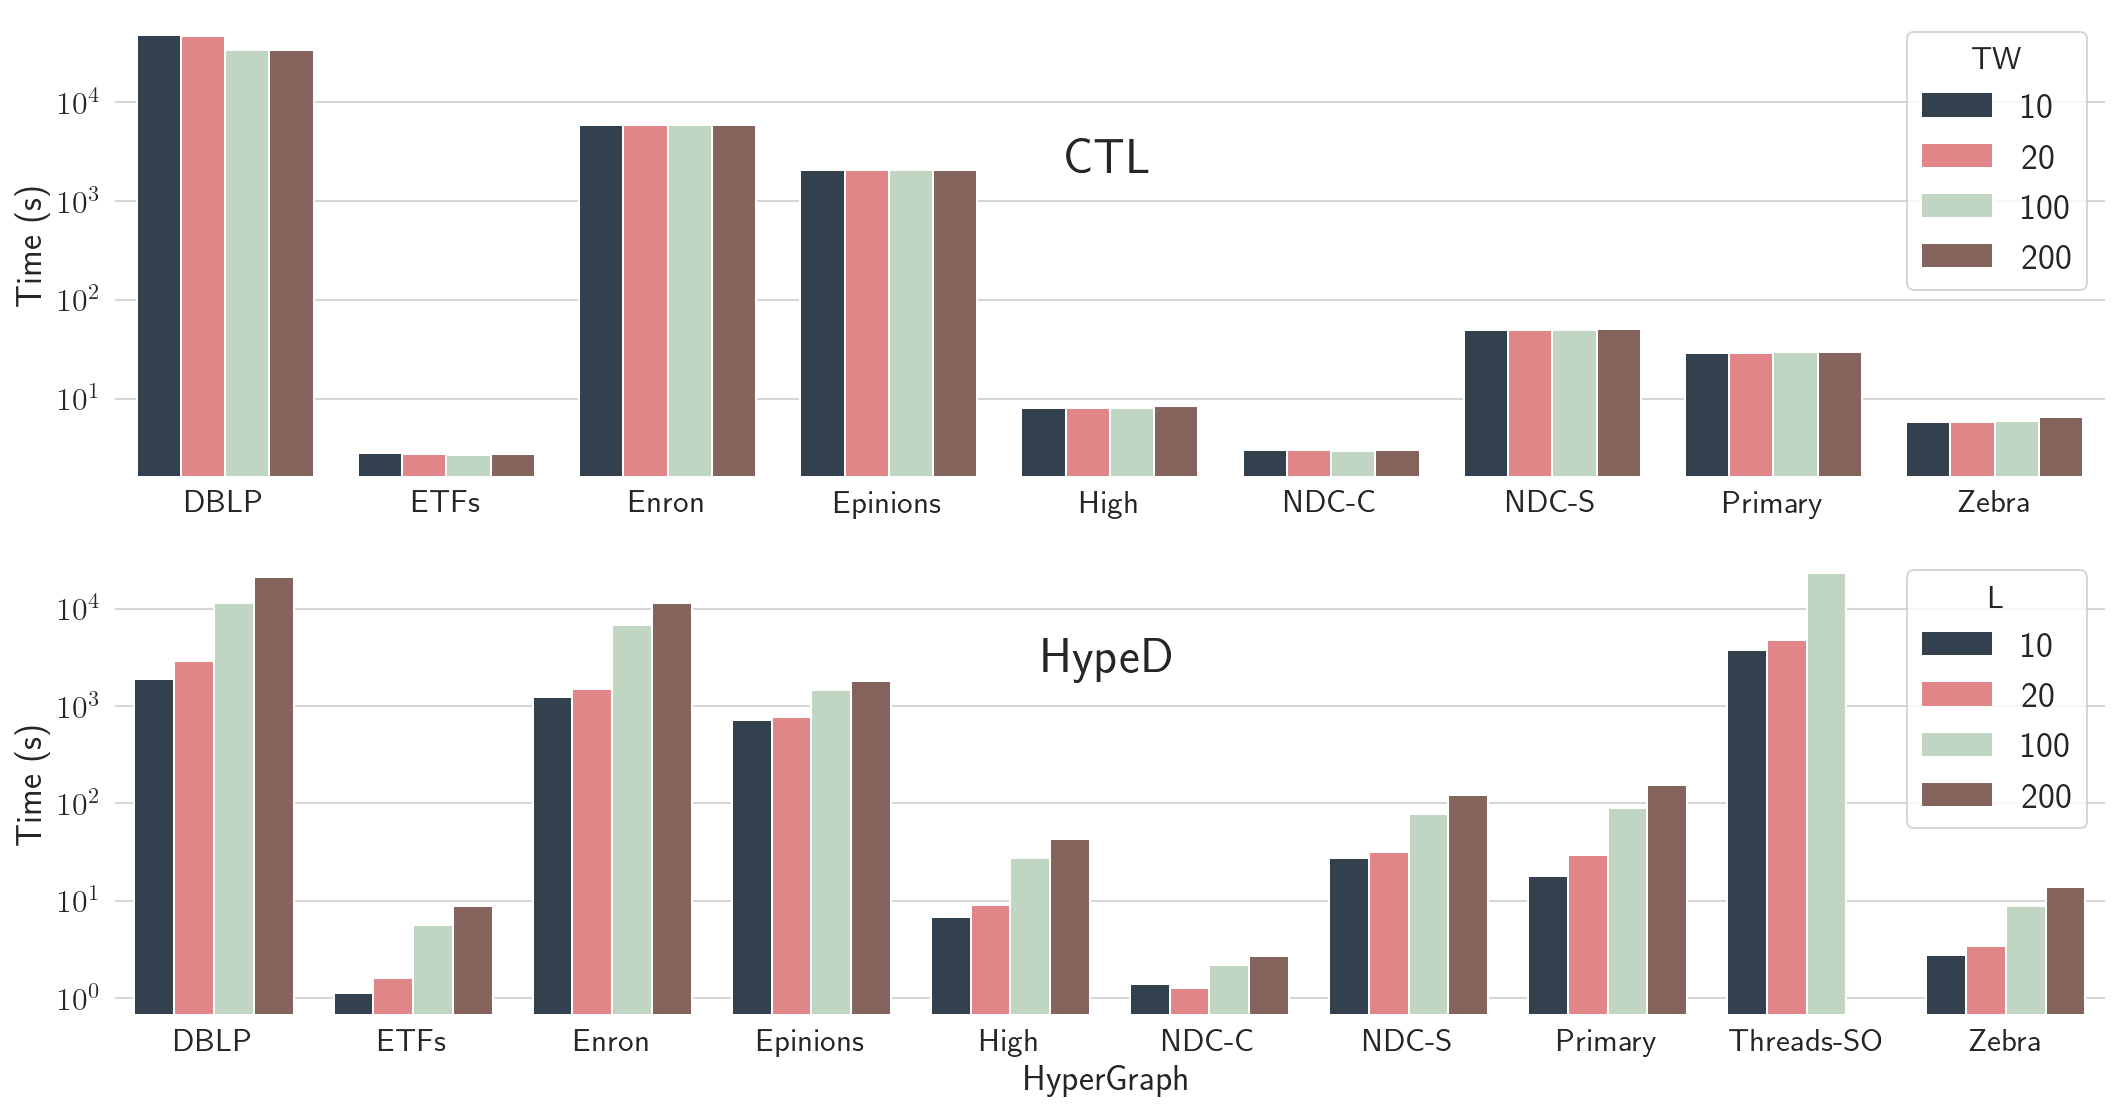

In [296]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

prep_ctl.sort_values(by='HyperGraph', inplace=True)
qt_ours.sort_values(by='HyperGraph', inplace=True)

sns.barplot(data=prep_ctl, x='HyperGraph', y='CTL', hue='TW',  
            palette=palette, ax=ax[0])
ax[0].set_ylabel(fr'Time (s)')
ax[0].set_yscale('log')
ax[0].set_xlabel('')
ax[0].set_title('CTL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.barplot(data=qt_ours, x='HyperGraph', y='HypED (Off)', hue='Q',  
            palette=palette, ax=ax[1])
ax[1].set_ylabel(fr'Time (s)')
ax[1].set_yscale('log')
ax[1].legend(title='L')
ax[1].set_title('HypeD', pad=-60, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'offline_comparison_ctl.pdf')
plt.show()

### Index Size

In [101]:
oracles_ctl = pd.read_csv(ctl_dir + 'oracle_sizes.csv', sep=' ')

In [102]:
oracles_ctl['HyperGraph'] = oracles_ctl['HyperGraph'].apply(rename_graph)

In [103]:
oracles_ctl['IndexSize'] = oracles_ctl['BP'] + oracles_ctl['Tree'] + oracles_ctl['Core']

Disk Size

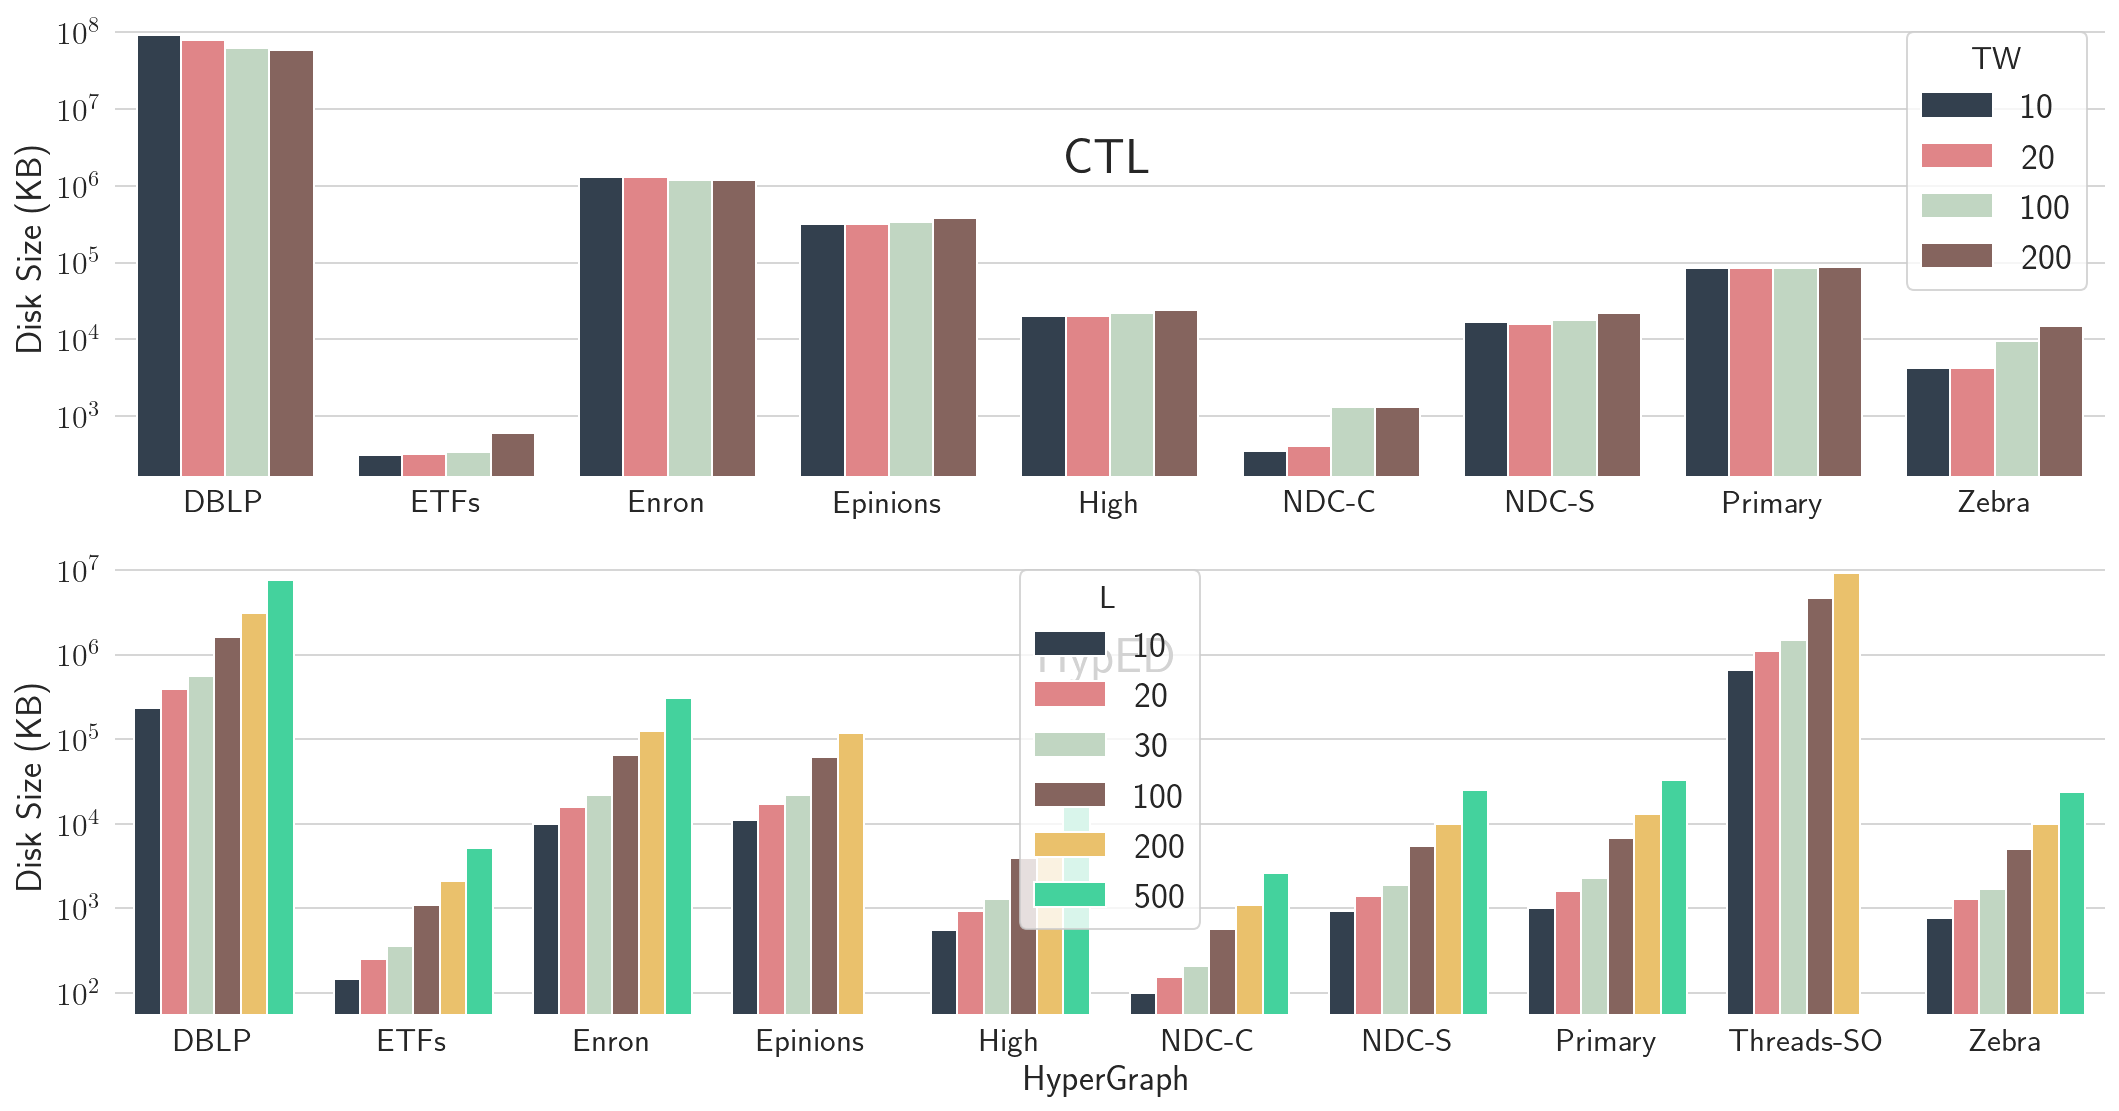

In [300]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

ctl_sizes = oracles_ctl.sort_values(by='HyperGraph').copy()
ctl_sizes['CTL (K)'] = ctl_sizes['DiskSize'].replace(symb_kb, regex=True).map(pd.eval)

oracles_pro_sizes.sort_values(by='HyperGraph', inplace=True)

sns.barplot(data=ctl_sizes, x='HyperGraph', y='CTL (K)', hue='TW',  
            palette=palette, ax=ax[0])
ax[0].set_ylabel('Disk Size (KB)')
ax[0].set_yscale('log')
ax[0].set_xlabel('')
ax[0].set_title('CTL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.barplot(data=oracles_pro_sizes, x='HyperGraph', y='PRO (K)', hue='L',  
            palette=palette, ax=ax[1])
ax[1].set_ylabel('Disk Size (KB)')
ax[1].set_yscale('log')
ax[1].set_title('HypED', pad=-60, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'index_comparison_ctl.pdf')
plt.show()

### Query Time

In [104]:
dfs = []
for t in tws:
    tmp = pd.read_csv(ctl_dir+f'query_{t}.log', sep=' ')
    tmp['TW'] = t
    dfs.append(tmp)
queries_ctl = pd.concat(dfs)
queries_ctl.columns = ['HyperGraph', 's', 'Time (micros)', 'd', 'srcId', 'dstId', 'TW']

In [105]:
num_queries = queries_ctl.groupby(by=['HyperGraph', 
                                  'TW']).agg({'d':'count',
                                              'Time (micros)':'sum'}).reset_index()
num_queries.columns = ['HyperGraph', 'TW', 'Num Queries', 'Time (micros)']
num_queries['Time'] = num_queries['Time (micros)'] / 1000.

In [106]:
qt_ctl = ctl_stats[ctl_stats['Task']=='query'].merge(num_queries)
# index loading time only
qt_ctl['TotPrepTime'] = (qt_ctl['Time (ms)'] - qt_ctl['Time']) 
# index loading time per query
qt_ctl['PrepTimeXQ'] = qt_ctl['TotPrepTime'] / qt_ctl['Num Queries']
# index loading time is counted once per batch of queries
qt_ctl['TimeXQ'] = (qt_ctl['PrepTimeXQ'] + qt_ctl['Time']) / qt_ctl['Num Queries']
qt_ctl['HyperGraph'] = qt_ctl['HyperGraph'].apply(rename_graph)

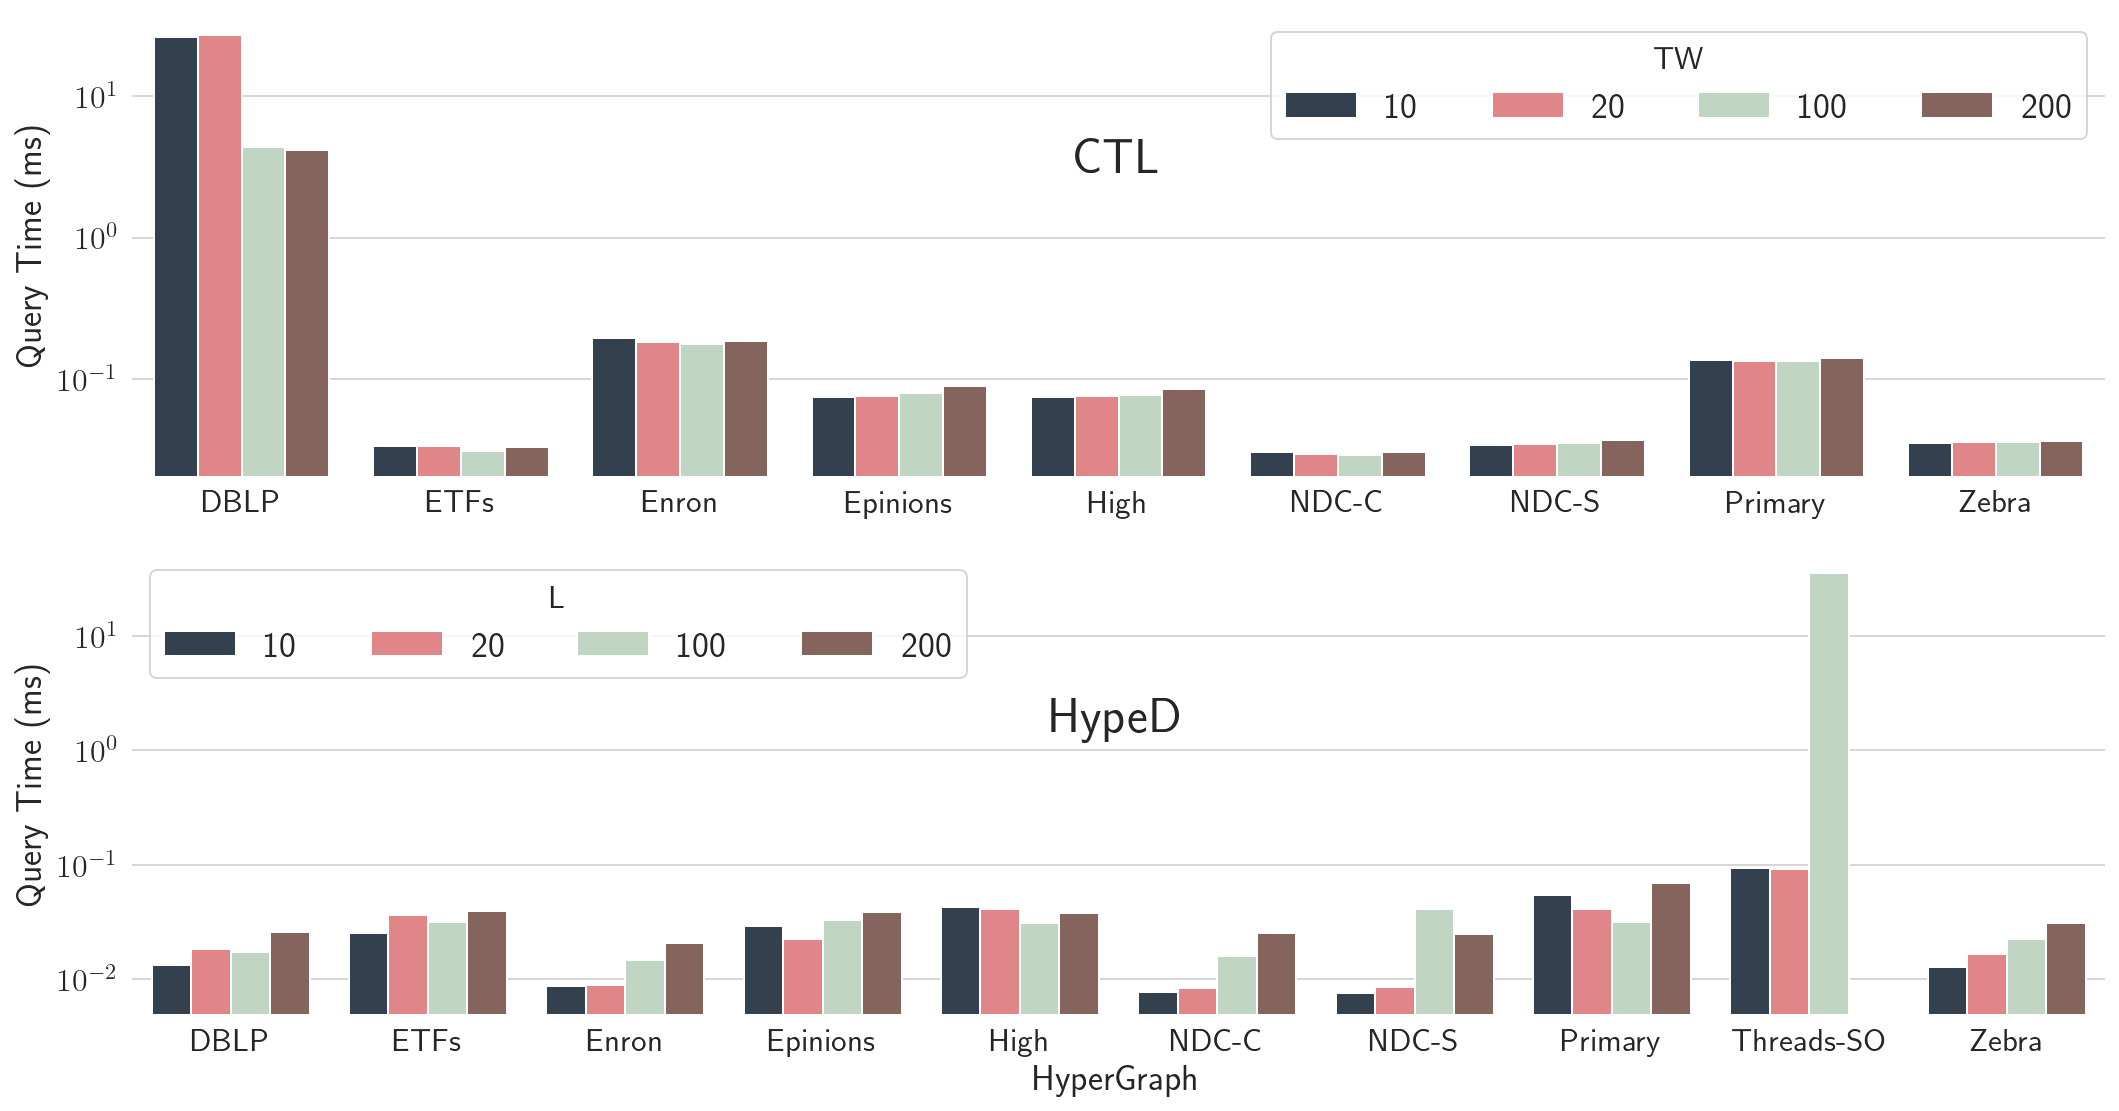

In [304]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

qt_ctl = qt_ctl.sort_values(by='HyperGraph')
qt_ours = qt_ours.sort_values(by='HyperGraph')

sns.barplot(data=qt_ctl, x='HyperGraph', y='TimeXQ', hue='TW',  
            palette=palette, ax=ax[0])
ax[0].legend(title='TW', ncol=4)
ax[0].set_ylabel(fr'Query Time (ms)')
ax[0].set_yscale('log')
ax[0].set_xlabel('')
ax[0].set_title('CTL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.barplot(data=qt_ours, x='HyperGraph', y='HypED (QT)', hue='Q',  
            palette=palette, ax=ax[1])
ax[1].set_ylabel(fr'Query Time (ms)')
ax[1].set_yscale('log')
ax[1].set_title('HypeD', pad=-90, fontsize=25, fontweight='bold')
ax[1].legend(title='L', ncol=5)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'query_comparison_ctl.pdf')
plt.show()

### Accuracy

In [107]:
ctl_pro_q = query_ours.copy()

Remap ids using CTL mappings

In [108]:
dbs = []
for db in graphs_all:
    db_name = db[:-3]
    for s in range(1,11):
        try:
            vmap = pd.read_csv(f'{ctl_dir}mappings/{db_name}-{s}-vmap.txt', header=None, sep=' ')
            vmap.columns = ['src', 'srcId']
            vmap['HyperGraph'] = rename_graph(db)
            vmap['s'] = s
            dbs.append(vmap)
        except Exception as e:
            pass
vmaps = pd.concat(dbs)

In [109]:
ctl_pro_q = ctl_pro_q.merge(vmaps)

In [110]:
vmaps.columns = ['dst', 'dstId', 'HyperGraph', 's']

In [111]:
ctl_pro_q = ctl_pro_q.merge(vmaps)

Put all together

In [112]:
ctl_q = queries_ctl[['HyperGraph', 's', 'd', 'srcId', 'dstId', 'TW']].drop_duplicates()
ctl_q.columns = ['HyperGraph', 's', 'CTL-Est', 'srcId', 'dstId', 'TW']
ctl_q['HyperGraph'] = ctl_q['HyperGraph'].apply(rename_graph)

In [113]:
tmp = ctl_pro_q[['HyperGraph', 'Q', 's', 'srcId', 'dstId', 'd', 'd_hat']].copy()
tmp.columns = ['HyperGraph', 'L', 's', 'srcId', 'dstId', 'd', 'HypeD-Est']
ctl_q = ctl_q.merge(tmp).dropna()

In [114]:
ctl_q = ctl_q.astype(dtype={'d':np.int32,
                            'CTL-Est':np.int32,
                            'HypeD-Est':np.int32})

#### L1-norm

In [115]:
all_est_ctl = ctl_q[ctl_q['d']!=-1].drop(columns=['L']).drop_duplicates().copy()

all_est_ctl['L1-Norm'] = all_est_ctl['CTL-Est'] - all_est_ctl['d']
all_est_ctl['L1-Norm'] = all_est_ctl['L1-Norm'].apply(abs)
all_est_ctl.loc[all_est_ctl['CTL-Est']==-1, 'L1-Norm'] = 99
all_est_ctl.loc[all_est_ctl['CTL-Est']==-1, 'CTL-Est'] = 99

all_est_hype = ctl_q[ctl_q['d']!=-1].drop(columns=['TW']).drop_duplicates().copy()
all_est_hype['L1-Norm'] = all_est_hype['HypeD-Est'] - all_est_hype['d']
all_est_hype['L1-Norm'] = all_est_hype['L1-Norm'].apply(abs)
all_est_hype.loc[all_est_hype['HypeD-Est']==-1, 'L1-Norm'] = 99
all_est_hype.loc[all_est_hype['HypeD-Est']==-1, 'HypeD-Est'] = 99

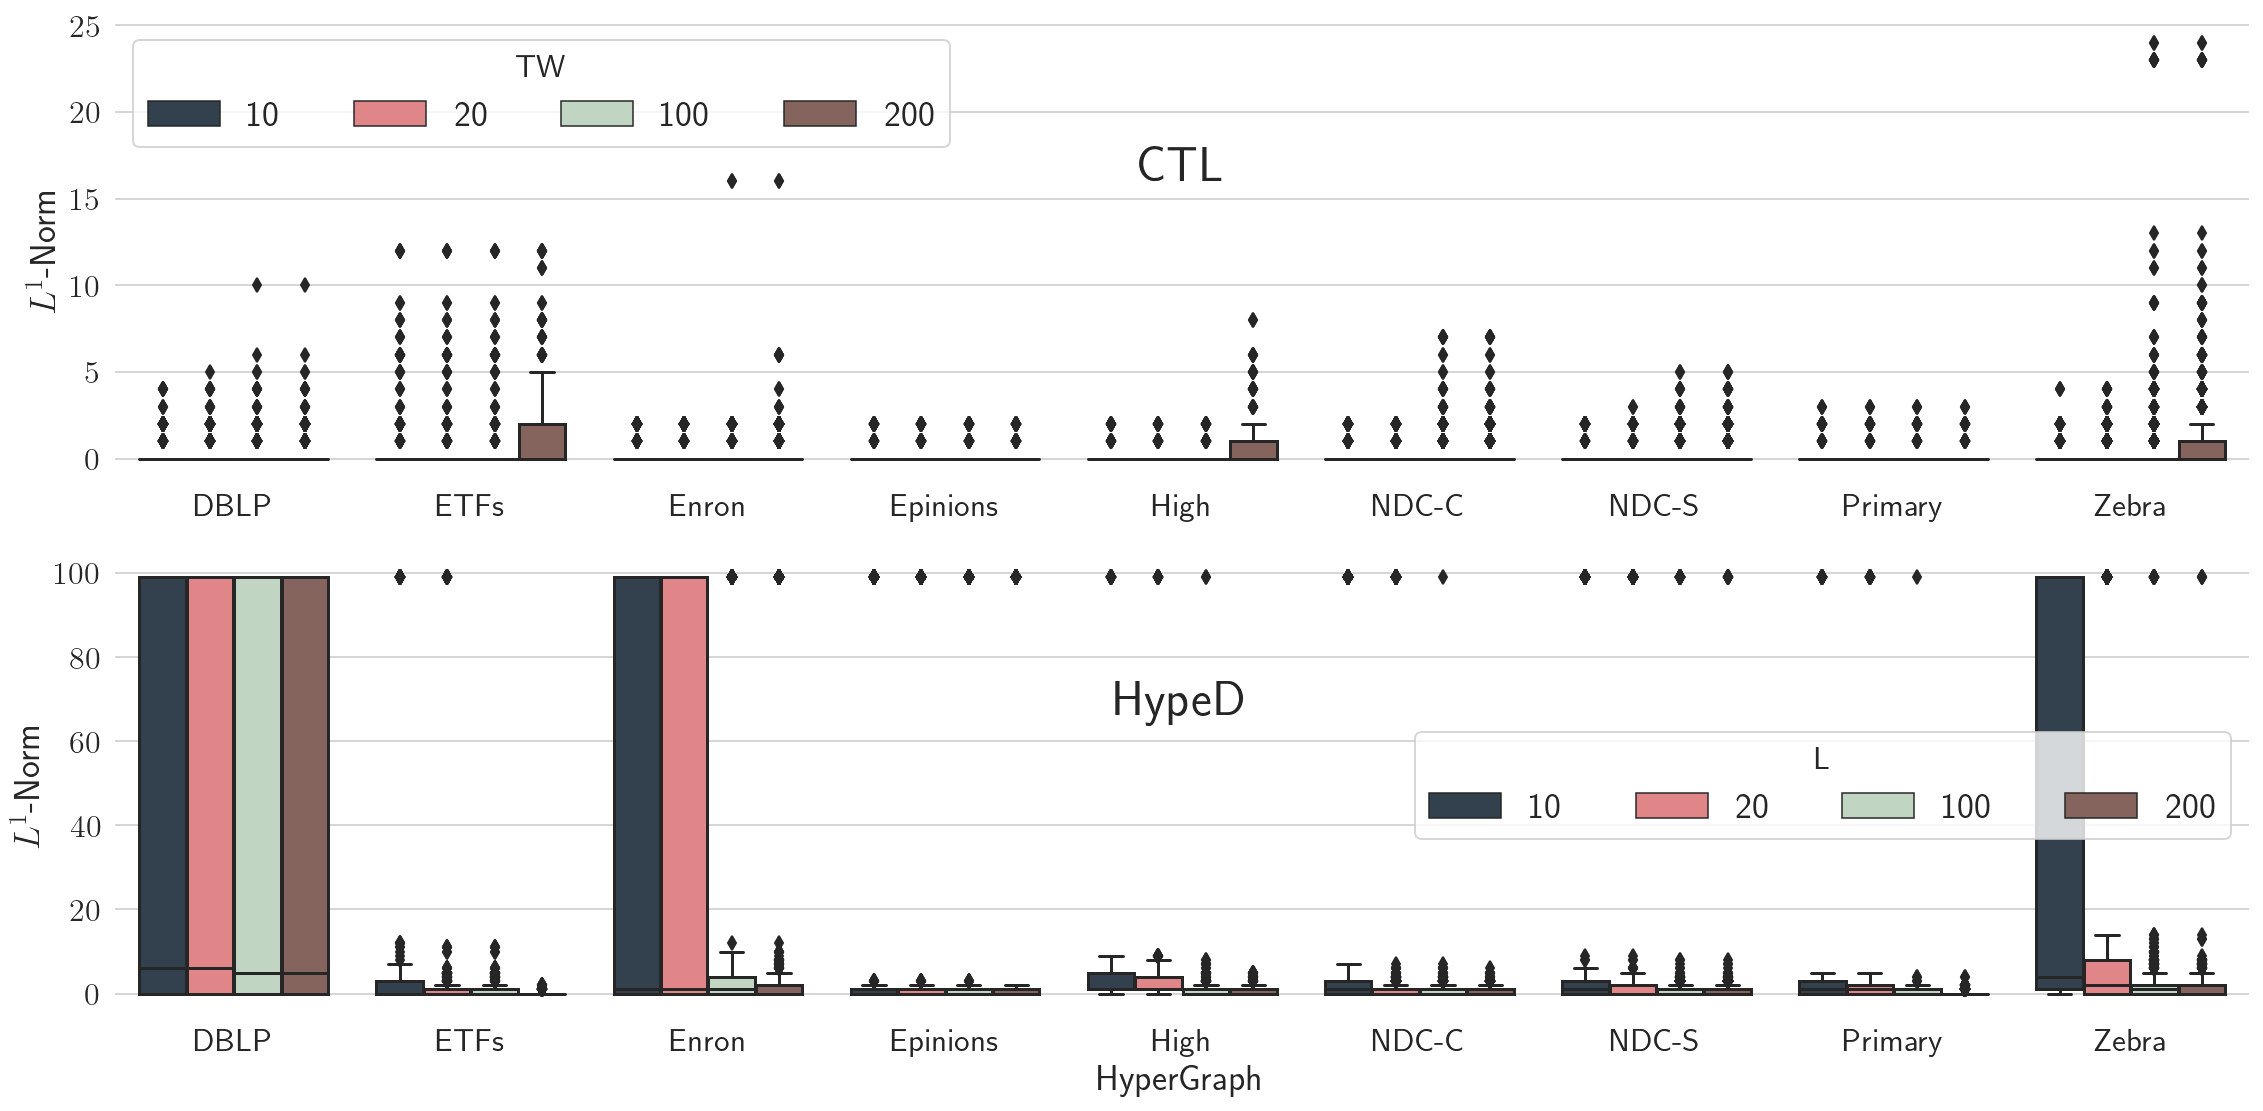

In [315]:
fig, ax = plt.subplots(2,1,figsize=(16,8))

all_est_ctl.sort_values(by='HyperGraph', inplace=True)
all_est_hype.sort_values(by='HyperGraph', inplace=True)

sns.boxplot(data=all_est_ctl, x='HyperGraph', y='L1-Norm',
            hue='TW', palette=palette, ax=ax[0])

ax[0].set_ylabel(r'$L^1$-Norm')
ax[0].set_xlabel('')
ax[0].legend(title='TW', ncol=4)
ax[0].set_title('CTL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.boxplot(data=all_est_hype, x='HyperGraph', y='L1-Norm', 
            hue='L', palette=palette, ax=ax[1])
ax[1].set_ylabel(r'$L^1$-Norm')
ax[1].legend(title='L', ncol=5)
ax[1].set_title('HypeD', pad=-80, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(fig_path+'l1_comparison_ctl.pdf')
plt.show()

#### MAE and RMSE

In [116]:
accuracies = []
for l in all_est_hype['L'].unique():
    df = all_est_hype.loc[all_est_hype['L']==l, ['HyperGraph', 'HypeD-Est', 'd']]
    for g in df['HyperGraph'].unique():
        df2 = df[df['HyperGraph']==g]
        y_true = df2['d'].values
        y_pred = df2['HypeD-Est'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        accuracies.append([g, l, 'HypED', mae, rmse])
for t in all_est_ctl['TW'].unique():
    df = all_est_ctl.loc[all_est_ctl['TW']==t, ['HyperGraph', 'CTL-Est', 'd']]
    for g in df['HyperGraph'].unique():
        df2 = df[df['HyperGraph']==g]
        y_true = df2['d'].values
        y_pred = df2['CTL-Est'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        accuracies.append([g, t, 'CTL', mae, rmse])

In [117]:
acc_df_ctl = pd.DataFrame(accuracies, columns=['HyperGraph', 'Param', 'Algorithm', 'MAE', 'RMSE'])

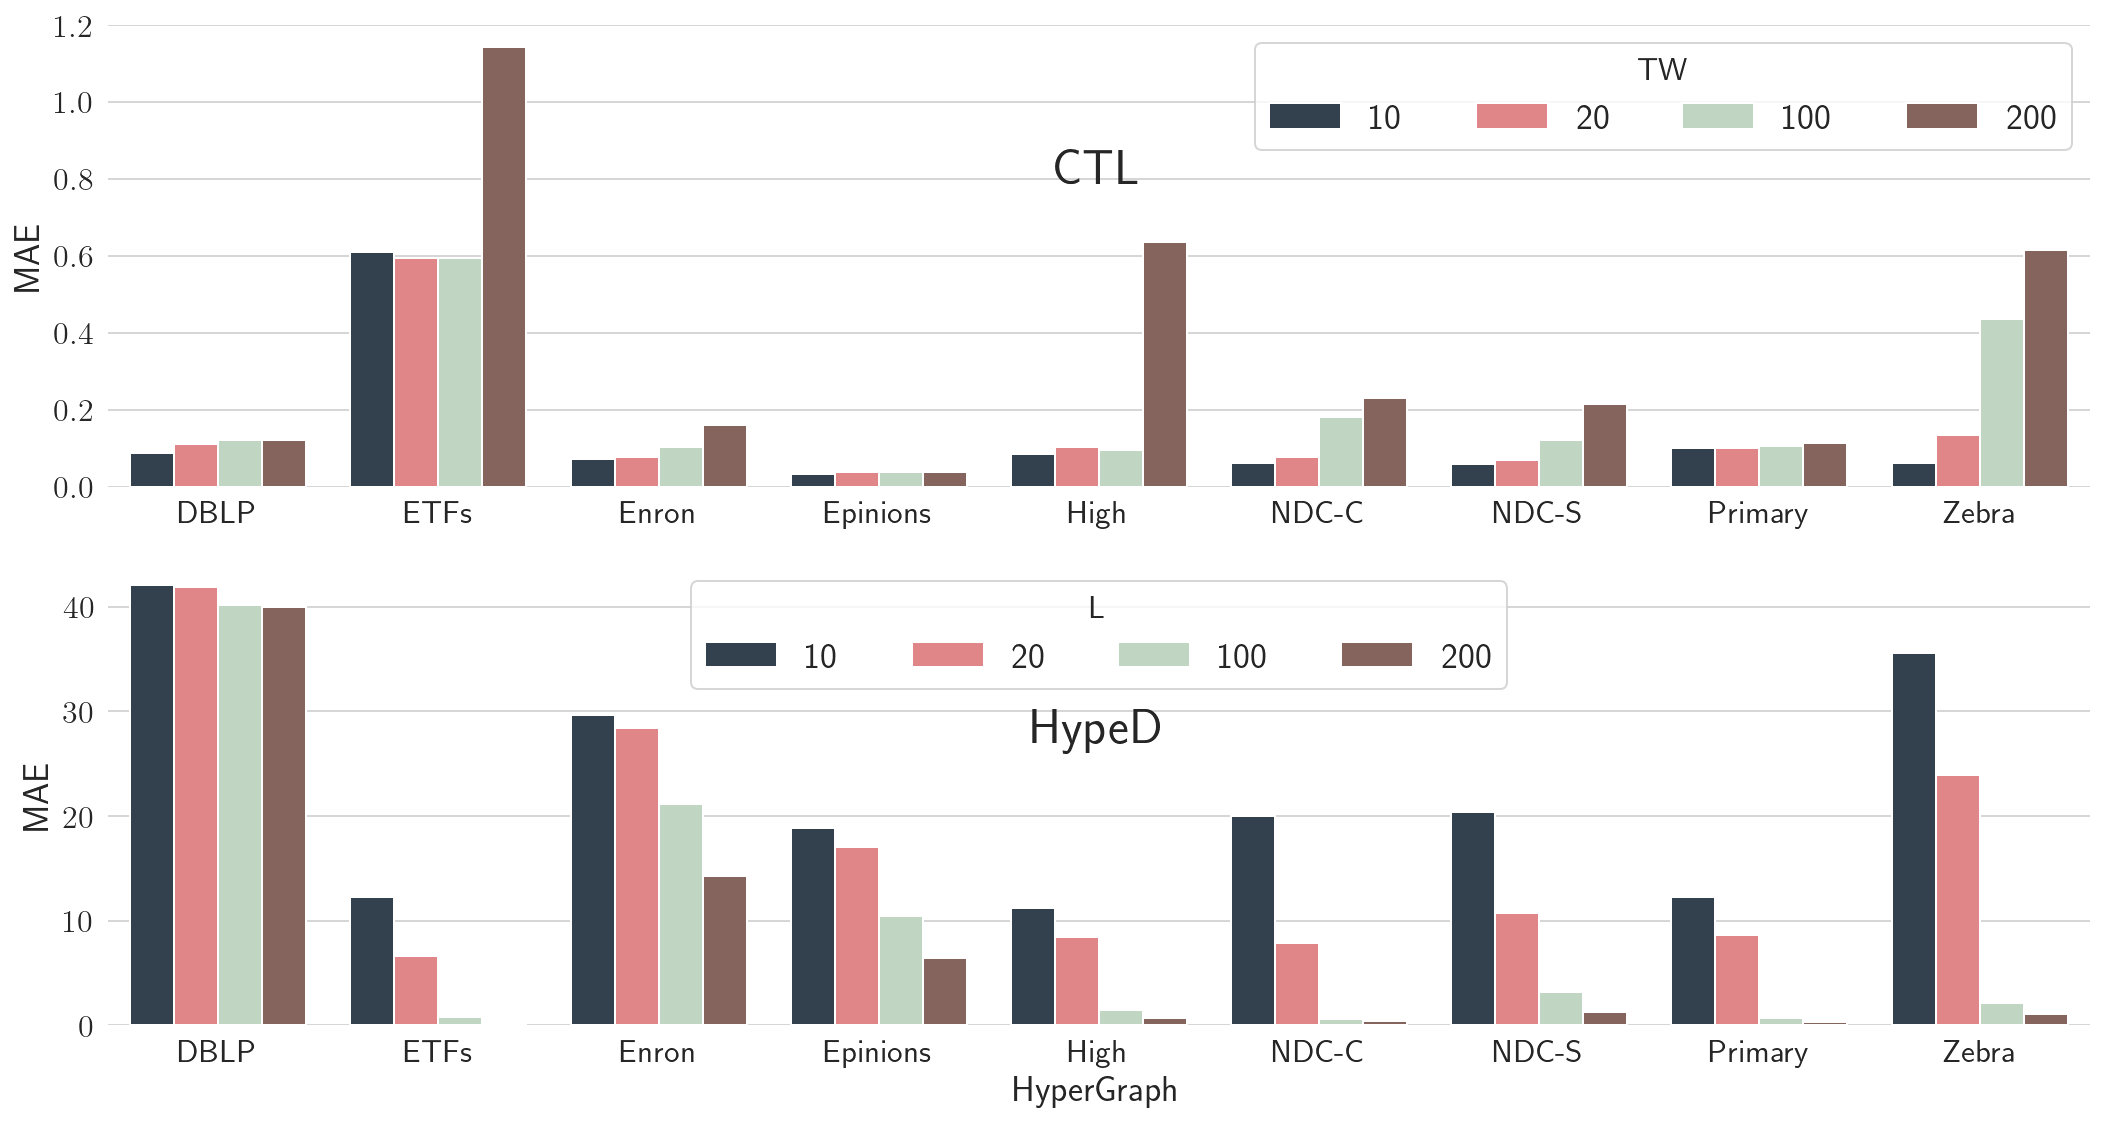

In [318]:
fig, ax = plt.subplots(2,1, figsize=(15,8))

data = acc_df_ctl[acc_df_ctl['Algorithm']=='CTL']
sns.barplot(data=data, x='HyperGraph', y='MAE',
            hue='Param', palette=palette, ax=ax[0])
ax[0].legend(title='TW', ncol=4)
ax[0].set_xlabel('')
ax[0].set_title('CTL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

data = acc_df_ctl[acc_df_ctl['Algorithm']=='HypED']
sns.barplot(data=data, x='HyperGraph', y='MAE',
            hue='Param', palette=palette, ax=ax[1])
ax[1].legend(title='L', ncol=5)
ax[1].set_title('HypeD', pad=-90, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'mae_comparison_ctl.pdf')
plt.show()

## Highway Labelling

In [118]:
lands = [10, 20, 100, 200]

In [119]:
hl_dir = outfile_path + 'related/hl/'

### Preprocessing Time

In [120]:
dfs = []
for l in lands:
    tmp = pd.read_csv(hl_dir+f'stats_{l}.log', sep=' ')
    tmp = tmp.groupby(by=['HyperGraph'])[['Time(ms)']].sum().reset_index()
    tmp['HL'] = tmp['Time(ms)'] / 1000.
    tmp['HyperGraph'] = tmp['HyperGraph'].apply(rename_graph)
    tmp['L'] = l
    dfs.append(tmp)
hl_off_stats = pd.concat(dfs)

In [121]:
prep_hl = hl_off_stats.merge(lg_time.reset_index()[['HyperGraph', 'LG']], )
prep_hl['HL'] = prep_hl['HL'] + prep_hl['LG']

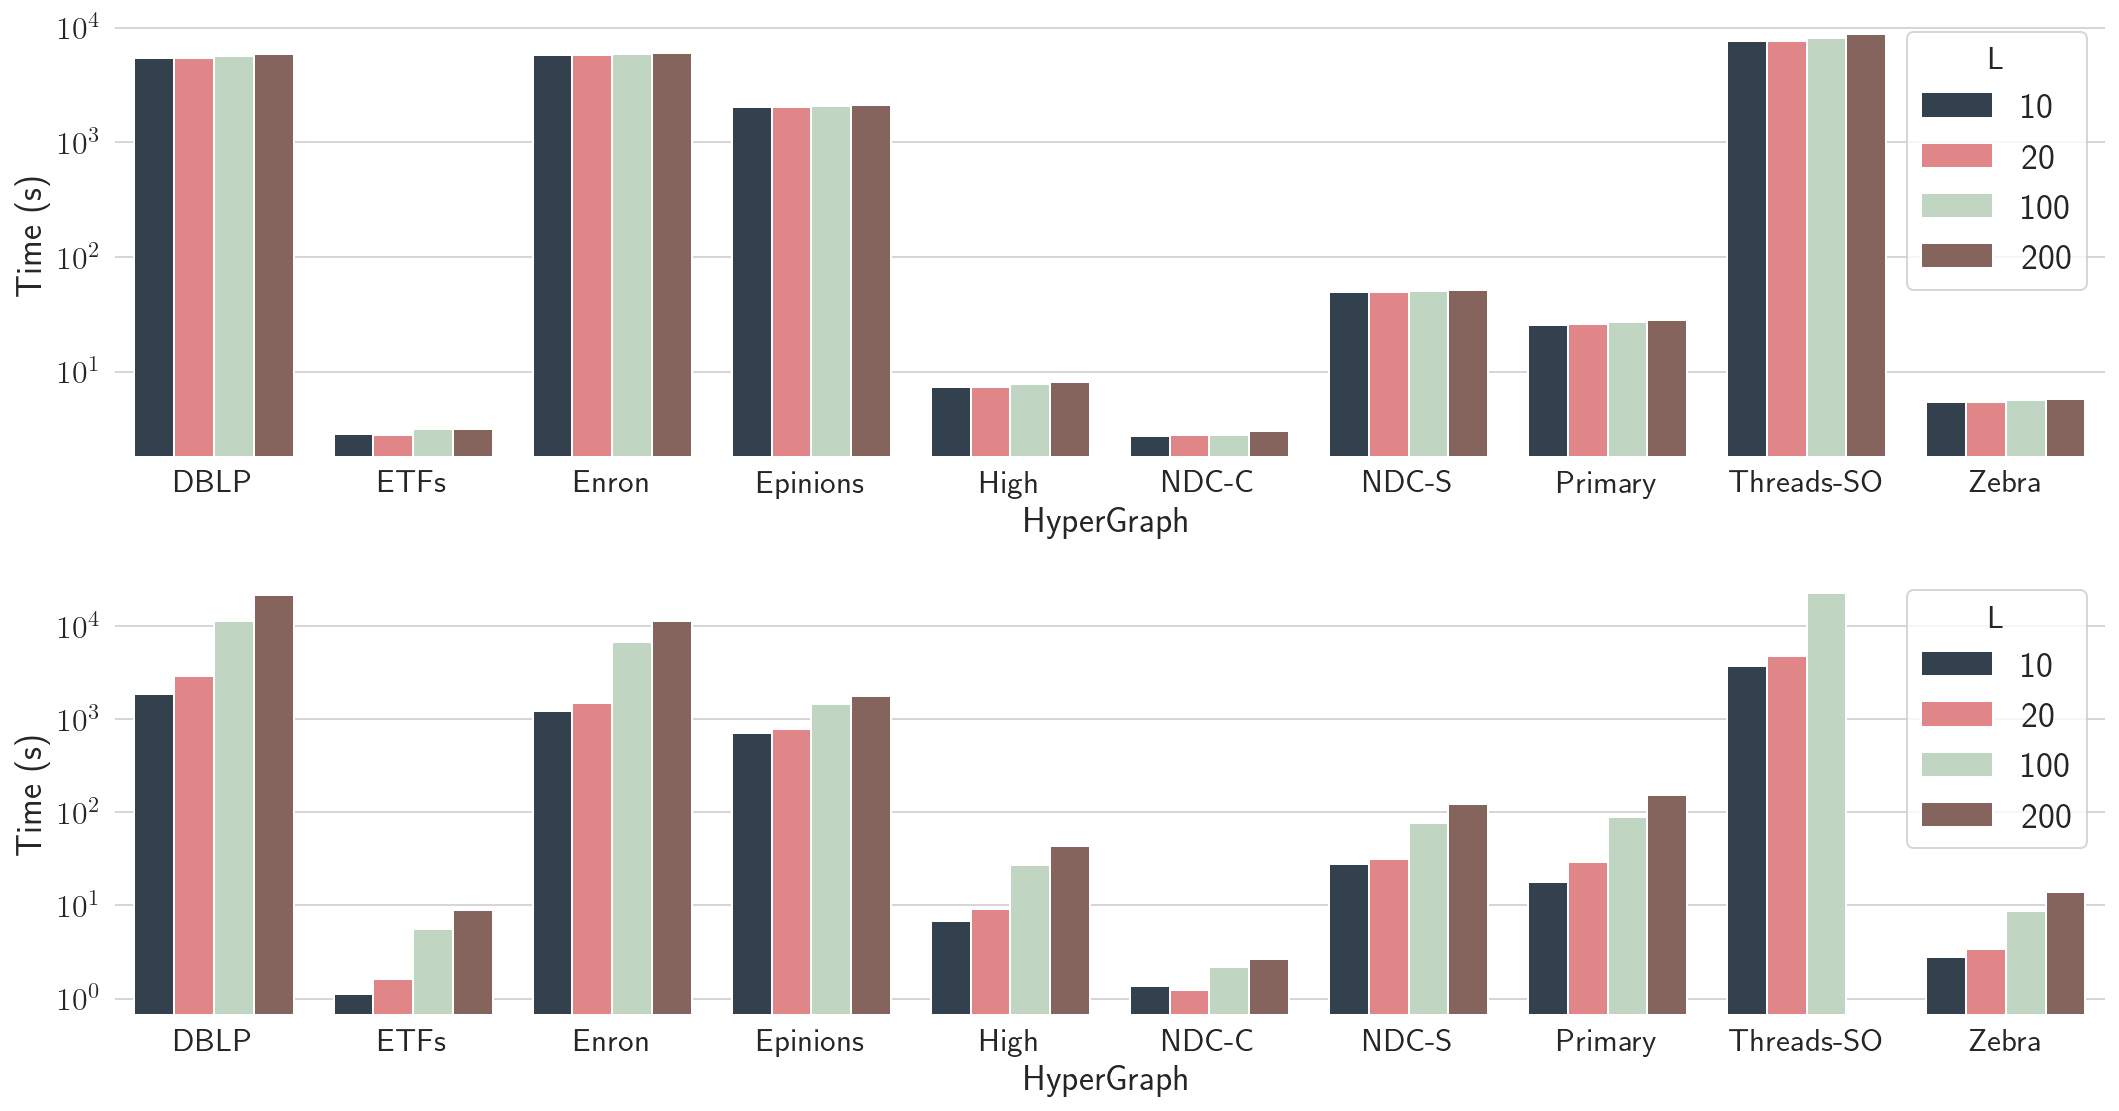

In [323]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

prep_hl.sort_values(by='HyperGraph', inplace=True)
qt_ours.sort_values(by='HyperGraph', inplace=True)

sns.barplot(data=prep_hl, x='HyperGraph', y='HL', 
            hue='L', palette=palette, ax=ax[0])
ax[0].set_ylabel(fr'Time (s)')
ax[0].set_yscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.barplot(data=qt_ours, x='HyperGraph', y='HypED (Off)', hue='Q',  
            palette=palette, ax=ax[1])
ax[1].set_ylabel(fr'Time (s)')
ax[1].set_yscale('log')
ax[1].legend(title='L')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'offline_comparison_hl.pdf')
plt.show()

ALL TOGETHER

In [122]:
merged_offt = qt_ours.copy()
merged_offt['Algorithm'] = 'HypED-' + merged_offt['Q'].apply(str)
merged_offt.rename(columns={'HypED (Off)':'OFF'}, inplace=True)
merged_offt = merged_offt[['HyperGraph', 'Algorithm', 'OFF']]

In [123]:
tmp = prep_hl[prep_hl['L']==100].copy()
tmp['Algorithm'] = 'HL-100'
tmp.rename(columns={'HL':'OFF'}, inplace=True)
tmp = tmp[['HyperGraph', 'Algorithm', 'OFF']]
merged_offt = merged_offt.append(tmp, ignore_index=True)

In [124]:
tmp = prep_ctl[prep_ctl['TW']==100].copy()
tmp['Algorithm'] = 'CTL-100'
tmp.rename(columns={'CTL':'OFF'}, inplace=True)
tmp = tmp[['HyperGraph', 'Algorithm', 'OFF']]
merged_offt = merged_offt.append(tmp, ignore_index=True)

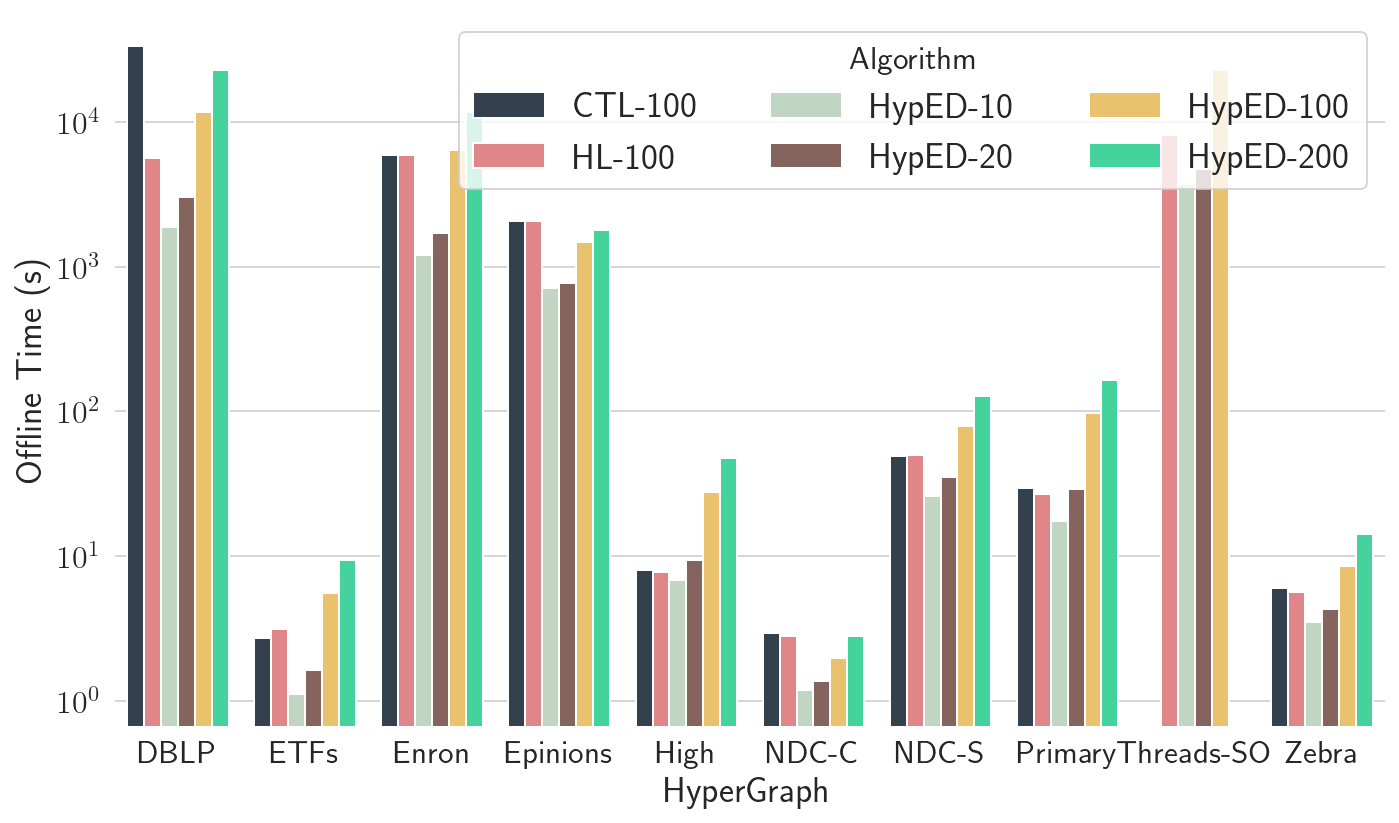

In [125]:
fig, ax = plt.subplots(figsize=(10,6))

data = merged_offt.sort_values(by=['HyperGraph'])
sns.barplot(data=data, x='HyperGraph', y='OFF', 
            hue_order=['CTL-100', 'HL-100', 'HypED-10', 'HypED-20', 'HypED-100', 'HypED-200'],
            hue='Algorithm', palette=palette, ax=ax)
ax.set_ylabel(fr'Offline Time (s)')
ax.set_yscale('log')
ax.legend(title='Algorithm', ncol=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
# plt.savefig(fig_path+'offline_comparisons.pdf')
plt.show()

### Index Size

In [126]:
oracles_hl = pd.read_csv(hl_dir + 'oracle_sizes.txt', sep=' ')

In [127]:
oracles_hl['HL (K)'] = oracles_hl['DiskSize'].replace(symb_kb, 
                                                regex=True).map(pd.eval) + oracles_hl['GraphSize'].replace(symb_kb, 
                                                                                                        regex=True).map(pd.eval)

In [128]:
oracles_hl['HyperGraph'] = oracles_hl['HyperGraph'].apply(rename_graph)

Disk Size

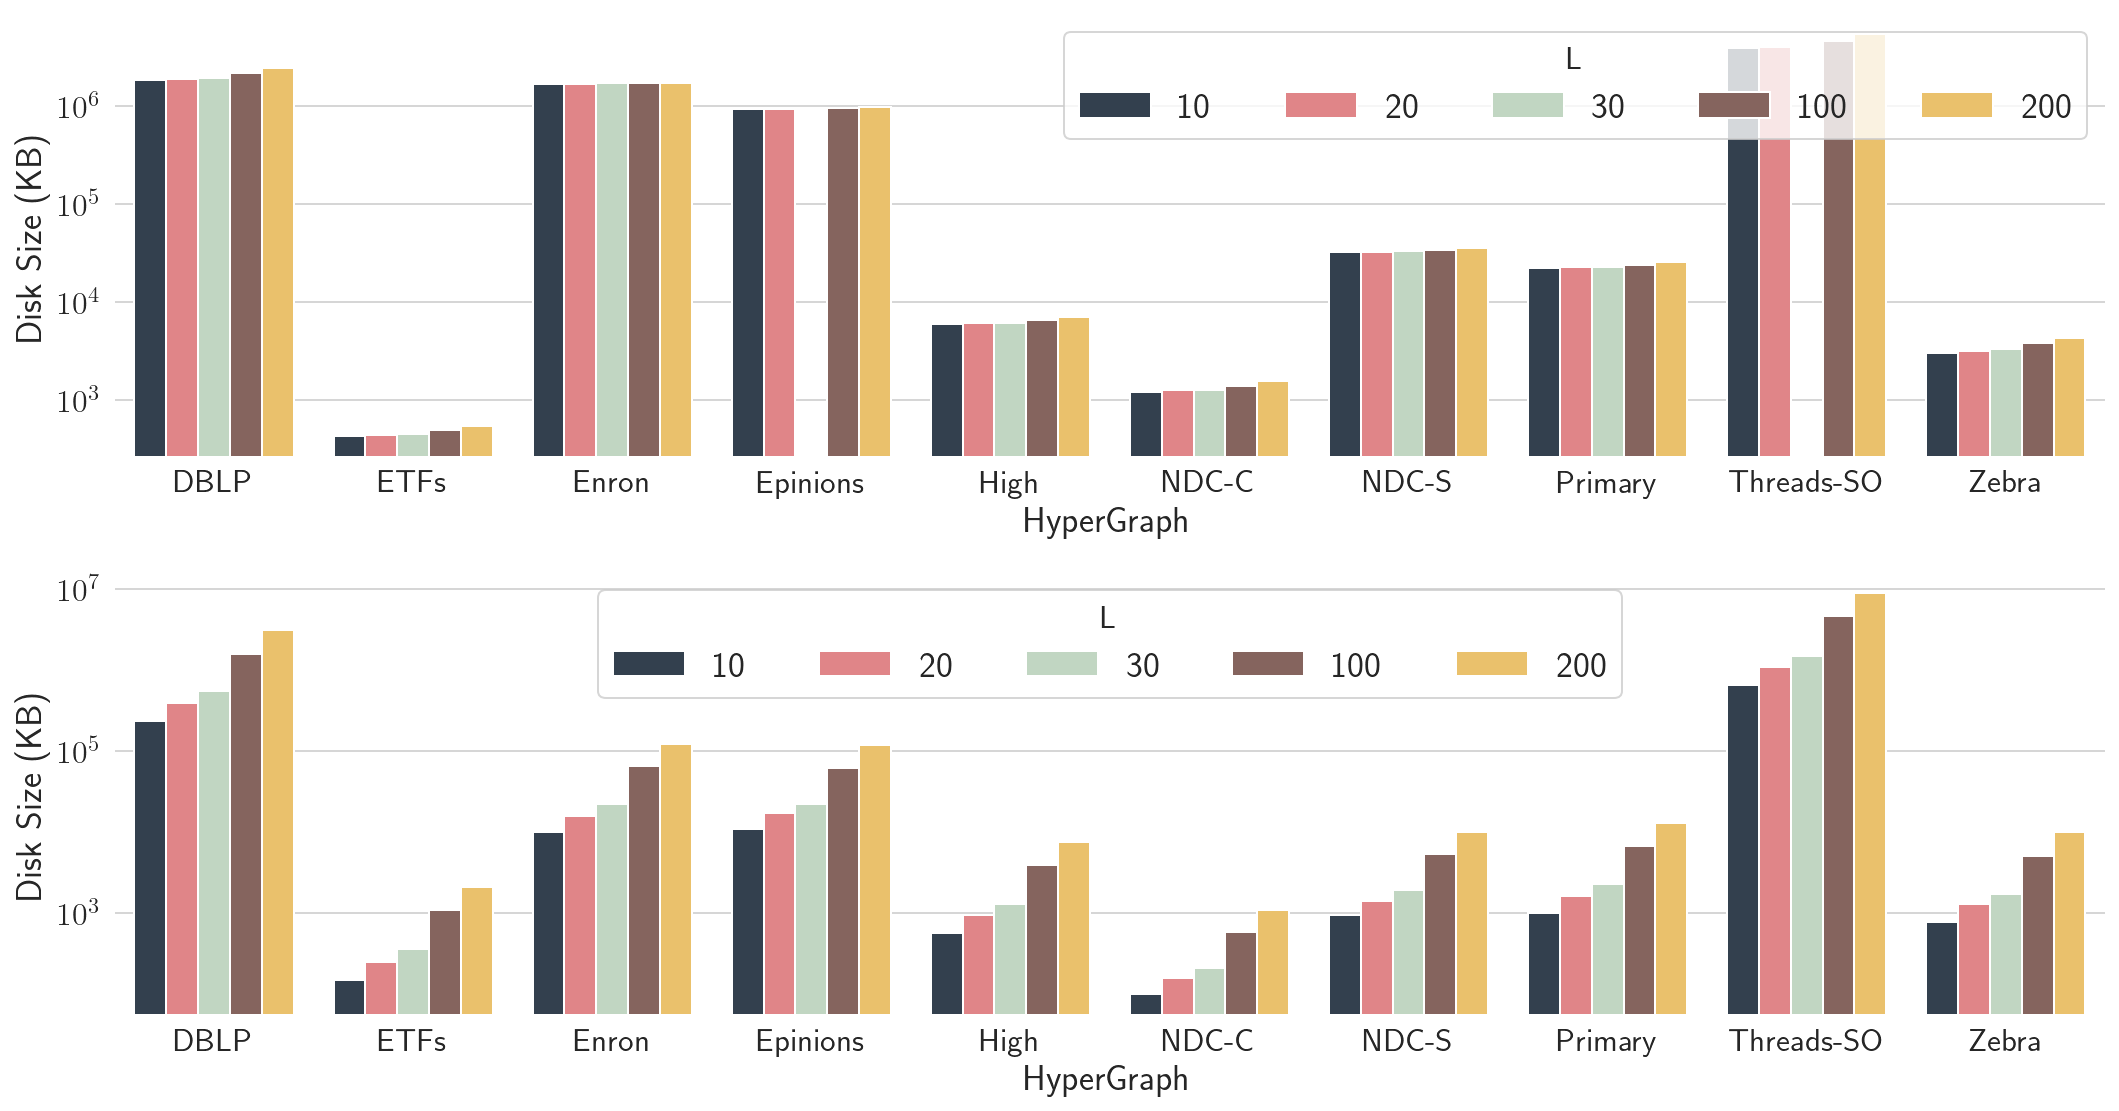

In [331]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

hl_sizes = oracles_hl.sort_values(by='HyperGraph')
sns.barplot(data=hl_sizes, x='HyperGraph', y='HL (K)', hue='L',  
            palette=palette, ax=ax[0])
ax[0].set_ylabel('Disk Size (KB)')
ax[0].set_yscale('log')
ax[0].legend(title='L', ncol=5)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

data = oracles_pro_sizes[oracles_pro_sizes['L']<500].sort_values(by='HyperGraph')
sns.barplot(data=data, x='HyperGraph', y='PRO (K)', hue='L',  
            palette=palette, ax=ax[1])
ax[1].set_ylabel('Disk Size (KB)')
ax[1].set_yscale('log')
ax[1].legend(title='L', ncol=5)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'index_comparison_hl.pdf')
plt.show()

ALL TOGETHER

In [129]:
merged_disk = oracles_pro_sizes[oracles_pro_sizes['L'].isin([10,20,100,200])].copy()
merged_disk['Algorithm'] = 'HypED-' + merged_disk['L'].apply(str)
merged_disk['DiskSize'] = merged_disk['DiskSize'].replace(symb_kb, regex=True).map(pd.eval)
merged_disk = merged_disk[['HyperGraph', 'Algorithm', 'DiskSize']]

tmp = oracles_hl[oracles_hl['L']==100].copy()
tmp['Algorithm'] = 'HL-100'
tmp['DiskSize'] = tmp['HL (K)']
tmp = tmp[['HyperGraph', 'Algorithm', 'DiskSize']]
merged_disk = merged_disk.append(tmp, ignore_index=True)

tmp = oracles_ctl[oracles_ctl['TW']==100].copy()
tmp['Algorithm'] = 'CTL-100'
tmp['DiskSize'] = tmp['DiskSize'].replace(symb_kb, regex=True).map(pd.eval)
tmp = tmp[['HyperGraph', 'Algorithm', 'DiskSize']]
merged_disk = merged_disk.append(tmp, ignore_index=True)

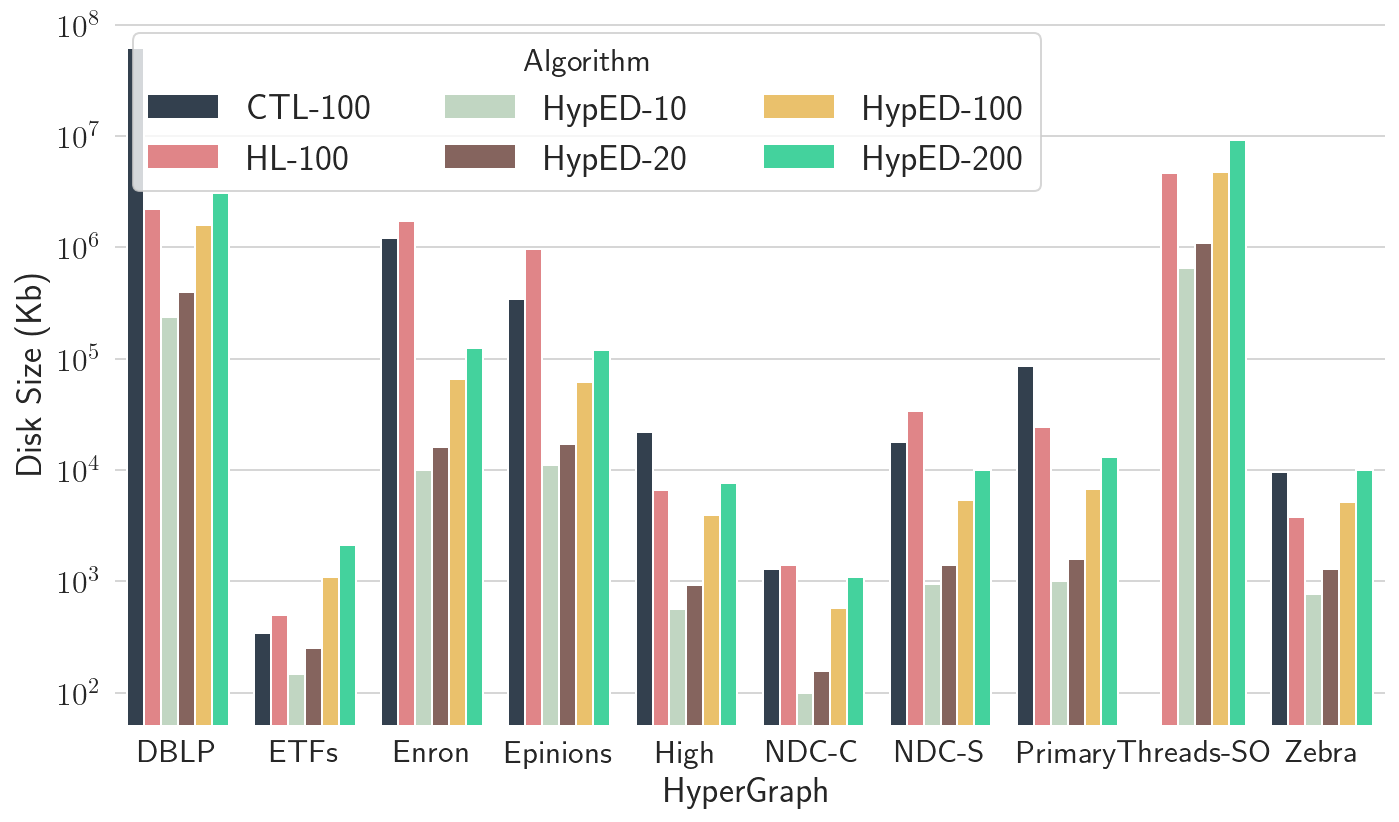

In [74]:
fig, ax = plt.subplots(figsize=(10,6))

data = merged_disk.sort_values(by='HyperGraph')

sns.barplot(data=data, x='HyperGraph', y='DiskSize', 
            hue_order=['CTL-100', 'HL-100', 'HypED-10', 'HypED-20', 'HypED-100', 'HypED-200'],
            hue='Algorithm', palette=palette, ax=ax)
ax.set_ylabel(fr'Disk Size (Kb)')
ax.set_yscale('log')
ax.legend(title='Algorithm', ncol=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
# plt.savefig(fig_path+'disk_comparisons.pdf')
plt.show()

### Query Time

In [179]:
queries_hl = pd.read_csv(hl_dir+'all_queries.txt', sep=' ')
queries_hl['HyperGraph'] = queries_hl['HyperGraph'].apply(rename_graph)

In [180]:
agg_queries_hl = queries_hl.groupby(by=['HyperGraph', 'L']).agg({'HL-d':'count',
                                                           'IndexTime(ms)':'mean',
                                                           'QueryTime(ms)':'mean'}).reset_index()
agg_queries_hl.rename(columns = {'HL-d':'NumQueries'}, inplace=True)
agg_queries_hl['HL'] = agg_queries_hl['QueryTime(ms)'] + agg_queries_hl['IndexTime(ms)'] / agg_queries_hl['NumQueries']

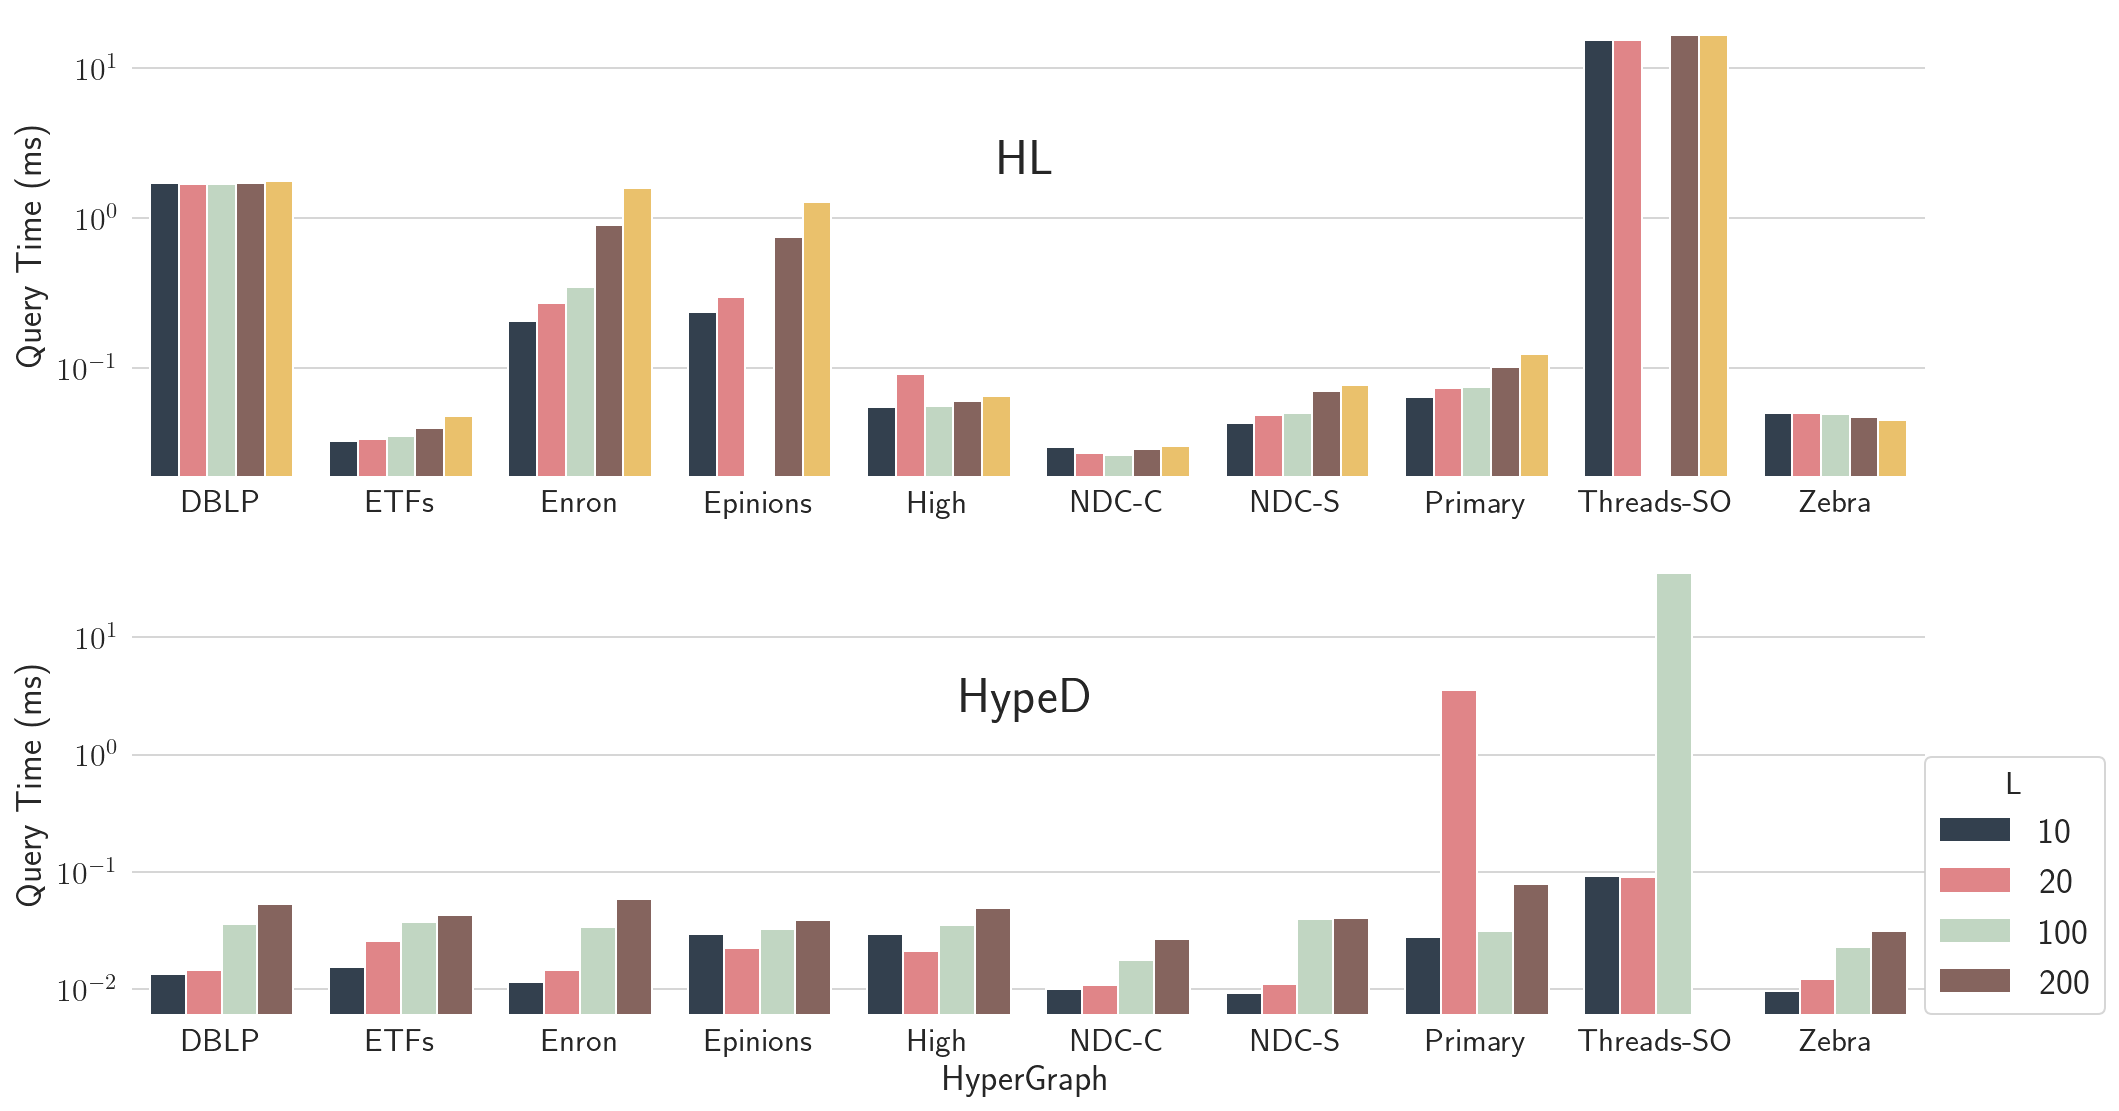

In [181]:
fig, ax = plt.subplots(2, 1, figsize=(15,8))

agg_queries_hl = agg_queries_hl.sort_values(by='HyperGraph')
qt_ours = qt_ours[qt_ours['HyperGraph'].isin(agg_queries_hl['HyperGraph'].unique())].sort_values(by='HyperGraph')

sns.barplot(data=agg_queries_hl, x='HyperGraph', y='HL', 
            hue='L', palette=palette, ax=ax[0])
ax[0].legend().remove()
ax[0].set_ylabel(fr'Query Time (ms)')
ax[0].set_yscale('log')
ax[0].set_xlabel('')
ax[0].set_title('HL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.barplot(data=qt_ours, x='HyperGraph', y='HypED (QT)', 
            hue='Q', palette=palette, ax=ax[1])
ax[1].set_ylabel(fr'Query Time (ms)')
ax[1].set_yscale('log')
ax[1].set_title('HypeD', pad=-80, fontsize=25, fontweight='bold')
ax[1].legend(title='L', loc=(1,0))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
# plt.savefig(fig_path+'query_comparison_hl.pdf')
plt.show()

ALL TOGETHER

In [182]:
merged_qt = qt_ours[qt_ours['Q'].isin([10,20,100,200])].copy()
merged_qt['Algorithm'] = 'HypED-' + merged_qt['Q'].apply(str)
merged_qt.rename(columns={'HypED (QT)':'Time (ms)'}, inplace=True)
merged_qt = merged_qt[['HyperGraph', 'Algorithm', 'Time (ms)']]

tmp = agg_queries_hl[agg_queries_hl['L'].isin([10,100])].copy()
tmp['Algorithm'] = 'HL-' + tmp['L'].apply(str)
tmp.rename(columns={'HL':'Time (ms)'}, inplace=True)
tmp = tmp[['HyperGraph', 'Algorithm', 'Time (ms)']]
merged_qt = merged_qt.append(tmp, ignore_index=True)

tmp = queries_ctl[queries_ctl['TW']==100].groupby(by=['HyperGraph']).agg({'Time (micros)':'mean'}).reset_index().copy()
tmp ['Time (ms)'] = tmp['Time (micros)'] / 1000.
tmp['Algorithm'] = 'CTL-100'
tmp['HyperGraph'] = tmp['HyperGraph'].apply(rename_graph)
tmp = tmp[['HyperGraph', 'Algorithm', 'Time (ms)']]
merged_qt = merged_qt.append(tmp, ignore_index=True)

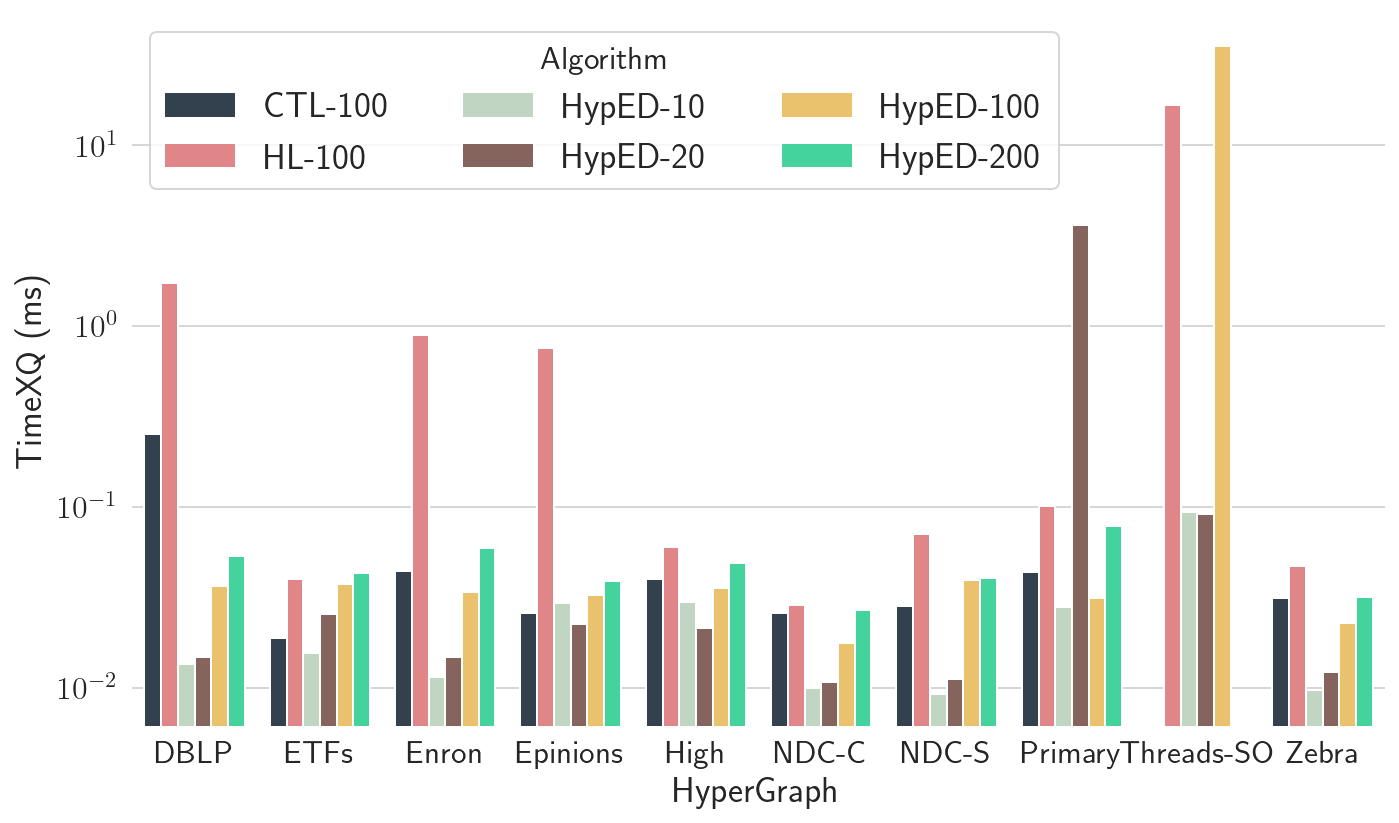

In [183]:
fig, ax = plt.subplots(figsize=(10,6))

data = merged_qt.sort_values(by='HyperGraph')
sns.barplot(data=data, x='HyperGraph', y='Time (ms)', 
            hue_order=['CTL-100', 'HL-100', 'HypED-10', 'HypED-20', 'HypED-100', 'HypED-200'],
            hue='Algorithm', palette=palette, ax=ax)
ax.set_ylabel(fr'TimeXQ (ms)')
ax.set_yscale('log')
ax.legend(title='Algorithm', ncol=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'query_time_comparisons.pdf')
plt.show()

### Accuracy

In [184]:
hl_pro_q = query_ours.copy()

Remap ids using HL mappings

In [185]:
dbs = []
for db in g_comp:
    db_name = db[:-3]
    for s in range(1,11):
        try:
            vmap = pd.read_csv(f'{hl_dir}mappings/{db_name}-{s}-vmap.txt', header=None, sep=' ')
            vmap.columns = ['src', 'srcId']
            vmap['HyperGraph'] = rename_graph(db)
            vmap['s'] = s
            dbs.append(vmap)
        except Exception as e:
            pass
vmaps = pd.concat(dbs)

In [186]:
hl_pro_q = hl_pro_q.merge(vmaps)

In [187]:
vmaps.columns = ['dst', 'dstId', 'HyperGraph', 's']

In [188]:
hl_pro_q = hl_pro_q.merge(vmaps)

Put all together

In [189]:
hl_q = queries_hl[['HyperGraph', 's', 'HL-d', 'srcId', 'dstId', 'L']].drop_duplicates()
hl_q.rename(columns = {'HL-d':'HL-Est'}, inplace=True)

In [190]:
tmp = hl_pro_q[['HyperGraph', 's', 'srcId', 'dstId', 'd', 'd_hat', 'Q']].copy()
tmp.columns = ['HyperGraph', 's', 'srcID', 'dstID', 'd', 'HypeD-Est', 'L']
hl_q = hl_q.merge(tmp).dropna()

In [191]:
hl_q = hl_q.astype(dtype={'d':np.int32,
                          'HL-Est':np.int32,
                          'HypeD-Est':np.int32})

#### Infinite Distances

In [192]:
inf_hl = hl_q[(hl_q['HL-Est']==99) & 
              (hl_q['d']!=-1)].drop_duplicates()
inf_hl_sum = inf_hl.groupby(by=['HyperGraph', 'L'])[['HL-Est']].count().reset_index()
inf_hl_sum.columns = ['HyperGraph', 'L', 'Inf']
inf_hl_sum['Algorithm'] = 'HL'

In [193]:
inf_our = hl_q[(hl_q['HypeD-Est']==-1) &
               (hl_q['d']!=-1)].drop_duplicates()
inf_our_sum = inf_our.groupby(by=['HyperGraph', 'L'])[['HypeD-Est']].count().reset_index()
inf_our_sum.columns = ['HyperGraph', 'L', 'Inf']
inf_our_sum['Algorithm'] = 'HypeD'

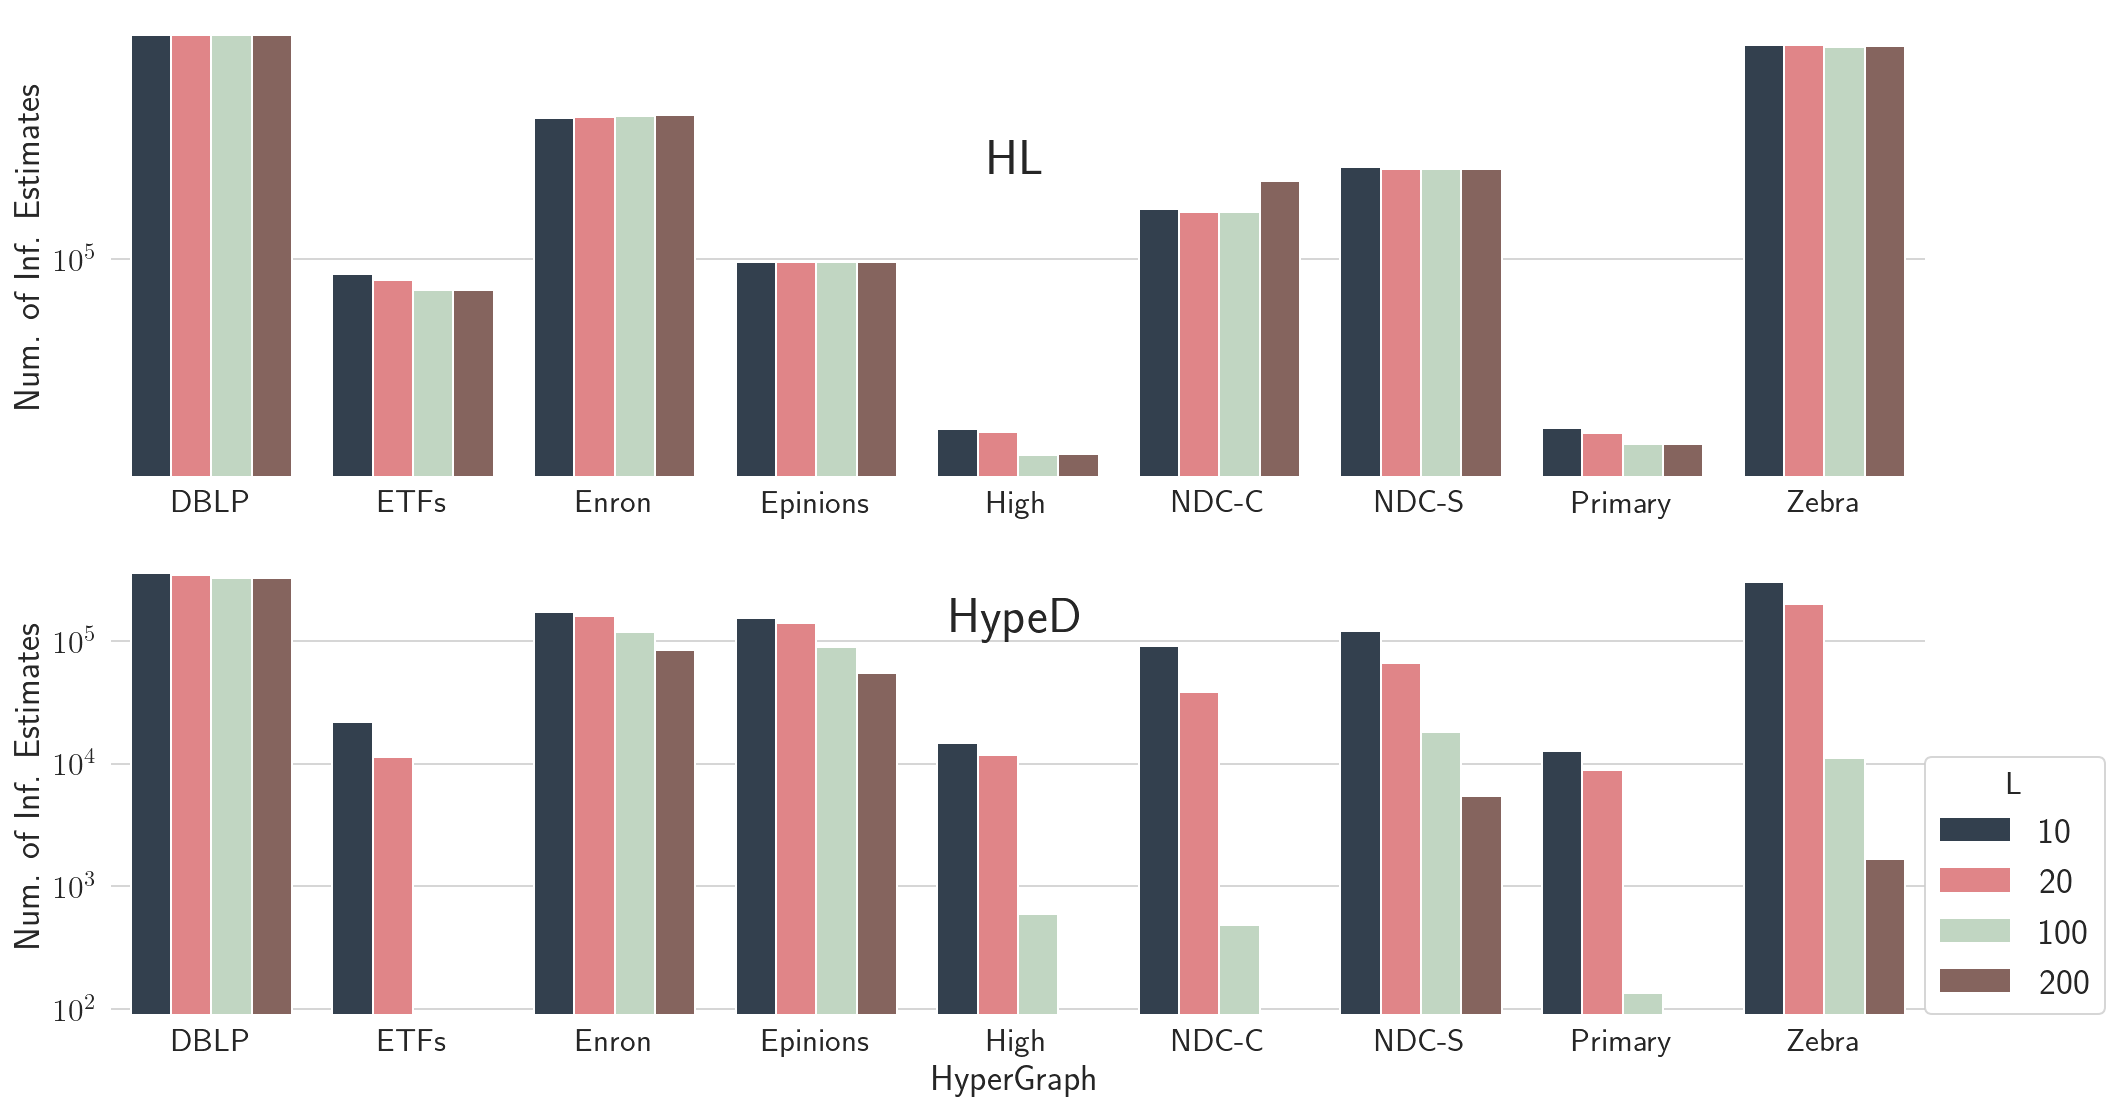

In [151]:
fig, ax = plt.subplots(2,1,figsize=(15,8))

inf_hl_sum.sort_values(by='HyperGraph', inplace=True)
inf_our_sum.sort_values(by='HyperGraph', inplace=True)

sns.barplot(data=inf_hl_sum, x='HyperGraph', y='Inf', hue='L',
            palette=palette, ax=ax[0])
ax[0].set_ylabel('Num. of Inf. Estimates')
ax[0].set_xlabel('')
ax[0].legend().remove()
ax[0].set_yscale('log')
ax[0].set_title('HL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.barplot(data=inf_our_sum, x='HyperGraph', y='Inf', hue='L',
            palette=palette, ax=ax[1])
ax[1].legend(title='L', loc=(1,0))
ax[1].set_ylabel('Num. of Inf. Estimates')
ax[1].set_yscale('log')
ax[1].set_title('HypeD', pad=-40, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'infinite_comparison_hl.pdf')
plt.show()

#### L1-norm

In [194]:
all_est = hl_q[hl_q['d']!=-1][['HyperGraph', 's', 'HypeD-Est', 'HL-Est', 'd', 'L']].copy()

all_est['HypeD (L1-Norm)'] = all_est['HypeD-Est'] - all_est['d']
all_est['HypeD (L1-Norm)'] = all_est['HypeD (L1-Norm)'].apply(abs)
all_est.loc[all_est['HypeD-Est']==-1, 'HypeD (L1-Norm)'] = 99
all_est.loc[all_est['HypeD-Est']==-1, 'HypeD-Est'] = 99
all_est['HL (L1-Norm)'] = all_est['HL-Est'] - all_est['d']
all_est['HL (L1-Norm)'] = all_est['HL (L1-Norm)'].apply(abs)
all_est.loc[all_est['HL-Est']==99, 'HL (L1-Norm)'] = 99

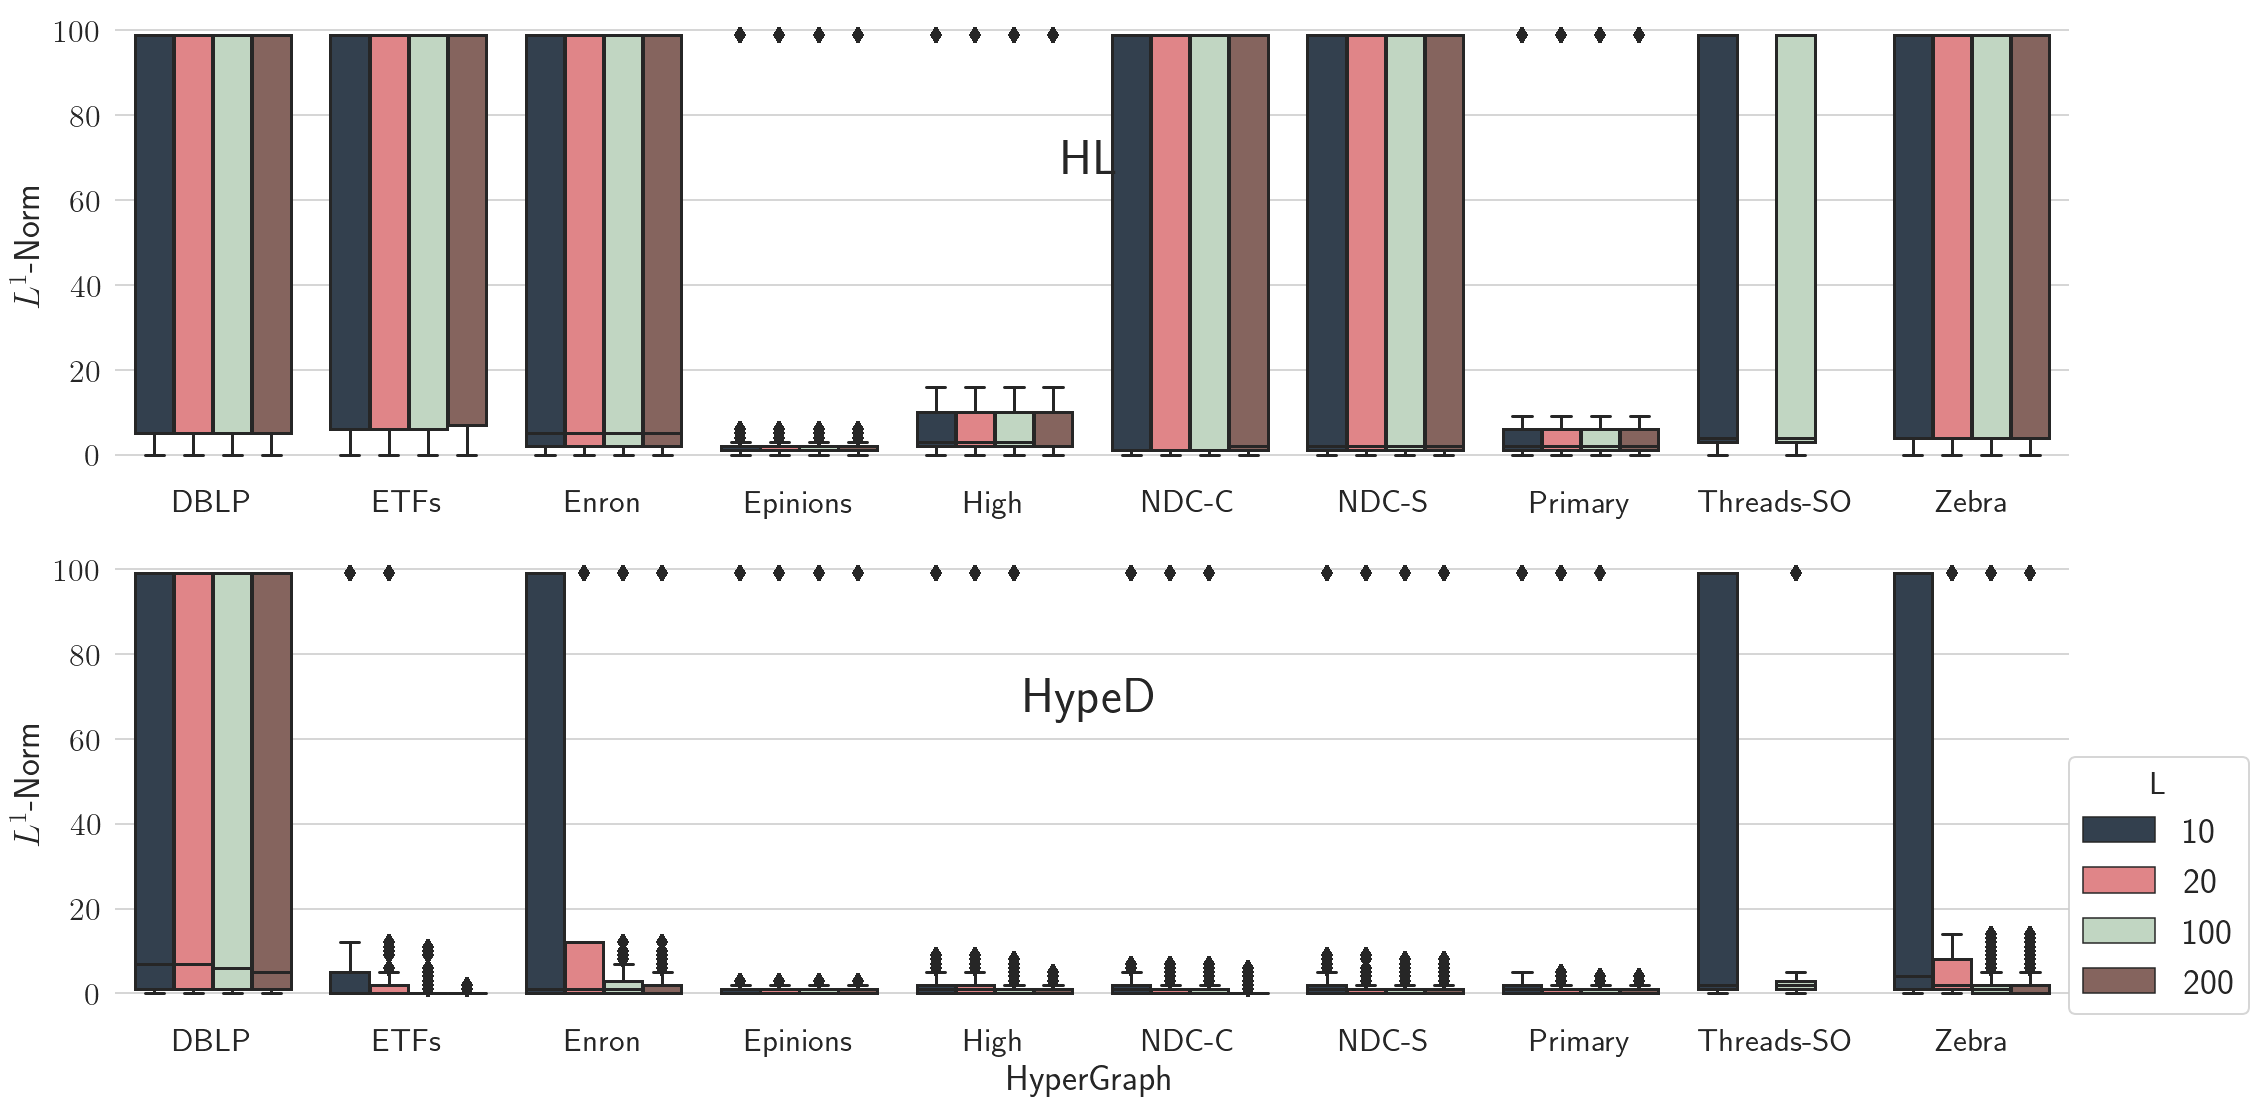

In [163]:
fig, ax = plt.subplots(2,1,figsize=(16,8))

all_est.sort_values(by='HyperGraph', inplace=True)

sns.boxplot(data=all_est, x='HyperGraph', y='HL (L1-Norm)',
            hue='L', palette=palette, ax=ax[0])

ax[0].set_ylabel(r'$L^1$-Norm')
ax[0].set_xlabel('')
ax[0].legend().remove()
ax[0].set_title('HL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

sns.boxplot(data=all_est, x='HyperGraph', y='HypeD (L1-Norm)', 
            hue='L', palette=palette, ax=ax[1])
ax[1].legend(title='L', loc=(1,0))
ax[1].set_ylabel(r'$L^1$-Norm')
ax[1].set_title('HypeD', pad=-80, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(fig_path+'l1_comparison_hl.pdf')
plt.show()

#### MAE and RMSE

In [195]:
accuracies = []
for l in all_est['L'].unique():
    df = all_est.loc[all_est['L']==l, ['HyperGraph', 'HypeD-Est', 'd']]
    for g in df['HyperGraph'].unique():
        df2 = df[df['HyperGraph']==g]
        y_true = df2['d'].values
        y_pred = df2['HypeD-Est'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        accuracies.append([g, l, 'HypED', mae, rmse])
    df = all_est.loc[all_est['L']==l, ['HyperGraph', 'HL-Est', 'd']]
    for g in df['HyperGraph'].unique():
        df2 = df[df['HyperGraph']==g]
        y_true = df2['d'].values
        y_pred = df2['HL-Est'].values
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        accuracies.append([g, l, 'HL', mae, rmse])

In [196]:
acc_df_hl = pd.DataFrame(accuracies, columns=['HyperGraph', 'Param', 'Algorithm', 'MAE', 'RMSE'])

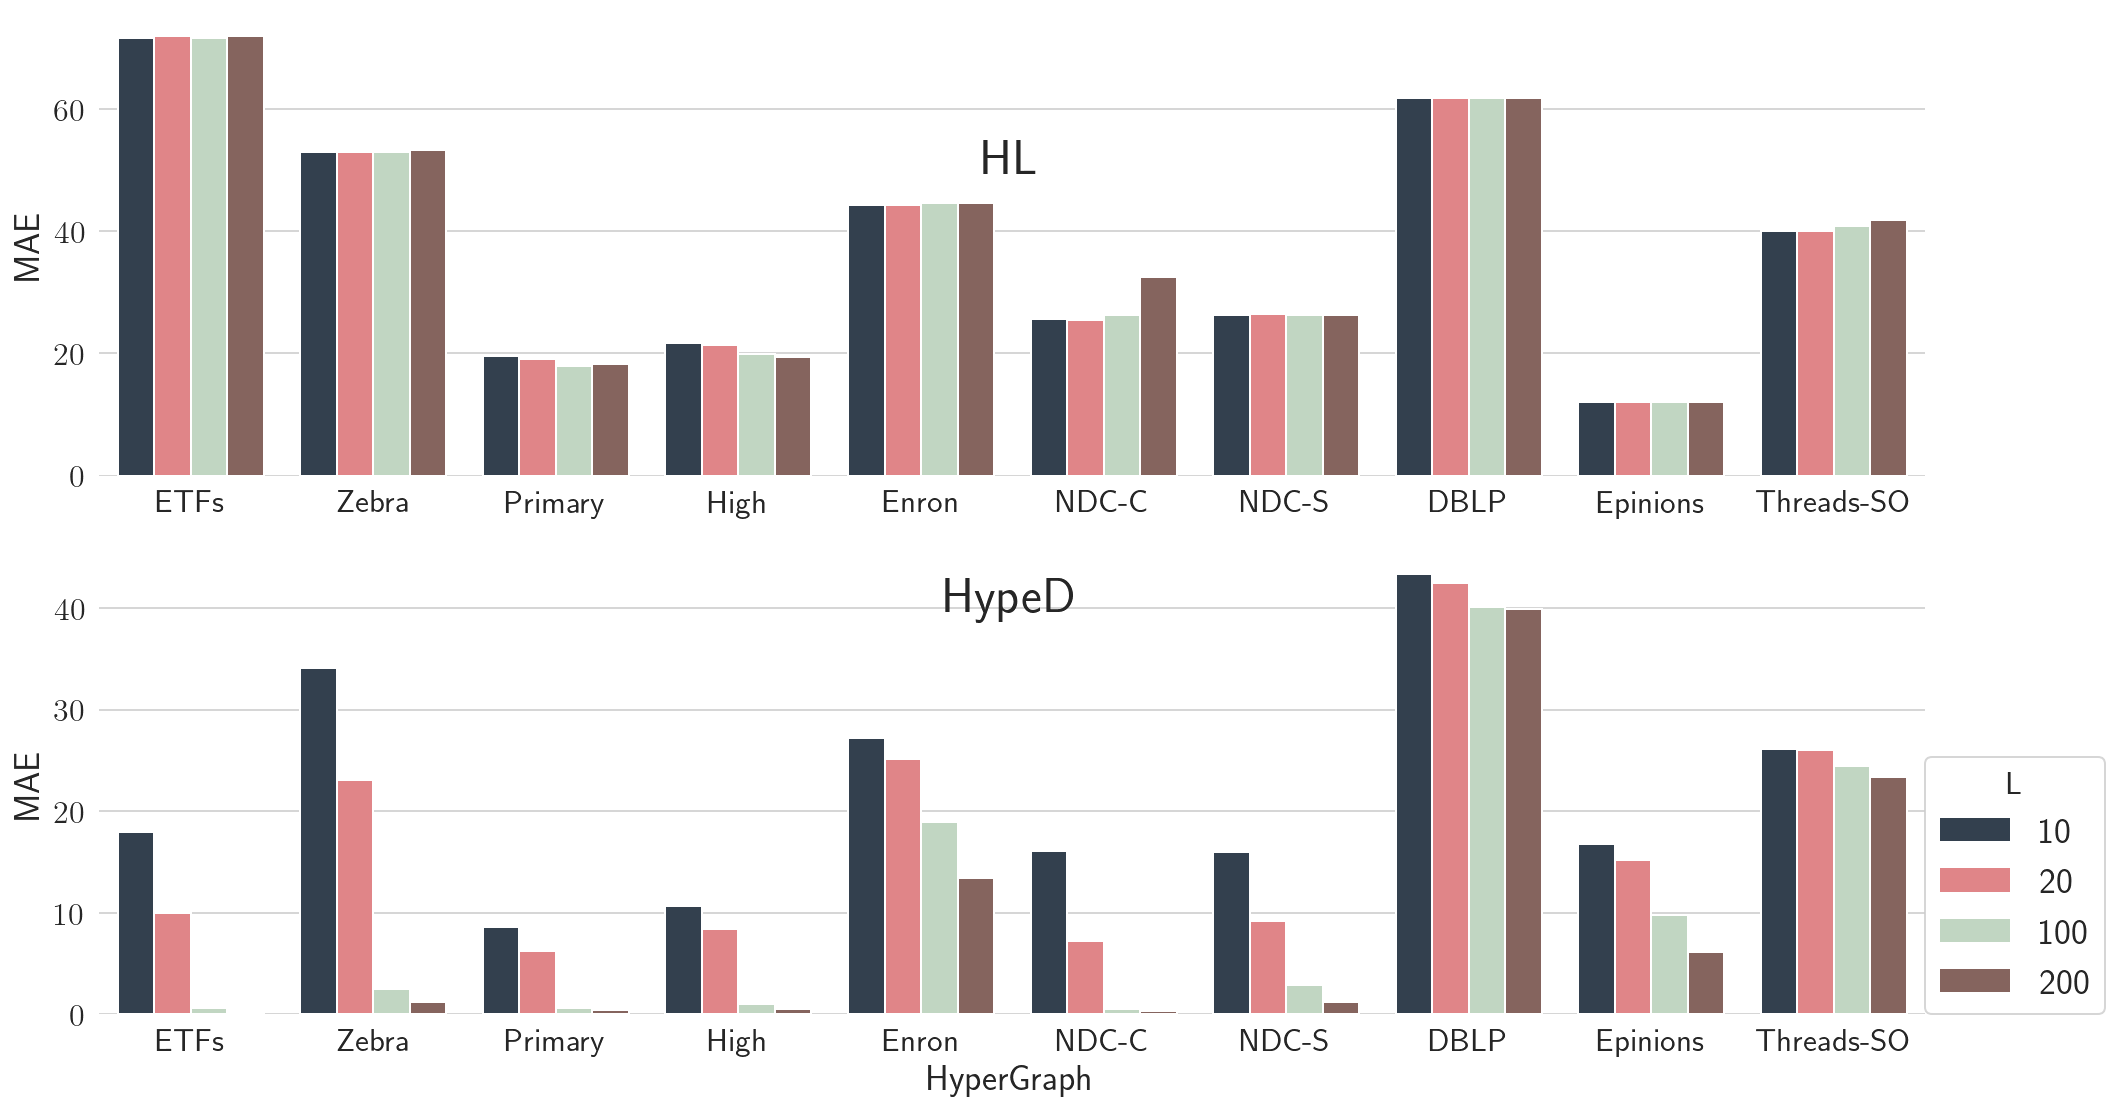

In [197]:
fig, ax = plt.subplots(2,1, figsize=(15,8))

data = acc_df_hl[acc_df_hl['Algorithm']=='HL']
sns.barplot(data=data, x='HyperGraph', y='MAE',
            hue='Param', palette=palette, ax=ax[0])
ax[0].legend().remove()
ax[0].set_xlabel('')
ax[0].set_title('HL', pad=-80, fontsize=25, fontweight='bold')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)

data = acc_df_hl[acc_df_hl['Algorithm']=='HypED']
sns.barplot(data=data, x='HyperGraph', y='MAE',
            hue='Param', palette=palette, ax=ax[1])
ax[1].legend(title='L', loc=(1,0))
ax[1].set_title('HypeD', pad=-30, fontsize=25, fontweight='bold')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(fig_path+'mae_comparison_hl.pdf')
plt.show()

TOGETHER

In [198]:
merged_acc = acc_df_hl[(acc_df_hl['Param'].isin([10,20,100,200])) &
                       (acc_df_hl['Algorithm']=='HypED')].copy()
merged_acc['Algorithm'] = 'HypED-' + merged_acc['Param'].apply(str)
merged_acc = merged_acc[['HyperGraph', 'Algorithm', 'MAE']]

tmp = acc_df_hl[(acc_df_hl['Param']==100) & 
             (acc_df_hl['Algorithm']=='HL')].copy()
tmp['Algorithm'] = 'HL-100'
tmp = tmp[['HyperGraph', 'Algorithm', 'MAE']]
merged_acc = merged_acc.append(tmp, ignore_index=True)

tmp = acc_df_ctl[(acc_df_ctl['Param']==100) & 
             (acc_df_ctl['Algorithm']=='CTL')].copy()
tmp['Algorithm'] = 'CTL-100'
tmp = tmp[['HyperGraph', 'Algorithm', 'MAE']]
merged_acc = merged_acc.append(tmp, ignore_index=True)

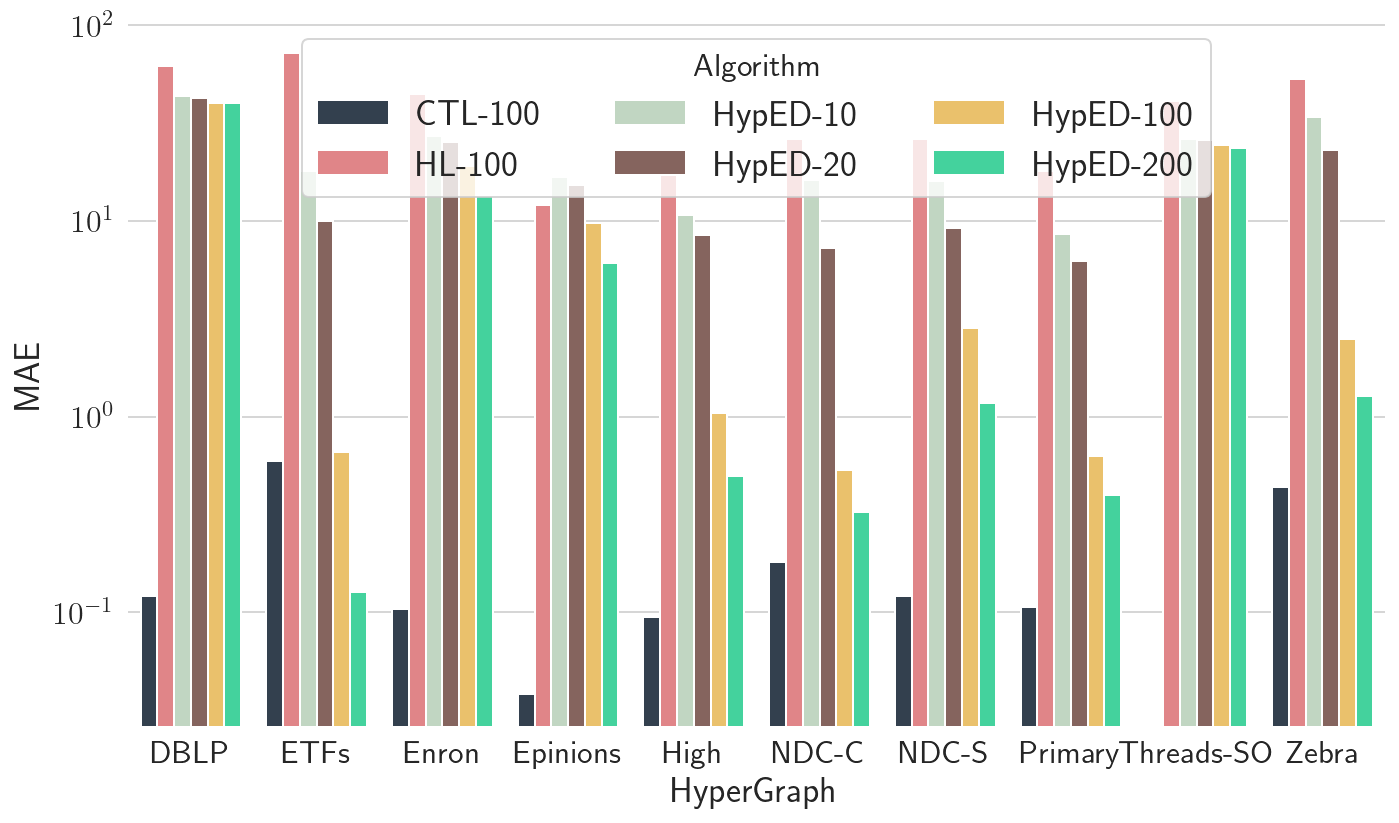

In [199]:
fig, ax = plt.subplots(figsize=(10,6))

data = merged_acc.sort_values(by='HyperGraph')
sns.barplot(data=data, x='HyperGraph', y='MAE', 
            hue_order=['CTL-100', 'HL-100', 'HypED-10', 'HypED-20', 'HypED-100', 'HypED-200'],
            hue='Algorithm', palette=palette, ax=ax)
ax.legend(title='Algorithm', ncol=3)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_yscale('log')
plt.tight_layout()
plt.savefig(fig_path+'mae_comparisons.pdf')
plt.show()